<center><h1>Domain Adaptation</h1></center>

<center><h2><a href="https://arthurdouillard.com/deepcourse/">Course link</a></h2></center>

To keep your modifications in case you want to come back later to this colab, do *File -> Save a copy in Drive*.

We will implement the paper **Unsupervised Domain Adaptation by Backpropagation** in this session. We strongly advise to read this paper, it's a major one!

https://arxiv.org/abs/1409.7495

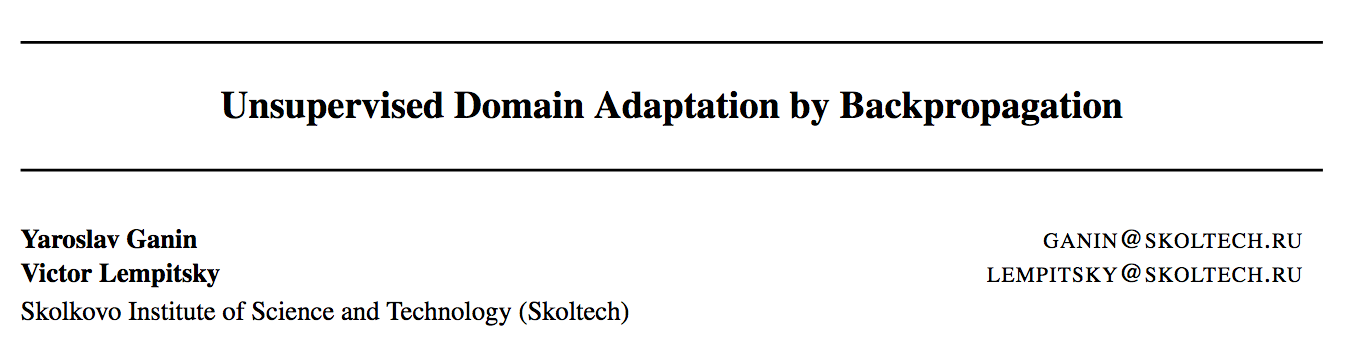

In [1]:
%matplotlib inline

In [2]:
import math
import pickle

import numpy as np
import torch
import torchvision
from PIL import Image
from torch import nn
from torch.nn import functional as F
from torch.utils.data import DataLoader
from torch.utils.tensorboard import SummaryWriter
from torchvision import transforms
from torchvision.datasets import ImageFolder
from tqdm import tqdm

We are going to do a **domain adaptation** from a source dataset (MNIST) towards a target dataset (MNIST-M).

First, we need to create the target dataset:

In [3]:
from mnistm import create_mnistm

create_mnistm()

Then, let's load the MNIST dataset and compute its (train!) mean and standard deviation.

We will use those values to **standardize** both MNIST and MNIST-M.

In [4]:
mnist_pixels = torchvision.datasets.MNIST(".", train=True, download=True).data / 255
mean = mnist_pixels.mean().item()
std = mnist_pixels.std().item()

print(f"Mean {mean} and Std {std}")
mean = torch.tensor([mean, mean, mean])
std = torch.tensor([std, std, std])

Mean 0.13066047430038452 and Std 0.30810782313346863


Create the loaders for MNIST...

In [5]:
transform = transforms.Compose(
    [
        transforms.ToTensor(),
        lambda x: x.repeat(3, 1, 1) if x.shape[0] == 1 else x,
        transforms.Normalize(mean, std),
    ]
)

mnist_train = torchvision.datasets.MNIST(".", train=True, transform=transform)
mnist_test = torchvision.datasets.MNIST(".", train=False, transform=transform)

source_train_loader = DataLoader(mnist_train, batch_size=128)
source_test_loader = DataLoader(mnist_test, batch_size=128)

... and visualize!

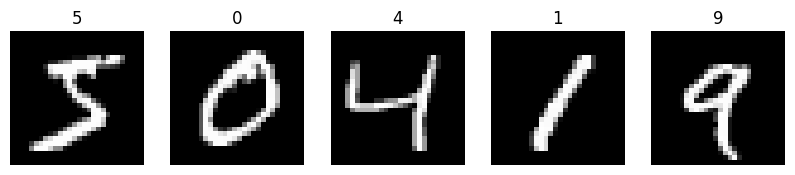

In [6]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 7))

for i in range(5):
    ax = plt.subplot(1, 5, i + 1)
    ax.axis("off")

    x, y = mnist_train[i]
    img = ((x * std[:, None, None] + mean[:, None, None]) * 255).permute(1, 2, 0)
    plt.imshow(img.numpy().astype(np.uint8), cmap="gray")
    plt.title(y)

Likewise, for MNIST-M. We create a simple `Dataset` in order to load the dataset that was serialized as a pickle:

In [7]:
with open("mnistm_data.pkl", "rb") as f:
    mnist_m = pickle.load(f)


class MNISTM(torch.utils.data.Dataset):
    def __init__(self, x, y, transform):
        self.x, self.y = x, y
        self.transform = transform

    def __len__(self):
        return len(self.x)

    def __getitem__(self, index):
        x, y = self.x[index], self.y[index]
        x = self.transform(x)

        return x, y


mnistm_train = MNISTM(mnist_m["x_train"], mnist_m["y_train"], transform)
mnistm_test = MNISTM(mnist_m["x_test"], mnist_m["y_test"], transform)

target_train_loader = DataLoader(mnistm_train, batch_size=128)
target_test_loader = DataLoader(mnistm_test, batch_size=128)

And we also visualize it. Remember to always visualize your data before training a model on it. You may realize that the dataset is ill-formated, in its pixels or targets, and have to do more data preparation beforehand.

Noice that **MNIST-M** is extremely similar to MNIST. The only difference is that the former has colors and textures, and is thus a RGB image. Because MNIST is in grayscale, we have duplicated thrice its channels axis.

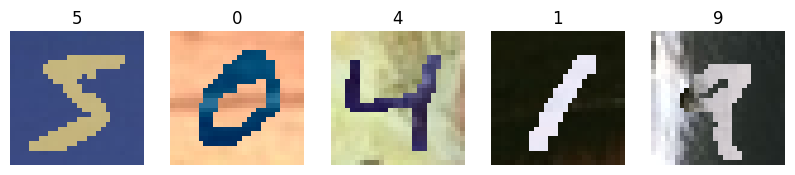

In [8]:
plt.figure(figsize=(10, 7))

for i in range(5):
    ax = plt.subplot(1, 5, i + 1)
    ax.axis("off")

    x, y = mnistm_train[i]
    img = ((x * std[:, None, None] + mean[:, None, None]) * 255).permute(1, 2, 0)
    plt.imshow(img.numpy().astype(np.uint8))
    plt.title(y)

Now, let's implement this basic network, whose figure is extracted from the paper. Conceive your model so that convolutions do not reduce the spatial dimensions:

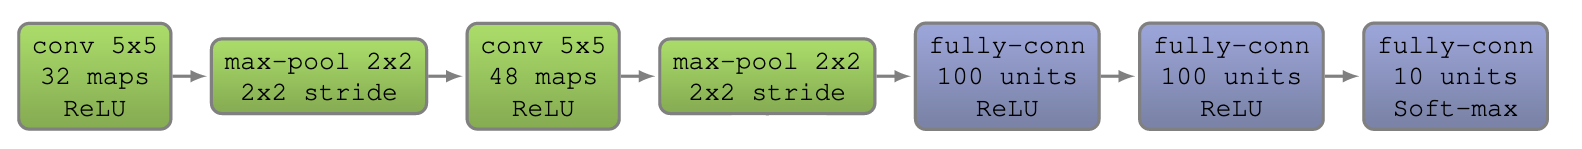

In [9]:
class NaiveNet(nn.Module):
    def __init__(self):
        super().__init__()  # Important, otherwise will throw an error

        self.cnn = nn.Sequential(
            nn.Conv2d(3, 32, kernel_size=5, stride=1, padding=2),  # (32, 28, 28)
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2, padding=0),  # (32, 14, 14)
            nn.Conv2d(32, 48, kernel_size=5, stride=1, padding=2),  # (48, 14, 14)
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2, padding=0),  #  (48, 7, 7)
        )

        self.classif = nn.Sequential(
            nn.Linear(48 * 7 * 7, 100),
            nn.ReLU(),
            nn.Linear(100, 100),
            nn.ReLU(),
            nn.Linear(100, 10),
            # Softmax include in the Cross-Entropy loss
        )

    def forward(self, x):
        x = self.cnn(x)
        x = x.flatten(start_dim=1)
        x = self.classif(x)
        return x


NaiveNet()(torch.randn(2, 3, 28, 28)).shape

torch.Size([2, 10])

In [10]:
def eval_model(net, loader):
    net.eval()

    acc, loss = 0, 0.0
    c = 0
    for x, y in loader:
        c += len(x)

        with torch.no_grad():
            logits = net(x.cuda()).cpu()

        loss += F.cross_entropy(logits, y).item()
        acc += (logits.argmax(dim=1) == y).sum().item()

    return round(100 * acc / c, 2), round(loss / len(loader), 5)

Let's train our naive model, but only the source (MNIST) dataset. We will evaluate its performance on the target (MNIST-M) dataset afterwards.

Notice that we use a **learning rate scheduler**. We are updating the learning rate after each epoch according to a function defined with a *lambda* following the paper specification.

We set the initial learning rate to 1.0 because `LambdaLR` defines a *multiplicative factor* of the base learning rate.

It's often useful to reduce likewise the learning rate during training, to facilitate convergence once the model has found a good local minima (we rarely find the global).

In [11]:
writer = SummaryWriter("runs/NaiveNet")

epochs = 10

naive_net = NaiveNet().cuda()

optimizer = torch.optim.SGD(naive_net.parameters(), lr=1.0, momentum=0.9)

mu0, alpha, beta = 0.01, 10, 0.75
scheduler = torch.optim.lr_scheduler.LambdaLR(
    optimizer, lambda e: 0.01 / (1 + alpha * e / epochs) ** beta
)

total_batches = epochs * len(source_train_loader)
with tqdm(total=total_batches, desc=f"Epoch 1/{epochs}", unit="batch") as pbar:
    for epoch in range(epochs):
        train_loss = 0.0

        for x, y in source_train_loader:
            x, y = x.cuda(), y.cuda()

            optimizer.zero_grad()
            logits = naive_net(x)
            loss = F.cross_entropy(logits, y)
            loss.backward()
            optimizer.step()

            train_loss += loss.item()

            pbar.update(1)

        pbar.set_description(f"Epoch {epoch + 1}/{epochs}")
        scheduler.step()
        pbar.set_postfix(
            {
                "train loss": round(train_loss / len(source_train_loader), 5),
                "learning rate": optimizer.param_groups[0]["lr"],
            }
        )
        # print(f"\tLearning rate = {optimizer.param_groups[0]['lr']}")

    test_acc, test_loss = eval_model(naive_net, source_test_loader)
    print(f"Test loss: {test_loss}, test acc: {test_acc}")

Epoch 1/10:   0%|                                                                                                                                        | 0/4690 [00:00<?, ?batch/s]

Epoch 1/10:   0%|                                                                                                                                | 1/4690 [00:00<23:05,  3.38batch/s]

Epoch 1/10:   0%|                                                                                                                                | 3/4690 [00:00<09:29,  8.22batch/s]

Epoch 1/10:   0%|▏                                                                                                                               | 6/4690 [00:00<05:28, 14.27batch/s]

Epoch 1/10:   0%|▎                                                                                                                              | 10/4690 [00:00<03:44, 20.82batch/s]

Epoch 1/10:   0%|▍                                                                                                                              | 16/4690 [00:00<02:31, 30.77batch/s]

Epoch 1/10:   0%|▌                                                                                                                              | 22/4690 [00:00<02:04, 37.51batch/s]

Epoch 1/10:   1%|▊                                                                                                                              | 28/4690 [00:00<01:50, 42.11batch/s]

Epoch 1/10:   1%|▉                                                                                                                              | 34/4690 [00:01<01:43, 45.15batch/s]

Epoch 1/10:   1%|█                                                                                                                              | 40/4690 [00:01<01:38, 47.30batch/s]

Epoch 1/10:   1%|█▏                                                                                                                             | 46/4690 [00:01<01:35, 48.85batch/s]

Epoch 1/10:   1%|█▍                                                                                                                             | 52/4690 [00:01<01:33, 49.84batch/s]

Epoch 1/10:   1%|█▌                                                                                                                             | 58/4690 [00:01<01:31, 50.62batch/s]

Epoch 1/10:   1%|█▋                                                                                                                             | 64/4690 [00:01<01:35, 48.65batch/s]

Epoch 1/10:   1%|█▊                                                                                                                             | 69/4690 [00:01<01:34, 48.71batch/s]

Epoch 1/10:   2%|██                                                                                                                             | 75/4690 [00:01<01:32, 49.79batch/s]

Epoch 1/10:   2%|██▏                                                                                                                            | 81/4690 [00:02<01:31, 50.57batch/s]

Epoch 1/10:   2%|██▎                                                                                                                            | 87/4690 [00:02<01:30, 51.11batch/s]

Epoch 1/10:   2%|██▌                                                                                                                            | 93/4690 [00:02<01:29, 51.44batch/s]

Epoch 1/10:   2%|██▋                                                                                                                            | 99/4690 [00:02<01:28, 51.73batch/s]

Epoch 1/10:   2%|██▊                                                                                                                           | 105/4690 [00:02<01:28, 51.91batch/s]

Epoch 1/10:   2%|██▉                                                                                                                           | 111/4690 [00:02<01:27, 52.10batch/s]

Epoch 1/10:   2%|███▏                                                                                                                          | 117/4690 [00:02<01:27, 52.21batch/s]

Epoch 1/10:   3%|███▎                                                                                                                          | 123/4690 [00:02<01:27, 52.30batch/s]

Epoch 1/10:   3%|███▍                                                                                                                          | 129/4690 [00:02<01:27, 52.35batch/s]

Epoch 1/10:   3%|███▋                                                                                                                          | 135/4690 [00:03<01:27, 52.29batch/s]

Epoch 1/10:   3%|███▊                                                                                                                          | 141/4690 [00:03<01:27, 52.28batch/s]

Epoch 1/10:   3%|███▉                                                                                                                          | 147/4690 [00:03<01:26, 52.33batch/s]

Epoch 1/10:   3%|████                                                                                                                          | 153/4690 [00:03<01:26, 52.35batch/s]

Epoch 1/10:   3%|████▎                                                                                                                         | 159/4690 [00:03<01:26, 52.42batch/s]

Epoch 1/10:   4%|████▍                                                                                                                         | 165/4690 [00:03<01:26, 52.41batch/s]

Epoch 1/10:   4%|████▌                                                                                                                         | 171/4690 [00:03<01:26, 52.40batch/s]

Epoch 1/10:   4%|████▊                                                                                                                         | 177/4690 [00:03<01:26, 52.42batch/s]

Epoch 1/10:   4%|████▉                                                                                                                         | 183/4690 [00:03<01:25, 52.41batch/s]

Epoch 1/10:   4%|█████                                                                                                                         | 189/4690 [00:04<01:26, 52.23batch/s]

Epoch 1/10:   4%|█████▏                                                                                                                        | 195/4690 [00:04<01:26, 52.23batch/s]

Epoch 1/10:   4%|█████▍                                                                                                                        | 201/4690 [00:04<01:25, 52.25batch/s]

Epoch 1/10:   4%|█████▌                                                                                                                        | 207/4690 [00:04<01:25, 52.26batch/s]

Epoch 1/10:   5%|█████▋                                                                                                                        | 213/4690 [00:04<01:25, 52.34batch/s]

Epoch 1/10:   5%|█████▉                                                                                                                        | 219/4690 [00:04<01:25, 52.35batch/s]

Epoch 1/10:   5%|██████                                                                                                                        | 225/4690 [00:04<01:25, 52.40batch/s]

Epoch 1/10:   5%|██████▏                                                                                                                       | 231/4690 [00:04<01:25, 52.43batch/s]

Epoch 1/10:   5%|██████▎                                                                                                                       | 237/4690 [00:05<01:25, 51.99batch/s]

Epoch 1/10:   5%|██████▌                                                                                                                       | 243/4690 [00:05<01:25, 51.91batch/s]

Epoch 1/10:   5%|██████▋                                                                                                                       | 249/4690 [00:05<01:25, 52.03batch/s]

Epoch 1/10:   5%|██████▊                                                                                                                       | 255/4690 [00:05<01:25, 52.16batch/s]

Epoch 1/10:   6%|███████                                                                                                                       | 261/4690 [00:05<01:24, 52.24batch/s]

Epoch 1/10:   6%|███████▏                                                                                                                      | 267/4690 [00:05<01:24, 52.30batch/s]

Epoch 1/10:   6%|███████▎                                                                                                                      | 273/4690 [00:05<01:42, 43.24batch/s]

Epoch 1/10:   6%|███████▍                                                                                                                      | 279/4690 [00:05<01:36, 45.59batch/s]

Epoch 1/10:   6%|███████▋                                                                                                                      | 285/4690 [00:06<01:33, 47.31batch/s]

Epoch 1/10:   6%|███████▊                                                                                                                      | 291/4690 [00:06<01:30, 48.60batch/s]

Epoch 1/10:   6%|███████▉                                                                                                                      | 297/4690 [00:06<01:28, 49.61batch/s]

Epoch 1/10:   6%|████████▏                                                                                                                     | 303/4690 [00:06<01:27, 50.38batch/s]

Epoch 1/10:   7%|████████▎                                                                                                                     | 309/4690 [00:06<01:26, 50.88batch/s]

Epoch 1/10:   7%|████████▍                                                                                                                     | 315/4690 [00:06<01:25, 51.29batch/s]

Epoch 1/10:   7%|████████▌                                                                                                                     | 321/4690 [00:06<01:24, 51.58batch/s]

Epoch 1/10:   7%|████████▊                                                                                                                     | 327/4690 [00:06<01:24, 51.72batch/s]

Epoch 1/10:   7%|████████▉                                                                                                                     | 333/4690 [00:06<01:23, 51.89batch/s]

Epoch 1/10:   7%|█████████                                                                                                                     | 339/4690 [00:07<01:23, 51.83batch/s]

Epoch 1/10:   7%|█████████▎                                                                                                                    | 345/4690 [00:07<01:23, 51.94batch/s]

Epoch 1/10:   7%|█████████▍                                                                                                                    | 351/4690 [00:07<01:23, 51.94batch/s]

Epoch 1/10:   8%|█████████▌                                                                                                                    | 357/4690 [00:07<01:23, 52.02batch/s]

Epoch 1/10:   8%|█████████▊                                                                                                                    | 363/4690 [00:07<01:23, 52.11batch/s]

Epoch 1/10:   8%|█████████▉                                                                                                                    | 369/4690 [00:07<01:22, 52.15batch/s]

Epoch 1/10:   8%|██████████                                                                                                                    | 375/4690 [00:07<01:22, 52.22batch/s]

Epoch 1/10:   8%|██████████▏                                                                                                                   | 381/4690 [00:07<01:22, 52.25batch/s]

Epoch 1/10:   8%|██████████▍                                                                                                                   | 387/4690 [00:07<01:22, 52.21batch/s]

Epoch 1/10:   8%|██████████▌                                                                                                                   | 393/4690 [00:08<01:22, 52.14batch/s]

Epoch 1/10:   9%|██████████▋                                                                                                                   | 399/4690 [00:08<01:22, 52.13batch/s]

Epoch 1/10:   9%|██████████▉                                                                                                                   | 405/4690 [00:08<01:22, 51.71batch/s]

Epoch 1/10:   9%|███████████                                                                                                                   | 411/4690 [00:08<01:22, 51.81batch/s]

Epoch 1/10:   9%|███████████▏                                                                                                                  | 417/4690 [00:08<01:22, 51.94batch/s]

Epoch 1/10:   9%|███████████▎                                                                                                                  | 423/4690 [00:08<01:21, 52.04batch/s]

Epoch 1/10:   9%|███████████▌                                                                                                                  | 429/4690 [00:08<01:21, 52.11batch/s]

Epoch 1/10:   9%|███████████▋                                                                                                                  | 435/4690 [00:08<01:21, 52.17batch/s]

Epoch 1/10:   9%|███████████▊                                                                                                                  | 441/4690 [00:09<01:21, 52.11batch/s]

Epoch 1/10:  10%|████████████                                                                                                                  | 447/4690 [00:09<01:21, 52.05batch/s]

Epoch 1/10:  10%|████████████▏                                                                                                                 | 453/4690 [00:09<01:21, 52.09batch/s]

Epoch 1/10:  10%|████████████▎                                                                                                                 | 459/4690 [00:09<01:21, 52.14batch/s]

Epoch 1/10:  10%|████████████▍                                                                                                                 | 465/4690 [00:09<01:21, 52.11batch/s]

Epoch 1/10:  10%|████████████▌                                                                                                                 | 469/4690 [00:09<01:21, 52.11batch/s]

Epoch 1/10:  10%|████████▌                                                                             | 469/4690 [00:09<01:21, 52.11batch/s, train loss=0.34, learning rate=0.00595]

Epoch 1/10:  10%|████████▋                                                                             | 471/4690 [00:09<01:22, 50.88batch/s, train loss=0.34, learning rate=0.00595]

Epoch 1/10:  10%|████████▋                                                                             | 477/4690 [00:09<01:22, 51.25batch/s, train loss=0.34, learning rate=0.00595]

Epoch 1/10:  10%|████████▊                                                                             | 483/4690 [00:09<01:21, 51.48batch/s, train loss=0.34, learning rate=0.00595]

Epoch 1/10:  10%|████████▉                                                                             | 489/4690 [00:10<01:38, 42.59batch/s, train loss=0.34, learning rate=0.00595]

Epoch 1/10:  11%|█████████                                                                             | 495/4690 [00:10<01:33, 45.07batch/s, train loss=0.34, learning rate=0.00595]

Epoch 1/10:  11%|█████████▏                                                                            | 501/4690 [00:10<01:29, 46.96batch/s, train loss=0.34, learning rate=0.00595]

Epoch 1/10:  11%|█████████▎                                                                            | 507/4690 [00:10<01:26, 48.42batch/s, train loss=0.34, learning rate=0.00595]

Epoch 1/10:  11%|█████████▍                                                                            | 513/4690 [00:10<01:24, 49.50batch/s, train loss=0.34, learning rate=0.00595]

Epoch 1/10:  11%|█████████▌                                                                            | 519/4690 [00:10<01:22, 50.31batch/s, train loss=0.34, learning rate=0.00595]

Epoch 1/10:  11%|█████████▋                                                                            | 525/4690 [00:10<01:21, 50.89batch/s, train loss=0.34, learning rate=0.00595]

Epoch 1/10:  11%|█████████▋                                                                            | 531/4690 [00:10<01:26, 47.91batch/s, train loss=0.34, learning rate=0.00595]

Epoch 1/10:  11%|█████████▊                                                                            | 536/4690 [00:10<01:32, 44.68batch/s, train loss=0.34, learning rate=0.00595]

Epoch 1/10:  12%|█████████▉                                                                            | 542/4690 [00:11<01:28, 46.76batch/s, train loss=0.34, learning rate=0.00595]

Epoch 1/10:  12%|██████████                                                                            | 548/4690 [00:11<01:25, 48.28batch/s, train loss=0.34, learning rate=0.00595]

Epoch 1/10:  12%|██████████▏                                                                           | 554/4690 [00:11<01:23, 49.44batch/s, train loss=0.34, learning rate=0.00595]

Epoch 1/10:  12%|██████████▎                                                                           | 560/4690 [00:11<01:22, 50.27batch/s, train loss=0.34, learning rate=0.00595]

Epoch 1/10:  12%|██████████▍                                                                           | 566/4690 [00:11<01:21, 50.51batch/s, train loss=0.34, learning rate=0.00595]

Epoch 1/10:  12%|██████████▍                                                                           | 572/4690 [00:11<01:23, 49.32batch/s, train loss=0.34, learning rate=0.00595]

Epoch 1/10:  12%|██████████▌                                                                           | 578/4690 [00:11<01:22, 50.09batch/s, train loss=0.34, learning rate=0.00595]

Epoch 1/10:  12%|██████████▋                                                                           | 584/4690 [00:11<01:20, 50.77batch/s, train loss=0.34, learning rate=0.00595]

Epoch 1/10:  13%|██████████▊                                                                           | 590/4690 [00:12<01:20, 51.17batch/s, train loss=0.34, learning rate=0.00595]

Epoch 1/10:  13%|██████████▉                                                                           | 596/4690 [00:12<01:19, 51.47batch/s, train loss=0.34, learning rate=0.00595]

Epoch 1/10:  13%|███████████                                                                           | 602/4690 [00:12<01:19, 51.65batch/s, train loss=0.34, learning rate=0.00595]

Epoch 1/10:  13%|███████████▏                                                                          | 608/4690 [00:12<01:18, 51.81batch/s, train loss=0.34, learning rate=0.00595]

Epoch 1/10:  13%|███████████▎                                                                          | 614/4690 [00:12<01:18, 51.90batch/s, train loss=0.34, learning rate=0.00595]

Epoch 1/10:  13%|███████████▎                                                                          | 620/4690 [00:12<01:18, 52.02batch/s, train loss=0.34, learning rate=0.00595]

Epoch 1/10:  13%|███████████▍                                                                          | 626/4690 [00:12<01:17, 52.11batch/s, train loss=0.34, learning rate=0.00595]

Epoch 1/10:  13%|███████████▌                                                                          | 632/4690 [00:12<01:17, 52.21batch/s, train loss=0.34, learning rate=0.00595]

Epoch 1/10:  14%|███████████▋                                                                          | 638/4690 [00:12<01:17, 52.26batch/s, train loss=0.34, learning rate=0.00595]

Epoch 1/10:  14%|███████████▊                                                                          | 644/4690 [00:13<01:17, 52.17batch/s, train loss=0.34, learning rate=0.00595]

Epoch 1/10:  14%|███████████▉                                                                          | 650/4690 [00:13<01:17, 52.19batch/s, train loss=0.34, learning rate=0.00595]

Epoch 1/10:  14%|████████████                                                                          | 656/4690 [00:13<01:17, 52.20batch/s, train loss=0.34, learning rate=0.00595]

Epoch 1/10:  14%|████████████▏                                                                         | 662/4690 [00:13<01:17, 51.78batch/s, train loss=0.34, learning rate=0.00595]

Epoch 1/10:  14%|████████████▏                                                                         | 668/4690 [00:13<01:17, 51.67batch/s, train loss=0.34, learning rate=0.00595]

Epoch 1/10:  14%|████████████▎                                                                         | 674/4690 [00:13<01:17, 51.79batch/s, train loss=0.34, learning rate=0.00595]

Epoch 1/10:  14%|████████████▍                                                                         | 680/4690 [00:13<01:17, 51.94batch/s, train loss=0.34, learning rate=0.00595]

Epoch 1/10:  15%|████████████▌                                                                         | 686/4690 [00:13<01:16, 52.04batch/s, train loss=0.34, learning rate=0.00595]

Epoch 1/10:  15%|████████████▋                                                                         | 692/4690 [00:13<01:16, 52.10batch/s, train loss=0.34, learning rate=0.00595]

Epoch 1/10:  15%|████████████▊                                                                         | 698/4690 [00:14<01:33, 42.67batch/s, train loss=0.34, learning rate=0.00595]

Epoch 1/10:  15%|████████████▉                                                                         | 704/4690 [00:14<01:28, 45.12batch/s, train loss=0.34, learning rate=0.00595]

Epoch 1/10:  15%|█████████████                                                                         | 710/4690 [00:14<01:24, 46.98batch/s, train loss=0.34, learning rate=0.00595]

Epoch 1/10:  15%|█████████████▏                                                                        | 716/4690 [00:14<01:22, 48.41batch/s, train loss=0.34, learning rate=0.00595]

Epoch 1/10:  15%|█████████████▏                                                                        | 722/4690 [00:14<01:20, 49.50batch/s, train loss=0.34, learning rate=0.00595]

Epoch 1/10:  16%|█████████████▎                                                                        | 728/4690 [00:14<01:18, 50.28batch/s, train loss=0.34, learning rate=0.00595]

Epoch 1/10:  16%|█████████████▍                                                                        | 734/4690 [00:14<01:18, 50.44batch/s, train loss=0.34, learning rate=0.00595]

Epoch 1/10:  16%|█████████████▌                                                                        | 740/4690 [00:15<01:17, 50.80batch/s, train loss=0.34, learning rate=0.00595]

Epoch 1/10:  16%|█████████████▋                                                                        | 746/4690 [00:15<01:17, 51.15batch/s, train loss=0.34, learning rate=0.00595]

Epoch 1/10:  16%|█████████████▊                                                                        | 752/4690 [00:15<01:16, 51.45batch/s, train loss=0.34, learning rate=0.00595]

Epoch 1/10:  16%|█████████████▉                                                                        | 758/4690 [00:15<01:16, 51.66batch/s, train loss=0.34, learning rate=0.00595]

Epoch 1/10:  16%|██████████████                                                                        | 764/4690 [00:15<01:15, 51.76batch/s, train loss=0.34, learning rate=0.00595]

Epoch 1/10:  16%|██████████████                                                                        | 770/4690 [00:15<01:15, 51.89batch/s, train loss=0.34, learning rate=0.00595]

Epoch 1/10:  17%|██████████████▏                                                                       | 776/4690 [00:15<01:15, 51.96batch/s, train loss=0.34, learning rate=0.00595]

Epoch 1/10:  17%|██████████████▎                                                                       | 782/4690 [00:15<01:15, 52.03batch/s, train loss=0.34, learning rate=0.00595]

Epoch 1/10:  17%|██████████████▍                                                                       | 788/4690 [00:15<01:14, 52.07batch/s, train loss=0.34, learning rate=0.00595]

Epoch 1/10:  17%|██████████████▌                                                                       | 794/4690 [00:16<01:15, 51.89batch/s, train loss=0.34, learning rate=0.00595]

Epoch 1/10:  17%|██████████████▋                                                                       | 800/4690 [00:16<01:14, 51.89batch/s, train loss=0.34, learning rate=0.00595]

Epoch 1/10:  17%|██████████████▊                                                                       | 806/4690 [00:16<01:14, 51.95batch/s, train loss=0.34, learning rate=0.00595]

Epoch 1/10:  17%|██████████████▉                                                                       | 812/4690 [00:16<01:14, 52.01batch/s, train loss=0.34, learning rate=0.00595]

Epoch 1/10:  17%|██████████████▉                                                                       | 818/4690 [00:16<01:14, 51.87batch/s, train loss=0.34, learning rate=0.00595]

Epoch 1/10:  18%|███████████████                                                                       | 824/4690 [00:16<01:14, 51.94batch/s, train loss=0.34, learning rate=0.00595]

Epoch 1/10:  18%|███████████████▏                                                                      | 830/4690 [00:16<01:14, 51.98batch/s, train loss=0.34, learning rate=0.00595]

Epoch 1/10:  18%|███████████████▎                                                                      | 836/4690 [00:16<01:14, 52.03batch/s, train loss=0.34, learning rate=0.00595]

Epoch 1/10:  18%|███████████████▍                                                                      | 842/4690 [00:16<01:13, 52.06batch/s, train loss=0.34, learning rate=0.00595]

Epoch 1/10:  18%|███████████████▌                                                                      | 848/4690 [00:17<01:13, 52.01batch/s, train loss=0.34, learning rate=0.00595]

Epoch 1/10:  18%|███████████████▋                                                                      | 854/4690 [00:17<01:13, 51.99batch/s, train loss=0.34, learning rate=0.00595]

Epoch 1/10:  18%|███████████████▊                                                                      | 860/4690 [00:17<01:13, 52.02batch/s, train loss=0.34, learning rate=0.00595]

Epoch 1/10:  18%|███████████████▉                                                                      | 866/4690 [00:17<01:13, 52.04batch/s, train loss=0.34, learning rate=0.00595]

Epoch 1/10:  19%|███████████████▉                                                                      | 872/4690 [00:17<01:13, 52.05batch/s, train loss=0.34, learning rate=0.00595]

Epoch 1/10:  19%|████████████████                                                                      | 878/4690 [00:17<01:13, 52.08batch/s, train loss=0.34, learning rate=0.00595]

Epoch 1/10:  19%|████████████████▏                                                                     | 884/4690 [00:17<01:13, 52.10batch/s, train loss=0.34, learning rate=0.00595]

Epoch 1/10:  19%|████████████████▎                                                                     | 890/4690 [00:17<01:12, 52.10batch/s, train loss=0.34, learning rate=0.00595]

Epoch 1/10:  19%|████████████████▍                                                                     | 896/4690 [00:17<01:12, 52.11batch/s, train loss=0.34, learning rate=0.00595]

Epoch 1/10:  19%|████████████████▌                                                                     | 902/4690 [00:18<01:12, 51.97batch/s, train loss=0.34, learning rate=0.00595]

Epoch 1/10:  19%|████████████████▋                                                                     | 908/4690 [00:18<01:13, 51.72batch/s, train loss=0.34, learning rate=0.00595]

Epoch 1/10:  19%|████████████████▊                                                                     | 914/4690 [00:18<01:12, 51.85batch/s, train loss=0.34, learning rate=0.00595]

Epoch 1/10:  20%|████████████████▊                                                                     | 920/4690 [00:18<01:12, 51.97batch/s, train loss=0.34, learning rate=0.00595]

Epoch 1/10:  20%|████████████████▉                                                                     | 926/4690 [00:18<01:12, 52.01batch/s, train loss=0.34, learning rate=0.00595]

Epoch 1/10:  20%|█████████████████                                                                     | 932/4690 [00:18<01:12, 52.05batch/s, train loss=0.34, learning rate=0.00595]

Epoch 1/10:  20%|█████████████████▏                                                                    | 938/4690 [00:18<01:11, 52.68batch/s, train loss=0.34, learning rate=0.00595]

Epoch 2/10:  20%|█████████████████▏                                                                    | 938/4690 [00:18<01:11, 52.68batch/s, train loss=0.34, learning rate=0.00595]

Epoch 2/10:  20%|████████████████▊                                                                   | 938/4690 [00:18<01:11, 52.68batch/s, train loss=0.0594, learning rate=0.00439]

Epoch 2/10:  20%|████████████████▉                                                                   | 944/4690 [00:18<01:11, 52.35batch/s, train loss=0.0594, learning rate=0.00439]

Epoch 2/10:  20%|█████████████████                                                                   | 950/4690 [00:19<01:11, 52.21batch/s, train loss=0.0594, learning rate=0.00439]

Epoch 2/10:  20%|█████████████████                                                                   | 956/4690 [00:19<01:11, 52.14batch/s, train loss=0.0594, learning rate=0.00439]

Epoch 2/10:  21%|█████████████████▏                                                                  | 962/4690 [00:19<01:11, 52.14batch/s, train loss=0.0594, learning rate=0.00439]

Epoch 2/10:  21%|█████████████████▎                                                                  | 968/4690 [00:19<01:11, 52.16batch/s, train loss=0.0594, learning rate=0.00439]

Epoch 2/10:  21%|█████████████████▍                                                                  | 974/4690 [00:19<01:11, 52.21batch/s, train loss=0.0594, learning rate=0.00439]

Epoch 2/10:  21%|█████████████████▌                                                                  | 980/4690 [00:19<01:11, 52.21batch/s, train loss=0.0594, learning rate=0.00439]

Epoch 2/10:  21%|█████████████████▋                                                                  | 986/4690 [00:19<01:11, 52.09batch/s, train loss=0.0594, learning rate=0.00439]

Epoch 2/10:  21%|█████████████████▊                                                                  | 992/4690 [00:19<01:11, 51.95batch/s, train loss=0.0594, learning rate=0.00439]

Epoch 2/10:  21%|█████████████████▊                                                                  | 998/4690 [00:20<01:26, 42.79batch/s, train loss=0.0594, learning rate=0.00439]

Epoch 2/10:  21%|█████████████████▊                                                                 | 1003/4690 [00:20<01:28, 41.65batch/s, train loss=0.0594, learning rate=0.00439]

Epoch 2/10:  22%|█████████████████▊                                                                 | 1009/4690 [00:20<01:23, 44.30batch/s, train loss=0.0594, learning rate=0.00439]

Epoch 2/10:  22%|█████████████████▉                                                                 | 1015/4690 [00:20<01:19, 46.43batch/s, train loss=0.0594, learning rate=0.00439]

Epoch 2/10:  22%|██████████████████                                                                 | 1021/4690 [00:20<01:16, 47.88batch/s, train loss=0.0594, learning rate=0.00439]

Epoch 2/10:  22%|██████████████████▏                                                                | 1027/4690 [00:20<01:14, 49.13batch/s, train loss=0.0594, learning rate=0.00439]

Epoch 2/10:  22%|██████████████████▎                                                                | 1033/4690 [00:20<01:13, 50.05batch/s, train loss=0.0594, learning rate=0.00439]

Epoch 2/10:  22%|██████████████████▍                                                                | 1039/4690 [00:20<01:12, 50.70batch/s, train loss=0.0594, learning rate=0.00439]

Epoch 2/10:  22%|██████████████████▍                                                                | 1045/4690 [00:20<01:11, 51.15batch/s, train loss=0.0594, learning rate=0.00439]

Epoch 2/10:  22%|██████████████████▌                                                                | 1051/4690 [00:21<01:10, 51.42batch/s, train loss=0.0594, learning rate=0.00439]

Epoch 2/10:  23%|██████████████████▋                                                                | 1057/4690 [00:21<01:10, 51.67batch/s, train loss=0.0594, learning rate=0.00439]

Epoch 2/10:  23%|██████████████████▊                                                                | 1063/4690 [00:21<01:09, 51.88batch/s, train loss=0.0594, learning rate=0.00439]

Epoch 2/10:  23%|██████████████████▉                                                                | 1069/4690 [00:21<01:10, 51.70batch/s, train loss=0.0594, learning rate=0.00439]

Epoch 2/10:  23%|███████████████████                                                                | 1075/4690 [00:21<01:10, 51.48batch/s, train loss=0.0594, learning rate=0.00439]

Epoch 2/10:  23%|███████████████████▏                                                               | 1081/4690 [00:21<01:09, 51.79batch/s, train loss=0.0594, learning rate=0.00439]

Epoch 2/10:  23%|███████████████████▏                                                               | 1087/4690 [00:21<01:09, 51.95batch/s, train loss=0.0594, learning rate=0.00439]

Epoch 2/10:  23%|███████████████████▎                                                               | 1093/4690 [00:21<01:09, 51.92batch/s, train loss=0.0594, learning rate=0.00439]

Epoch 2/10:  23%|███████████████████▍                                                               | 1099/4690 [00:22<01:09, 51.94batch/s, train loss=0.0594, learning rate=0.00439]

Epoch 2/10:  24%|███████████████████▌                                                               | 1105/4690 [00:22<01:22, 43.63batch/s, train loss=0.0594, learning rate=0.00439]

Epoch 2/10:  24%|███████████████████▋                                                               | 1111/4690 [00:22<01:17, 45.95batch/s, train loss=0.0594, learning rate=0.00439]

Epoch 2/10:  24%|███████████████████▊                                                               | 1117/4690 [00:22<01:14, 48.08batch/s, train loss=0.0594, learning rate=0.00439]

Epoch 2/10:  24%|███████████████████▊                                                               | 1123/4690 [00:22<01:11, 49.67batch/s, train loss=0.0594, learning rate=0.00439]

Epoch 2/10:  24%|███████████████████▉                                                               | 1129/4690 [00:22<01:09, 50.89batch/s, train loss=0.0594, learning rate=0.00439]

Epoch 2/10:  24%|████████████████████                                                               | 1135/4690 [00:22<01:08, 51.76batch/s, train loss=0.0594, learning rate=0.00439]

Epoch 2/10:  24%|████████████████████▏                                                              | 1141/4690 [00:22<01:07, 52.36batch/s, train loss=0.0594, learning rate=0.00439]

Epoch 2/10:  24%|████████████████████▎                                                              | 1147/4690 [00:22<01:07, 52.84batch/s, train loss=0.0594, learning rate=0.00439]

Epoch 2/10:  25%|████████████████████▍                                                              | 1153/4690 [00:23<01:06, 53.11batch/s, train loss=0.0594, learning rate=0.00439]

Epoch 2/10:  25%|████████████████████▌                                                              | 1159/4690 [00:23<01:06, 53.39batch/s, train loss=0.0594, learning rate=0.00439]

Epoch 2/10:  25%|████████████████████▌                                                              | 1165/4690 [00:23<01:05, 53.61batch/s, train loss=0.0594, learning rate=0.00439]

Epoch 2/10:  25%|████████████████████▋                                                              | 1171/4690 [00:23<01:05, 53.74batch/s, train loss=0.0594, learning rate=0.00439]

Epoch 2/10:  25%|████████████████████▊                                                              | 1177/4690 [00:23<01:05, 53.80batch/s, train loss=0.0594, learning rate=0.00439]

Epoch 2/10:  25%|████████████████████▉                                                              | 1183/4690 [00:23<01:05, 53.78batch/s, train loss=0.0594, learning rate=0.00439]

Epoch 2/10:  25%|█████████████████████                                                              | 1189/4690 [00:23<01:05, 53.79batch/s, train loss=0.0594, learning rate=0.00439]

Epoch 2/10:  25%|█████████████████████▏                                                             | 1195/4690 [00:23<01:04, 53.88batch/s, train loss=0.0594, learning rate=0.00439]

Epoch 2/10:  26%|█████████████████████▎                                                             | 1201/4690 [00:23<01:04, 53.91batch/s, train loss=0.0594, learning rate=0.00439]

Epoch 2/10:  26%|█████████████████████▎                                                             | 1207/4690 [00:24<01:04, 53.79batch/s, train loss=0.0594, learning rate=0.00439]

Epoch 2/10:  26%|█████████████████████▍                                                             | 1213/4690 [00:24<01:04, 53.86batch/s, train loss=0.0594, learning rate=0.00439]

Epoch 2/10:  26%|█████████████████████▌                                                             | 1219/4690 [00:24<01:04, 53.75batch/s, train loss=0.0594, learning rate=0.00439]

Epoch 2/10:  26%|█████████████████████▋                                                             | 1225/4690 [00:24<01:04, 53.70batch/s, train loss=0.0594, learning rate=0.00439]

Epoch 2/10:  26%|█████████████████████▊                                                             | 1231/4690 [00:24<01:04, 53.78batch/s, train loss=0.0594, learning rate=0.00439]

Epoch 2/10:  26%|█████████████████████▉                                                             | 1237/4690 [00:24<01:04, 53.79batch/s, train loss=0.0594, learning rate=0.00439]

Epoch 2/10:  27%|█████████████████████▉                                                             | 1243/4690 [00:24<01:04, 53.48batch/s, train loss=0.0594, learning rate=0.00439]

Epoch 2/10:  27%|██████████████████████                                                             | 1249/4690 [00:24<01:04, 53.52batch/s, train loss=0.0594, learning rate=0.00439]

Epoch 2/10:  27%|██████████████████████▏                                                            | 1255/4690 [00:24<01:04, 53.57batch/s, train loss=0.0594, learning rate=0.00439]

Epoch 2/10:  27%|██████████████████████▎                                                            | 1261/4690 [00:25<01:03, 53.66batch/s, train loss=0.0594, learning rate=0.00439]

Epoch 2/10:  27%|██████████████████████▍                                                            | 1267/4690 [00:25<01:03, 53.70batch/s, train loss=0.0594, learning rate=0.00439]

Epoch 2/10:  27%|██████████████████████▌                                                            | 1273/4690 [00:25<01:03, 53.71batch/s, train loss=0.0594, learning rate=0.00439]

Epoch 2/10:  27%|██████████████████████▋                                                            | 1279/4690 [00:25<01:03, 53.82batch/s, train loss=0.0594, learning rate=0.00439]

Epoch 2/10:  27%|██████████████████████▋                                                            | 1285/4690 [00:25<01:03, 53.76batch/s, train loss=0.0594, learning rate=0.00439]

Epoch 2/10:  28%|██████████████████████▊                                                            | 1291/4690 [00:25<01:03, 53.80batch/s, train loss=0.0594, learning rate=0.00439]

Epoch 2/10:  28%|██████████████████████▉                                                            | 1297/4690 [00:25<01:02, 53.91batch/s, train loss=0.0594, learning rate=0.00439]

Epoch 2/10:  28%|███████████████████████                                                            | 1303/4690 [00:25<01:02, 53.97batch/s, train loss=0.0594, learning rate=0.00439]

Epoch 2/10:  28%|███████████████████████▏                                                           | 1309/4690 [00:25<01:02, 53.88batch/s, train loss=0.0594, learning rate=0.00439]

Epoch 2/10:  28%|███████████████████████▎                                                           | 1315/4690 [00:26<01:02, 53.91batch/s, train loss=0.0594, learning rate=0.00439]

Epoch 2/10:  28%|███████████████████████▍                                                           | 1321/4690 [00:26<01:02, 53.96batch/s, train loss=0.0594, learning rate=0.00439]

Epoch 2/10:  28%|███████████████████████▍                                                           | 1327/4690 [00:26<01:02, 53.99batch/s, train loss=0.0594, learning rate=0.00439]

Epoch 2/10:  28%|███████████████████████▌                                                           | 1333/4690 [00:26<01:13, 45.70batch/s, train loss=0.0594, learning rate=0.00439]

Epoch 2/10:  29%|███████████████████████▋                                                           | 1338/4690 [00:26<01:13, 45.76batch/s, train loss=0.0594, learning rate=0.00439]

Epoch 2/10:  29%|███████████████████████▊                                                           | 1344/4690 [00:26<01:09, 48.08batch/s, train loss=0.0594, learning rate=0.00439]

Epoch 2/10:  29%|███████████████████████▉                                                           | 1350/4690 [00:26<01:07, 49.78batch/s, train loss=0.0594, learning rate=0.00439]

Epoch 2/10:  29%|███████████████████████▉                                                           | 1356/4690 [00:26<01:05, 51.02batch/s, train loss=0.0594, learning rate=0.00439]

Epoch 2/10:  29%|████████████████████████                                                           | 1362/4690 [00:27<01:17, 43.00batch/s, train loss=0.0594, learning rate=0.00439]

Epoch 2/10:  29%|████████████████████████▏                                                          | 1368/4690 [00:27<01:12, 45.68batch/s, train loss=0.0594, learning rate=0.00439]

Epoch 2/10:  29%|████████████████████████▎                                                          | 1374/4690 [00:27<01:09, 47.95batch/s, train loss=0.0594, learning rate=0.00439]

Epoch 2/10:  29%|████████████████████████▍                                                          | 1380/4690 [00:27<01:06, 49.65batch/s, train loss=0.0594, learning rate=0.00439]

Epoch 2/10:  30%|████████████████████████▌                                                          | 1386/4690 [00:27<01:05, 50.72batch/s, train loss=0.0594, learning rate=0.00439]

Epoch 2/10:  30%|████████████████████████▋                                                          | 1392/4690 [00:27<01:03, 51.67batch/s, train loss=0.0594, learning rate=0.00439]

Epoch 2/10:  30%|████████████████████████▋                                                          | 1398/4690 [00:27<01:02, 52.36batch/s, train loss=0.0594, learning rate=0.00439]

Epoch 2/10:  30%|████████████████████████▊                                                          | 1404/4690 [00:27<01:02, 52.84batch/s, train loss=0.0594, learning rate=0.00439]

Epoch 3/10:  30%|████████████████████████▉                                                          | 1407/4690 [00:27<01:02, 52.84batch/s, train loss=0.0594, learning rate=0.00439]

Epoch 3/10:  30%|█████████████████████████▏                                                          | 1407/4690 [00:27<01:02, 52.84batch/s, train loss=0.042, learning rate=0.00354]

Epoch 3/10:  30%|█████████████████████████▎                                                          | 1410/4690 [00:28<01:02, 52.07batch/s, train loss=0.042, learning rate=0.00354]

Epoch 3/10:  30%|█████████████████████████▎                                                          | 1416/4690 [00:28<01:10, 46.35batch/s, train loss=0.042, learning rate=0.00354]

Epoch 3/10:  30%|█████████████████████████▍                                                          | 1422/4690 [00:28<01:07, 48.40batch/s, train loss=0.042, learning rate=0.00354]

Epoch 3/10:  30%|█████████████████████████▌                                                          | 1427/4690 [00:28<01:18, 41.63batch/s, train loss=0.042, learning rate=0.00354]

Epoch 3/10:  31%|█████████████████████████▋                                                          | 1432/4690 [00:28<01:23, 38.87batch/s, train loss=0.042, learning rate=0.00354]

Epoch 3/10:  31%|█████████████████████████▊                                                          | 1438/4690 [00:28<01:16, 42.50batch/s, train loss=0.042, learning rate=0.00354]

Epoch 3/10:  31%|█████████████████████████▊                                                          | 1444/4690 [00:28<01:11, 45.55batch/s, train loss=0.042, learning rate=0.00354]

Epoch 3/10:  31%|█████████████████████████▉                                                          | 1450/4690 [00:28<01:07, 47.79batch/s, train loss=0.042, learning rate=0.00354]

Epoch 3/10:  31%|██████████████████████████                                                          | 1456/4690 [00:29<01:05, 49.44batch/s, train loss=0.042, learning rate=0.00354]

Epoch 3/10:  31%|██████████████████████████▏                                                         | 1462/4690 [00:29<01:03, 50.75batch/s, train loss=0.042, learning rate=0.00354]

Epoch 3/10:  31%|██████████████████████████▎                                                         | 1468/4690 [00:29<01:02, 51.68batch/s, train loss=0.042, learning rate=0.00354]

Epoch 3/10:  31%|██████████████████████████▍                                                         | 1474/4690 [00:29<01:01, 52.34batch/s, train loss=0.042, learning rate=0.00354]

Epoch 3/10:  32%|██████████████████████████▌                                                         | 1480/4690 [00:29<01:00, 52.80batch/s, train loss=0.042, learning rate=0.00354]

Epoch 3/10:  32%|██████████████████████████▌                                                         | 1486/4690 [00:29<01:00, 53.13batch/s, train loss=0.042, learning rate=0.00354]

Epoch 3/10:  32%|██████████████████████████▋                                                         | 1492/4690 [00:29<00:59, 53.39batch/s, train loss=0.042, learning rate=0.00354]

Epoch 3/10:  32%|██████████████████████████▊                                                         | 1498/4690 [00:29<00:59, 53.58batch/s, train loss=0.042, learning rate=0.00354]

Epoch 3/10:  32%|██████████████████████████▉                                                         | 1504/4690 [00:29<00:59, 53.74batch/s, train loss=0.042, learning rate=0.00354]

Epoch 3/10:  32%|███████████████████████████                                                         | 1510/4690 [00:30<00:59, 53.70batch/s, train loss=0.042, learning rate=0.00354]

Epoch 3/10:  32%|███████████████████████████▏                                                        | 1516/4690 [00:30<01:03, 49.63batch/s, train loss=0.042, learning rate=0.00354]

Epoch 3/10:  32%|███████████████████████████▎                                                        | 1522/4690 [00:30<01:06, 47.91batch/s, train loss=0.042, learning rate=0.00354]

Epoch 3/10:  33%|███████████████████████████▎                                                        | 1528/4690 [00:30<01:03, 49.66batch/s, train loss=0.042, learning rate=0.00354]

Epoch 3/10:  33%|███████████████████████████▍                                                        | 1534/4690 [00:30<01:01, 50.99batch/s, train loss=0.042, learning rate=0.00354]

Epoch 3/10:  33%|███████████████████████████▌                                                        | 1540/4690 [00:30<01:00, 51.97batch/s, train loss=0.042, learning rate=0.00354]

Epoch 3/10:  33%|███████████████████████████▋                                                        | 1546/4690 [00:30<00:59, 52.69batch/s, train loss=0.042, learning rate=0.00354]

Epoch 3/10:  33%|███████████████████████████▊                                                        | 1552/4690 [00:30<00:58, 53.24batch/s, train loss=0.042, learning rate=0.00354]

Epoch 3/10:  33%|███████████████████████████▉                                                        | 1558/4690 [00:31<00:58, 53.56batch/s, train loss=0.042, learning rate=0.00354]

Epoch 3/10:  33%|████████████████████████████                                                        | 1564/4690 [00:31<00:58, 53.65batch/s, train loss=0.042, learning rate=0.00354]

Epoch 3/10:  33%|████████████████████████████                                                        | 1570/4690 [00:31<00:57, 53.86batch/s, train loss=0.042, learning rate=0.00354]

Epoch 3/10:  34%|████████████████████████████▏                                                       | 1576/4690 [00:31<00:58, 53.65batch/s, train loss=0.042, learning rate=0.00354]

Epoch 3/10:  34%|████████████████████████████▎                                                       | 1582/4690 [00:31<00:57, 53.71batch/s, train loss=0.042, learning rate=0.00354]

Epoch 3/10:  34%|████████████████████████████▍                                                       | 1588/4690 [00:31<00:57, 53.90batch/s, train loss=0.042, learning rate=0.00354]

Epoch 3/10:  34%|████████████████████████████▌                                                       | 1594/4690 [00:31<00:57, 54.02batch/s, train loss=0.042, learning rate=0.00354]

Epoch 3/10:  34%|████████████████████████████▋                                                       | 1600/4690 [00:31<00:57, 54.08batch/s, train loss=0.042, learning rate=0.00354]

Epoch 3/10:  34%|████████████████████████████▊                                                       | 1606/4690 [00:31<00:56, 54.18batch/s, train loss=0.042, learning rate=0.00354]

Epoch 3/10:  34%|████████████████████████████▊                                                       | 1612/4690 [00:32<00:56, 54.09batch/s, train loss=0.042, learning rate=0.00354]

Epoch 3/10:  34%|████████████████████████████▉                                                       | 1618/4690 [00:32<00:56, 54.07batch/s, train loss=0.042, learning rate=0.00354]

Epoch 3/10:  35%|█████████████████████████████                                                       | 1624/4690 [00:32<00:56, 54.13batch/s, train loss=0.042, learning rate=0.00354]

Epoch 3/10:  35%|█████████████████████████████▏                                                      | 1630/4690 [00:32<00:56, 54.24batch/s, train loss=0.042, learning rate=0.00354]

Epoch 3/10:  35%|█████████████████████████████▎                                                      | 1636/4690 [00:32<00:56, 54.22batch/s, train loss=0.042, learning rate=0.00354]

Epoch 3/10:  35%|█████████████████████████████▍                                                      | 1642/4690 [00:32<00:56, 54.29batch/s, train loss=0.042, learning rate=0.00354]

Epoch 3/10:  35%|█████████████████████████████▌                                                      | 1648/4690 [00:32<00:55, 54.38batch/s, train loss=0.042, learning rate=0.00354]

Epoch 3/10:  35%|█████████████████████████████▌                                                      | 1654/4690 [00:32<00:55, 54.42batch/s, train loss=0.042, learning rate=0.00354]

Epoch 3/10:  35%|█████████████████████████████▋                                                      | 1660/4690 [00:32<01:00, 50.04batch/s, train loss=0.042, learning rate=0.00354]

Epoch 3/10:  36%|█████████████████████████████▊                                                      | 1666/4690 [00:33<01:02, 48.28batch/s, train loss=0.042, learning rate=0.00354]

Epoch 3/10:  36%|█████████████████████████████▉                                                      | 1672/4690 [00:33<01:00, 49.88batch/s, train loss=0.042, learning rate=0.00354]

Epoch 3/10:  36%|██████████████████████████████                                                      | 1678/4690 [00:33<00:58, 51.06batch/s, train loss=0.042, learning rate=0.00354]

Epoch 3/10:  36%|██████████████████████████████▏                                                     | 1684/4690 [00:33<00:57, 51.94batch/s, train loss=0.042, learning rate=0.00354]

Epoch 3/10:  36%|██████████████████████████████▎                                                     | 1690/4690 [00:33<00:57, 52.58batch/s, train loss=0.042, learning rate=0.00354]

Epoch 3/10:  36%|██████████████████████████████▍                                                     | 1696/4690 [00:33<01:00, 49.13batch/s, train loss=0.042, learning rate=0.00354]

Epoch 3/10:  36%|██████████████████████████████▍                                                     | 1701/4690 [00:33<01:01, 48.74batch/s, train loss=0.042, learning rate=0.00354]

Epoch 3/10:  36%|██████████████████████████████▌                                                     | 1707/4690 [00:33<00:59, 50.38batch/s, train loss=0.042, learning rate=0.00354]

Epoch 3/10:  37%|██████████████████████████████▋                                                     | 1713/4690 [00:33<00:57, 51.51batch/s, train loss=0.042, learning rate=0.00354]

Epoch 3/10:  37%|██████████████████████████████▊                                                     | 1719/4690 [00:34<00:56, 52.20batch/s, train loss=0.042, learning rate=0.00354]

Epoch 3/10:  37%|██████████████████████████████▉                                                     | 1725/4690 [00:34<00:56, 52.78batch/s, train loss=0.042, learning rate=0.00354]

Epoch 3/10:  37%|███████████████████████████████                                                     | 1731/4690 [00:34<00:55, 53.21batch/s, train loss=0.042, learning rate=0.00354]

Epoch 3/10:  37%|███████████████████████████████                                                     | 1737/4690 [00:34<00:55, 53.57batch/s, train loss=0.042, learning rate=0.00354]

Epoch 3/10:  37%|███████████████████████████████▏                                                    | 1743/4690 [00:34<00:54, 53.84batch/s, train loss=0.042, learning rate=0.00354]

Epoch 3/10:  37%|███████████████████████████████▎                                                    | 1749/4690 [00:34<00:54, 53.67batch/s, train loss=0.042, learning rate=0.00354]

Epoch 3/10:  37%|███████████████████████████████▍                                                    | 1755/4690 [00:34<00:54, 53.69batch/s, train loss=0.042, learning rate=0.00354]

Epoch 3/10:  38%|███████████████████████████████▌                                                    | 1761/4690 [00:34<00:54, 53.87batch/s, train loss=0.042, learning rate=0.00354]

Epoch 3/10:  38%|███████████████████████████████▋                                                    | 1767/4690 [00:34<00:54, 53.93batch/s, train loss=0.042, learning rate=0.00354]

Epoch 3/10:  38%|███████████████████████████████▊                                                    | 1773/4690 [00:35<00:54, 53.91batch/s, train loss=0.042, learning rate=0.00354]

Epoch 3/10:  38%|███████████████████████████████▊                                                    | 1779/4690 [00:35<00:53, 54.02batch/s, train loss=0.042, learning rate=0.00354]

Epoch 3/10:  38%|███████████████████████████████▉                                                    | 1785/4690 [00:35<00:53, 54.14batch/s, train loss=0.042, learning rate=0.00354]

Epoch 3/10:  38%|████████████████████████████████                                                    | 1791/4690 [00:35<00:53, 54.20batch/s, train loss=0.042, learning rate=0.00354]

Epoch 3/10:  38%|████████████████████████████████▏                                                   | 1797/4690 [00:35<00:53, 54.28batch/s, train loss=0.042, learning rate=0.00354]

Epoch 3/10:  38%|████████████████████████████████▎                                                   | 1803/4690 [00:35<00:53, 54.31batch/s, train loss=0.042, learning rate=0.00354]

Epoch 3/10:  39%|████████████████████████████████▍                                                   | 1809/4690 [00:35<00:52, 54.36batch/s, train loss=0.042, learning rate=0.00354]

Epoch 3/10:  39%|████████████████████████████████▌                                                   | 1815/4690 [00:35<00:52, 54.37batch/s, train loss=0.042, learning rate=0.00354]

Epoch 3/10:  39%|████████████████████████████████▌                                                   | 1821/4690 [00:35<00:52, 54.34batch/s, train loss=0.042, learning rate=0.00354]

Epoch 3/10:  39%|████████████████████████████████▋                                                   | 1827/4690 [00:36<00:52, 54.22batch/s, train loss=0.042, learning rate=0.00354]

Epoch 3/10:  39%|████████████████████████████████▊                                                   | 1833/4690 [00:36<00:52, 54.25batch/s, train loss=0.042, learning rate=0.00354]

Epoch 3/10:  39%|████████████████████████████████▉                                                   | 1839/4690 [00:36<00:52, 54.19batch/s, train loss=0.042, learning rate=0.00354]

Epoch 3/10:  39%|█████████████████████████████████                                                   | 1845/4690 [00:36<00:52, 54.20batch/s, train loss=0.042, learning rate=0.00354]

Epoch 3/10:  39%|█████████████████████████████████▏                                                  | 1851/4690 [00:36<00:52, 54.21batch/s, train loss=0.042, learning rate=0.00354]

Epoch 3/10:  40%|█████████████████████████████████▎                                                  | 1857/4690 [00:36<00:52, 54.29batch/s, train loss=0.042, learning rate=0.00354]

Epoch 3/10:  40%|█████████████████████████████████▎                                                  | 1863/4690 [00:36<00:51, 54.37batch/s, train loss=0.042, learning rate=0.00354]

Epoch 3/10:  40%|█████████████████████████████████▍                                                  | 1869/4690 [00:36<00:51, 54.37batch/s, train loss=0.042, learning rate=0.00354]

Epoch 3/10:  40%|█████████████████████████████████▌                                                  | 1875/4690 [00:36<00:51, 54.39batch/s, train loss=0.042, learning rate=0.00354]

Epoch 4/10:  40%|█████████████████████████████████▌                                                  | 1876/4690 [00:36<00:51, 54.39batch/s, train loss=0.042, learning rate=0.00354]

Epoch 4/10:  40%|█████████████████████████████████▏                                                 | 1876/4690 [00:36<00:51, 54.39batch/s, train loss=0.0337, learning rate=0.00299]

Epoch 4/10:  40%|█████████████████████████████████▎                                                 | 1881/4690 [00:37<00:51, 54.77batch/s, train loss=0.0337, learning rate=0.00299]

Epoch 4/10:  40%|█████████████████████████████████▍                                                 | 1887/4690 [00:37<00:51, 54.55batch/s, train loss=0.0337, learning rate=0.00299]

Epoch 4/10:  40%|█████████████████████████████████▌                                                 | 1893/4690 [00:37<00:51, 54.46batch/s, train loss=0.0337, learning rate=0.00299]

Epoch 4/10:  40%|█████████████████████████████████▌                                                 | 1899/4690 [00:37<00:51, 54.39batch/s, train loss=0.0337, learning rate=0.00299]

Epoch 4/10:  41%|█████████████████████████████████▋                                                 | 1905/4690 [00:37<00:51, 54.40batch/s, train loss=0.0337, learning rate=0.00299]

Epoch 4/10:  41%|█████████████████████████████████▊                                                 | 1911/4690 [00:37<00:51, 54.42batch/s, train loss=0.0337, learning rate=0.00299]

Epoch 4/10:  41%|█████████████████████████████████▉                                                 | 1917/4690 [00:37<00:50, 54.44batch/s, train loss=0.0337, learning rate=0.00299]

Epoch 4/10:  41%|██████████████████████████████████                                                 | 1923/4690 [00:37<00:50, 54.43batch/s, train loss=0.0337, learning rate=0.00299]

Epoch 4/10:  41%|██████████████████████████████████▏                                                | 1929/4690 [00:38<00:59, 46.25batch/s, train loss=0.0337, learning rate=0.00299]

Epoch 4/10:  41%|██████████████████████████████████▏                                                | 1934/4690 [00:38<01:08, 39.99batch/s, train loss=0.0337, learning rate=0.00299]

Epoch 4/10:  41%|██████████████████████████████████▎                                                | 1940/4690 [00:38<01:03, 43.53batch/s, train loss=0.0337, learning rate=0.00299]

Epoch 4/10:  41%|██████████████████████████████████▍                                                | 1946/4690 [00:38<00:59, 46.33batch/s, train loss=0.0337, learning rate=0.00299]

Epoch 4/10:  42%|██████████████████████████████████▌                                                | 1952/4690 [00:38<00:56, 48.53batch/s, train loss=0.0337, learning rate=0.00299]

Epoch 4/10:  42%|██████████████████████████████████▋                                                | 1958/4690 [00:38<00:54, 50.21batch/s, train loss=0.0337, learning rate=0.00299]

Epoch 4/10:  42%|██████████████████████████████████▊                                                | 1964/4690 [00:38<00:52, 51.45batch/s, train loss=0.0337, learning rate=0.00299]

Epoch 4/10:  42%|██████████████████████████████████▊                                                | 1970/4690 [00:38<00:52, 52.31batch/s, train loss=0.0337, learning rate=0.00299]

Epoch 4/10:  42%|██████████████████████████████████▉                                                | 1976/4690 [00:38<00:51, 52.85batch/s, train loss=0.0337, learning rate=0.00299]

Epoch 4/10:  42%|███████████████████████████████████                                                | 1982/4690 [00:39<00:50, 53.12batch/s, train loss=0.0337, learning rate=0.00299]

Epoch 4/10:  42%|███████████████████████████████████▏                                               | 1988/4690 [00:39<00:50, 53.41batch/s, train loss=0.0337, learning rate=0.00299]

Epoch 4/10:  43%|███████████████████████████████████▎                                               | 1994/4690 [00:39<00:50, 53.63batch/s, train loss=0.0337, learning rate=0.00299]

Epoch 4/10:  43%|███████████████████████████████████▍                                               | 2000/4690 [00:39<00:50, 53.68batch/s, train loss=0.0337, learning rate=0.00299]

Epoch 4/10:  43%|███████████████████████████████████▌                                               | 2006/4690 [00:39<00:50, 53.55batch/s, train loss=0.0337, learning rate=0.00299]

Epoch 4/10:  43%|███████████████████████████████████▌                                               | 2012/4690 [00:39<00:49, 53.78batch/s, train loss=0.0337, learning rate=0.00299]

Epoch 4/10:  43%|███████████████████████████████████▋                                               | 2018/4690 [00:39<00:49, 53.91batch/s, train loss=0.0337, learning rate=0.00299]

Epoch 4/10:  43%|███████████████████████████████████▊                                               | 2024/4690 [00:39<00:49, 54.08batch/s, train loss=0.0337, learning rate=0.00299]

Epoch 4/10:  43%|███████████████████████████████████▉                                               | 2030/4690 [00:39<00:49, 54.09batch/s, train loss=0.0337, learning rate=0.00299]

Epoch 4/10:  43%|████████████████████████████████████                                               | 2036/4690 [00:40<00:49, 53.96batch/s, train loss=0.0337, learning rate=0.00299]

Epoch 4/10:  44%|████████████████████████████████████▏                                              | 2042/4690 [00:40<00:49, 53.97batch/s, train loss=0.0337, learning rate=0.00299]

Epoch 4/10:  44%|████████████████████████████████████▏                                              | 2048/4690 [00:40<00:48, 54.05batch/s, train loss=0.0337, learning rate=0.00299]

Epoch 4/10:  44%|████████████████████████████████████▎                                              | 2054/4690 [00:40<00:48, 54.02batch/s, train loss=0.0337, learning rate=0.00299]

Epoch 4/10:  44%|████████████████████████████████████▍                                              | 2060/4690 [00:40<00:48, 53.92batch/s, train loss=0.0337, learning rate=0.00299]

Epoch 4/10:  44%|████████████████████████████████████▌                                              | 2066/4690 [00:40<00:48, 54.05batch/s, train loss=0.0337, learning rate=0.00299]

Epoch 4/10:  44%|████████████████████████████████████▋                                              | 2072/4690 [00:40<00:48, 54.17batch/s, train loss=0.0337, learning rate=0.00299]

Epoch 4/10:  44%|████████████████████████████████████▊                                              | 2078/4690 [00:40<00:48, 54.20batch/s, train loss=0.0337, learning rate=0.00299]

Epoch 4/10:  44%|████████████████████████████████████▉                                              | 2084/4690 [00:40<00:48, 54.20batch/s, train loss=0.0337, learning rate=0.00299]

Epoch 4/10:  45%|████████████████████████████████████▉                                              | 2090/4690 [00:41<00:48, 54.15batch/s, train loss=0.0337, learning rate=0.00299]

Epoch 4/10:  45%|█████████████████████████████████████                                              | 2096/4690 [00:41<00:47, 54.17batch/s, train loss=0.0337, learning rate=0.00299]

Epoch 4/10:  45%|█████████████████████████████████████▏                                             | 2102/4690 [00:41<00:48, 53.78batch/s, train loss=0.0337, learning rate=0.00299]

Epoch 4/10:  45%|█████████████████████████████████████▎                                             | 2108/4690 [00:41<00:48, 53.67batch/s, train loss=0.0337, learning rate=0.00299]

Epoch 4/10:  45%|█████████████████████████████████████▍                                             | 2114/4690 [00:41<00:47, 53.68batch/s, train loss=0.0337, learning rate=0.00299]

Epoch 4/10:  45%|█████████████████████████████████████▌                                             | 2120/4690 [00:41<00:47, 53.85batch/s, train loss=0.0337, learning rate=0.00299]

Epoch 4/10:  45%|█████████████████████████████████████▌                                             | 2126/4690 [00:41<00:47, 53.97batch/s, train loss=0.0337, learning rate=0.00299]

Epoch 4/10:  45%|█████████████████████████████████████▋                                             | 2132/4690 [00:41<00:47, 54.03batch/s, train loss=0.0337, learning rate=0.00299]

Epoch 4/10:  46%|█████████████████████████████████████▊                                             | 2138/4690 [00:41<00:47, 54.04batch/s, train loss=0.0337, learning rate=0.00299]

Epoch 4/10:  46%|█████████████████████████████████████▉                                             | 2144/4690 [00:42<00:47, 54.00batch/s, train loss=0.0337, learning rate=0.00299]

Epoch 4/10:  46%|██████████████████████████████████████                                             | 2150/4690 [00:42<00:47, 53.93batch/s, train loss=0.0337, learning rate=0.00299]

Epoch 4/10:  46%|██████████████████████████████████████▏                                            | 2156/4690 [00:42<00:46, 54.00batch/s, train loss=0.0337, learning rate=0.00299]

Epoch 4/10:  46%|██████████████████████████████████████▎                                            | 2162/4690 [00:42<00:46, 54.08batch/s, train loss=0.0337, learning rate=0.00299]

Epoch 4/10:  46%|██████████████████████████████████████▎                                            | 2168/4690 [00:42<00:46, 54.16batch/s, train loss=0.0337, learning rate=0.00299]

Epoch 4/10:  46%|██████████████████████████████████████▍                                            | 2174/4690 [00:42<00:46, 54.17batch/s, train loss=0.0337, learning rate=0.00299]

Epoch 4/10:  46%|██████████████████████████████████████▌                                            | 2180/4690 [00:42<00:46, 54.15batch/s, train loss=0.0337, learning rate=0.00299]

Epoch 4/10:  47%|██████████████████████████████████████▋                                            | 2186/4690 [00:42<00:46, 54.15batch/s, train loss=0.0337, learning rate=0.00299]

Epoch 4/10:  47%|██████████████████████████████████████▊                                            | 2192/4690 [00:42<00:46, 54.09batch/s, train loss=0.0337, learning rate=0.00299]

Epoch 4/10:  47%|██████████████████████████████████████▉                                            | 2198/4690 [00:43<00:46, 54.06batch/s, train loss=0.0337, learning rate=0.00299]

Epoch 4/10:  47%|███████████████████████████████████████                                            | 2204/4690 [00:43<00:45, 54.06batch/s, train loss=0.0337, learning rate=0.00299]

Epoch 4/10:  47%|███████████████████████████████████████                                            | 2210/4690 [00:43<00:45, 54.07batch/s, train loss=0.0337, learning rate=0.00299]

Epoch 4/10:  47%|███████████████████████████████████████▏                                           | 2216/4690 [00:43<00:45, 54.09batch/s, train loss=0.0337, learning rate=0.00299]

Epoch 4/10:  47%|███████████████████████████████████████▎                                           | 2222/4690 [00:43<00:45, 54.10batch/s, train loss=0.0337, learning rate=0.00299]

Epoch 4/10:  48%|███████████████████████████████████████▍                                           | 2228/4690 [00:43<00:45, 54.10batch/s, train loss=0.0337, learning rate=0.00299]

Epoch 4/10:  48%|███████████████████████████████████████▌                                           | 2234/4690 [00:43<00:45, 54.16batch/s, train loss=0.0337, learning rate=0.00299]

Epoch 4/10:  48%|███████████████████████████████████████▋                                           | 2240/4690 [00:43<00:45, 54.13batch/s, train loss=0.0337, learning rate=0.00299]

Epoch 4/10:  48%|███████████████████████████████████████▋                                           | 2246/4690 [00:43<00:45, 54.04batch/s, train loss=0.0337, learning rate=0.00299]

Epoch 4/10:  48%|███████████████████████████████████████▊                                           | 2252/4690 [00:44<00:45, 53.98batch/s, train loss=0.0337, learning rate=0.00299]

Epoch 4/10:  48%|███████████████████████████████████████▉                                           | 2258/4690 [00:44<00:44, 54.05batch/s, train loss=0.0337, learning rate=0.00299]

Epoch 4/10:  48%|████████████████████████████████████████                                           | 2264/4690 [00:44<00:44, 54.07batch/s, train loss=0.0337, learning rate=0.00299]

Epoch 4/10:  48%|████████████████████████████████████████▏                                          | 2270/4690 [00:44<00:44, 54.12batch/s, train loss=0.0337, learning rate=0.00299]

Epoch 4/10:  49%|████████████████████████████████████████▎                                          | 2276/4690 [00:44<00:44, 54.09batch/s, train loss=0.0337, learning rate=0.00299]

Epoch 4/10:  49%|████████████████████████████████████████▍                                          | 2282/4690 [00:44<00:44, 53.72batch/s, train loss=0.0337, learning rate=0.00299]

Epoch 4/10:  49%|████████████████████████████████████████▍                                          | 2288/4690 [00:44<00:44, 53.90batch/s, train loss=0.0337, learning rate=0.00299]

Epoch 4/10:  49%|████████████████████████████████████████▌                                          | 2294/4690 [00:44<00:44, 54.01batch/s, train loss=0.0337, learning rate=0.00299]

Epoch 4/10:  49%|████████████████████████████████████████▋                                          | 2300/4690 [00:44<00:44, 54.07batch/s, train loss=0.0337, learning rate=0.00299]

Epoch 4/10:  49%|████████████████████████████████████████▊                                          | 2306/4690 [00:45<00:44, 53.93batch/s, train loss=0.0337, learning rate=0.00299]

Epoch 4/10:  49%|████████████████████████████████████████▉                                          | 2312/4690 [00:45<00:44, 53.89batch/s, train loss=0.0337, learning rate=0.00299]

Epoch 4/10:  49%|█████████████████████████████████████████                                          | 2318/4690 [00:45<00:43, 54.01batch/s, train loss=0.0337, learning rate=0.00299]

Epoch 4/10:  50%|█████████████████████████████████████████▏                                         | 2324/4690 [00:45<00:43, 54.05batch/s, train loss=0.0337, learning rate=0.00299]

Epoch 4/10:  50%|█████████████████████████████████████████▏                                         | 2330/4690 [00:45<00:43, 54.13batch/s, train loss=0.0337, learning rate=0.00299]

Epoch 4/10:  50%|█████████████████████████████████████████▎                                         | 2336/4690 [00:45<00:43, 54.19batch/s, train loss=0.0337, learning rate=0.00299]

Epoch 4/10:  50%|█████████████████████████████████████████▍                                         | 2342/4690 [00:45<00:43, 54.22batch/s, train loss=0.0337, learning rate=0.00299]

Epoch 5/10:  50%|█████████████████████████████████████████▌                                         | 2345/4690 [00:45<00:43, 54.22batch/s, train loss=0.0337, learning rate=0.00299]

Epoch 5/10:  50%|█████████████████████████████████████████▌                                         | 2345/4690 [00:45<00:43, 54.22batch/s, train loss=0.0284, learning rate=0.00261]

Epoch 5/10:  50%|█████████████████████████████████████████▌                                         | 2348/4690 [00:45<00:46, 50.55batch/s, train loss=0.0284, learning rate=0.00261]

Epoch 5/10:  50%|█████████████████████████████████████████▋                                         | 2354/4690 [00:46<00:48, 48.22batch/s, train loss=0.0284, learning rate=0.00261]

Epoch 5/10:  50%|█████████████████████████████████████████▊                                         | 2360/4690 [00:46<00:46, 49.69batch/s, train loss=0.0284, learning rate=0.00261]

Epoch 5/10:  50%|█████████████████████████████████████████▊                                         | 2366/4690 [00:46<00:45, 50.91batch/s, train loss=0.0284, learning rate=0.00261]

Epoch 5/10:  51%|█████████████████████████████████████████▉                                         | 2372/4690 [00:46<00:44, 51.77batch/s, train loss=0.0284, learning rate=0.00261]

Epoch 5/10:  51%|██████████████████████████████████████████                                         | 2378/4690 [00:46<00:44, 52.40batch/s, train loss=0.0284, learning rate=0.00261]

Epoch 5/10:  51%|██████████████████████████████████████████▏                                        | 2384/4690 [00:46<00:46, 49.15batch/s, train loss=0.0284, learning rate=0.00261]

Epoch 5/10:  51%|██████████████████████████████████████████▎                                        | 2389/4690 [00:46<00:47, 48.09batch/s, train loss=0.0284, learning rate=0.00261]

Epoch 5/10:  51%|██████████████████████████████████████████▍                                        | 2395/4690 [00:46<00:46, 49.84batch/s, train loss=0.0284, learning rate=0.00261]

Epoch 5/10:  51%|██████████████████████████████████████████▍                                        | 2401/4690 [00:46<00:44, 51.13batch/s, train loss=0.0284, learning rate=0.00261]

Epoch 5/10:  51%|██████████████████████████████████████████▌                                        | 2407/4690 [00:47<00:43, 51.95batch/s, train loss=0.0284, learning rate=0.00261]

Epoch 5/10:  51%|██████████████████████████████████████████▋                                        | 2413/4690 [00:47<00:43, 52.54batch/s, train loss=0.0284, learning rate=0.00261]

Epoch 5/10:  52%|██████████████████████████████████████████▊                                        | 2419/4690 [00:47<00:42, 53.06batch/s, train loss=0.0284, learning rate=0.00261]

Epoch 5/10:  52%|██████████████████████████████████████████▉                                        | 2425/4690 [00:47<00:42, 53.45batch/s, train loss=0.0284, learning rate=0.00261]

Epoch 5/10:  52%|███████████████████████████████████████████                                        | 2431/4690 [00:47<00:42, 53.69batch/s, train loss=0.0284, learning rate=0.00261]

Epoch 5/10:  52%|███████████████████████████████████████████▏                                       | 2437/4690 [00:47<00:41, 53.84batch/s, train loss=0.0284, learning rate=0.00261]

Epoch 5/10:  52%|███████████████████████████████████████████▏                                       | 2443/4690 [00:47<00:41, 53.97batch/s, train loss=0.0284, learning rate=0.00261]

Epoch 5/10:  52%|███████████████████████████████████████████▎                                       | 2449/4690 [00:47<00:47, 47.26batch/s, train loss=0.0284, learning rate=0.00261]

Epoch 5/10:  52%|███████████████████████████████████████████▍                                       | 2455/4690 [00:47<00:46, 48.22batch/s, train loss=0.0284, learning rate=0.00261]

Epoch 5/10:  52%|███████████████████████████████████████████▌                                       | 2461/4690 [00:48<00:44, 49.63batch/s, train loss=0.0284, learning rate=0.00261]

Epoch 5/10:  53%|███████████████████████████████████████████▋                                       | 2467/4690 [00:48<00:43, 50.90batch/s, train loss=0.0284, learning rate=0.00261]

Epoch 5/10:  53%|███████████████████████████████████████████▊                                       | 2473/4690 [00:48<00:42, 51.85batch/s, train loss=0.0284, learning rate=0.00261]

Epoch 5/10:  53%|███████████████████████████████████████████▊                                       | 2479/4690 [00:48<00:42, 52.46batch/s, train loss=0.0284, learning rate=0.00261]

Epoch 5/10:  53%|███████████████████████████████████████████▉                                       | 2485/4690 [00:48<00:41, 52.95batch/s, train loss=0.0284, learning rate=0.00261]

Epoch 5/10:  53%|████████████████████████████████████████████                                       | 2491/4690 [00:48<00:41, 53.23batch/s, train loss=0.0284, learning rate=0.00261]

Epoch 5/10:  53%|████████████████████████████████████████████▏                                      | 2497/4690 [00:48<00:40, 53.50batch/s, train loss=0.0284, learning rate=0.00261]

Epoch 5/10:  53%|████████████████████████████████████████████▎                                      | 2503/4690 [00:48<00:40, 53.65batch/s, train loss=0.0284, learning rate=0.00261]

Epoch 5/10:  53%|████████████████████████████████████████████▍                                      | 2509/4690 [00:48<00:40, 53.78batch/s, train loss=0.0284, learning rate=0.00261]

Epoch 5/10:  54%|████████████████████████████████████████████▌                                      | 2515/4690 [00:49<00:40, 53.73batch/s, train loss=0.0284, learning rate=0.00261]

Epoch 5/10:  54%|████████████████████████████████████████████▌                                      | 2521/4690 [00:49<00:40, 53.80batch/s, train loss=0.0284, learning rate=0.00261]

Epoch 5/10:  54%|████████████████████████████████████████████▋                                      | 2527/4690 [00:49<00:40, 53.92batch/s, train loss=0.0284, learning rate=0.00261]

Epoch 5/10:  54%|████████████████████████████████████████████▊                                      | 2533/4690 [00:49<00:39, 53.96batch/s, train loss=0.0284, learning rate=0.00261]

Epoch 5/10:  54%|████████████████████████████████████████████▉                                      | 2539/4690 [00:49<00:39, 53.97batch/s, train loss=0.0284, learning rate=0.00261]

Epoch 5/10:  54%|█████████████████████████████████████████████                                      | 2545/4690 [00:49<00:39, 54.03batch/s, train loss=0.0284, learning rate=0.00261]

Epoch 5/10:  54%|█████████████████████████████████████████████▏                                     | 2551/4690 [00:49<00:39, 54.08batch/s, train loss=0.0284, learning rate=0.00261]

Epoch 5/10:  55%|█████████████████████████████████████████████▎                                     | 2557/4690 [00:49<00:39, 54.08batch/s, train loss=0.0284, learning rate=0.00261]

Epoch 5/10:  55%|█████████████████████████████████████████████▎                                     | 2563/4690 [00:49<00:39, 53.98batch/s, train loss=0.0284, learning rate=0.00261]

Epoch 5/10:  55%|█████████████████████████████████████████████▍                                     | 2569/4690 [00:50<00:39, 53.89batch/s, train loss=0.0284, learning rate=0.00261]

Epoch 5/10:  55%|█████████████████████████████████████████████▌                                     | 2575/4690 [00:50<00:39, 53.96batch/s, train loss=0.0284, learning rate=0.00261]

Epoch 5/10:  55%|█████████████████████████████████████████████▋                                     | 2581/4690 [00:50<00:39, 54.00batch/s, train loss=0.0284, learning rate=0.00261]

Epoch 5/10:  55%|█████████████████████████████████████████████▊                                     | 2587/4690 [00:50<00:38, 54.00batch/s, train loss=0.0284, learning rate=0.00261]

Epoch 5/10:  55%|█████████████████████████████████████████████▉                                     | 2593/4690 [00:50<00:38, 53.99batch/s, train loss=0.0284, learning rate=0.00261]

Epoch 5/10:  55%|█████████████████████████████████████████████▉                                     | 2599/4690 [00:50<00:38, 54.04batch/s, train loss=0.0284, learning rate=0.00261]

Epoch 5/10:  56%|██████████████████████████████████████████████                                     | 2605/4690 [00:50<00:38, 54.08batch/s, train loss=0.0284, learning rate=0.00261]

Epoch 5/10:  56%|██████████████████████████████████████████████▏                                    | 2611/4690 [00:50<00:38, 54.05batch/s, train loss=0.0284, learning rate=0.00261]

Epoch 5/10:  56%|██████████████████████████████████████████████▎                                    | 2617/4690 [00:50<00:38, 54.04batch/s, train loss=0.0284, learning rate=0.00261]

Epoch 5/10:  56%|██████████████████████████████████████████████▍                                    | 2623/4690 [00:51<00:38, 53.93batch/s, train loss=0.0284, learning rate=0.00261]

Epoch 5/10:  56%|██████████████████████████████████████████████▌                                    | 2629/4690 [00:51<00:38, 53.55batch/s, train loss=0.0284, learning rate=0.00261]

Epoch 5/10:  56%|██████████████████████████████████████████████▋                                    | 2635/4690 [00:51<00:38, 53.59batch/s, train loss=0.0284, learning rate=0.00261]

Epoch 5/10:  56%|██████████████████████████████████████████████▋                                    | 2641/4690 [00:51<00:38, 53.69batch/s, train loss=0.0284, learning rate=0.00261]

Epoch 5/10:  56%|██████████████████████████████████████████████▊                                    | 2647/4690 [00:51<00:37, 53.78batch/s, train loss=0.0284, learning rate=0.00261]

Epoch 5/10:  57%|██████████████████████████████████████████████▉                                    | 2653/4690 [00:51<00:37, 53.91batch/s, train loss=0.0284, learning rate=0.00261]

Epoch 5/10:  57%|███████████████████████████████████████████████                                    | 2659/4690 [00:51<00:37, 53.96batch/s, train loss=0.0284, learning rate=0.00261]

Epoch 5/10:  57%|███████████████████████████████████████████████▏                                   | 2665/4690 [00:51<00:37, 53.99batch/s, train loss=0.0284, learning rate=0.00261]

Epoch 5/10:  57%|███████████████████████████████████████████████▎                                   | 2671/4690 [00:51<00:37, 53.99batch/s, train loss=0.0284, learning rate=0.00261]

Epoch 5/10:  57%|███████████████████████████████████████████████▍                                   | 2677/4690 [00:52<00:37, 53.90batch/s, train loss=0.0284, learning rate=0.00261]

Epoch 5/10:  57%|███████████████████████████████████████████████▍                                   | 2683/4690 [00:52<00:37, 53.88batch/s, train loss=0.0284, learning rate=0.00261]

Epoch 5/10:  57%|███████████████████████████████████████████████▌                                   | 2689/4690 [00:52<00:37, 53.92batch/s, train loss=0.0284, learning rate=0.00261]

Epoch 5/10:  57%|███████████████████████████████████████████████▋                                   | 2695/4690 [00:52<00:37, 53.90batch/s, train loss=0.0284, learning rate=0.00261]

Epoch 5/10:  58%|███████████████████████████████████████████████▊                                   | 2701/4690 [00:52<00:36, 53.93batch/s, train loss=0.0284, learning rate=0.00261]

Epoch 5/10:  58%|███████████████████████████████████████████████▉                                   | 2707/4690 [00:52<00:36, 53.95batch/s, train loss=0.0284, learning rate=0.00261]

Epoch 5/10:  58%|████████████████████████████████████████████████                                   | 2713/4690 [00:52<00:36, 54.01batch/s, train loss=0.0284, learning rate=0.00261]

Epoch 5/10:  58%|████████████████████████████████████████████████                                   | 2719/4690 [00:52<00:36, 54.01batch/s, train loss=0.0284, learning rate=0.00261]

Epoch 5/10:  58%|████████████████████████████████████████████████▏                                  | 2725/4690 [00:52<00:36, 53.96batch/s, train loss=0.0284, learning rate=0.00261]

Epoch 5/10:  58%|████████████████████████████████████████████████▎                                  | 2731/4690 [00:53<00:36, 53.89batch/s, train loss=0.0284, learning rate=0.00261]

Epoch 5/10:  58%|████████████████████████████████████████████████▍                                  | 2737/4690 [00:53<00:36, 53.88batch/s, train loss=0.0284, learning rate=0.00261]

Epoch 5/10:  58%|████████████████████████████████████████████████▌                                  | 2743/4690 [00:53<00:36, 53.90batch/s, train loss=0.0284, learning rate=0.00261]

Epoch 5/10:  59%|████████████████████████████████████████████████▋                                  | 2749/4690 [00:53<00:35, 53.93batch/s, train loss=0.0284, learning rate=0.00261]

Epoch 5/10:  59%|████████████████████████████████████████████████▊                                  | 2755/4690 [00:53<00:35, 53.91batch/s, train loss=0.0284, learning rate=0.00261]

Epoch 5/10:  59%|████████████████████████████████████████████████▊                                  | 2761/4690 [00:53<00:35, 53.91batch/s, train loss=0.0284, learning rate=0.00261]

Epoch 5/10:  59%|████████████████████████████████████████████████▉                                  | 2767/4690 [00:53<00:35, 53.92batch/s, train loss=0.0284, learning rate=0.00261]

Epoch 5/10:  59%|█████████████████████████████████████████████████                                  | 2773/4690 [00:53<00:35, 53.92batch/s, train loss=0.0284, learning rate=0.00261]

Epoch 5/10:  59%|█████████████████████████████████████████████████▏                                 | 2779/4690 [00:53<00:35, 53.94batch/s, train loss=0.0284, learning rate=0.00261]

Epoch 5/10:  59%|█████████████████████████████████████████████████▎                                 | 2785/4690 [00:54<00:35, 53.88batch/s, train loss=0.0284, learning rate=0.00261]

Epoch 5/10:  60%|█████████████████████████████████████████████████▍                                 | 2791/4690 [00:54<00:35, 53.95batch/s, train loss=0.0284, learning rate=0.00261]

Epoch 5/10:  60%|█████████████████████████████████████████████████▍                                 | 2797/4690 [00:54<00:35, 53.97batch/s, train loss=0.0284, learning rate=0.00261]

Epoch 5/10:  60%|█████████████████████████████████████████████████▌                                 | 2803/4690 [00:54<00:35, 53.76batch/s, train loss=0.0284, learning rate=0.00261]

Epoch 5/10:  60%|█████████████████████████████████████████████████▋                                 | 2809/4690 [00:54<00:35, 52.72batch/s, train loss=0.0284, learning rate=0.00261]

Epoch 6/10:  60%|█████████████████████████████████████████████████▊                                 | 2814/4690 [00:54<00:35, 52.72batch/s, train loss=0.0284, learning rate=0.00261]

Epoch 6/10:  60%|█████████████████████████████████████████████████▊                                 | 2814/4690 [00:54<00:35, 52.72batch/s, train loss=0.0248, learning rate=0.00232]

Epoch 6/10:  60%|█████████████████████████████████████████████████▊                                 | 2815/4690 [00:54<00:34, 53.58batch/s, train loss=0.0248, learning rate=0.00232]

Epoch 6/10:  60%|█████████████████████████████████████████████████▉                                 | 2821/4690 [00:54<00:34, 53.72batch/s, train loss=0.0248, learning rate=0.00232]

Epoch 6/10:  60%|██████████████████████████████████████████████████                                 | 2827/4690 [00:54<00:34, 53.80batch/s, train loss=0.0248, learning rate=0.00232]

Epoch 6/10:  60%|██████████████████████████████████████████████████▏                                | 2833/4690 [00:55<00:34, 53.82batch/s, train loss=0.0248, learning rate=0.00232]

Epoch 6/10:  61%|██████████████████████████████████████████████████▏                                | 2839/4690 [00:55<00:34, 53.80batch/s, train loss=0.0248, learning rate=0.00232]

Epoch 6/10:  61%|██████████████████████████████████████████████████▎                                | 2845/4690 [00:55<00:34, 53.87batch/s, train loss=0.0248, learning rate=0.00232]

Epoch 6/10:  61%|██████████████████████████████████████████████████▍                                | 2851/4690 [00:55<00:34, 53.86batch/s, train loss=0.0248, learning rate=0.00232]

Epoch 6/10:  61%|██████████████████████████████████████████████████▌                                | 2857/4690 [00:55<00:40, 45.68batch/s, train loss=0.0248, learning rate=0.00232]

Epoch 6/10:  61%|██████████████████████████████████████████████████▋                                | 2862/4690 [00:55<00:43, 41.58batch/s, train loss=0.0248, learning rate=0.00232]

Epoch 6/10:  61%|██████████████████████████████████████████████████▋                                | 2867/4690 [00:55<00:43, 42.34batch/s, train loss=0.0248, learning rate=0.00232]

Epoch 6/10:  61%|██████████████████████████████████████████████████▊                                | 2873/4690 [00:55<00:40, 45.20batch/s, train loss=0.0248, learning rate=0.00232]

Epoch 6/10:  61%|██████████████████████████████████████████████████▉                                | 2879/4690 [00:56<00:38, 47.32batch/s, train loss=0.0248, learning rate=0.00232]

Epoch 6/10:  62%|███████████████████████████████████████████████████                                | 2885/4690 [00:56<00:36, 48.86batch/s, train loss=0.0248, learning rate=0.00232]

Epoch 6/10:  62%|███████████████████████████████████████████████████▏                               | 2891/4690 [00:56<00:35, 50.02batch/s, train loss=0.0248, learning rate=0.00232]

Epoch 6/10:  62%|███████████████████████████████████████████████████▎                               | 2897/4690 [00:56<00:35, 50.87batch/s, train loss=0.0248, learning rate=0.00232]

Epoch 6/10:  62%|███████████████████████████████████████████████████▍                               | 2903/4690 [00:56<00:34, 51.47batch/s, train loss=0.0248, learning rate=0.00232]

Epoch 6/10:  62%|███████████████████████████████████████████████████▍                               | 2909/4690 [00:56<00:34, 51.86batch/s, train loss=0.0248, learning rate=0.00232]

Epoch 6/10:  62%|███████████████████████████████████████████████████▌                               | 2915/4690 [00:56<00:34, 52.17batch/s, train loss=0.0248, learning rate=0.00232]

Epoch 6/10:  62%|███████████████████████████████████████████████████▋                               | 2921/4690 [00:56<00:33, 52.41batch/s, train loss=0.0248, learning rate=0.00232]

Epoch 6/10:  62%|███████████████████████████████████████████████████▊                               | 2927/4690 [00:56<00:33, 52.55batch/s, train loss=0.0248, learning rate=0.00232]

Epoch 6/10:  63%|███████████████████████████████████████████████████▉                               | 2933/4690 [00:57<00:33, 52.59batch/s, train loss=0.0248, learning rate=0.00232]

Epoch 6/10:  63%|████████████████████████████████████████████████████                               | 2939/4690 [00:57<00:33, 52.64batch/s, train loss=0.0248, learning rate=0.00232]

Epoch 6/10:  63%|████████████████████████████████████████████████████                               | 2945/4690 [00:57<00:33, 52.68batch/s, train loss=0.0248, learning rate=0.00232]

Epoch 6/10:  63%|████████████████████████████████████████████████████▏                              | 2951/4690 [00:57<00:32, 52.75batch/s, train loss=0.0248, learning rate=0.00232]

Epoch 6/10:  63%|████████████████████████████████████████████████████▎                              | 2957/4690 [00:57<00:32, 52.80batch/s, train loss=0.0248, learning rate=0.00232]

Epoch 6/10:  63%|████████████████████████████████████████████████████▍                              | 2963/4690 [00:57<00:37, 45.58batch/s, train loss=0.0248, learning rate=0.00232]

Epoch 6/10:  63%|████████████████████████████████████████████████████▌                              | 2968/4690 [00:57<00:36, 46.63batch/s, train loss=0.0248, learning rate=0.00232]

Epoch 6/10:  63%|████████████████████████████████████████████████████▋                              | 2974/4690 [00:57<00:35, 48.60batch/s, train loss=0.0248, learning rate=0.00232]

Epoch 6/10:  64%|████████████████████████████████████████████████████▋                              | 2980/4690 [00:57<00:34, 50.14batch/s, train loss=0.0248, learning rate=0.00232]

Epoch 6/10:  64%|████████████████████████████████████████████████████▊                              | 2986/4690 [00:58<00:33, 51.30batch/s, train loss=0.0248, learning rate=0.00232]

Epoch 6/10:  64%|████████████████████████████████████████████████████▉                              | 2992/4690 [00:58<00:32, 52.07batch/s, train loss=0.0248, learning rate=0.00232]

Epoch 6/10:  64%|█████████████████████████████████████████████████████                              | 2998/4690 [00:58<00:32, 52.64batch/s, train loss=0.0248, learning rate=0.00232]

Epoch 6/10:  64%|█████████████████████████████████████████████████████▏                             | 3004/4690 [00:58<00:31, 53.00batch/s, train loss=0.0248, learning rate=0.00232]

Epoch 6/10:  64%|█████████████████████████████████████████████████████▎                             | 3010/4690 [00:58<00:31, 53.27batch/s, train loss=0.0248, learning rate=0.00232]

Epoch 6/10:  64%|█████████████████████████████████████████████████████▎                             | 3016/4690 [00:58<00:31, 53.49batch/s, train loss=0.0248, learning rate=0.00232]

Epoch 6/10:  64%|█████████████████████████████████████████████████████▍                             | 3022/4690 [00:58<00:31, 53.63batch/s, train loss=0.0248, learning rate=0.00232]

Epoch 6/10:  65%|█████████████████████████████████████████████████████▌                             | 3028/4690 [00:58<00:30, 53.73batch/s, train loss=0.0248, learning rate=0.00232]

Epoch 6/10:  65%|█████████████████████████████████████████████████████▋                             | 3034/4690 [00:58<00:30, 53.78batch/s, train loss=0.0248, learning rate=0.00232]

Epoch 6/10:  65%|█████████████████████████████████████████████████████▊                             | 3040/4690 [00:59<00:30, 53.75batch/s, train loss=0.0248, learning rate=0.00232]

Epoch 6/10:  65%|█████████████████████████████████████████████████████▉                             | 3046/4690 [00:59<00:30, 53.79batch/s, train loss=0.0248, learning rate=0.00232]

Epoch 6/10:  65%|██████████████████████████████████████████████████████                             | 3052/4690 [00:59<00:30, 53.85batch/s, train loss=0.0248, learning rate=0.00232]

Epoch 6/10:  65%|██████████████████████████████████████████████████████                             | 3058/4690 [00:59<00:30, 53.88batch/s, train loss=0.0248, learning rate=0.00232]

Epoch 6/10:  65%|██████████████████████████████████████████████████████▏                            | 3064/4690 [00:59<00:30, 53.91batch/s, train loss=0.0248, learning rate=0.00232]

Epoch 6/10:  65%|██████████████████████████████████████████████████████▎                            | 3070/4690 [00:59<00:30, 53.90batch/s, train loss=0.0248, learning rate=0.00232]

Epoch 6/10:  66%|██████████████████████████████████████████████████████▍                            | 3076/4690 [00:59<00:29, 53.91batch/s, train loss=0.0248, learning rate=0.00232]

Epoch 6/10:  66%|██████████████████████████████████████████████████████▌                            | 3082/4690 [00:59<00:29, 53.96batch/s, train loss=0.0248, learning rate=0.00232]

Epoch 6/10:  66%|██████████████████████████████████████████████████████▋                            | 3088/4690 [00:59<00:29, 53.97batch/s, train loss=0.0248, learning rate=0.00232]

Epoch 6/10:  66%|██████████████████████████████████████████████████████▊                            | 3094/4690 [01:00<00:29, 53.95batch/s, train loss=0.0248, learning rate=0.00232]

Epoch 6/10:  66%|██████████████████████████████████████████████████████▊                            | 3100/4690 [01:00<00:29, 53.91batch/s, train loss=0.0248, learning rate=0.00232]

Epoch 6/10:  66%|██████████████████████████████████████████████████████▉                            | 3106/4690 [01:00<00:29, 53.87batch/s, train loss=0.0248, learning rate=0.00232]

Epoch 6/10:  66%|███████████████████████████████████████████████████████                            | 3112/4690 [01:00<00:29, 53.86batch/s, train loss=0.0248, learning rate=0.00232]

Epoch 6/10:  66%|███████████████████████████████████████████████████████▏                           | 3118/4690 [01:00<00:29, 53.88batch/s, train loss=0.0248, learning rate=0.00232]

Epoch 6/10:  67%|███████████████████████████████████████████████████████▎                           | 3124/4690 [01:00<00:29, 53.88batch/s, train loss=0.0248, learning rate=0.00232]

Epoch 6/10:  67%|███████████████████████████████████████████████████████▍                           | 3130/4690 [01:00<00:28, 53.91batch/s, train loss=0.0248, learning rate=0.00232]

Epoch 6/10:  67%|███████████████████████████████████████████████████████▍                           | 3136/4690 [01:00<00:28, 53.89batch/s, train loss=0.0248, learning rate=0.00232]

Epoch 6/10:  67%|███████████████████████████████████████████████████████▌                           | 3142/4690 [01:00<00:28, 53.75batch/s, train loss=0.0248, learning rate=0.00232]

Epoch 6/10:  67%|███████████████████████████████████████████████████████▋                           | 3148/4690 [01:01<00:28, 53.43batch/s, train loss=0.0248, learning rate=0.00232]

Epoch 6/10:  67%|███████████████████████████████████████████████████████▊                           | 3154/4690 [01:01<00:28, 53.54batch/s, train loss=0.0248, learning rate=0.00232]

Epoch 6/10:  67%|███████████████████████████████████████████████████████▉                           | 3160/4690 [01:01<00:28, 53.68batch/s, train loss=0.0248, learning rate=0.00232]

Epoch 6/10:  68%|████████████████████████████████████████████████████████                           | 3166/4690 [01:01<00:28, 53.76batch/s, train loss=0.0248, learning rate=0.00232]

Epoch 6/10:  68%|████████████████████████████████████████████████████████▏                          | 3172/4690 [01:01<00:28, 53.83batch/s, train loss=0.0248, learning rate=0.00232]

Epoch 6/10:  68%|████████████████████████████████████████████████████████▏                          | 3178/4690 [01:01<00:28, 53.88batch/s, train loss=0.0248, learning rate=0.00232]

Epoch 6/10:  68%|████████████████████████████████████████████████████████▎                          | 3184/4690 [01:01<00:27, 53.89batch/s, train loss=0.0248, learning rate=0.00232]

Epoch 6/10:  68%|████████████████████████████████████████████████████████▍                          | 3190/4690 [01:01<00:27, 53.94batch/s, train loss=0.0248, learning rate=0.00232]

Epoch 6/10:  68%|████████████████████████████████████████████████████████▌                          | 3196/4690 [01:02<00:30, 49.17batch/s, train loss=0.0248, learning rate=0.00232]

Epoch 6/10:  68%|████████████████████████████████████████████████████████▋                          | 3201/4690 [01:02<00:30, 48.10batch/s, train loss=0.0248, learning rate=0.00232]

Epoch 6/10:  68%|████████████████████████████████████████████████████████▊                          | 3207/4690 [01:02<00:29, 49.46batch/s, train loss=0.0248, learning rate=0.00232]

Epoch 6/10:  69%|████████████████████████████████████████████████████████▊                          | 3213/4690 [01:02<00:29, 50.44batch/s, train loss=0.0248, learning rate=0.00232]

Epoch 6/10:  69%|████████████████████████████████████████████████████████▉                          | 3219/4690 [01:02<00:28, 51.18batch/s, train loss=0.0248, learning rate=0.00232]

Epoch 6/10:  69%|█████████████████████████████████████████████████████████                          | 3225/4690 [01:02<00:28, 51.71batch/s, train loss=0.0248, learning rate=0.00232]

Epoch 6/10:  69%|█████████████████████████████████████████████████████████▏                         | 3231/4690 [01:02<00:28, 52.06batch/s, train loss=0.0248, learning rate=0.00232]

Epoch 6/10:  69%|█████████████████████████████████████████████████████████▎                         | 3237/4690 [01:02<00:27, 52.31batch/s, train loss=0.0248, learning rate=0.00232]

Epoch 6/10:  69%|█████████████████████████████████████████████████████████▍                         | 3243/4690 [01:02<00:27, 52.48batch/s, train loss=0.0248, learning rate=0.00232]

Epoch 6/10:  69%|█████████████████████████████████████████████████████████▍                         | 3249/4690 [01:03<00:27, 52.57batch/s, train loss=0.0248, learning rate=0.00232]

Epoch 6/10:  69%|█████████████████████████████████████████████████████████▌                         | 3255/4690 [01:03<00:27, 52.58batch/s, train loss=0.0248, learning rate=0.00232]

Epoch 6/10:  70%|█████████████████████████████████████████████████████████▋                         | 3261/4690 [01:03<00:27, 52.66batch/s, train loss=0.0248, learning rate=0.00232]

Epoch 6/10:  70%|█████████████████████████████████████████████████████████▊                         | 3267/4690 [01:03<00:26, 52.72batch/s, train loss=0.0248, learning rate=0.00232]

Epoch 6/10:  70%|█████████████████████████████████████████████████████████▉                         | 3273/4690 [01:03<00:26, 52.74batch/s, train loss=0.0248, learning rate=0.00232]

Epoch 6/10:  70%|██████████████████████████████████████████████████████████                         | 3279/4690 [01:03<00:26, 52.76batch/s, train loss=0.0248, learning rate=0.00232]

Epoch 7/10:  70%|██████████████████████████████████████████████████████████                         | 3283/4690 [01:03<00:26, 52.76batch/s, train loss=0.0248, learning rate=0.00232]

Epoch 7/10:  70%|██████████████████████████████████████████████████████████▊                         | 3283/4690 [01:03<00:26, 52.76batch/s, train loss=0.0221, learning rate=0.0021]

Epoch 7/10:  70%|██████████████████████████████████████████████████████████▊                         | 3285/4690 [01:03<00:26, 53.21batch/s, train loss=0.0221, learning rate=0.0021]

Epoch 7/10:  70%|██████████████████████████████████████████████████████████▉                         | 3291/4690 [01:03<00:26, 53.09batch/s, train loss=0.0221, learning rate=0.0021]

Epoch 7/10:  70%|███████████████████████████████████████████████████████████                         | 3297/4690 [01:03<00:26, 52.94batch/s, train loss=0.0221, learning rate=0.0021]

Epoch 7/10:  70%|███████████████████████████████████████████████████████████▏                        | 3303/4690 [01:04<00:26, 52.80batch/s, train loss=0.0221, learning rate=0.0021]

Epoch 7/10:  71%|███████████████████████████████████████████████████████████▎                        | 3309/4690 [01:04<00:26, 52.77batch/s, train loss=0.0221, learning rate=0.0021]

Epoch 7/10:  71%|███████████████████████████████████████████████████████████▎                        | 3315/4690 [01:04<00:26, 52.53batch/s, train loss=0.0221, learning rate=0.0021]

Epoch 7/10:  71%|███████████████████████████████████████████████████████████▍                        | 3321/4690 [01:04<00:26, 52.33batch/s, train loss=0.0221, learning rate=0.0021]

Epoch 7/10:  71%|███████████████████████████████████████████████████████████▌                        | 3327/4690 [01:04<00:26, 52.38batch/s, train loss=0.0221, learning rate=0.0021]

Epoch 7/10:  71%|███████████████████████████████████████████████████████████▋                        | 3333/4690 [01:04<00:25, 52.51batch/s, train loss=0.0221, learning rate=0.0021]

Epoch 7/10:  71%|███████████████████████████████████████████████████████████▊                        | 3339/4690 [01:04<00:25, 52.57batch/s, train loss=0.0221, learning rate=0.0021]

Epoch 7/10:  71%|███████████████████████████████████████████████████████████▉                        | 3345/4690 [01:04<00:25, 52.59batch/s, train loss=0.0221, learning rate=0.0021]

Epoch 7/10:  71%|████████████████████████████████████████████████████████████                        | 3351/4690 [01:04<00:25, 52.61batch/s, train loss=0.0221, learning rate=0.0021]

Epoch 7/10:  72%|████████████████████████████████████████████████████████████▏                       | 3357/4690 [01:05<00:25, 52.59batch/s, train loss=0.0221, learning rate=0.0021]

Epoch 7/10:  72%|████████████████████████████████████████████████████████████▏                       | 3363/4690 [01:05<00:25, 52.64batch/s, train loss=0.0221, learning rate=0.0021]

Epoch 7/10:  72%|████████████████████████████████████████████████████████████▎                       | 3369/4690 [01:05<00:25, 52.69batch/s, train loss=0.0221, learning rate=0.0021]

Epoch 7/10:  72%|████████████████████████████████████████████████████████████▍                       | 3375/4690 [01:05<00:24, 52.73batch/s, train loss=0.0221, learning rate=0.0021]

Epoch 7/10:  72%|████████████████████████████████████████████████████████████▌                       | 3381/4690 [01:05<00:24, 52.75batch/s, train loss=0.0221, learning rate=0.0021]

Epoch 7/10:  72%|████████████████████████████████████████████████████████████▋                       | 3387/4690 [01:05<00:24, 52.76batch/s, train loss=0.0221, learning rate=0.0021]

Epoch 7/10:  72%|████████████████████████████████████████████████████████████▊                       | 3393/4690 [01:05<00:24, 52.75batch/s, train loss=0.0221, learning rate=0.0021]

Epoch 7/10:  72%|████████████████████████████████████████████████████████████▉                       | 3399/4690 [01:05<00:29, 44.50batch/s, train loss=0.0221, learning rate=0.0021]

Epoch 7/10:  73%|████████████████████████████████████████████████████████████▉                       | 3404/4690 [01:06<00:28, 45.49batch/s, train loss=0.0221, learning rate=0.0021]

Epoch 7/10:  73%|█████████████████████████████████████████████████████████████                       | 3410/4690 [01:06<00:26, 47.65batch/s, train loss=0.0221, learning rate=0.0021]

Epoch 7/10:  73%|█████████████████████████████████████████████████████████████▏                      | 3416/4690 [01:06<00:25, 49.34batch/s, train loss=0.0221, learning rate=0.0021]

Epoch 7/10:  73%|█████████████████████████████████████████████████████████████▎                      | 3422/4690 [01:06<00:25, 50.48batch/s, train loss=0.0221, learning rate=0.0021]

Epoch 7/10:  73%|█████████████████████████████████████████████████████████████▍                      | 3428/4690 [01:06<00:24, 51.35batch/s, train loss=0.0221, learning rate=0.0021]

Epoch 7/10:  73%|█████████████████████████████████████████████████████████████▌                      | 3434/4690 [01:06<00:24, 51.99batch/s, train loss=0.0221, learning rate=0.0021]

Epoch 7/10:  73%|█████████████████████████████████████████████████████████████▌                      | 3440/4690 [01:06<00:23, 52.46batch/s, train loss=0.0221, learning rate=0.0021]

Epoch 7/10:  73%|█████████████████████████████████████████████████████████████▋                      | 3446/4690 [01:06<00:23, 52.78batch/s, train loss=0.0221, learning rate=0.0021]

Epoch 7/10:  74%|█████████████████████████████████████████████████████████████▊                      | 3452/4690 [01:06<00:23, 52.93batch/s, train loss=0.0221, learning rate=0.0021]

Epoch 7/10:  74%|█████████████████████████████████████████████████████████████▉                      | 3458/4690 [01:07<00:23, 52.98batch/s, train loss=0.0221, learning rate=0.0021]

Epoch 7/10:  74%|██████████████████████████████████████████████████████████████                      | 3464/4690 [01:07<00:23, 53.05batch/s, train loss=0.0221, learning rate=0.0021]

Epoch 7/10:  74%|██████████████████████████████████████████████████████████████▏                     | 3470/4690 [01:07<00:22, 53.06batch/s, train loss=0.0221, learning rate=0.0021]

Epoch 7/10:  74%|██████████████████████████████████████████████████████████████▎                     | 3476/4690 [01:07<00:22, 53.23batch/s, train loss=0.0221, learning rate=0.0021]

Epoch 7/10:  74%|██████████████████████████████████████████████████████████████▎                     | 3482/4690 [01:07<00:22, 53.22batch/s, train loss=0.0221, learning rate=0.0021]

Epoch 7/10:  74%|██████████████████████████████████████████████████████████████▍                     | 3488/4690 [01:07<00:22, 53.01batch/s, train loss=0.0221, learning rate=0.0021]

Epoch 7/10:  74%|██████████████████████████████████████████████████████████████▌                     | 3494/4690 [01:07<00:22, 53.21batch/s, train loss=0.0221, learning rate=0.0021]

Epoch 7/10:  75%|██████████████████████████████████████████████████████████████▋                     | 3500/4690 [01:07<00:22, 53.33batch/s, train loss=0.0221, learning rate=0.0021]

Epoch 7/10:  75%|██████████████████████████████████████████████████████████████▊                     | 3506/4690 [01:07<00:22, 53.15batch/s, train loss=0.0221, learning rate=0.0021]

Epoch 7/10:  75%|██████████████████████████████████████████████████████████████▉                     | 3512/4690 [01:08<00:22, 53.28batch/s, train loss=0.0221, learning rate=0.0021]

Epoch 7/10:  75%|███████████████████████████████████████████████████████████████                     | 3518/4690 [01:08<00:21, 53.35batch/s, train loss=0.0221, learning rate=0.0021]

Epoch 7/10:  75%|███████████████████████████████████████████████████████████████                     | 3524/4690 [01:08<00:21, 53.36batch/s, train loss=0.0221, learning rate=0.0021]

Epoch 7/10:  75%|███████████████████████████████████████████████████████████████▏                    | 3530/4690 [01:08<00:21, 53.48batch/s, train loss=0.0221, learning rate=0.0021]

Epoch 7/10:  75%|███████████████████████████████████████████████████████████████▎                    | 3536/4690 [01:08<00:21, 53.54batch/s, train loss=0.0221, learning rate=0.0021]

Epoch 7/10:  76%|███████████████████████████████████████████████████████████████▍                    | 3542/4690 [01:08<00:21, 53.60batch/s, train loss=0.0221, learning rate=0.0021]

Epoch 7/10:  76%|███████████████████████████████████████████████████████████████▌                    | 3548/4690 [01:08<00:21, 53.57batch/s, train loss=0.0221, learning rate=0.0021]

Epoch 7/10:  76%|███████████████████████████████████████████████████████████████▋                    | 3554/4690 [01:08<00:21, 53.59batch/s, train loss=0.0221, learning rate=0.0021]

Epoch 7/10:  76%|███████████████████████████████████████████████████████████████▊                    | 3560/4690 [01:08<00:21, 53.57batch/s, train loss=0.0221, learning rate=0.0021]

Epoch 7/10:  76%|███████████████████████████████████████████████████████████████▊                    | 3566/4690 [01:09<00:20, 53.61batch/s, train loss=0.0221, learning rate=0.0021]

Epoch 7/10:  76%|███████████████████████████████████████████████████████████████▉                    | 3572/4690 [01:09<00:20, 53.62batch/s, train loss=0.0221, learning rate=0.0021]

Epoch 7/10:  76%|████████████████████████████████████████████████████████████████                    | 3578/4690 [01:09<00:22, 48.42batch/s, train loss=0.0221, learning rate=0.0021]

Epoch 7/10:  76%|████████████████████████████████████████████████████████████████▏                   | 3583/4690 [01:09<00:23, 47.52batch/s, train loss=0.0221, learning rate=0.0021]

Epoch 7/10:  77%|████████████████████████████████████████████████████████████████▎                   | 3589/4690 [01:09<00:22, 48.96batch/s, train loss=0.0221, learning rate=0.0021]

Epoch 7/10:  77%|████████████████████████████████████████████████████████████████▍                   | 3595/4690 [01:09<00:21, 50.01batch/s, train loss=0.0221, learning rate=0.0021]

Epoch 7/10:  77%|████████████████████████████████████████████████████████████████▍                   | 3601/4690 [01:09<00:21, 50.81batch/s, train loss=0.0221, learning rate=0.0021]

Epoch 7/10:  77%|████████████████████████████████████████████████████████████████▌                   | 3607/4690 [01:09<00:21, 51.28batch/s, train loss=0.0221, learning rate=0.0021]

Epoch 7/10:  77%|████████████████████████████████████████████████████████████████▋                   | 3613/4690 [01:10<00:20, 51.62batch/s, train loss=0.0221, learning rate=0.0021]

Epoch 7/10:  77%|████████████████████████████████████████████████████████████████▊                   | 3619/4690 [01:10<00:20, 51.81batch/s, train loss=0.0221, learning rate=0.0021]

Epoch 7/10:  77%|████████████████████████████████████████████████████████████████▉                   | 3625/4690 [01:10<00:20, 52.01batch/s, train loss=0.0221, learning rate=0.0021]

Epoch 7/10:  77%|█████████████████████████████████████████████████████████████████                   | 3631/4690 [01:10<00:20, 52.14batch/s, train loss=0.0221, learning rate=0.0021]

Epoch 7/10:  78%|█████████████████████████████████████████████████████████████████▏                  | 3637/4690 [01:10<00:20, 52.29batch/s, train loss=0.0221, learning rate=0.0021]

Epoch 7/10:  78%|█████████████████████████████████████████████████████████████████▏                  | 3643/4690 [01:10<00:20, 52.24batch/s, train loss=0.0221, learning rate=0.0021]

Epoch 7/10:  78%|█████████████████████████████████████████████████████████████████▎                  | 3649/4690 [01:10<00:19, 52.32batch/s, train loss=0.0221, learning rate=0.0021]

Epoch 7/10:  78%|█████████████████████████████████████████████████████████████████▍                  | 3655/4690 [01:10<00:19, 52.15batch/s, train loss=0.0221, learning rate=0.0021]

Epoch 7/10:  78%|█████████████████████████████████████████████████████████████████▌                  | 3661/4690 [01:10<00:19, 52.07batch/s, train loss=0.0221, learning rate=0.0021]

Epoch 7/10:  78%|█████████████████████████████████████████████████████████████████▋                  | 3667/4690 [01:11<00:19, 52.19batch/s, train loss=0.0221, learning rate=0.0021]

Epoch 7/10:  78%|█████████████████████████████████████████████████████████████████▊                  | 3673/4690 [01:11<00:19, 52.30batch/s, train loss=0.0221, learning rate=0.0021]

Epoch 7/10:  78%|█████████████████████████████████████████████████████████████████▉                  | 3679/4690 [01:11<00:19, 52.35batch/s, train loss=0.0221, learning rate=0.0021]

Epoch 7/10:  79%|██████████████████████████████████████████████████████████████████                  | 3685/4690 [01:11<00:19, 52.40batch/s, train loss=0.0221, learning rate=0.0021]

Epoch 7/10:  79%|██████████████████████████████████████████████████████████████████                  | 3691/4690 [01:11<00:19, 52.46batch/s, train loss=0.0221, learning rate=0.0021]

Epoch 7/10:  79%|██████████████████████████████████████████████████████████████████▏                 | 3697/4690 [01:11<00:18, 52.51batch/s, train loss=0.0221, learning rate=0.0021]

Epoch 7/10:  79%|██████████████████████████████████████████████████████████████████▎                 | 3703/4690 [01:11<00:18, 52.57batch/s, train loss=0.0221, learning rate=0.0021]

Epoch 7/10:  79%|██████████████████████████████████████████████████████████████████▍                 | 3709/4690 [01:11<00:18, 52.59batch/s, train loss=0.0221, learning rate=0.0021]

Epoch 7/10:  79%|██████████████████████████████████████████████████████████████████▌                 | 3715/4690 [01:11<00:18, 52.54batch/s, train loss=0.0221, learning rate=0.0021]

Epoch 7/10:  79%|██████████████████████████████████████████████████████████████████▋                 | 3721/4690 [01:12<00:18, 52.53batch/s, train loss=0.0221, learning rate=0.0021]

Epoch 7/10:  79%|██████████████████████████████████████████████████████████████████▊                 | 3727/4690 [01:12<00:18, 52.55batch/s, train loss=0.0221, learning rate=0.0021]

Epoch 7/10:  80%|██████████████████████████████████████████████████████████████████▊                 | 3733/4690 [01:12<00:18, 52.55batch/s, train loss=0.0221, learning rate=0.0021]

Epoch 7/10:  80%|██████████████████████████████████████████████████████████████████▉                 | 3739/4690 [01:12<00:18, 52.54batch/s, train loss=0.0221, learning rate=0.0021]

Epoch 7/10:  80%|███████████████████████████████████████████████████████████████████                 | 3745/4690 [01:12<00:17, 52.55batch/s, train loss=0.0221, learning rate=0.0021]

Epoch 7/10:  80%|███████████████████████████████████████████████████████████████████▏                | 3751/4690 [01:12<00:21, 44.21batch/s, train loss=0.0221, learning rate=0.0021]

Epoch 8/10:  80%|███████████████████████████████████████████████████████████████████▏                | 3752/4690 [01:12<00:21, 44.21batch/s, train loss=0.0221, learning rate=0.0021]

Epoch 8/10:  80%|████████████████████████████████████████████████████████████████████                 | 3752/4690 [01:12<00:21, 44.21batch/s, train loss=0.02, learning rate=0.00192]

Epoch 8/10:  80%|████████████████████████████████████████████████████████████████████                 | 3757/4690 [01:12<00:19, 46.90batch/s, train loss=0.02, learning rate=0.00192]

Epoch 8/10:  80%|████████████████████████████████████████████████████████████████████▏                | 3763/4690 [01:12<00:18, 48.82batch/s, train loss=0.02, learning rate=0.00192]

Epoch 8/10:  80%|████████████████████████████████████████████████████████████████████▎                | 3769/4690 [01:13<00:18, 50.17batch/s, train loss=0.02, learning rate=0.00192]

Epoch 8/10:  80%|████████████████████████████████████████████████████████████████████▍                | 3775/4690 [01:13<00:17, 51.21batch/s, train loss=0.02, learning rate=0.00192]

Epoch 8/10:  81%|████████████████████████████████████████████████████████████████████▌                | 3781/4690 [01:13<00:17, 51.99batch/s, train loss=0.02, learning rate=0.00192]

Epoch 8/10:  81%|████████████████████████████████████████████████████████████████████▋                | 3787/4690 [01:13<00:17, 52.52batch/s, train loss=0.02, learning rate=0.00192]

Epoch 8/10:  81%|████████████████████████████████████████████████████████████████████▋                | 3793/4690 [01:13<00:16, 52.96batch/s, train loss=0.02, learning rate=0.00192]

Epoch 8/10:  81%|████████████████████████████████████████████████████████████████████▊                | 3799/4690 [01:13<00:16, 53.25batch/s, train loss=0.02, learning rate=0.00192]

Epoch 8/10:  81%|████████████████████████████████████████████████████████████████████▉                | 3805/4690 [01:13<00:16, 53.43batch/s, train loss=0.02, learning rate=0.00192]

Epoch 8/10:  81%|█████████████████████████████████████████████████████████████████████                | 3811/4690 [01:13<00:16, 53.59batch/s, train loss=0.02, learning rate=0.00192]

Epoch 8/10:  81%|█████████████████████████████████████████████████████████████████████▏               | 3817/4690 [01:13<00:16, 53.66batch/s, train loss=0.02, learning rate=0.00192]

Epoch 8/10:  82%|█████████████████████████████████████████████████████████████████████▎               | 3823/4690 [01:14<00:16, 53.48batch/s, train loss=0.02, learning rate=0.00192]

Epoch 8/10:  82%|█████████████████████████████████████████████████████████████████████▍               | 3829/4690 [01:14<00:16, 53.22batch/s, train loss=0.02, learning rate=0.00192]

Epoch 8/10:  82%|█████████████████████████████████████████████████████████████████████▌               | 3835/4690 [01:14<00:16, 53.34batch/s, train loss=0.02, learning rate=0.00192]

Epoch 8/10:  82%|█████████████████████████████████████████████████████████████████████▌               | 3841/4690 [01:14<00:15, 53.45batch/s, train loss=0.02, learning rate=0.00192]

Epoch 8/10:  82%|█████████████████████████████████████████████████████████████████████▋               | 3847/4690 [01:14<00:15, 53.55batch/s, train loss=0.02, learning rate=0.00192]

Epoch 8/10:  82%|█████████████████████████████████████████████████████████████████████▊               | 3853/4690 [01:14<00:15, 53.62batch/s, train loss=0.02, learning rate=0.00192]

Epoch 8/10:  82%|█████████████████████████████████████████████████████████████████████▉               | 3859/4690 [01:14<00:15, 53.70batch/s, train loss=0.02, learning rate=0.00192]

Epoch 8/10:  82%|██████████████████████████████████████████████████████████████████████               | 3865/4690 [01:14<00:15, 53.76batch/s, train loss=0.02, learning rate=0.00192]

Epoch 8/10:  83%|██████████████████████████████████████████████████████████████████████▏              | 3871/4690 [01:14<00:15, 53.70batch/s, train loss=0.02, learning rate=0.00192]

Epoch 8/10:  83%|██████████████████████████████████████████████████████████████████████▎              | 3877/4690 [01:15<00:15, 53.71batch/s, train loss=0.02, learning rate=0.00192]

Epoch 8/10:  83%|██████████████████████████████████████████████████████████████████████▎              | 3883/4690 [01:15<00:15, 53.75batch/s, train loss=0.02, learning rate=0.00192]

Epoch 8/10:  83%|██████████████████████████████████████████████████████████████████████▍              | 3889/4690 [01:15<00:14, 53.80batch/s, train loss=0.02, learning rate=0.00192]

Epoch 8/10:  83%|██████████████████████████████████████████████████████████████████████▌              | 3895/4690 [01:15<00:14, 53.86batch/s, train loss=0.02, learning rate=0.00192]

Epoch 8/10:  83%|██████████████████████████████████████████████████████████████████████▋              | 3901/4690 [01:15<00:14, 53.88batch/s, train loss=0.02, learning rate=0.00192]

Epoch 8/10:  83%|██████████████████████████████████████████████████████████████████████▊              | 3907/4690 [01:15<00:14, 53.93batch/s, train loss=0.02, learning rate=0.00192]

Epoch 8/10:  83%|██████████████████████████████████████████████████████████████████████▉              | 3913/4690 [01:15<00:14, 53.92batch/s, train loss=0.02, learning rate=0.00192]

Epoch 8/10:  84%|███████████████████████████████████████████████████████████████████████              | 3919/4690 [01:15<00:14, 53.92batch/s, train loss=0.02, learning rate=0.00192]

Epoch 8/10:  84%|███████████████████████████████████████████████████████████████████████▏             | 3925/4690 [01:15<00:14, 53.94batch/s, train loss=0.02, learning rate=0.00192]

Epoch 8/10:  84%|███████████████████████████████████████████████████████████████████████▏             | 3931/4690 [01:16<00:14, 53.91batch/s, train loss=0.02, learning rate=0.00192]

Epoch 8/10:  84%|███████████████████████████████████████████████████████████████████████▎             | 3937/4690 [01:16<00:13, 53.97batch/s, train loss=0.02, learning rate=0.00192]

Epoch 8/10:  84%|███████████████████████████████████████████████████████████████████████▍             | 3943/4690 [01:16<00:13, 53.96batch/s, train loss=0.02, learning rate=0.00192]

Epoch 8/10:  84%|███████████████████████████████████████████████████████████████████████▌             | 3949/4690 [01:16<00:13, 53.97batch/s, train loss=0.02, learning rate=0.00192]

Epoch 8/10:  84%|███████████████████████████████████████████████████████████████████████▋             | 3955/4690 [01:16<00:13, 53.93batch/s, train loss=0.02, learning rate=0.00192]

Epoch 8/10:  84%|███████████████████████████████████████████████████████████████████████▊             | 3961/4690 [01:16<00:13, 53.94batch/s, train loss=0.02, learning rate=0.00192]

Epoch 8/10:  85%|███████████████████████████████████████████████████████████████████████▉             | 3967/4690 [01:16<00:13, 53.96batch/s, train loss=0.02, learning rate=0.00192]

Epoch 8/10:  85%|████████████████████████████████████████████████████████████████████████             | 3973/4690 [01:16<00:13, 53.96batch/s, train loss=0.02, learning rate=0.00192]

Epoch 8/10:  85%|████████████████████████████████████████████████████████████████████████             | 3979/4690 [01:17<00:15, 46.10batch/s, train loss=0.02, learning rate=0.00192]

Epoch 8/10:  85%|████████████████████████████████████████████████████████████████████████▏            | 3985/4690 [01:17<00:14, 47.40batch/s, train loss=0.02, learning rate=0.00192]

Epoch 8/10:  85%|████████████████████████████████████████████████████████████████████████▎            | 3991/4690 [01:17<00:14, 48.87batch/s, train loss=0.02, learning rate=0.00192]

Epoch 8/10:  85%|████████████████████████████████████████████████████████████████████████▍            | 3997/4690 [01:17<00:13, 49.66batch/s, train loss=0.02, learning rate=0.00192]

Epoch 8/10:  85%|████████████████████████████████████████████████████████████████████████▌            | 4003/4690 [01:17<00:13, 50.47batch/s, train loss=0.02, learning rate=0.00192]

Epoch 8/10:  85%|████████████████████████████████████████████████████████████████████████▋            | 4009/4690 [01:17<00:13, 51.17batch/s, train loss=0.02, learning rate=0.00192]

Epoch 8/10:  86%|████████████████████████████████████████████████████████████████████████▊            | 4015/4690 [01:17<00:13, 51.68batch/s, train loss=0.02, learning rate=0.00192]

Epoch 8/10:  86%|████████████████████████████████████████████████████████████████████████▉            | 4021/4690 [01:17<00:12, 52.05batch/s, train loss=0.02, learning rate=0.00192]

Epoch 8/10:  86%|████████████████████████████████████████████████████████████████████████▉            | 4027/4690 [01:17<00:12, 52.20batch/s, train loss=0.02, learning rate=0.00192]

Epoch 8/10:  86%|█████████████████████████████████████████████████████████████████████████            | 4033/4690 [01:18<00:12, 52.35batch/s, train loss=0.02, learning rate=0.00192]

Epoch 8/10:  86%|█████████████████████████████████████████████████████████████████████████▏           | 4039/4690 [01:18<00:12, 52.43batch/s, train loss=0.02, learning rate=0.00192]

Epoch 8/10:  86%|█████████████████████████████████████████████████████████████████████████▎           | 4045/4690 [01:18<00:12, 52.49batch/s, train loss=0.02, learning rate=0.00192]

Epoch 8/10:  86%|█████████████████████████████████████████████████████████████████████████▍           | 4051/4690 [01:18<00:12, 52.59batch/s, train loss=0.02, learning rate=0.00192]

Epoch 8/10:  87%|█████████████████████████████████████████████████████████████████████████▌           | 4057/4690 [01:18<00:12, 52.64batch/s, train loss=0.02, learning rate=0.00192]

Epoch 8/10:  87%|█████████████████████████████████████████████████████████████████████████▋           | 4063/4690 [01:18<00:11, 52.67batch/s, train loss=0.02, learning rate=0.00192]

Epoch 8/10:  87%|█████████████████████████████████████████████████████████████████████████▋           | 4069/4690 [01:18<00:11, 52.67batch/s, train loss=0.02, learning rate=0.00192]

Epoch 8/10:  87%|█████████████████████████████████████████████████████████████████████████▊           | 4075/4690 [01:18<00:11, 52.70batch/s, train loss=0.02, learning rate=0.00192]

Epoch 8/10:  87%|█████████████████████████████████████████████████████████████████████████▉           | 4081/4690 [01:18<00:11, 52.67batch/s, train loss=0.02, learning rate=0.00192]

Epoch 8/10:  87%|██████████████████████████████████████████████████████████████████████████           | 4087/4690 [01:19<00:11, 52.67batch/s, train loss=0.02, learning rate=0.00192]

Epoch 8/10:  87%|██████████████████████████████████████████████████████████████████████████▏          | 4093/4690 [01:19<00:11, 52.64batch/s, train loss=0.02, learning rate=0.00192]

Epoch 8/10:  87%|██████████████████████████████████████████████████████████████████████████▎          | 4099/4690 [01:19<00:11, 52.69batch/s, train loss=0.02, learning rate=0.00192]

Epoch 8/10:  88%|██████████████████████████████████████████████████████████████████████████▍          | 4105/4690 [01:19<00:11, 52.74batch/s, train loss=0.02, learning rate=0.00192]

Epoch 8/10:  88%|██████████████████████████████████████████████████████████████████████████▌          | 4111/4690 [01:19<00:10, 52.76batch/s, train loss=0.02, learning rate=0.00192]

Epoch 8/10:  88%|██████████████████████████████████████████████████████████████████████████▌          | 4117/4690 [01:19<00:10, 52.81batch/s, train loss=0.02, learning rate=0.00192]

Epoch 8/10:  88%|██████████████████████████████████████████████████████████████████████████▋          | 4123/4690 [01:19<00:10, 52.84batch/s, train loss=0.02, learning rate=0.00192]

Epoch 8/10:  88%|██████████████████████████████████████████████████████████████████████████▊          | 4129/4690 [01:19<00:10, 52.84batch/s, train loss=0.02, learning rate=0.00192]

Epoch 8/10:  88%|██████████████████████████████████████████████████████████████████████████▉          | 4135/4690 [01:20<00:10, 52.76batch/s, train loss=0.02, learning rate=0.00192]

Epoch 8/10:  88%|███████████████████████████████████████████████████████████████████████████          | 4141/4690 [01:20<00:10, 52.67batch/s, train loss=0.02, learning rate=0.00192]

Epoch 8/10:  88%|███████████████████████████████████████████████████████████████████████████▏         | 4147/4690 [01:20<00:10, 52.72batch/s, train loss=0.02, learning rate=0.00192]

Epoch 8/10:  89%|███████████████████████████████████████████████████████████████████████████▎         | 4153/4690 [01:20<00:10, 52.70batch/s, train loss=0.02, learning rate=0.00192]

Epoch 8/10:  89%|███████████████████████████████████████████████████████████████████████████▍         | 4159/4690 [01:20<00:10, 52.72batch/s, train loss=0.02, learning rate=0.00192]

Epoch 8/10:  89%|███████████████████████████████████████████████████████████████████████████▍         | 4165/4690 [01:20<00:09, 52.73batch/s, train loss=0.02, learning rate=0.00192]

Epoch 8/10:  89%|███████████████████████████████████████████████████████████████████████████▌         | 4171/4690 [01:20<00:09, 52.30batch/s, train loss=0.02, learning rate=0.00192]

Epoch 8/10:  89%|███████████████████████████████████████████████████████████████████████████▋         | 4177/4690 [01:20<00:09, 52.38batch/s, train loss=0.02, learning rate=0.00192]

Epoch 8/10:  89%|███████████████████████████████████████████████████████████████████████████▊         | 4183/4690 [01:20<00:09, 52.45batch/s, train loss=0.02, learning rate=0.00192]

Epoch 8/10:  89%|███████████████████████████████████████████████████████████████████████████▉         | 4189/4690 [01:21<00:09, 52.51batch/s, train loss=0.02, learning rate=0.00192]

Epoch 8/10:  89%|████████████████████████████████████████████████████████████████████████████         | 4195/4690 [01:21<00:09, 52.50batch/s, train loss=0.02, learning rate=0.00192]

Epoch 8/10:  90%|████████████████████████████████████████████████████████████████████████████▏        | 4201/4690 [01:21<00:09, 52.58batch/s, train loss=0.02, learning rate=0.00192]

Epoch 8/10:  90%|████████████████████████████████████████████████████████████████████████████▏        | 4207/4690 [01:21<00:09, 52.63batch/s, train loss=0.02, learning rate=0.00192]

Epoch 8/10:  90%|████████████████████████████████████████████████████████████████████████████▎        | 4213/4690 [01:21<00:09, 52.67batch/s, train loss=0.02, learning rate=0.00192]

Epoch 8/10:  90%|████████████████████████████████████████████████████████████████████████████▍        | 4219/4690 [01:21<00:08, 52.74batch/s, train loss=0.02, learning rate=0.00192]

Epoch 9/10:  90%|████████████████████████████████████████████████████████████████████████████▌        | 4221/4690 [01:21<00:08, 52.74batch/s, train loss=0.02, learning rate=0.00192]

Epoch 9/10:  90%|██████████████████████████████████████████████████████████████████████████▋        | 4221/4690 [01:21<00:08, 52.74batch/s, train loss=0.0182, learning rate=0.00178]

Epoch 9/10:  90%|██████████████████████████████████████████████████████████████████████████▊        | 4225/4690 [01:21<00:08, 53.15batch/s, train loss=0.0182, learning rate=0.00178]

Epoch 9/10:  90%|██████████████████████████████████████████████████████████████████████████▉        | 4231/4690 [01:21<00:08, 53.07batch/s, train loss=0.0182, learning rate=0.00178]

Epoch 9/10:  90%|██████████████████████████████████████████████████████████████████████████▉        | 4237/4690 [01:21<00:09, 48.64batch/s, train loss=0.0182, learning rate=0.00178]

Epoch 9/10:  90%|███████████████████████████████████████████████████████████████████████████        | 4243/4690 [01:22<00:08, 49.83batch/s, train loss=0.0182, learning rate=0.00178]

Epoch 9/10:  91%|███████████████████████████████████████████████████████████████████████████▏       | 4249/4690 [01:22<00:08, 50.94batch/s, train loss=0.0182, learning rate=0.00178]

Epoch 9/10:  91%|███████████████████████████████████████████████████████████████████████████▎       | 4255/4690 [01:22<00:08, 51.76batch/s, train loss=0.0182, learning rate=0.00178]

Epoch 9/10:  91%|███████████████████████████████████████████████████████████████████████████▍       | 4261/4690 [01:22<00:08, 52.38batch/s, train loss=0.0182, learning rate=0.00178]

Epoch 9/10:  91%|███████████████████████████████████████████████████████████████████████████▌       | 4267/4690 [01:22<00:08, 52.82batch/s, train loss=0.0182, learning rate=0.00178]

Epoch 9/10:  91%|███████████████████████████████████████████████████████████████████████████▌       | 4273/4690 [01:22<00:07, 53.13batch/s, train loss=0.0182, learning rate=0.00178]

Epoch 9/10:  91%|███████████████████████████████████████████████████████████████████████████▋       | 4279/4690 [01:22<00:07, 53.39batch/s, train loss=0.0182, learning rate=0.00178]

Epoch 9/10:  91%|███████████████████████████████████████████████████████████████████████████▊       | 4285/4690 [01:22<00:07, 53.54batch/s, train loss=0.0182, learning rate=0.00178]

Epoch 9/10:  91%|███████████████████████████████████████████████████████████████████████████▉       | 4291/4690 [01:22<00:07, 53.62batch/s, train loss=0.0182, learning rate=0.00178]

Epoch 9/10:  92%|████████████████████████████████████████████████████████████████████████████       | 4297/4690 [01:23<00:07, 53.56batch/s, train loss=0.0182, learning rate=0.00178]

Epoch 9/10:  92%|████████████████████████████████████████████████████████████████████████████▏      | 4303/4690 [01:23<00:07, 53.52batch/s, train loss=0.0182, learning rate=0.00178]

Epoch 9/10:  92%|████████████████████████████████████████████████████████████████████████████▎      | 4309/4690 [01:23<00:07, 53.63batch/s, train loss=0.0182, learning rate=0.00178]

Epoch 9/10:  92%|████████████████████████████████████████████████████████████████████████████▎      | 4315/4690 [01:23<00:06, 53.74batch/s, train loss=0.0182, learning rate=0.00178]

Epoch 9/10:  92%|████████████████████████████████████████████████████████████████████████████▍      | 4321/4690 [01:23<00:06, 53.74batch/s, train loss=0.0182, learning rate=0.00178]

Epoch 9/10:  92%|████████████████████████████████████████████████████████████████████████████▌      | 4327/4690 [01:23<00:06, 53.82batch/s, train loss=0.0182, learning rate=0.00178]

Epoch 9/10:  92%|████████████████████████████████████████████████████████████████████████████▋      | 4333/4690 [01:23<00:06, 53.87batch/s, train loss=0.0182, learning rate=0.00178]

Epoch 9/10:  93%|████████████████████████████████████████████████████████████████████████████▊      | 4339/4690 [01:23<00:06, 53.81batch/s, train loss=0.0182, learning rate=0.00178]

Epoch 9/10:  93%|████████████████████████████████████████████████████████████████████████████▉      | 4345/4690 [01:23<00:06, 53.40batch/s, train loss=0.0182, learning rate=0.00178]

Epoch 9/10:  93%|█████████████████████████████████████████████████████████████████████████████      | 4351/4690 [01:24<00:06, 53.37batch/s, train loss=0.0182, learning rate=0.00178]

Epoch 9/10:  93%|█████████████████████████████████████████████████████████████████████████████      | 4357/4690 [01:24<00:06, 53.44batch/s, train loss=0.0182, learning rate=0.00178]

Epoch 9/10:  93%|█████████████████████████████████████████████████████████████████████████████▏     | 4363/4690 [01:24<00:06, 53.54batch/s, train loss=0.0182, learning rate=0.00178]

Epoch 9/10:  93%|█████████████████████████████████████████████████████████████████████████████▎     | 4369/4690 [01:24<00:05, 53.62batch/s, train loss=0.0182, learning rate=0.00178]

Epoch 9/10:  93%|█████████████████████████████████████████████████████████████████████████████▍     | 4375/4690 [01:24<00:05, 53.69batch/s, train loss=0.0182, learning rate=0.00178]

Epoch 9/10:  93%|█████████████████████████████████████████████████████████████████████████████▌     | 4381/4690 [01:24<00:05, 53.75batch/s, train loss=0.0182, learning rate=0.00178]

Epoch 9/10:  94%|█████████████████████████████████████████████████████████████████████████████▋     | 4387/4690 [01:24<00:05, 53.82batch/s, train loss=0.0182, learning rate=0.00178]

Epoch 9/10:  94%|█████████████████████████████████████████████████████████████████████████████▋     | 4393/4690 [01:24<00:05, 53.85batch/s, train loss=0.0182, learning rate=0.00178]

Epoch 9/10:  94%|█████████████████████████████████████████████████████████████████████████████▊     | 4399/4690 [01:24<00:05, 53.83batch/s, train loss=0.0182, learning rate=0.00178]

Epoch 9/10:  94%|█████████████████████████████████████████████████████████████████████████████▉     | 4405/4690 [01:25<00:05, 53.81batch/s, train loss=0.0182, learning rate=0.00178]

Epoch 9/10:  94%|██████████████████████████████████████████████████████████████████████████████     | 4411/4690 [01:25<00:05, 53.87batch/s, train loss=0.0182, learning rate=0.00178]

Epoch 9/10:  94%|██████████████████████████████████████████████████████████████████████████████▏    | 4417/4690 [01:25<00:05, 46.86batch/s, train loss=0.0182, learning rate=0.00178]

Epoch 9/10:  94%|██████████████████████████████████████████████████████████████████████████████▎    | 4422/4690 [01:25<00:06, 40.17batch/s, train loss=0.0182, learning rate=0.00178]

Epoch 9/10:  94%|██████████████████████████████████████████████████████████████████████████████▎    | 4428/4690 [01:25<00:06, 43.16batch/s, train loss=0.0182, learning rate=0.00178]

Epoch 9/10:  95%|██████████████████████████████████████████████████████████████████████████████▍    | 4434/4690 [01:25<00:05, 46.01batch/s, train loss=0.0182, learning rate=0.00178]

Epoch 9/10:  95%|██████████████████████████████████████████████████████████████████████████████▌    | 4440/4690 [01:25<00:05, 48.23batch/s, train loss=0.0182, learning rate=0.00178]

Epoch 9/10:  95%|██████████████████████████████████████████████████████████████████████████████▋    | 4446/4690 [01:26<00:04, 49.83batch/s, train loss=0.0182, learning rate=0.00178]

Epoch 9/10:  95%|██████████████████████████████████████████████████████████████████████████████▊    | 4452/4690 [01:26<00:04, 50.98batch/s, train loss=0.0182, learning rate=0.00178]

Epoch 9/10:  95%|██████████████████████████████████████████████████████████████████████████████▉    | 4458/4690 [01:26<00:04, 51.86batch/s, train loss=0.0182, learning rate=0.00178]

Epoch 9/10:  95%|███████████████████████████████████████████████████████████████████████████████    | 4464/4690 [01:26<00:04, 52.56batch/s, train loss=0.0182, learning rate=0.00178]

Epoch 9/10:  95%|███████████████████████████████████████████████████████████████████████████████    | 4470/4690 [01:26<00:04, 53.02batch/s, train loss=0.0182, learning rate=0.00178]

Epoch 9/10:  95%|███████████████████████████████████████████████████████████████████████████████▏   | 4476/4690 [01:26<00:04, 53.39batch/s, train loss=0.0182, learning rate=0.00178]

Epoch 9/10:  96%|███████████████████████████████████████████████████████████████████████████████▎   | 4482/4690 [01:26<00:03, 53.62batch/s, train loss=0.0182, learning rate=0.00178]

Epoch 9/10:  96%|███████████████████████████████████████████████████████████████████████████████▍   | 4488/4690 [01:26<00:03, 53.85batch/s, train loss=0.0182, learning rate=0.00178]

Epoch 9/10:  96%|███████████████████████████████████████████████████████████████████████████████▌   | 4494/4690 [01:26<00:03, 53.96batch/s, train loss=0.0182, learning rate=0.00178]

Epoch 9/10:  96%|███████████████████████████████████████████████████████████████████████████████▋   | 4500/4690 [01:26<00:03, 54.02batch/s, train loss=0.0182, learning rate=0.00178]

Epoch 9/10:  96%|███████████████████████████████████████████████████████████████████████████████▋   | 4506/4690 [01:27<00:03, 53.99batch/s, train loss=0.0182, learning rate=0.00178]

Epoch 9/10:  96%|███████████████████████████████████████████████████████████████████████████████▊   | 4512/4690 [01:27<00:03, 53.16batch/s, train loss=0.0182, learning rate=0.00178]

Epoch 9/10:  96%|███████████████████████████████████████████████████████████████████████████████▉   | 4518/4690 [01:27<00:03, 53.43batch/s, train loss=0.0182, learning rate=0.00178]

Epoch 9/10:  96%|████████████████████████████████████████████████████████████████████████████████   | 4524/4690 [01:27<00:03, 53.62batch/s, train loss=0.0182, learning rate=0.00178]

Epoch 9/10:  97%|████████████████████████████████████████████████████████████████████████████████▏  | 4530/4690 [01:27<00:02, 53.80batch/s, train loss=0.0182, learning rate=0.00178]

Epoch 9/10:  97%|████████████████████████████████████████████████████████████████████████████████▎  | 4536/4690 [01:27<00:02, 53.91batch/s, train loss=0.0182, learning rate=0.00178]

Epoch 9/10:  97%|████████████████████████████████████████████████████████████████████████████████▍  | 4542/4690 [01:27<00:02, 53.99batch/s, train loss=0.0182, learning rate=0.00178]

Epoch 9/10:  97%|████████████████████████████████████████████████████████████████████████████████▍  | 4548/4690 [01:27<00:02, 54.06batch/s, train loss=0.0182, learning rate=0.00178]

Epoch 9/10:  97%|████████████████████████████████████████████████████████████████████████████████▌  | 4554/4690 [01:28<00:02, 46.46batch/s, train loss=0.0182, learning rate=0.00178]

Epoch 9/10:  97%|████████████████████████████████████████████████████████████████████████████████▋  | 4559/4690 [01:28<00:03, 42.83batch/s, train loss=0.0182, learning rate=0.00178]

Epoch 9/10:  97%|████████████████████████████████████████████████████████████████████████████████▊  | 4565/4690 [01:28<00:02, 45.40batch/s, train loss=0.0182, learning rate=0.00178]

Epoch 9/10:  97%|████████████████████████████████████████████████████████████████████████████████▉  | 4571/4690 [01:28<00:02, 47.31batch/s, train loss=0.0182, learning rate=0.00178]

Epoch 9/10:  98%|█████████████████████████████████████████████████████████████████████████████████  | 4577/4690 [01:28<00:02, 48.74batch/s, train loss=0.0182, learning rate=0.00178]

Epoch 9/10:  98%|█████████████████████████████████████████████████████████████████████████████████  | 4583/4690 [01:28<00:02, 49.78batch/s, train loss=0.0182, learning rate=0.00178]

Epoch 9/10:  98%|█████████████████████████████████████████████████████████████████████████████████▏ | 4589/4690 [01:28<00:01, 50.53batch/s, train loss=0.0182, learning rate=0.00178]

Epoch 9/10:  98%|█████████████████████████████████████████████████████████████████████████████████▎ | 4595/4690 [01:28<00:01, 51.06batch/s, train loss=0.0182, learning rate=0.00178]

Epoch 9/10:  98%|█████████████████████████████████████████████████████████████████████████████████▍ | 4601/4690 [01:29<00:01, 51.42batch/s, train loss=0.0182, learning rate=0.00178]

Epoch 9/10:  98%|█████████████████████████████████████████████████████████████████████████████████▌ | 4607/4690 [01:29<00:01, 51.60batch/s, train loss=0.0182, learning rate=0.00178]

Epoch 9/10:  98%|█████████████████████████████████████████████████████████████████████████████████▋ | 4613/4690 [01:29<00:01, 51.76batch/s, train loss=0.0182, learning rate=0.00178]

Epoch 9/10:  98%|█████████████████████████████████████████████████████████████████████████████████▋ | 4619/4690 [01:29<00:01, 51.92batch/s, train loss=0.0182, learning rate=0.00178]

Epoch 9/10:  99%|█████████████████████████████████████████████████████████████████████████████████▊ | 4625/4690 [01:29<00:01, 52.04batch/s, train loss=0.0182, learning rate=0.00178]

Epoch 9/10:  99%|█████████████████████████████████████████████████████████████████████████████████▉ | 4631/4690 [01:29<00:01, 52.15batch/s, train loss=0.0182, learning rate=0.00178]

Epoch 9/10:  99%|██████████████████████████████████████████████████████████████████████████████████ | 4637/4690 [01:29<00:01, 52.21batch/s, train loss=0.0182, learning rate=0.00178]

Epoch 9/10:  99%|██████████████████████████████████████████████████████████████████████████████████▏| 4643/4690 [01:29<00:00, 52.26batch/s, train loss=0.0182, learning rate=0.00178]

Epoch 9/10:  99%|██████████████████████████████████████████████████████████████████████████████████▎| 4649/4690 [01:29<00:00, 52.30batch/s, train loss=0.0182, learning rate=0.00178]

Epoch 9/10:  99%|██████████████████████████████████████████████████████████████████████████████████▍| 4655/4690 [01:30<00:00, 52.25batch/s, train loss=0.0182, learning rate=0.00178]

Epoch 9/10:  99%|██████████████████████████████████████████████████████████████████████████████████▍| 4661/4690 [01:30<00:00, 52.23batch/s, train loss=0.0182, learning rate=0.00178]

Epoch 9/10: 100%|██████████████████████████████████████████████████████████████████████████████████▌| 4667/4690 [01:30<00:00, 52.13batch/s, train loss=0.0182, learning rate=0.00178]

Epoch 9/10: 100%|██████████████████████████████████████████████████████████████████████████████████▋| 4673/4690 [01:30<00:00, 52.09batch/s, train loss=0.0182, learning rate=0.00178]

Epoch 9/10: 100%|██████████████████████████████████████████████████████████████████████████████████▊| 4679/4690 [01:30<00:00, 41.53batch/s, train loss=0.0182, learning rate=0.00178]

Epoch 9/10: 100%|██████████████████████████████████████████████████████████████████████████████████▉| 4684/4690 [01:30<00:00, 40.62batch/s, train loss=0.0182, learning rate=0.00178]

Epoch 9/10: 100%|███████████████████████████████████████████████████████████████████████████████████| 4690/4690 [01:30<00:00, 44.25batch/s, train loss=0.0182, learning rate=0.00178]

Epoch 10/10: 100%|██████████████████████████████████████████████████████████████████████████████████| 4690/4690 [01:30<00:00, 44.25batch/s, train loss=0.0182, learning rate=0.00178]

Epoch 10/10: 100%|██████████████████████████████████████████████████████████████████████████████████| 4690/4690 [01:30<00:00, 44.25batch/s, train loss=0.0168, learning rate=0.00166]

Epoch 10/10: 100%|██████████████████████████████████████████████████████████████████████████████████| 4690/4690 [01:32<00:00, 50.86batch/s, train loss=0.0168, learning rate=0.00166]

Test loss: 0.02974, test acc: 99.01


Performance on less than 10 epochs are great on MNIST, more than 99% accuracy! But this dataset is quite easy.

Now, the real question is: can our model generalize on the slightly different domain of MNIST-M?

In [12]:
test_acc, test_loss = eval_model(naive_net, target_test_loader)
print(f"Test loss: {test_loss}, test acc: {test_acc}")

Test loss: 1.46952, test acc: 55.8


No... You should have an accuracy of 53 to 57%, far less than the 99% we had.

We are going to implement **DANN**, the **Domain Adverserial Neural Network**. The key part of this network is its domain prediction branch and its **gradient reversal layer** (GRL).

The GRL will reverse the gradient between the domain classifier (in pink) and the features extractor (in green).

What does it mean intuitively? The gradient of the domain classifier should help to better classify the domain. Therefore if we reverse it before the end of the features extractor, we will force this CNN to do the opposite: to make the features as agnostic as possible from the domain. Which would mean that the features of MNIST and MNIST-M will be similar and only the digit info will be kept.

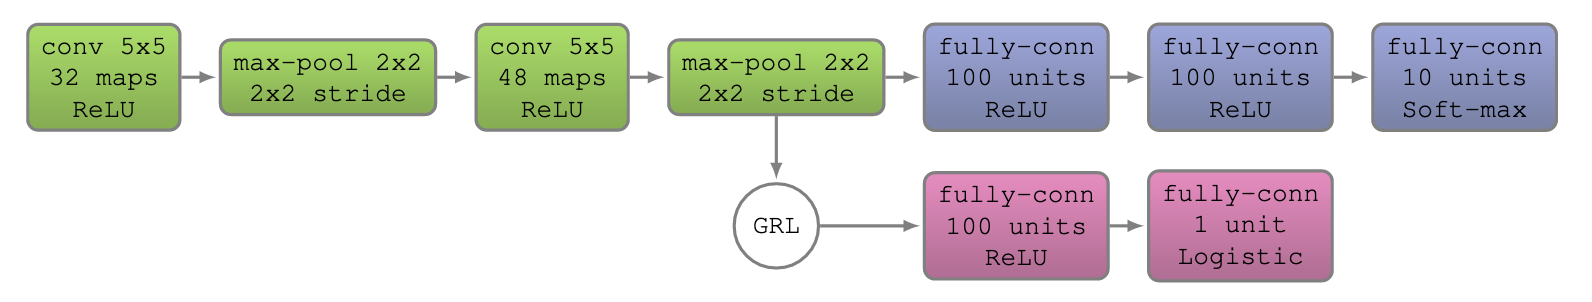

To code a custom backward in PyTorch, you need to define a `torch.autograd.Function`.

The forward is easy, we do nothing except storing a factor that we will need in the backward pass.

In the backward pass we need to return as much gradients as there are inputs (here two). Because the factor is not something to be optimized, we return `None`.

Now, given the factor (which is defaulted to -1, aka "reverse"), define the modified gradient:



In [13]:
class GradientReversal(torch.autograd.Function):
    @staticmethod
    def forward(ctx, x, factor=-1):
        ctx.save_for_backward(torch.tensor(factor))
        return x

    @staticmethod
    def backward(ctx, grad):
        (factor,) = ctx.saved_tensors

        reversed_grad = factor * grad

        return reversed_grad, None

In [14]:
x = torch.tensor([42.0], requires_grad=True)
y = torch.tensor([1337.0], requires_grad=True)
o = x * y
o.backward()
print(x.grad.item())

x = torch.tensor([42.0], requires_grad=True)
y = torch.tensor([1337.0], requires_grad=True)
o = GradientReversal.apply(x * y, -1)
o.backward()
print(x.grad.item())

1337.0
-1337.0


To use a PyTorch's `Function`, call its apply

Now, code the DANN. You can re-use parts of the code you wrote for the naive model.

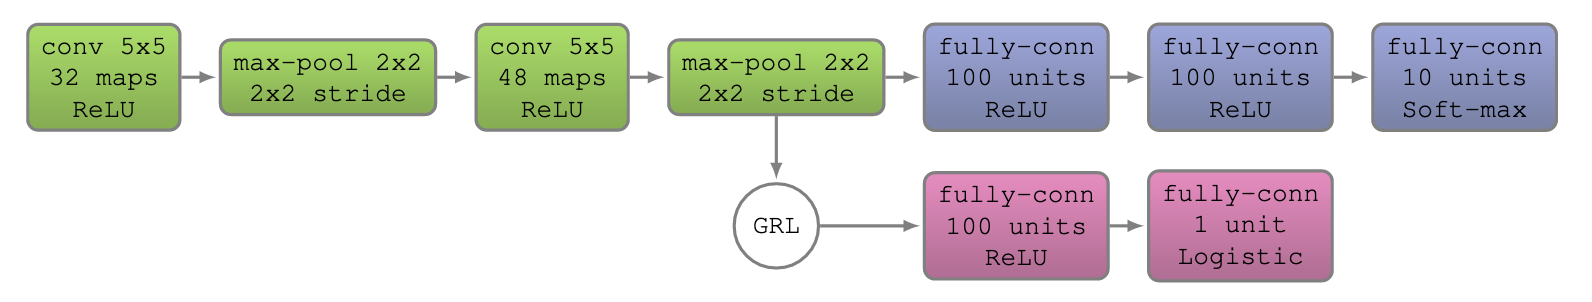

In [15]:
class DANN(nn.Module):
    def __init__(self):
        super().__init__()  # Important, otherwise will throw an error

        self.cnn = nn.Sequential(
            nn.Conv2d(3, 32, kernel_size=5, stride=1, padding=2),  # (32, 28, 28)
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2, padding=0),  # (32, 14, 14)
            nn.Conv2d(32, 48, kernel_size=5, stride=1, padding=2),  # (48, 14, 14)
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2, padding=0),  #  (48, 7, 7)
        )

        self.classif = nn.Sequential(
            nn.Linear(48 * 7 * 7, 100),
            nn.ReLU(),
            nn.Linear(100, 100),
            nn.ReLU(),
            nn.Linear(100, 10),
            # Softmax include in the Cross-Entropy loss
        )

        self.domain = nn.Sequential(
            nn.Linear(48 * 7 * 7, 100), nn.ReLU(inplace=True), nn.Linear(100, 1)
        )

    def forward(self, x, factor=1):
        x = self.cnn(x)
        x = x.flatten(start_dim=1)

        class_pred = self.classif(x)
        domain_pred = self.domain(GradientReversal.apply(x, -1 * factor))

        return class_pred, domain_pred

In [16]:
def eval_dann(net, loader, source=True):
    net.eval()

    c_acc, d_acc, cls_loss, d_loss = 0, 0, 0.0, 0.0
    c = 0
    for x, y in loader:
        x = x.cuda()
        if source:
            d = torch.ones(len(x))
        else:
            d = torch.zeros(len(x))

        c += len(x)

        with torch.no_grad():
            cls_logits, domain_logits = net(x.cuda())
            cls_logits, domain_logits = cls_logits.cpu(), domain_logits.cpu()

        cls_loss += F.cross_entropy(cls_logits, y).item()
        d_loss += F.binary_cross_entropy_with_logits(domain_logits[:, 0], d).item()

        c_acc += (cls_logits.argmax(dim=1) == y).sum().item()
        d_acc += ((torch.sigmoid(domain_logits[:, 0]) > 0.5).float() == d).sum().item()

    return (
        round(100 * c_acc / c, 2),
        round(100 * d_acc / c, 2),
        round(cls_loss / len(loader), 5),
        round(d_loss / len(loader), 5),
    )

In [17]:
source_train_loader = DataLoader(mnist_train, batch_size=64)
target_train_loader = DataLoader(mnistm_train, batch_size=64)

len(source_train_loader), len(target_train_loader)

(938, 938)

For the GRL, using directly a factor -1 will results in very bad performance. Therefore we are going to grow the factor gradually during training (deep learning is an art!).

Here is a plot of the function we will use (note that it is a modified version from the paper):

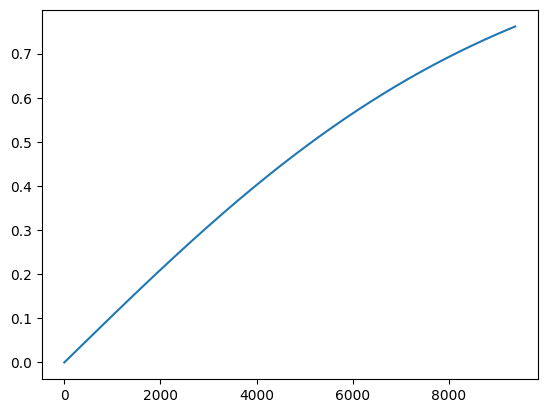

In [18]:
nb_iters = len(source_train_loader) * epochs

x = [i for i in range(nb_iters)]
lmbd = lambda e: -1 + 2 / (1 + math.exp(-2 * e / nb_iters))
y = [lmbd(i) for i in x]

plt.plot(x, y)

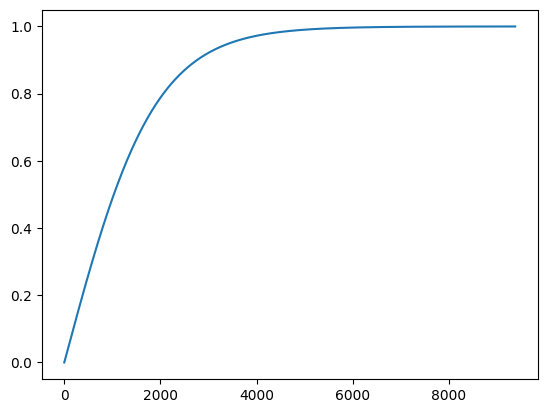

In [19]:
nb_iters = len(source_train_loader) * epochs

x = [i for i in range(nb_iters)]
lmbd = lambda e: -1 + 2 / (1 + math.exp(-10 * e / nb_iters))
y = [lmbd(i) for i in x]

plt.plot(x, y)

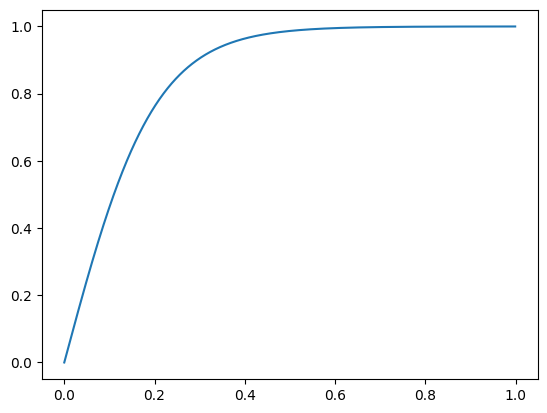

In [20]:
nb_iters = len(source_train_loader) * epochs

x = [i / 1000 for i in range(1000)]
lmbd = lambda p: -1 + 2 / (1 + math.exp(-10 * p))
y = [lmbd(i) for i in x]

plt.plot(x, y)

Let's train our DANN. The GRL factor will be updated after each batch.

Remember that we are not allowed to use the labels of MNIST-M as we assume this dataset is **unlabeled**.

In [21]:
# from tqdm.notebook import tqdm

epochs = 20

dann = DANN().cuda()

optimizer = torch.optim.SGD(dann.parameters(), lr=1.0, momentum=0.9)

mu0, alpha, beta = 0.01, 10, 0.75
scheduler = torch.optim.lr_scheduler.LambdaLR(
    optimizer, lambda e: 0.01 / (1 + alpha * e / epochs) ** beta
)
lmbd = lambda e: -1 + 2 / (1 + math.exp(-10 * e / (len(source_train_loader) * epochs)))

b = 0

total_batches = epochs * len(source_train_loader)
with tqdm(total=total_batches, desc=f"Epoch 1/{epochs}", unit="batch") as pbar:
    for epoch in range(epochs):
        cls_loss, domain_loss = 0.0, 0.0
        grl_factor = lmbd(b)
        # grl_factor = -1
        pbar.set_description(
            f"Epoch [{epoch + 1}/{epochs}], GRL factor [{grl_factor:.3f}]"
        )

        for (xs, ys), (xt, _) in zip(source_train_loader, target_train_loader):
            b += 1

            xs, ys = xs.cuda(), ys.cuda()
            xt = xt.cuda()
            x = torch.cat((xs, xt))

            optimizer.zero_grad()
            cls_logits, domain_logits = dann(x, factor=grl_factor)

            ce = F.cross_entropy(cls_logits[: len(ys)], ys)

            preds = torch.cat((torch.ones(len(xs)), torch.zeros(len(xt)))).cuda()
            bce = F.binary_cross_entropy_with_logits(domain_logits[:, 0], preds)

            loss = ce + bce
            loss.backward()
            optimizer.step()

            cls_loss += ce.item()
            domain_loss += bce.item()

            pbar.update(1)

        cls_loss = round(cls_loss / len(source_train_loader), 5)
        domain_loss = round(domain_loss / (2 * len(source_train_loader)), 5)
        pbar.set_postfix({"class loss": cls_loss, "domain loss": domain_loss})

        scheduler.step()

c_acc, d_acc, c_loss, d_loss = eval_dann(dann, source_test_loader)
print(
    f"[SOURCE] Class loss/acc: {c_loss} / {c_acc}%, Domain loss/acc: {d_loss} / {d_acc}%"
)

c_acc, d_acc, c_loss, d_loss = eval_dann(dann, target_test_loader, source=False)
print(
    f"[TARGET] Class loss/acc: {c_loss} / {c_acc}%, Domain loss/acc: {d_loss} / {d_acc}%"
)

Epoch 1/20:   0%|                                                                                                                                       | 0/18760 [00:00<?, ?batch/s]

Epoch [1/20], GRL factor [0.000]:   0%|                                                                                                                 | 0/18760 [00:00<?, ?batch/s]

Epoch [1/20], GRL factor [0.000]:   0%|                                                                                                         | 4/18760 [00:00<08:42, 35.89batch/s]

Epoch [1/20], GRL factor [0.000]:   0%|                                                                                                        | 11/18760 [00:00<05:55, 52.78batch/s]

Epoch [1/20], GRL factor [0.000]:   0%|                                                                                                        | 18/18760 [00:00<05:20, 58.39batch/s]

Epoch [1/20], GRL factor [0.000]:   0%|▏                                                                                                       | 25/18760 [00:00<05:06, 61.11batch/s]

Epoch [1/20], GRL factor [0.000]:   0%|▏                                                                                                       | 32/18760 [00:00<05:10, 60.40batch/s]

Epoch [1/20], GRL factor [0.000]:   0%|▏                                                                                                       | 39/18760 [00:00<05:35, 55.85batch/s]

Epoch [1/20], GRL factor [0.000]:   0%|▎                                                                                                       | 46/18760 [00:00<05:17, 58.87batch/s]

Epoch [1/20], GRL factor [0.000]:   0%|▎                                                                                                       | 53/18760 [00:00<05:06, 61.01batch/s]

Epoch [1/20], GRL factor [0.000]:   0%|▎                                                                                                       | 60/18760 [00:01<04:59, 62.46batch/s]

Epoch [1/20], GRL factor [0.000]:   0%|▎                                                                                                       | 67/18760 [00:01<04:54, 63.57batch/s]

Epoch [1/20], GRL factor [0.000]:   0%|▍                                                                                                       | 74/18760 [00:01<04:50, 64.39batch/s]

Epoch [1/20], GRL factor [0.000]:   0%|▍                                                                                                       | 81/18760 [00:01<04:47, 64.97batch/s]

Epoch [1/20], GRL factor [0.000]:   0%|▍                                                                                                       | 88/18760 [00:01<04:45, 65.33batch/s]

Epoch [1/20], GRL factor [0.000]:   1%|▌                                                                                                       | 95/18760 [00:01<04:44, 65.64batch/s]

Epoch [1/20], GRL factor [0.000]:   1%|▌                                                                                                      | 102/18760 [00:01<04:43, 65.76batch/s]

Epoch [1/20], GRL factor [0.000]:   1%|▌                                                                                                      | 109/18760 [00:01<04:42, 65.94batch/s]

Epoch [1/20], GRL factor [0.000]:   1%|▋                                                                                                      | 116/18760 [00:01<04:45, 65.34batch/s]

Epoch [1/20], GRL factor [0.000]:   1%|▋                                                                                                      | 123/18760 [00:01<04:44, 65.40batch/s]

Epoch [1/20], GRL factor [0.000]:   1%|▋                                                                                                      | 130/18760 [00:02<04:44, 65.56batch/s]

Epoch [1/20], GRL factor [0.000]:   1%|▊                                                                                                      | 137/18760 [00:02<04:43, 65.78batch/s]

Epoch [1/20], GRL factor [0.000]:   1%|▊                                                                                                      | 144/18760 [00:02<04:42, 65.91batch/s]

Epoch [1/20], GRL factor [0.000]:   1%|▊                                                                                                      | 151/18760 [00:02<04:41, 66.05batch/s]

Epoch [1/20], GRL factor [0.000]:   1%|▊                                                                                                      | 158/18760 [00:02<05:15, 58.95batch/s]

Epoch [1/20], GRL factor [0.000]:   1%|▉                                                                                                      | 165/18760 [00:02<05:43, 54.12batch/s]

Epoch [1/20], GRL factor [0.000]:   1%|▉                                                                                                      | 172/18760 [00:02<05:24, 57.32batch/s]

Epoch [1/20], GRL factor [0.000]:   1%|▉                                                                                                      | 179/18760 [00:02<05:10, 59.76batch/s]

Epoch [1/20], GRL factor [0.000]:   1%|█                                                                                                      | 186/18760 [00:03<05:01, 61.54batch/s]

Epoch [1/20], GRL factor [0.000]:   1%|█                                                                                                      | 193/18760 [00:03<04:55, 62.93batch/s]

Epoch [1/20], GRL factor [0.000]:   1%|█                                                                                                      | 200/18760 [00:03<04:51, 63.64batch/s]

Epoch [1/20], GRL factor [0.000]:   1%|█▏                                                                                                     | 207/18760 [00:03<04:47, 64.45batch/s]

Epoch [1/20], GRL factor [0.000]:   1%|█▏                                                                                                     | 214/18760 [00:03<04:45, 65.04batch/s]

Epoch [1/20], GRL factor [0.000]:   1%|█▏                                                                                                     | 221/18760 [00:03<04:43, 65.45batch/s]

Epoch [1/20], GRL factor [0.000]:   1%|█▎                                                                                                     | 228/18760 [00:03<04:42, 65.70batch/s]

Epoch [1/20], GRL factor [0.000]:   1%|█▎                                                                                                     | 235/18760 [00:03<05:02, 61.25batch/s]

Epoch [1/20], GRL factor [0.000]:   1%|█▎                                                                                                     | 242/18760 [00:03<05:28, 56.44batch/s]

Epoch [1/20], GRL factor [0.000]:   1%|█▎                                                                                                     | 249/18760 [00:04<05:13, 59.06batch/s]

Epoch [1/20], GRL factor [0.000]:   1%|█▍                                                                                                     | 256/18760 [00:04<05:02, 61.09batch/s]

Epoch [1/20], GRL factor [0.000]:   1%|█▍                                                                                                     | 263/18760 [00:04<04:56, 62.43batch/s]

Epoch [1/20], GRL factor [0.000]:   1%|█▍                                                                                                     | 270/18760 [00:04<04:50, 63.59batch/s]

Epoch [1/20], GRL factor [0.000]:   1%|█▌                                                                                                     | 277/18760 [00:04<04:46, 64.48batch/s]

Epoch [1/20], GRL factor [0.000]:   2%|█▌                                                                                                     | 284/18760 [00:04<04:43, 65.07batch/s]

Epoch [1/20], GRL factor [0.000]:   2%|█▌                                                                                                     | 291/18760 [00:04<04:42, 65.49batch/s]

Epoch [1/20], GRL factor [0.000]:   2%|█▋                                                                                                     | 298/18760 [00:04<05:03, 60.83batch/s]

Epoch [1/20], GRL factor [0.000]:   2%|█▋                                                                                                     | 305/18760 [00:04<05:24, 56.90batch/s]

Epoch [1/20], GRL factor [0.000]:   2%|█▋                                                                                                     | 312/18760 [00:05<05:11, 59.27batch/s]

Epoch [1/20], GRL factor [0.000]:   2%|█▊                                                                                                     | 319/18760 [00:05<05:53, 52.18batch/s]

Epoch [1/20], GRL factor [0.000]:   2%|█▊                                                                                                     | 325/18760 [00:05<06:12, 49.54batch/s]

Epoch [1/20], GRL factor [0.000]:   2%|█▊                                                                                                     | 331/18760 [00:05<06:11, 49.65batch/s]

Epoch [1/20], GRL factor [0.000]:   2%|█▊                                                                                                     | 338/18760 [00:05<05:41, 53.94batch/s]

Epoch [1/20], GRL factor [0.000]:   2%|█▉                                                                                                     | 345/18760 [00:05<05:21, 57.27batch/s]

Epoch [1/20], GRL factor [0.000]:   2%|█▉                                                                                                     | 352/18760 [00:05<05:07, 59.83batch/s]

Epoch [1/20], GRL factor [0.000]:   2%|█▉                                                                                                     | 359/18760 [00:05<04:58, 61.63batch/s]

Epoch [1/20], GRL factor [0.000]:   2%|██                                                                                                     | 366/18760 [00:06<05:57, 51.44batch/s]

Epoch [1/20], GRL factor [0.000]:   2%|██                                                                                                     | 373/18760 [00:06<05:32, 55.23batch/s]

Epoch [1/20], GRL factor [0.000]:   2%|██                                                                                                     | 380/18760 [00:06<05:15, 58.17batch/s]

Epoch [1/20], GRL factor [0.000]:   2%|██                                                                                                     | 387/18760 [00:06<05:04, 60.38batch/s]

Epoch [1/20], GRL factor [0.000]:   2%|██▏                                                                                                    | 394/18760 [00:06<04:55, 62.07batch/s]

Epoch [1/20], GRL factor [0.000]:   2%|██▏                                                                                                    | 401/18760 [00:06<04:50, 63.27batch/s]

Epoch [1/20], GRL factor [0.000]:   2%|██▏                                                                                                    | 408/18760 [00:06<04:46, 64.12batch/s]

Epoch [1/20], GRL factor [0.000]:   2%|██▎                                                                                                    | 415/18760 [00:06<04:43, 64.75batch/s]

Epoch [1/20], GRL factor [0.000]:   2%|██▎                                                                                                    | 422/18760 [00:06<04:41, 65.14batch/s]

Epoch [1/20], GRL factor [0.000]:   2%|██▎                                                                                                    | 429/18760 [00:07<04:40, 65.45batch/s]

Epoch [1/20], GRL factor [0.000]:   2%|██▍                                                                                                    | 436/18760 [00:07<04:38, 65.70batch/s]

Epoch [1/20], GRL factor [0.000]:   2%|██▍                                                                                                    | 443/18760 [00:07<04:38, 65.83batch/s]

Epoch [1/20], GRL factor [0.000]:   2%|██▍                                                                                                    | 450/18760 [00:07<04:37, 65.98batch/s]

Epoch [1/20], GRL factor [0.000]:   2%|██▌                                                                                                    | 457/18760 [00:07<04:36, 66.12batch/s]

Epoch [1/20], GRL factor [0.000]:   2%|██▌                                                                                                    | 464/18760 [00:07<04:36, 66.22batch/s]

Epoch [1/20], GRL factor [0.000]:   3%|██▌                                                                                                    | 471/18760 [00:07<04:35, 66.28batch/s]

Epoch [1/20], GRL factor [0.000]:   3%|██▌                                                                                                    | 478/18760 [00:07<04:35, 66.25batch/s]

Epoch [1/20], GRL factor [0.000]:   3%|██▋                                                                                                    | 485/18760 [00:07<04:36, 66.10batch/s]

Epoch [1/20], GRL factor [0.000]:   3%|██▋                                                                                                    | 492/18760 [00:07<04:36, 66.12batch/s]

Epoch [1/20], GRL factor [0.000]:   3%|██▋                                                                                                    | 499/18760 [00:08<04:36, 66.13batch/s]

Epoch [1/20], GRL factor [0.000]:   3%|██▊                                                                                                    | 506/18760 [00:08<04:35, 66.18batch/s]

Epoch [1/20], GRL factor [0.000]:   3%|██▊                                                                                                    | 513/18760 [00:08<04:36, 66.03batch/s]

Epoch [1/20], GRL factor [0.000]:   3%|██▊                                                                                                    | 520/18760 [00:08<04:50, 62.82batch/s]

Epoch [1/20], GRL factor [0.000]:   3%|██▉                                                                                                    | 527/18760 [00:08<04:46, 63.70batch/s]

Epoch [1/20], GRL factor [0.000]:   3%|██▉                                                                                                    | 534/18760 [00:08<04:42, 64.48batch/s]

Epoch [1/20], GRL factor [0.000]:   3%|██▉                                                                                                    | 541/18760 [00:08<04:40, 65.05batch/s]

Epoch [1/20], GRL factor [0.000]:   3%|███                                                                                                    | 548/18760 [00:08<04:38, 65.45batch/s]

Epoch [1/20], GRL factor [0.000]:   3%|███                                                                                                    | 555/18760 [00:08<04:37, 65.65batch/s]

Epoch [1/20], GRL factor [0.000]:   3%|███                                                                                                    | 562/18760 [00:09<04:36, 65.79batch/s]

Epoch [1/20], GRL factor [0.000]:   3%|███                                                                                                    | 569/18760 [00:09<04:45, 63.78batch/s]

Epoch [1/20], GRL factor [0.000]:   3%|███▏                                                                                                   | 576/18760 [00:09<04:41, 64.49batch/s]

Epoch [1/20], GRL factor [0.000]:   3%|███▏                                                                                                   | 583/18760 [00:09<04:39, 65.05batch/s]

Epoch [1/20], GRL factor [0.000]:   3%|███▏                                                                                                   | 590/18760 [00:09<04:37, 65.45batch/s]

Epoch [1/20], GRL factor [0.000]:   3%|███▎                                                                                                   | 597/18760 [00:09<04:36, 65.73batch/s]

Epoch [1/20], GRL factor [0.000]:   3%|███▎                                                                                                   | 604/18760 [00:09<04:35, 65.95batch/s]

Epoch [1/20], GRL factor [0.000]:   3%|███▎                                                                                                   | 611/18760 [00:09<04:34, 66.07batch/s]

Epoch [1/20], GRL factor [0.000]:   3%|███▍                                                                                                   | 618/18760 [00:09<04:34, 66.12batch/s]

Epoch [1/20], GRL factor [0.000]:   3%|███▍                                                                                                   | 625/18760 [00:10<04:33, 66.22batch/s]

Epoch [1/20], GRL factor [0.000]:   3%|███▍                                                                                                   | 632/18760 [00:10<05:17, 57.09batch/s]

Epoch [1/20], GRL factor [0.000]:   3%|███▌                                                                                                   | 638/18760 [00:10<05:14, 57.56batch/s]

Epoch [1/20], GRL factor [0.000]:   3%|███▌                                                                                                   | 645/18760 [00:10<05:03, 59.66batch/s]

Epoch [1/20], GRL factor [0.000]:   3%|███▌                                                                                                   | 652/18760 [00:10<04:55, 61.21batch/s]

Epoch [1/20], GRL factor [0.000]:   4%|███▌                                                                                                   | 659/18760 [00:10<04:50, 62.34batch/s]

Epoch [1/20], GRL factor [0.000]:   4%|███▋                                                                                                   | 666/18760 [00:10<05:06, 58.97batch/s]

Epoch [1/20], GRL factor [0.000]:   4%|███▋                                                                                                   | 672/18760 [00:10<05:06, 59.10batch/s]

Epoch [1/20], GRL factor [0.000]:   4%|███▋                                                                                                   | 678/18760 [00:10<05:47, 52.02batch/s]

Epoch [1/20], GRL factor [0.000]:   4%|███▊                                                                                                   | 684/18760 [00:11<05:45, 52.37batch/s]

Epoch [1/20], GRL factor [0.000]:   4%|███▊                                                                                                   | 691/18760 [00:11<05:21, 56.22batch/s]

Epoch [1/20], GRL factor [0.000]:   4%|███▊                                                                                                   | 698/18760 [00:11<05:05, 59.09batch/s]

Epoch [1/20], GRL factor [0.000]:   4%|███▊                                                                                                   | 705/18760 [00:11<04:54, 61.23batch/s]

Epoch [1/20], GRL factor [0.000]:   4%|███▉                                                                                                   | 712/18760 [00:11<04:47, 62.74batch/s]

Epoch [1/20], GRL factor [0.000]:   4%|███▉                                                                                                   | 719/18760 [00:11<04:44, 63.35batch/s]

Epoch [1/20], GRL factor [0.000]:   4%|███▉                                                                                                   | 726/18760 [00:11<04:41, 64.11batch/s]

Epoch [1/20], GRL factor [0.000]:   4%|████                                                                                                   | 733/18760 [00:11<04:38, 64.79batch/s]

Epoch [1/20], GRL factor [0.000]:   4%|████                                                                                                   | 740/18760 [00:11<04:36, 65.29batch/s]

Epoch [1/20], GRL factor [0.000]:   4%|████                                                                                                   | 747/18760 [00:12<05:21, 56.05batch/s]

Epoch [1/20], GRL factor [0.000]:   4%|████▏                                                                                                  | 753/18760 [00:12<06:00, 49.93batch/s]

Epoch [1/20], GRL factor [0.000]:   4%|████▏                                                                                                  | 759/18760 [00:12<06:48, 44.08batch/s]

Epoch [1/20], GRL factor [0.000]:   4%|████▏                                                                                                  | 764/18760 [00:12<06:42, 44.72batch/s]

Epoch [1/20], GRL factor [0.000]:   4%|████▏                                                                                                  | 771/18760 [00:12<05:58, 50.20batch/s]

Epoch [1/20], GRL factor [0.000]:   4%|████▎                                                                                                  | 778/18760 [00:12<05:30, 54.47batch/s]

Epoch [1/20], GRL factor [0.000]:   4%|████▎                                                                                                  | 785/18760 [00:12<05:11, 57.68batch/s]

Epoch [1/20], GRL factor [0.000]:   4%|████▎                                                                                                  | 792/18760 [00:12<04:59, 60.00batch/s]

Epoch [1/20], GRL factor [0.000]:   4%|████▍                                                                                                  | 799/18760 [00:13<04:50, 61.77batch/s]

Epoch [1/20], GRL factor [0.000]:   4%|████▍                                                                                                  | 806/18760 [00:13<04:44, 63.06batch/s]

Epoch [1/20], GRL factor [0.000]:   4%|████▍                                                                                                  | 813/18760 [00:13<04:40, 64.04batch/s]

Epoch [1/20], GRL factor [0.000]:   4%|████▌                                                                                                  | 820/18760 [00:13<05:09, 57.94batch/s]

Epoch [1/20], GRL factor [0.000]:   4%|████▌                                                                                                  | 826/18760 [00:13<05:15, 56.76batch/s]

Epoch [1/20], GRL factor [0.000]:   4%|████▌                                                                                                  | 833/18760 [00:13<05:03, 59.14batch/s]

Epoch [1/20], GRL factor [0.000]:   4%|████▌                                                                                                  | 840/18760 [00:13<04:54, 60.81batch/s]

Epoch [1/20], GRL factor [0.000]:   5%|████▋                                                                                                  | 847/18760 [00:13<04:49, 61.97batch/s]

Epoch [1/20], GRL factor [0.000]:   5%|████▋                                                                                                  | 854/18760 [00:13<04:45, 62.82batch/s]

Epoch [1/20], GRL factor [0.000]:   5%|████▋                                                                                                  | 861/18760 [00:14<04:42, 63.45batch/s]

Epoch [1/20], GRL factor [0.000]:   5%|████▊                                                                                                  | 868/18760 [00:14<04:39, 63.93batch/s]

Epoch [1/20], GRL factor [0.000]:   5%|████▊                                                                                                  | 875/18760 [00:14<04:38, 64.25batch/s]

Epoch [1/20], GRL factor [0.000]:   5%|████▊                                                                                                  | 882/18760 [00:14<04:46, 62.49batch/s]

Epoch [1/20], GRL factor [0.000]:   5%|████▉                                                                                                  | 889/18760 [00:14<05:28, 54.47batch/s]

Epoch [1/20], GRL factor [0.000]:   5%|████▉                                                                                                  | 895/18760 [00:14<06:01, 49.41batch/s]

Epoch [1/20], GRL factor [0.000]:   5%|████▉                                                                                                  | 901/18760 [00:14<05:45, 51.64batch/s]

Epoch [1/20], GRL factor [0.000]:   5%|████▉                                                                                                  | 907/18760 [00:14<05:34, 53.37batch/s]

Epoch [1/20], GRL factor [0.000]:   5%|█████                                                                                                  | 914/18760 [00:15<05:13, 56.90batch/s]

Epoch [1/20], GRL factor [0.000]:   5%|█████                                                                                                  | 921/18760 [00:15<04:59, 59.50batch/s]

Epoch [1/20], GRL factor [0.000]:   5%|█████                                                                                                  | 928/18760 [00:15<04:50, 61.43batch/s]

Epoch [1/20], GRL factor [0.000]:   5%|█████▏                                                                                                 | 935/18760 [00:15<04:43, 62.88batch/s]

Epoch [1/20], GRL factor [0.000]:   5%|███▎                                                              | 938/18760 [00:15<04:43, 62.88batch/s, class loss=0.23, domain loss=0.0385]

Epoch [2/20], GRL factor [0.245]:   5%|███▎                                                              | 938/18760 [00:15<04:43, 62.88batch/s, class loss=0.23, domain loss=0.0385]

Epoch [2/20], GRL factor [0.245]:   5%|███▎                                                              | 942/18760 [00:15<04:41, 63.38batch/s, class loss=0.23, domain loss=0.0385]

Epoch [2/20], GRL factor [0.245]:   5%|███▎                                                              | 949/18760 [00:15<04:37, 64.19batch/s, class loss=0.23, domain loss=0.0385]

Epoch [2/20], GRL factor [0.245]:   5%|███▎                                                              | 956/18760 [00:15<04:59, 59.52batch/s, class loss=0.23, domain loss=0.0385]

Epoch [2/20], GRL factor [0.245]:   5%|███▍                                                              | 963/18760 [00:15<05:15, 56.48batch/s, class loss=0.23, domain loss=0.0385]

Epoch [2/20], GRL factor [0.245]:   5%|███▍                                                              | 970/18760 [00:15<05:01, 59.05batch/s, class loss=0.23, domain loss=0.0385]

Epoch [2/20], GRL factor [0.245]:   5%|███▍                                                              | 977/18760 [00:16<04:51, 61.08batch/s, class loss=0.23, domain loss=0.0385]

Epoch [2/20], GRL factor [0.245]:   5%|███▍                                                              | 984/18760 [00:16<04:44, 62.58batch/s, class loss=0.23, domain loss=0.0385]

Epoch [2/20], GRL factor [0.245]:   5%|███▍                                                              | 991/18760 [00:16<04:39, 63.65batch/s, class loss=0.23, domain loss=0.0385]

Epoch [2/20], GRL factor [0.245]:   5%|███▌                                                              | 998/18760 [00:16<04:35, 64.41batch/s, class loss=0.23, domain loss=0.0385]

Epoch [2/20], GRL factor [0.245]:   5%|███▍                                                             | 1005/18760 [00:16<04:33, 64.98batch/s, class loss=0.23, domain loss=0.0385]

Epoch [2/20], GRL factor [0.245]:   5%|███▌                                                             | 1012/18760 [00:16<04:31, 65.37batch/s, class loss=0.23, domain loss=0.0385]

Epoch [2/20], GRL factor [0.245]:   5%|███▌                                                             | 1019/18760 [00:16<04:30, 65.68batch/s, class loss=0.23, domain loss=0.0385]

Epoch [2/20], GRL factor [0.245]:   5%|███▌                                                             | 1026/18760 [00:16<04:29, 65.86batch/s, class loss=0.23, domain loss=0.0385]

Epoch [2/20], GRL factor [0.245]:   6%|███▌                                                             | 1033/18760 [00:16<04:28, 65.97batch/s, class loss=0.23, domain loss=0.0385]

Epoch [2/20], GRL factor [0.245]:   6%|███▌                                                             | 1040/18760 [00:17<04:28, 66.01batch/s, class loss=0.23, domain loss=0.0385]

Epoch [2/20], GRL factor [0.245]:   6%|███▋                                                             | 1047/18760 [00:17<04:27, 66.12batch/s, class loss=0.23, domain loss=0.0385]

Epoch [2/20], GRL factor [0.245]:   6%|███▋                                                             | 1054/18760 [00:17<04:27, 66.19batch/s, class loss=0.23, domain loss=0.0385]

Epoch [2/20], GRL factor [0.245]:   6%|███▋                                                             | 1061/18760 [00:17<04:57, 59.41batch/s, class loss=0.23, domain loss=0.0385]

Epoch [2/20], GRL factor [0.245]:   6%|███▋                                                             | 1068/18760 [00:17<05:25, 54.40batch/s, class loss=0.23, domain loss=0.0385]

Epoch [2/20], GRL factor [0.245]:   6%|███▋                                                             | 1075/18760 [00:17<05:07, 57.48batch/s, class loss=0.23, domain loss=0.0385]

Epoch [2/20], GRL factor [0.245]:   6%|███▋                                                             | 1082/18760 [00:17<04:55, 59.85batch/s, class loss=0.23, domain loss=0.0385]

Epoch [2/20], GRL factor [0.245]:   6%|███▊                                                             | 1089/18760 [00:17<04:46, 61.60batch/s, class loss=0.23, domain loss=0.0385]

Epoch [2/20], GRL factor [0.245]:   6%|███▊                                                             | 1096/18760 [00:17<04:40, 62.90batch/s, class loss=0.23, domain loss=0.0385]

Epoch [2/20], GRL factor [0.245]:   6%|███▊                                                             | 1103/18760 [00:18<04:36, 63.86batch/s, class loss=0.23, domain loss=0.0385]

Epoch [2/20], GRL factor [0.245]:   6%|███▊                                                             | 1110/18760 [00:18<04:47, 61.34batch/s, class loss=0.23, domain loss=0.0385]

Epoch [2/20], GRL factor [0.245]:   6%|███▊                                                             | 1117/18760 [00:18<05:14, 56.11batch/s, class loss=0.23, domain loss=0.0385]

Epoch [2/20], GRL factor [0.245]:   6%|███▉                                                             | 1124/18760 [00:18<05:00, 58.74batch/s, class loss=0.23, domain loss=0.0385]

Epoch [2/20], GRL factor [0.245]:   6%|███▉                                                             | 1131/18760 [00:18<04:50, 60.78batch/s, class loss=0.23, domain loss=0.0385]

Epoch [2/20], GRL factor [0.245]:   6%|███▉                                                             | 1138/18760 [00:18<04:42, 62.33batch/s, class loss=0.23, domain loss=0.0385]

Epoch [2/20], GRL factor [0.245]:   6%|███▉                                                             | 1145/18760 [00:18<04:37, 63.43batch/s, class loss=0.23, domain loss=0.0385]

Epoch [2/20], GRL factor [0.245]:   6%|███▉                                                             | 1152/18760 [00:18<04:34, 64.21batch/s, class loss=0.23, domain loss=0.0385]

Epoch [2/20], GRL factor [0.245]:   6%|████                                                             | 1159/18760 [00:18<04:33, 64.40batch/s, class loss=0.23, domain loss=0.0385]

Epoch [2/20], GRL factor [0.245]:   6%|████                                                             | 1166/18760 [00:19<04:31, 64.90batch/s, class loss=0.23, domain loss=0.0385]

Epoch [2/20], GRL factor [0.245]:   6%|████                                                             | 1173/18760 [00:19<04:29, 65.25batch/s, class loss=0.23, domain loss=0.0385]

Epoch [2/20], GRL factor [0.245]:   6%|████                                                             | 1180/18760 [00:19<04:28, 65.50batch/s, class loss=0.23, domain loss=0.0385]

Epoch [2/20], GRL factor [0.245]:   6%|████                                                             | 1187/18760 [00:19<04:27, 65.71batch/s, class loss=0.23, domain loss=0.0385]

Epoch [2/20], GRL factor [0.245]:   6%|████▏                                                            | 1194/18760 [00:19<04:26, 65.84batch/s, class loss=0.23, domain loss=0.0385]

Epoch [2/20], GRL factor [0.245]:   6%|████▏                                                            | 1201/18760 [00:19<04:26, 65.97batch/s, class loss=0.23, domain loss=0.0385]

Epoch [2/20], GRL factor [0.245]:   6%|████▏                                                            | 1208/18760 [00:19<04:25, 66.07batch/s, class loss=0.23, domain loss=0.0385]

Epoch [2/20], GRL factor [0.245]:   6%|████▏                                                            | 1215/18760 [00:19<04:25, 66.10batch/s, class loss=0.23, domain loss=0.0385]

Epoch [2/20], GRL factor [0.245]:   7%|████▏                                                            | 1222/18760 [00:19<04:25, 66.08batch/s, class loss=0.23, domain loss=0.0385]

Epoch [2/20], GRL factor [0.245]:   7%|████▎                                                            | 1229/18760 [00:20<04:25, 66.10batch/s, class loss=0.23, domain loss=0.0385]

Epoch [2/20], GRL factor [0.245]:   7%|████▎                                                            | 1236/18760 [00:20<04:24, 66.17batch/s, class loss=0.23, domain loss=0.0385]

Epoch [2/20], GRL factor [0.245]:   7%|████▎                                                            | 1243/18760 [00:20<04:24, 66.25batch/s, class loss=0.23, domain loss=0.0385]

Epoch [2/20], GRL factor [0.245]:   7%|████▎                                                            | 1250/18760 [00:20<04:24, 66.28batch/s, class loss=0.23, domain loss=0.0385]

Epoch [2/20], GRL factor [0.245]:   7%|████▎                                                            | 1257/18760 [00:20<04:23, 66.30batch/s, class loss=0.23, domain loss=0.0385]

Epoch [2/20], GRL factor [0.245]:   7%|████▍                                                            | 1264/18760 [00:20<04:23, 66.34batch/s, class loss=0.23, domain loss=0.0385]

Epoch [2/20], GRL factor [0.245]:   7%|████▍                                                            | 1271/18760 [00:20<04:23, 66.37batch/s, class loss=0.23, domain loss=0.0385]

Epoch [2/20], GRL factor [0.245]:   7%|████▍                                                            | 1278/18760 [00:20<04:23, 66.37batch/s, class loss=0.23, domain loss=0.0385]

Epoch [2/20], GRL factor [0.245]:   7%|████▍                                                            | 1285/18760 [00:20<04:47, 60.88batch/s, class loss=0.23, domain loss=0.0385]

Epoch [2/20], GRL factor [0.245]:   7%|████▍                                                            | 1292/18760 [00:21<05:09, 56.52batch/s, class loss=0.23, domain loss=0.0385]

Epoch [2/20], GRL factor [0.245]:   7%|████▌                                                            | 1299/18760 [00:21<04:55, 59.15batch/s, class loss=0.23, domain loss=0.0385]

Epoch [2/20], GRL factor [0.245]:   7%|████▌                                                            | 1306/18760 [00:21<04:45, 61.14batch/s, class loss=0.23, domain loss=0.0385]

Epoch [2/20], GRL factor [0.245]:   7%|████▌                                                            | 1313/18760 [00:21<04:38, 62.54batch/s, class loss=0.23, domain loss=0.0385]

Epoch [2/20], GRL factor [0.245]:   7%|████▌                                                            | 1320/18760 [00:21<04:37, 62.75batch/s, class loss=0.23, domain loss=0.0385]

Epoch [2/20], GRL factor [0.245]:   7%|████▌                                                            | 1327/18760 [00:21<04:33, 63.73batch/s, class loss=0.23, domain loss=0.0385]

Epoch [2/20], GRL factor [0.245]:   7%|████▌                                                            | 1334/18760 [00:21<04:30, 64.52batch/s, class loss=0.23, domain loss=0.0385]

Epoch [2/20], GRL factor [0.245]:   7%|████▋                                                            | 1341/18760 [00:21<04:27, 65.12batch/s, class loss=0.23, domain loss=0.0385]

Epoch [2/20], GRL factor [0.245]:   7%|████▋                                                            | 1348/18760 [00:21<04:26, 65.43batch/s, class loss=0.23, domain loss=0.0385]

Epoch [2/20], GRL factor [0.245]:   7%|████▋                                                            | 1355/18760 [00:22<04:25, 65.58batch/s, class loss=0.23, domain loss=0.0385]

Epoch [2/20], GRL factor [0.245]:   7%|████▋                                                            | 1362/18760 [00:22<04:24, 65.80batch/s, class loss=0.23, domain loss=0.0385]

Epoch [2/20], GRL factor [0.245]:   7%|████▋                                                            | 1369/18760 [00:22<04:23, 65.92batch/s, class loss=0.23, domain loss=0.0385]

Epoch [2/20], GRL factor [0.245]:   7%|████▊                                                            | 1376/18760 [00:22<05:24, 53.60batch/s, class loss=0.23, domain loss=0.0385]

Epoch [2/20], GRL factor [0.245]:   7%|████▊                                                            | 1383/18760 [00:22<05:06, 56.70batch/s, class loss=0.23, domain loss=0.0385]

Epoch [2/20], GRL factor [0.245]:   7%|████▊                                                            | 1390/18760 [00:22<04:52, 59.28batch/s, class loss=0.23, domain loss=0.0385]

Epoch [2/20], GRL factor [0.245]:   7%|████▊                                                            | 1397/18760 [00:22<04:43, 61.26batch/s, class loss=0.23, domain loss=0.0385]

Epoch [2/20], GRL factor [0.245]:   7%|████▊                                                            | 1404/18760 [00:22<04:36, 62.70batch/s, class loss=0.23, domain loss=0.0385]

Epoch [2/20], GRL factor [0.245]:   8%|████▉                                                            | 1411/18760 [00:22<04:32, 63.74batch/s, class loss=0.23, domain loss=0.0385]

Epoch [2/20], GRL factor [0.245]:   8%|████▉                                                            | 1418/18760 [00:23<04:29, 64.47batch/s, class loss=0.23, domain loss=0.0385]

Epoch [2/20], GRL factor [0.245]:   8%|████▉                                                            | 1425/18760 [00:23<04:26, 65.04batch/s, class loss=0.23, domain loss=0.0385]

Epoch [2/20], GRL factor [0.245]:   8%|████▉                                                            | 1432/18760 [00:23<04:25, 65.37batch/s, class loss=0.23, domain loss=0.0385]

Epoch [2/20], GRL factor [0.245]:   8%|████▉                                                            | 1439/18760 [00:23<04:23, 65.66batch/s, class loss=0.23, domain loss=0.0385]

Epoch [2/20], GRL factor [0.245]:   8%|█████                                                            | 1446/18760 [00:23<04:22, 65.89batch/s, class loss=0.23, domain loss=0.0385]

Epoch [2/20], GRL factor [0.245]:   8%|█████                                                            | 1453/18760 [00:23<04:22, 66.05batch/s, class loss=0.23, domain loss=0.0385]

Epoch [2/20], GRL factor [0.245]:   8%|█████                                                            | 1460/18760 [00:23<04:21, 66.16batch/s, class loss=0.23, domain loss=0.0385]

Epoch [2/20], GRL factor [0.245]:   8%|█████                                                            | 1467/18760 [00:23<05:22, 53.69batch/s, class loss=0.23, domain loss=0.0385]

Epoch [2/20], GRL factor [0.245]:   8%|█████                                                            | 1474/18760 [00:23<05:07, 56.26batch/s, class loss=0.23, domain loss=0.0385]

Epoch [2/20], GRL factor [0.245]:   8%|█████▏                                                           | 1481/18760 [00:24<04:53, 58.94batch/s, class loss=0.23, domain loss=0.0385]

Epoch [2/20], GRL factor [0.245]:   8%|█████▏                                                           | 1488/18760 [00:24<04:43, 60.96batch/s, class loss=0.23, domain loss=0.0385]

Epoch [2/20], GRL factor [0.245]:   8%|█████▏                                                           | 1495/18760 [00:24<04:36, 62.52batch/s, class loss=0.23, domain loss=0.0385]

Epoch [2/20], GRL factor [0.245]:   8%|█████▏                                                           | 1502/18760 [00:24<05:14, 54.91batch/s, class loss=0.23, domain loss=0.0385]

Epoch [2/20], GRL factor [0.245]:   8%|█████▏                                                           | 1508/18760 [00:24<05:18, 54.13batch/s, class loss=0.23, domain loss=0.0385]

Epoch [2/20], GRL factor [0.245]:   8%|█████▏                                                           | 1515/18760 [00:24<05:01, 57.23batch/s, class loss=0.23, domain loss=0.0385]

Epoch [2/20], GRL factor [0.245]:   8%|█████▎                                                           | 1522/18760 [00:24<04:50, 59.35batch/s, class loss=0.23, domain loss=0.0385]

Epoch [2/20], GRL factor [0.245]:   8%|█████▎                                                           | 1529/18760 [00:24<05:03, 56.69batch/s, class loss=0.23, domain loss=0.0385]

Epoch [2/20], GRL factor [0.245]:   8%|█████▎                                                           | 1536/18760 [00:25<04:50, 59.28batch/s, class loss=0.23, domain loss=0.0385]

Epoch [2/20], GRL factor [0.245]:   8%|█████▎                                                           | 1543/18760 [00:25<04:41, 61.25batch/s, class loss=0.23, domain loss=0.0385]

Epoch [2/20], GRL factor [0.245]:   8%|█████▎                                                           | 1550/18760 [00:25<04:34, 62.71batch/s, class loss=0.23, domain loss=0.0385]

Epoch [2/20], GRL factor [0.245]:   8%|█████▍                                                           | 1557/18760 [00:25<04:29, 63.74batch/s, class loss=0.23, domain loss=0.0385]

Epoch [2/20], GRL factor [0.245]:   8%|█████▍                                                           | 1564/18760 [00:25<04:26, 64.50batch/s, class loss=0.23, domain loss=0.0385]

Epoch [2/20], GRL factor [0.245]:   8%|█████▍                                                           | 1571/18760 [00:25<04:55, 58.24batch/s, class loss=0.23, domain loss=0.0385]

Epoch [2/20], GRL factor [0.245]:   8%|█████▍                                                           | 1578/18760 [00:25<04:45, 60.23batch/s, class loss=0.23, domain loss=0.0385]

Epoch [2/20], GRL factor [0.245]:   8%|█████▍                                                           | 1585/18760 [00:25<04:37, 61.94batch/s, class loss=0.23, domain loss=0.0385]

Epoch [2/20], GRL factor [0.245]:   8%|█████▌                                                           | 1592/18760 [00:25<04:31, 63.17batch/s, class loss=0.23, domain loss=0.0385]

Epoch [2/20], GRL factor [0.245]:   9%|█████▌                                                           | 1599/18760 [00:26<04:28, 64.01batch/s, class loss=0.23, domain loss=0.0385]

Epoch [2/20], GRL factor [0.245]:   9%|█████▌                                                           | 1606/18760 [00:26<04:25, 64.69batch/s, class loss=0.23, domain loss=0.0385]

Epoch [2/20], GRL factor [0.245]:   9%|█████▌                                                           | 1613/18760 [00:26<04:23, 65.15batch/s, class loss=0.23, domain loss=0.0385]

Epoch [2/20], GRL factor [0.245]:   9%|█████▌                                                           | 1620/18760 [00:26<05:06, 55.90batch/s, class loss=0.23, domain loss=0.0385]

Epoch [2/20], GRL factor [0.245]:   9%|█████▋                                                           | 1626/18760 [00:26<05:44, 49.79batch/s, class loss=0.23, domain loss=0.0385]

Epoch [2/20], GRL factor [0.245]:   9%|█████▋                                                           | 1632/18760 [00:26<05:40, 50.32batch/s, class loss=0.23, domain loss=0.0385]

Epoch [2/20], GRL factor [0.245]:   9%|█████▋                                                           | 1639/18760 [00:26<05:14, 54.48batch/s, class loss=0.23, domain loss=0.0385]

Epoch [2/20], GRL factor [0.245]:   9%|█████▋                                                           | 1646/18760 [00:26<04:56, 57.68batch/s, class loss=0.23, domain loss=0.0385]

Epoch [2/20], GRL factor [0.245]:   9%|█████▋                                                           | 1652/18760 [00:26<04:56, 57.64batch/s, class loss=0.23, domain loss=0.0385]

Epoch [2/20], GRL factor [0.245]:   9%|█████▋                                                           | 1658/18760 [00:27<05:23, 52.85batch/s, class loss=0.23, domain loss=0.0385]

Epoch [2/20], GRL factor [0.245]:   9%|█████▊                                                           | 1665/18760 [00:27<05:02, 56.46batch/s, class loss=0.23, domain loss=0.0385]

Epoch [2/20], GRL factor [0.245]:   9%|█████▊                                                           | 1672/18760 [00:27<04:48, 59.20batch/s, class loss=0.23, domain loss=0.0385]

Epoch [2/20], GRL factor [0.245]:   9%|█████▊                                                           | 1679/18760 [00:27<04:39, 61.18batch/s, class loss=0.23, domain loss=0.0385]

Epoch [2/20], GRL factor [0.245]:   9%|█████▊                                                           | 1686/18760 [00:27<04:32, 62.67batch/s, class loss=0.23, domain loss=0.0385]

Epoch [2/20], GRL factor [0.245]:   9%|█████▊                                                           | 1693/18760 [00:27<04:27, 63.76batch/s, class loss=0.23, domain loss=0.0385]

Epoch [2/20], GRL factor [0.245]:   9%|█████▉                                                           | 1700/18760 [00:27<04:48, 59.22batch/s, class loss=0.23, domain loss=0.0385]

Epoch [2/20], GRL factor [0.245]:   9%|█████▉                                                           | 1707/18760 [00:27<05:12, 54.62batch/s, class loss=0.23, domain loss=0.0385]

Epoch [2/20], GRL factor [0.245]:   9%|█████▉                                                           | 1714/18760 [00:28<04:57, 57.31batch/s, class loss=0.23, domain loss=0.0385]

Epoch [2/20], GRL factor [0.245]:   9%|█████▉                                                           | 1721/18760 [00:28<04:45, 59.72batch/s, class loss=0.23, domain loss=0.0385]

Epoch [2/20], GRL factor [0.245]:   9%|█████▉                                                           | 1728/18760 [00:28<04:43, 60.05batch/s, class loss=0.23, domain loss=0.0385]

Epoch [2/20], GRL factor [0.245]:   9%|██████                                                           | 1735/18760 [00:28<05:28, 51.78batch/s, class loss=0.23, domain loss=0.0385]

Epoch [2/20], GRL factor [0.245]:   9%|██████                                                           | 1742/18760 [00:28<05:07, 55.39batch/s, class loss=0.23, domain loss=0.0385]

Epoch [2/20], GRL factor [0.245]:   9%|██████                                                           | 1749/18760 [00:28<04:52, 58.24batch/s, class loss=0.23, domain loss=0.0385]

Epoch [2/20], GRL factor [0.245]:   9%|██████                                                           | 1756/18760 [00:28<04:41, 60.41batch/s, class loss=0.23, domain loss=0.0385]

Epoch [2/20], GRL factor [0.245]:   9%|██████                                                           | 1763/18760 [00:28<04:33, 62.04batch/s, class loss=0.23, domain loss=0.0385]

Epoch [2/20], GRL factor [0.245]:   9%|██████▏                                                          | 1770/18760 [00:28<04:29, 63.14batch/s, class loss=0.23, domain loss=0.0385]

Epoch [2/20], GRL factor [0.245]:   9%|██████▏                                                          | 1777/18760 [00:29<05:24, 52.26batch/s, class loss=0.23, domain loss=0.0385]

Epoch [2/20], GRL factor [0.245]:  10%|██████▏                                                          | 1784/18760 [00:29<05:05, 55.65batch/s, class loss=0.23, domain loss=0.0385]

Epoch [2/20], GRL factor [0.245]:  10%|██████▏                                                          | 1791/18760 [00:29<04:50, 58.49batch/s, class loss=0.23, domain loss=0.0385]

Epoch [2/20], GRL factor [0.245]:  10%|██████▏                                                          | 1798/18760 [00:29<04:39, 60.64batch/s, class loss=0.23, domain loss=0.0385]

Epoch [2/20], GRL factor [0.245]:  10%|██████▎                                                          | 1805/18760 [00:29<04:32, 62.28batch/s, class loss=0.23, domain loss=0.0385]

Epoch [2/20], GRL factor [0.245]:  10%|██████▎                                                          | 1812/18760 [00:29<04:26, 63.48batch/s, class loss=0.23, domain loss=0.0385]

Epoch [2/20], GRL factor [0.245]:  10%|██████▎                                                          | 1819/18760 [00:29<04:23, 64.33batch/s, class loss=0.23, domain loss=0.0385]

Epoch [2/20], GRL factor [0.245]:  10%|██████▎                                                          | 1826/18760 [00:29<04:20, 64.92batch/s, class loss=0.23, domain loss=0.0385]

Epoch [2/20], GRL factor [0.245]:  10%|██████▎                                                          | 1833/18760 [00:30<04:19, 65.27batch/s, class loss=0.23, domain loss=0.0385]

Epoch [2/20], GRL factor [0.245]:  10%|██████▍                                                          | 1840/18760 [00:30<04:18, 65.49batch/s, class loss=0.23, domain loss=0.0385]

Epoch [2/20], GRL factor [0.245]:  10%|██████▍                                                          | 1847/18760 [00:30<04:48, 58.56batch/s, class loss=0.23, domain loss=0.0385]

Epoch [2/20], GRL factor [0.245]:  10%|██████▍                                                          | 1854/18760 [00:30<05:38, 49.89batch/s, class loss=0.23, domain loss=0.0385]

Epoch [2/20], GRL factor [0.245]:  10%|██████▍                                                          | 1860/18760 [00:30<05:45, 48.92batch/s, class loss=0.23, domain loss=0.0385]

Epoch [2/20], GRL factor [0.245]:  10%|██████▍                                                          | 1867/18760 [00:30<05:17, 53.24batch/s, class loss=0.23, domain loss=0.0385]

Epoch [2/20], GRL factor [0.245]:  10%|██████▍                                                          | 1874/18760 [00:30<04:57, 56.69batch/s, class loss=0.23, domain loss=0.0385]

Epoch [2/20], GRL factor [0.245]:  10%|██████▍                                                         | 1876/18760 [00:30<04:57, 56.69batch/s, class loss=0.0749, domain loss=0.114]

Epoch [3/20], GRL factor [0.462]:  10%|██████▍                                                         | 1876/18760 [00:30<04:57, 56.69batch/s, class loss=0.0749, domain loss=0.114]

Epoch [3/20], GRL factor [0.462]:  10%|██████▍                                                         | 1881/18760 [00:30<04:40, 60.17batch/s, class loss=0.0749, domain loss=0.114]

Epoch [3/20], GRL factor [0.462]:  10%|██████▍                                                         | 1888/18760 [00:31<04:32, 61.86batch/s, class loss=0.0749, domain loss=0.114]

Epoch [3/20], GRL factor [0.462]:  10%|██████▍                                                         | 1895/18760 [00:31<04:27, 63.15batch/s, class loss=0.0749, domain loss=0.114]

Epoch [3/20], GRL factor [0.462]:  10%|██████▍                                                         | 1902/18760 [00:31<04:26, 63.35batch/s, class loss=0.0749, domain loss=0.114]

Epoch [3/20], GRL factor [0.462]:  10%|██████▌                                                         | 1909/18760 [00:31<04:23, 63.93batch/s, class loss=0.0749, domain loss=0.114]

Epoch [3/20], GRL factor [0.462]:  10%|██████▌                                                         | 1916/18760 [00:31<04:21, 64.51batch/s, class loss=0.0749, domain loss=0.114]

Epoch [3/20], GRL factor [0.462]:  10%|██████▌                                                         | 1923/18760 [00:31<04:50, 58.04batch/s, class loss=0.0749, domain loss=0.114]

Epoch [3/20], GRL factor [0.462]:  10%|██████▌                                                         | 1929/18760 [00:31<05:50, 48.01batch/s, class loss=0.0749, domain loss=0.114]

Epoch [3/20], GRL factor [0.462]:  10%|██████▌                                                         | 1936/18760 [00:31<05:20, 52.41batch/s, class loss=0.0749, domain loss=0.114]

Epoch [3/20], GRL factor [0.462]:  10%|██████▋                                                         | 1943/18760 [00:31<05:00, 55.94batch/s, class loss=0.0749, domain loss=0.114]

Epoch [3/20], GRL factor [0.462]:  10%|██████▋                                                         | 1949/18760 [00:32<05:03, 55.43batch/s, class loss=0.0749, domain loss=0.114]

Epoch [3/20], GRL factor [0.462]:  10%|██████▋                                                         | 1955/18760 [00:32<05:16, 53.16batch/s, class loss=0.0749, domain loss=0.114]

Epoch [3/20], GRL factor [0.462]:  10%|██████▋                                                         | 1962/18760 [00:32<04:55, 56.77batch/s, class loss=0.0749, domain loss=0.114]

Epoch [3/20], GRL factor [0.462]:  10%|██████▋                                                         | 1968/18760 [00:32<05:31, 50.64batch/s, class loss=0.0749, domain loss=0.114]

Epoch [3/20], GRL factor [0.462]:  11%|██████▋                                                         | 1974/18760 [00:32<05:26, 51.41batch/s, class loss=0.0749, domain loss=0.114]

Epoch [3/20], GRL factor [0.462]:  11%|██████▊                                                         | 1980/18760 [00:32<06:02, 46.27batch/s, class loss=0.0749, domain loss=0.114]

Epoch [3/20], GRL factor [0.462]:  11%|██████▊                                                         | 1986/18760 [00:32<05:38, 49.49batch/s, class loss=0.0749, domain loss=0.114]

Epoch [3/20], GRL factor [0.462]:  11%|██████▊                                                         | 1992/18760 [00:33<06:15, 44.64batch/s, class loss=0.0749, domain loss=0.114]

Epoch [3/20], GRL factor [0.462]:  11%|██████▊                                                         | 1997/18760 [00:33<06:29, 43.06batch/s, class loss=0.0749, domain loss=0.114]

Epoch [3/20], GRL factor [0.462]:  11%|██████▊                                                         | 2002/18760 [00:33<06:36, 42.25batch/s, class loss=0.0749, domain loss=0.114]

Epoch [3/20], GRL factor [0.462]:  11%|██████▊                                                         | 2007/18760 [00:33<07:20, 38.05batch/s, class loss=0.0749, domain loss=0.114]

Epoch [3/20], GRL factor [0.462]:  11%|██████▊                                                         | 2011/18760 [00:33<07:30, 37.14batch/s, class loss=0.0749, domain loss=0.114]

Epoch [3/20], GRL factor [0.462]:  11%|██████▉                                                         | 2016/18760 [00:33<06:58, 39.99batch/s, class loss=0.0749, domain loss=0.114]

Epoch [3/20], GRL factor [0.462]:  11%|██████▉                                                         | 2023/18760 [00:33<05:55, 47.07batch/s, class loss=0.0749, domain loss=0.114]

Epoch [3/20], GRL factor [0.462]:  11%|██████▉                                                         | 2030/18760 [00:33<05:20, 52.26batch/s, class loss=0.0749, domain loss=0.114]

Epoch [3/20], GRL factor [0.462]:  11%|██████▉                                                         | 2036/18760 [00:33<05:18, 52.54batch/s, class loss=0.0749, domain loss=0.114]

Epoch [3/20], GRL factor [0.462]:  11%|██████▉                                                         | 2042/18760 [00:34<05:46, 48.31batch/s, class loss=0.0749, domain loss=0.114]

Epoch [3/20], GRL factor [0.462]:  11%|██████▉                                                         | 2048/18760 [00:34<05:31, 50.36batch/s, class loss=0.0749, domain loss=0.114]

Epoch [3/20], GRL factor [0.462]:  11%|███████                                                         | 2055/18760 [00:34<05:06, 54.46batch/s, class loss=0.0749, domain loss=0.114]

Epoch [3/20], GRL factor [0.462]:  11%|███████                                                         | 2062/18760 [00:34<04:53, 56.85batch/s, class loss=0.0749, domain loss=0.114]

Epoch [3/20], GRL factor [0.462]:  11%|███████                                                         | 2068/18760 [00:34<04:55, 56.45batch/s, class loss=0.0749, domain loss=0.114]

Epoch [3/20], GRL factor [0.462]:  11%|███████                                                         | 2075/18760 [00:34<04:43, 58.92batch/s, class loss=0.0749, domain loss=0.114]

Epoch [3/20], GRL factor [0.462]:  11%|███████                                                         | 2082/18760 [00:34<04:34, 60.70batch/s, class loss=0.0749, domain loss=0.114]

Epoch [3/20], GRL factor [0.462]:  11%|███████▏                                                        | 2089/18760 [00:34<04:29, 61.93batch/s, class loss=0.0749, domain loss=0.114]

Epoch [3/20], GRL factor [0.462]:  11%|███████▏                                                        | 2096/18760 [00:34<04:25, 62.77batch/s, class loss=0.0749, domain loss=0.114]

Epoch [3/20], GRL factor [0.462]:  11%|███████▏                                                        | 2103/18760 [00:35<04:22, 63.39batch/s, class loss=0.0749, domain loss=0.114]

Epoch [3/20], GRL factor [0.462]:  11%|███████▏                                                        | 2110/18760 [00:35<04:20, 63.83batch/s, class loss=0.0749, domain loss=0.114]

Epoch [3/20], GRL factor [0.462]:  11%|███████▏                                                        | 2117/18760 [00:35<04:19, 64.20batch/s, class loss=0.0749, domain loss=0.114]

Epoch [3/20], GRL factor [0.462]:  11%|███████▏                                                        | 2124/18760 [00:35<04:18, 64.43batch/s, class loss=0.0749, domain loss=0.114]

Epoch [3/20], GRL factor [0.462]:  11%|███████▎                                                        | 2131/18760 [00:35<04:36, 60.04batch/s, class loss=0.0749, domain loss=0.114]

Epoch [3/20], GRL factor [0.462]:  11%|███████▎                                                        | 2138/18760 [00:35<04:42, 58.78batch/s, class loss=0.0749, domain loss=0.114]

Epoch [3/20], GRL factor [0.462]:  11%|███████▎                                                        | 2145/18760 [00:35<04:33, 60.84batch/s, class loss=0.0749, domain loss=0.114]

Epoch [3/20], GRL factor [0.462]:  11%|███████▎                                                        | 2152/18760 [00:35<04:26, 62.31batch/s, class loss=0.0749, domain loss=0.114]

Epoch [3/20], GRL factor [0.462]:  12%|███████▎                                                        | 2159/18760 [00:36<05:04, 54.43batch/s, class loss=0.0749, domain loss=0.114]

Epoch [3/20], GRL factor [0.462]:  12%|███████▍                                                        | 2165/18760 [00:36<05:51, 47.27batch/s, class loss=0.0749, domain loss=0.114]

Epoch [3/20], GRL factor [0.462]:  12%|███████▍                                                        | 2171/18760 [00:36<05:37, 49.21batch/s, class loss=0.0749, domain loss=0.114]

Epoch [3/20], GRL factor [0.462]:  12%|███████▍                                                        | 2178/18760 [00:36<05:09, 53.54batch/s, class loss=0.0749, domain loss=0.114]

Epoch [3/20], GRL factor [0.462]:  12%|███████▍                                                        | 2185/18760 [00:36<04:51, 56.94batch/s, class loss=0.0749, domain loss=0.114]

Epoch [3/20], GRL factor [0.462]:  12%|███████▍                                                        | 2192/18760 [00:36<04:38, 59.54batch/s, class loss=0.0749, domain loss=0.114]

Epoch [3/20], GRL factor [0.462]:  12%|███████▌                                                        | 2199/18760 [00:36<04:30, 61.30batch/s, class loss=0.0749, domain loss=0.114]

Epoch [3/20], GRL factor [0.462]:  12%|███████▌                                                        | 2206/18760 [00:36<04:24, 62.68batch/s, class loss=0.0749, domain loss=0.114]

Epoch [3/20], GRL factor [0.462]:  12%|███████▌                                                        | 2213/18760 [00:36<04:19, 63.66batch/s, class loss=0.0749, domain loss=0.114]

Epoch [3/20], GRL factor [0.462]:  12%|███████▌                                                        | 2220/18760 [00:37<04:16, 64.44batch/s, class loss=0.0749, domain loss=0.114]

Epoch [3/20], GRL factor [0.462]:  12%|███████▌                                                        | 2227/18760 [00:37<04:14, 64.96batch/s, class loss=0.0749, domain loss=0.114]

Epoch [3/20], GRL factor [0.462]:  12%|███████▌                                                        | 2234/18760 [00:37<04:12, 65.34batch/s, class loss=0.0749, domain loss=0.114]

Epoch [3/20], GRL factor [0.462]:  12%|███████▋                                                        | 2241/18760 [00:37<04:11, 65.66batch/s, class loss=0.0749, domain loss=0.114]

Epoch [3/20], GRL factor [0.462]:  12%|███████▋                                                        | 2248/18760 [00:37<04:10, 65.87batch/s, class loss=0.0749, domain loss=0.114]

Epoch [3/20], GRL factor [0.462]:  12%|███████▋                                                        | 2255/18760 [00:37<04:10, 66.01batch/s, class loss=0.0749, domain loss=0.114]

Epoch [3/20], GRL factor [0.462]:  12%|███████▋                                                        | 2262/18760 [00:37<05:07, 53.60batch/s, class loss=0.0749, domain loss=0.114]

Epoch [3/20], GRL factor [0.462]:  12%|███████▋                                                        | 2269/18760 [00:37<04:54, 56.08batch/s, class loss=0.0749, domain loss=0.114]

Epoch [3/20], GRL factor [0.462]:  12%|███████▊                                                        | 2275/18760 [00:38<04:54, 55.90batch/s, class loss=0.0749, domain loss=0.114]

Epoch [3/20], GRL factor [0.462]:  12%|███████▊                                                        | 2281/18760 [00:38<05:28, 50.14batch/s, class loss=0.0749, domain loss=0.114]

Epoch [3/20], GRL factor [0.462]:  12%|███████▊                                                        | 2288/18760 [00:38<05:03, 54.32batch/s, class loss=0.0749, domain loss=0.114]

Epoch [3/20], GRL factor [0.462]:  12%|███████▊                                                        | 2295/18760 [00:38<04:45, 57.59batch/s, class loss=0.0749, domain loss=0.114]

Epoch [3/20], GRL factor [0.462]:  12%|███████▊                                                        | 2302/18760 [00:38<04:33, 60.07batch/s, class loss=0.0749, domain loss=0.114]

Epoch [3/20], GRL factor [0.462]:  12%|███████▉                                                        | 2309/18760 [00:38<05:04, 53.94batch/s, class loss=0.0749, domain loss=0.114]

Epoch [3/20], GRL factor [0.462]:  12%|███████▉                                                        | 2315/18760 [00:38<05:08, 53.37batch/s, class loss=0.0749, domain loss=0.114]

Epoch [3/20], GRL factor [0.462]:  12%|███████▉                                                        | 2322/18760 [00:38<04:49, 56.74batch/s, class loss=0.0749, domain loss=0.114]

Epoch [3/20], GRL factor [0.462]:  12%|███████▉                                                        | 2329/18760 [00:38<04:36, 59.34batch/s, class loss=0.0749, domain loss=0.114]

Epoch [3/20], GRL factor [0.462]:  12%|███████▉                                                        | 2336/18760 [00:39<04:27, 61.29batch/s, class loss=0.0749, domain loss=0.114]

Epoch [3/20], GRL factor [0.462]:  12%|███████▉                                                        | 2343/18760 [00:39<04:21, 62.71batch/s, class loss=0.0749, domain loss=0.114]

Epoch [3/20], GRL factor [0.462]:  13%|████████                                                        | 2350/18760 [00:39<04:17, 63.76batch/s, class loss=0.0749, domain loss=0.114]

Epoch [3/20], GRL factor [0.462]:  13%|████████                                                        | 2357/18760 [00:39<04:14, 64.48batch/s, class loss=0.0749, domain loss=0.114]

Epoch [3/20], GRL factor [0.462]:  13%|████████                                                        | 2364/18760 [00:39<04:12, 65.06batch/s, class loss=0.0749, domain loss=0.114]

Epoch [3/20], GRL factor [0.462]:  13%|████████                                                        | 2371/18760 [00:39<04:10, 65.41batch/s, class loss=0.0749, domain loss=0.114]

Epoch [3/20], GRL factor [0.462]:  13%|████████                                                        | 2378/18760 [00:39<04:09, 65.61batch/s, class loss=0.0749, domain loss=0.114]

Epoch [3/20], GRL factor [0.462]:  13%|████████▏                                                       | 2385/18760 [00:39<04:08, 65.81batch/s, class loss=0.0749, domain loss=0.114]

Epoch [3/20], GRL factor [0.462]:  13%|████████▏                                                       | 2392/18760 [00:39<04:08, 65.88batch/s, class loss=0.0749, domain loss=0.114]

Epoch [3/20], GRL factor [0.462]:  13%|████████▏                                                       | 2399/18760 [00:40<04:08, 65.90batch/s, class loss=0.0749, domain loss=0.114]

Epoch [3/20], GRL factor [0.462]:  13%|████████▏                                                       | 2406/18760 [00:40<04:07, 66.03batch/s, class loss=0.0749, domain loss=0.114]

Epoch [3/20], GRL factor [0.462]:  13%|████████▏                                                       | 2413/18760 [00:40<04:07, 66.10batch/s, class loss=0.0749, domain loss=0.114]

Epoch [3/20], GRL factor [0.462]:  13%|████████▎                                                       | 2420/18760 [00:40<04:49, 56.42batch/s, class loss=0.0749, domain loss=0.114]

Epoch [3/20], GRL factor [0.462]:  13%|████████▎                                                       | 2426/18760 [00:40<05:41, 47.87batch/s, class loss=0.0749, domain loss=0.114]

Epoch [3/20], GRL factor [0.462]:  13%|████████▎                                                       | 2432/18760 [00:40<06:17, 43.25batch/s, class loss=0.0749, domain loss=0.114]

Epoch [3/20], GRL factor [0.462]:  13%|████████▎                                                       | 2438/18760 [00:40<05:50, 46.60batch/s, class loss=0.0749, domain loss=0.114]

Epoch [3/20], GRL factor [0.462]:  13%|████████▎                                                       | 2443/18760 [00:40<06:12, 43.77batch/s, class loss=0.0749, domain loss=0.114]

Epoch [3/20], GRL factor [0.462]:  13%|████████▎                                                       | 2450/18760 [00:41<05:36, 48.54batch/s, class loss=0.0749, domain loss=0.114]

Epoch [3/20], GRL factor [0.462]:  13%|████████▍                                                       | 2457/18760 [00:41<05:08, 52.79batch/s, class loss=0.0749, domain loss=0.114]

Epoch [3/20], GRL factor [0.462]:  13%|████████▍                                                       | 2464/18760 [00:41<04:50, 56.10batch/s, class loss=0.0749, domain loss=0.114]

Epoch [3/20], GRL factor [0.462]:  13%|████████▍                                                       | 2471/18760 [00:41<04:37, 58.62batch/s, class loss=0.0749, domain loss=0.114]

Epoch [3/20], GRL factor [0.462]:  13%|████████▍                                                       | 2478/18760 [00:41<05:03, 53.63batch/s, class loss=0.0749, domain loss=0.114]

Epoch [3/20], GRL factor [0.462]:  13%|████████▍                                                       | 2484/18760 [00:41<05:13, 51.84batch/s, class loss=0.0749, domain loss=0.114]

Epoch [3/20], GRL factor [0.462]:  13%|████████▍                                                       | 2491/18760 [00:41<04:52, 55.69batch/s, class loss=0.0749, domain loss=0.114]

Epoch [3/20], GRL factor [0.462]:  13%|████████▌                                                       | 2497/18760 [00:41<05:24, 50.08batch/s, class loss=0.0749, domain loss=0.114]

Epoch [3/20], GRL factor [0.462]:  13%|████████▌                                                       | 2503/18760 [00:42<06:07, 44.19batch/s, class loss=0.0749, domain loss=0.114]

Epoch [3/20], GRL factor [0.462]:  13%|████████▌                                                       | 2509/18760 [00:42<05:44, 47.14batch/s, class loss=0.0749, domain loss=0.114]

Epoch [3/20], GRL factor [0.462]:  13%|████████▌                                                       | 2516/18760 [00:42<05:12, 52.04batch/s, class loss=0.0749, domain loss=0.114]

Epoch [3/20], GRL factor [0.462]:  13%|████████▌                                                       | 2523/18760 [00:42<04:50, 55.87batch/s, class loss=0.0749, domain loss=0.114]

Epoch [3/20], GRL factor [0.462]:  13%|████████▋                                                       | 2530/18760 [00:42<04:36, 58.78batch/s, class loss=0.0749, domain loss=0.114]

Epoch [3/20], GRL factor [0.462]:  14%|████████▋                                                       | 2537/18760 [00:42<04:26, 60.93batch/s, class loss=0.0749, domain loss=0.114]

Epoch [3/20], GRL factor [0.462]:  14%|████████▋                                                       | 2544/18760 [00:42<04:19, 62.51batch/s, class loss=0.0749, domain loss=0.114]

Epoch [3/20], GRL factor [0.462]:  14%|████████▋                                                       | 2551/18760 [00:42<04:14, 63.59batch/s, class loss=0.0749, domain loss=0.114]

Epoch [3/20], GRL factor [0.462]:  14%|████████▋                                                       | 2558/18760 [00:43<04:27, 60.63batch/s, class loss=0.0749, domain loss=0.114]

Epoch [3/20], GRL factor [0.462]:  14%|████████▊                                                       | 2565/18760 [00:43<05:02, 53.55batch/s, class loss=0.0749, domain loss=0.114]

Epoch [3/20], GRL factor [0.462]:  14%|████████▊                                                       | 2572/18760 [00:43<04:45, 56.80batch/s, class loss=0.0749, domain loss=0.114]

Epoch [3/20], GRL factor [0.462]:  14%|████████▊                                                       | 2579/18760 [00:43<04:32, 59.31batch/s, class loss=0.0749, domain loss=0.114]

Epoch [3/20], GRL factor [0.462]:  14%|████████▊                                                       | 2586/18760 [00:43<04:24, 61.24batch/s, class loss=0.0749, domain loss=0.114]

Epoch [3/20], GRL factor [0.462]:  14%|████████▊                                                       | 2593/18760 [00:43<04:56, 54.57batch/s, class loss=0.0749, domain loss=0.114]

Epoch [3/20], GRL factor [0.462]:  14%|████████▊                                                       | 2599/18760 [00:43<05:10, 52.10batch/s, class loss=0.0749, domain loss=0.114]

Epoch [3/20], GRL factor [0.462]:  14%|████████▉                                                       | 2605/18760 [00:43<05:30, 48.87batch/s, class loss=0.0749, domain loss=0.114]

Epoch [3/20], GRL factor [0.462]:  14%|████████▉                                                       | 2612/18760 [00:44<05:03, 53.22batch/s, class loss=0.0749, domain loss=0.114]

Epoch [3/20], GRL factor [0.462]:  14%|████████▉                                                       | 2619/18760 [00:44<04:44, 56.72batch/s, class loss=0.0749, domain loss=0.114]

Epoch [3/20], GRL factor [0.462]:  14%|████████▉                                                       | 2626/18760 [00:44<04:31, 59.36batch/s, class loss=0.0749, domain loss=0.114]

Epoch [3/20], GRL factor [0.462]:  14%|████████▉                                                       | 2633/18760 [00:44<04:32, 59.18batch/s, class loss=0.0749, domain loss=0.114]

Epoch [3/20], GRL factor [0.462]:  14%|█████████                                                       | 2640/18760 [00:44<04:24, 60.89batch/s, class loss=0.0749, domain loss=0.114]

Epoch [3/20], GRL factor [0.462]:  14%|█████████                                                       | 2647/18760 [00:44<04:18, 62.35batch/s, class loss=0.0749, domain loss=0.114]

Epoch [3/20], GRL factor [0.462]:  14%|█████████                                                       | 2654/18760 [00:44<05:04, 52.86batch/s, class loss=0.0749, domain loss=0.114]

Epoch [3/20], GRL factor [0.462]:  14%|█████████                                                       | 2660/18760 [00:44<05:52, 45.64batch/s, class loss=0.0749, domain loss=0.114]

Epoch [3/20], GRL factor [0.462]:  14%|█████████                                                       | 2665/18760 [00:45<05:59, 44.71batch/s, class loss=0.0749, domain loss=0.114]

Epoch [3/20], GRL factor [0.462]:  14%|█████████                                                       | 2672/18760 [00:45<05:22, 49.90batch/s, class loss=0.0749, domain loss=0.114]

Epoch [3/20], GRL factor [0.462]:  14%|█████████▏                                                      | 2679/18760 [00:45<04:56, 54.15batch/s, class loss=0.0749, domain loss=0.114]

Epoch [3/20], GRL factor [0.462]:  14%|█████████▏                                                      | 2686/18760 [00:45<04:39, 57.50batch/s, class loss=0.0749, domain loss=0.114]

Epoch [3/20], GRL factor [0.462]:  14%|█████████▏                                                      | 2693/18760 [00:45<04:27, 60.01batch/s, class loss=0.0749, domain loss=0.114]

Epoch [3/20], GRL factor [0.462]:  14%|█████████▏                                                      | 2700/18760 [00:45<04:19, 61.85batch/s, class loss=0.0749, domain loss=0.114]

Epoch [3/20], GRL factor [0.462]:  14%|█████████▏                                                      | 2707/18760 [00:45<04:14, 63.20batch/s, class loss=0.0749, domain loss=0.114]

Epoch [3/20], GRL factor [0.462]:  14%|█████████▎                                                      | 2714/18760 [00:45<05:01, 53.17batch/s, class loss=0.0749, domain loss=0.114]

Epoch [3/20], GRL factor [0.462]:  14%|█████████▎                                                      | 2720/18760 [00:46<05:51, 45.67batch/s, class loss=0.0749, domain loss=0.114]

Epoch [3/20], GRL factor [0.462]:  15%|█████████▎                                                      | 2725/18760 [00:46<06:47, 39.36batch/s, class loss=0.0749, domain loss=0.114]

Epoch [3/20], GRL factor [0.462]:  15%|█████████▎                                                      | 2730/18760 [00:46<06:27, 41.42batch/s, class loss=0.0749, domain loss=0.114]

Epoch [3/20], GRL factor [0.462]:  15%|█████████▎                                                      | 2737/18760 [00:46<05:39, 47.14batch/s, class loss=0.0749, domain loss=0.114]

Epoch [3/20], GRL factor [0.462]:  15%|█████████▎                                                      | 2743/18760 [00:46<06:08, 43.43batch/s, class loss=0.0749, domain loss=0.114]

Epoch [3/20], GRL factor [0.462]:  15%|█████████▍                                                      | 2750/18760 [00:46<05:29, 48.60batch/s, class loss=0.0749, domain loss=0.114]

Epoch [3/20], GRL factor [0.462]:  15%|█████████▍                                                      | 2757/18760 [00:46<05:01, 53.09batch/s, class loss=0.0749, domain loss=0.114]

Epoch [3/20], GRL factor [0.462]:  15%|█████████▍                                                      | 2764/18760 [00:46<04:42, 56.59batch/s, class loss=0.0749, domain loss=0.114]

Epoch [3/20], GRL factor [0.462]:  15%|█████████▍                                                      | 2771/18760 [00:47<04:30, 59.18batch/s, class loss=0.0749, domain loss=0.114]

Epoch [3/20], GRL factor [0.462]:  15%|█████████▍                                                      | 2778/18760 [00:47<04:21, 61.13batch/s, class loss=0.0749, domain loss=0.114]

Epoch [3/20], GRL factor [0.462]:  15%|█████████▌                                                      | 2785/18760 [00:47<04:15, 62.60batch/s, class loss=0.0749, domain loss=0.114]

Epoch [3/20], GRL factor [0.462]:  15%|█████████▌                                                      | 2792/18760 [00:47<04:10, 63.65batch/s, class loss=0.0749, domain loss=0.114]

Epoch [3/20], GRL factor [0.462]:  15%|█████████▌                                                      | 2799/18760 [00:47<04:07, 64.40batch/s, class loss=0.0749, domain loss=0.114]

Epoch [3/20], GRL factor [0.462]:  15%|█████████▌                                                      | 2806/18760 [00:47<04:06, 64.59batch/s, class loss=0.0749, domain loss=0.114]

Epoch [3/20], GRL factor [0.462]:  15%|█████████▌                                                      | 2813/18760 [00:47<04:06, 64.71batch/s, class loss=0.0749, domain loss=0.114]

Epoch [3/20], GRL factor [0.462]:  15%|██████████                                                         | 2814/18760 [00:47<04:06, 64.71batch/s, class loss=2.89, domain loss=3.29]

Epoch [4/20], GRL factor [0.635]:  15%|██████████                                                         | 2814/18760 [00:47<04:06, 64.71batch/s, class loss=2.89, domain loss=3.29]

Epoch [4/20], GRL factor [0.635]:  15%|██████████                                                         | 2820/18760 [00:47<04:00, 66.19batch/s, class loss=2.89, domain loss=3.29]

Epoch [4/20], GRL factor [0.635]:  15%|██████████                                                         | 2827/18760 [00:47<04:00, 66.17batch/s, class loss=2.89, domain loss=3.29]

Epoch [4/20], GRL factor [0.635]:  15%|██████████                                                         | 2834/18760 [00:47<04:00, 66.13batch/s, class loss=2.89, domain loss=3.29]

Epoch [4/20], GRL factor [0.635]:  15%|██████████▏                                                        | 2841/18760 [00:48<04:00, 66.15batch/s, class loss=2.89, domain loss=3.29]

Epoch [4/20], GRL factor [0.635]:  15%|██████████▏                                                        | 2848/18760 [00:48<04:00, 66.15batch/s, class loss=2.89, domain loss=3.29]

Epoch [4/20], GRL factor [0.635]:  15%|██████████▏                                                        | 2855/18760 [00:48<04:00, 66.21batch/s, class loss=2.89, domain loss=3.29]

Epoch [4/20], GRL factor [0.635]:  15%|██████████▏                                                        | 2862/18760 [00:48<04:00, 66.24batch/s, class loss=2.89, domain loss=3.29]

Epoch [4/20], GRL factor [0.635]:  15%|██████████▏                                                        | 2869/18760 [00:48<03:59, 66.26batch/s, class loss=2.89, domain loss=3.29]

Epoch [4/20], GRL factor [0.635]:  15%|██████████▎                                                        | 2876/18760 [00:48<03:59, 66.31batch/s, class loss=2.89, domain loss=3.29]

Epoch [4/20], GRL factor [0.635]:  15%|██████████▎                                                        | 2883/18760 [00:48<04:05, 64.71batch/s, class loss=2.89, domain loss=3.29]

Epoch [4/20], GRL factor [0.635]:  15%|██████████▎                                                        | 2890/18760 [00:48<04:28, 59.01batch/s, class loss=2.89, domain loss=3.29]

Epoch [4/20], GRL factor [0.635]:  15%|██████████▎                                                        | 2897/18760 [00:48<04:20, 60.94batch/s, class loss=2.89, domain loss=3.29]

Epoch [4/20], GRL factor [0.635]:  15%|██████████▎                                                        | 2904/18760 [00:49<04:41, 56.32batch/s, class loss=2.89, domain loss=3.29]

Epoch [4/20], GRL factor [0.635]:  16%|██████████▍                                                        | 2911/18760 [00:49<04:29, 58.92batch/s, class loss=2.89, domain loss=3.29]

Epoch [4/20], GRL factor [0.635]:  16%|██████████▍                                                        | 2918/18760 [00:49<04:19, 60.95batch/s, class loss=2.89, domain loss=3.29]

Epoch [4/20], GRL factor [0.635]:  16%|██████████▍                                                        | 2925/18760 [00:49<04:13, 62.47batch/s, class loss=2.89, domain loss=3.29]

Epoch [4/20], GRL factor [0.635]:  16%|██████████▍                                                        | 2932/18760 [00:49<04:49, 54.74batch/s, class loss=2.89, domain loss=3.29]

Epoch [4/20], GRL factor [0.635]:  16%|██████████▍                                                        | 2939/18760 [00:49<04:34, 57.71batch/s, class loss=2.89, domain loss=3.29]

Epoch [4/20], GRL factor [0.635]:  16%|██████████▌                                                        | 2946/18760 [00:49<04:23, 60.04batch/s, class loss=2.89, domain loss=3.29]

Epoch [4/20], GRL factor [0.635]:  16%|██████████▌                                                        | 2953/18760 [00:49<04:15, 61.76batch/s, class loss=2.89, domain loss=3.29]

Epoch [4/20], GRL factor [0.635]:  16%|██████████▌                                                        | 2960/18760 [00:50<04:10, 62.99batch/s, class loss=2.89, domain loss=3.29]

Epoch [4/20], GRL factor [0.635]:  16%|██████████▌                                                        | 2967/18760 [00:50<04:07, 63.94batch/s, class loss=2.89, domain loss=3.29]

Epoch [4/20], GRL factor [0.635]:  16%|██████████▌                                                        | 2974/18760 [00:50<04:33, 57.65batch/s, class loss=2.89, domain loss=3.29]

Epoch [4/20], GRL factor [0.635]:  16%|██████████▋                                                        | 2980/18760 [00:50<05:26, 48.29batch/s, class loss=2.89, domain loss=3.29]

Epoch [4/20], GRL factor [0.635]:  16%|██████████▋                                                        | 2986/18760 [00:50<05:54, 44.50batch/s, class loss=2.89, domain loss=3.29]

Epoch [4/20], GRL factor [0.635]:  16%|██████████▋                                                        | 2991/18760 [00:50<05:45, 45.63batch/s, class loss=2.89, domain loss=3.29]

Epoch [4/20], GRL factor [0.635]:  16%|██████████▋                                                        | 2997/18760 [00:50<05:45, 45.57batch/s, class loss=2.89, domain loss=3.29]

Epoch [4/20], GRL factor [0.635]:  16%|██████████▋                                                        | 3002/18760 [00:50<05:49, 45.11batch/s, class loss=2.89, domain loss=3.29]

Epoch [4/20], GRL factor [0.635]:  16%|██████████▋                                                        | 3009/18760 [00:51<05:13, 50.22batch/s, class loss=2.89, domain loss=3.29]

Epoch [4/20], GRL factor [0.635]:  16%|██████████▊                                                        | 3016/18760 [00:51<04:50, 54.13batch/s, class loss=2.89, domain loss=3.29]

Epoch [4/20], GRL factor [0.635]:  16%|██████████▊                                                        | 3023/18760 [00:51<04:36, 57.00batch/s, class loss=2.89, domain loss=3.29]

Epoch [4/20], GRL factor [0.635]:  16%|██████████▊                                                        | 3030/18760 [00:51<04:25, 59.14batch/s, class loss=2.89, domain loss=3.29]

Epoch [4/20], GRL factor [0.635]:  16%|██████████▊                                                        | 3037/18760 [00:51<04:19, 60.65batch/s, class loss=2.89, domain loss=3.29]

Epoch [4/20], GRL factor [0.635]:  16%|██████████▊                                                        | 3044/18760 [00:51<04:52, 53.77batch/s, class loss=2.89, domain loss=3.29]

Epoch [4/20], GRL factor [0.635]:  16%|██████████▉                                                        | 3050/18760 [00:51<05:11, 50.48batch/s, class loss=2.89, domain loss=3.29]

Epoch [4/20], GRL factor [0.635]:  16%|██████████▉                                                        | 3056/18760 [00:51<05:29, 47.70batch/s, class loss=2.89, domain loss=3.29]

Epoch [4/20], GRL factor [0.635]:  16%|██████████▉                                                        | 3063/18760 [00:52<05:00, 52.32batch/s, class loss=2.89, domain loss=3.29]

Epoch [4/20], GRL factor [0.635]:  16%|██████████▉                                                        | 3070/18760 [00:52<04:40, 56.00batch/s, class loss=2.89, domain loss=3.29]

Epoch [4/20], GRL factor [0.635]:  16%|██████████▉                                                        | 3077/18760 [00:52<04:26, 58.78batch/s, class loss=2.89, domain loss=3.29]

Epoch [4/20], GRL factor [0.635]:  16%|███████████                                                        | 3084/18760 [00:52<04:17, 60.92batch/s, class loss=2.89, domain loss=3.29]

Epoch [4/20], GRL factor [0.635]:  16%|███████████                                                        | 3091/18760 [00:52<04:10, 62.47batch/s, class loss=2.89, domain loss=3.29]

Epoch [4/20], GRL factor [0.635]:  17%|███████████                                                        | 3098/18760 [00:52<04:22, 59.58batch/s, class loss=2.89, domain loss=3.29]

Epoch [4/20], GRL factor [0.635]:  17%|███████████                                                        | 3105/18760 [00:52<05:05, 51.33batch/s, class loss=2.89, domain loss=3.29]

Epoch [4/20], GRL factor [0.635]:  17%|███████████                                                        | 3112/18760 [00:52<04:44, 55.07batch/s, class loss=2.89, domain loss=3.29]

Epoch [4/20], GRL factor [0.635]:  17%|███████████▏                                                       | 3119/18760 [00:53<04:29, 57.94batch/s, class loss=2.89, domain loss=3.29]

Epoch [4/20], GRL factor [0.635]:  17%|███████████▏                                                       | 3126/18760 [00:53<04:19, 60.18batch/s, class loss=2.89, domain loss=3.29]

Epoch [4/20], GRL factor [0.635]:  17%|███████████▏                                                       | 3133/18760 [00:53<04:12, 61.91batch/s, class loss=2.89, domain loss=3.29]

Epoch [4/20], GRL factor [0.635]:  17%|███████████▏                                                       | 3140/18760 [00:53<04:07, 63.15batch/s, class loss=2.89, domain loss=3.29]

Epoch [4/20], GRL factor [0.635]:  17%|███████████▏                                                       | 3147/18760 [00:53<04:03, 64.06batch/s, class loss=2.89, domain loss=3.29]

Epoch [4/20], GRL factor [0.635]:  17%|███████████▎                                                       | 3154/18760 [00:53<04:01, 64.74batch/s, class loss=2.89, domain loss=3.29]

Epoch [4/20], GRL factor [0.635]:  17%|███████████▎                                                       | 3161/18760 [00:53<03:59, 65.24batch/s, class loss=2.89, domain loss=3.29]

Epoch [4/20], GRL factor [0.635]:  17%|███████████▎                                                       | 3168/18760 [00:53<03:57, 65.58batch/s, class loss=2.89, domain loss=3.29]

Epoch [4/20], GRL factor [0.635]:  17%|███████████▎                                                       | 3175/18760 [00:53<03:56, 65.78batch/s, class loss=2.89, domain loss=3.29]

Epoch [4/20], GRL factor [0.635]:  17%|███████████▎                                                       | 3182/18760 [00:53<03:56, 65.95batch/s, class loss=2.89, domain loss=3.29]

Epoch [4/20], GRL factor [0.635]:  17%|███████████▍                                                       | 3189/18760 [00:54<03:57, 65.68batch/s, class loss=2.89, domain loss=3.29]

Epoch [4/20], GRL factor [0.635]:  17%|███████████▍                                                       | 3196/18760 [00:54<04:14, 61.20batch/s, class loss=2.89, domain loss=3.29]

Epoch [4/20], GRL factor [0.635]:  17%|███████████▍                                                       | 3203/18760 [00:54<04:08, 62.60batch/s, class loss=2.89, domain loss=3.29]

Epoch [4/20], GRL factor [0.635]:  17%|███████████▍                                                       | 3210/18760 [00:54<04:04, 63.64batch/s, class loss=2.89, domain loss=3.29]

Epoch [4/20], GRL factor [0.635]:  17%|███████████▍                                                       | 3217/18760 [00:54<04:01, 64.41batch/s, class loss=2.89, domain loss=3.29]

Epoch [4/20], GRL factor [0.635]:  17%|███████████▌                                                       | 3224/18760 [00:54<03:59, 64.96batch/s, class loss=2.89, domain loss=3.29]

Epoch [4/20], GRL factor [0.635]:  17%|███████████▌                                                       | 3231/18760 [00:54<03:57, 65.37batch/s, class loss=2.89, domain loss=3.29]

Epoch [4/20], GRL factor [0.635]:  17%|███████████▌                                                       | 3238/18760 [00:54<03:56, 65.58batch/s, class loss=2.89, domain loss=3.29]

Epoch [4/20], GRL factor [0.635]:  17%|███████████▌                                                       | 3245/18760 [00:54<03:56, 65.73batch/s, class loss=2.89, domain loss=3.29]

Epoch [4/20], GRL factor [0.635]:  17%|███████████▌                                                       | 3252/18760 [00:55<03:55, 65.87batch/s, class loss=2.89, domain loss=3.29]

Epoch [4/20], GRL factor [0.635]:  17%|███████████▋                                                       | 3259/18760 [00:55<03:54, 65.99batch/s, class loss=2.89, domain loss=3.29]

Epoch [4/20], GRL factor [0.635]:  17%|███████████▋                                                       | 3266/18760 [00:55<04:39, 55.35batch/s, class loss=2.89, domain loss=3.29]

Epoch [4/20], GRL factor [0.635]:  17%|███████████▋                                                       | 3272/18760 [00:55<04:39, 55.46batch/s, class loss=2.89, domain loss=3.29]

Epoch [4/20], GRL factor [0.635]:  17%|███████████▋                                                       | 3278/18760 [00:55<05:10, 49.89batch/s, class loss=2.89, domain loss=3.29]

Epoch [4/20], GRL factor [0.635]:  18%|███████████▋                                                       | 3285/18760 [00:55<04:45, 54.16batch/s, class loss=2.89, domain loss=3.29]

Epoch [4/20], GRL factor [0.635]:  18%|███████████▊                                                       | 3292/18760 [00:55<04:29, 57.45batch/s, class loss=2.89, domain loss=3.29]

Epoch [4/20], GRL factor [0.635]:  18%|███████████▊                                                       | 3299/18760 [00:55<04:18, 59.90batch/s, class loss=2.89, domain loss=3.29]

Epoch [4/20], GRL factor [0.635]:  18%|███████████▊                                                       | 3306/18760 [00:56<04:10, 61.67batch/s, class loss=2.89, domain loss=3.29]

Epoch [4/20], GRL factor [0.635]:  18%|███████████▊                                                       | 3313/18760 [00:56<04:05, 63.03batch/s, class loss=2.89, domain loss=3.29]

Epoch [4/20], GRL factor [0.635]:  18%|███████████▊                                                       | 3320/18760 [00:56<04:01, 63.99batch/s, class loss=2.89, domain loss=3.29]

Epoch [4/20], GRL factor [0.635]:  18%|███████████▉                                                       | 3327/18760 [00:56<04:39, 55.25batch/s, class loss=2.89, domain loss=3.29]

Epoch [4/20], GRL factor [0.635]:  18%|███████████▉                                                       | 3333/18760 [00:56<04:41, 54.73batch/s, class loss=2.89, domain loss=3.29]

Epoch [4/20], GRL factor [0.635]:  18%|███████████▉                                                       | 3340/18760 [00:56<04:26, 57.83batch/s, class loss=2.89, domain loss=3.29]

Epoch [4/20], GRL factor [0.635]:  18%|███████████▉                                                       | 3347/18760 [00:56<04:16, 60.15batch/s, class loss=2.89, domain loss=3.29]

Epoch [4/20], GRL factor [0.635]:  18%|███████████▉                                                       | 3354/18760 [00:56<04:09, 61.83batch/s, class loss=2.89, domain loss=3.29]

Epoch [4/20], GRL factor [0.635]:  18%|████████████                                                       | 3361/18760 [00:56<04:04, 63.09batch/s, class loss=2.89, domain loss=3.29]

Epoch [4/20], GRL factor [0.635]:  18%|████████████                                                       | 3368/18760 [00:57<04:00, 63.94batch/s, class loss=2.89, domain loss=3.29]

Epoch [4/20], GRL factor [0.635]:  18%|████████████                                                       | 3375/18760 [00:57<03:58, 64.55batch/s, class loss=2.89, domain loss=3.29]

Epoch [4/20], GRL factor [0.635]:  18%|████████████                                                       | 3382/18760 [00:57<03:56, 65.04batch/s, class loss=2.89, domain loss=3.29]

Epoch [4/20], GRL factor [0.635]:  18%|████████████                                                       | 3389/18760 [00:57<03:56, 65.03batch/s, class loss=2.89, domain loss=3.29]

Epoch [4/20], GRL factor [0.635]:  18%|████████████▏                                                      | 3396/18760 [00:57<03:56, 64.87batch/s, class loss=2.89, domain loss=3.29]

Epoch [4/20], GRL factor [0.635]:  18%|████████████▏                                                      | 3403/18760 [00:57<04:23, 58.19batch/s, class loss=2.89, domain loss=3.29]

Epoch [4/20], GRL factor [0.635]:  18%|████████████▏                                                      | 3409/18760 [00:57<05:02, 50.80batch/s, class loss=2.89, domain loss=3.29]

Epoch [4/20], GRL factor [0.635]:  18%|████████████▏                                                      | 3415/18760 [00:57<05:29, 46.64batch/s, class loss=2.89, domain loss=3.29]

Epoch [4/20], GRL factor [0.635]:  18%|████████████▏                                                      | 3422/18760 [00:58<04:58, 51.33batch/s, class loss=2.89, domain loss=3.29]

Epoch [4/20], GRL factor [0.635]:  18%|████████████▏                                                      | 3429/18760 [00:58<04:38, 55.14batch/s, class loss=2.89, domain loss=3.29]

Epoch [4/20], GRL factor [0.635]:  18%|████████████▎                                                      | 3436/18760 [00:58<04:23, 58.13batch/s, class loss=2.89, domain loss=3.29]

Epoch [4/20], GRL factor [0.635]:  18%|████████████▎                                                      | 3443/18760 [00:58<04:13, 60.38batch/s, class loss=2.89, domain loss=3.29]

Epoch [4/20], GRL factor [0.635]:  18%|████████████▎                                                      | 3450/18760 [00:58<04:06, 62.00batch/s, class loss=2.89, domain loss=3.29]

Epoch [4/20], GRL factor [0.635]:  18%|████████████▎                                                      | 3457/18760 [00:58<04:02, 63.19batch/s, class loss=2.89, domain loss=3.29]

Epoch [4/20], GRL factor [0.635]:  18%|████████████▎                                                      | 3464/18760 [00:58<03:58, 64.08batch/s, class loss=2.89, domain loss=3.29]

Epoch [4/20], GRL factor [0.635]:  19%|████████████▍                                                      | 3471/18760 [00:58<03:56, 64.70batch/s, class loss=2.89, domain loss=3.29]

Epoch [4/20], GRL factor [0.635]:  19%|████████████▍                                                      | 3478/18760 [00:58<04:30, 56.58batch/s, class loss=2.89, domain loss=3.29]

Epoch [4/20], GRL factor [0.635]:  19%|████████████▍                                                      | 3484/18760 [00:59<04:37, 55.13batch/s, class loss=2.89, domain loss=3.29]

Epoch [4/20], GRL factor [0.635]:  19%|████████████▍                                                      | 3491/18760 [00:59<04:22, 58.13batch/s, class loss=2.89, domain loss=3.29]

Epoch [4/20], GRL factor [0.635]:  19%|████████████▍                                                      | 3498/18760 [00:59<04:12, 60.43batch/s, class loss=2.89, domain loss=3.29]

Epoch [4/20], GRL factor [0.635]:  19%|████████████▌                                                      | 3505/18760 [00:59<04:05, 62.14batch/s, class loss=2.89, domain loss=3.29]

Epoch [4/20], GRL factor [0.635]:  19%|████████████▌                                                      | 3512/18760 [00:59<04:00, 63.38batch/s, class loss=2.89, domain loss=3.29]

Epoch [4/20], GRL factor [0.635]:  19%|████████████▌                                                      | 3519/18760 [00:59<03:57, 64.23batch/s, class loss=2.89, domain loss=3.29]

Epoch [4/20], GRL factor [0.635]:  19%|████████████▌                                                      | 3526/18760 [00:59<03:54, 64.89batch/s, class loss=2.89, domain loss=3.29]

Epoch [4/20], GRL factor [0.635]:  19%|████████████▌                                                      | 3533/18760 [00:59<03:53, 65.35batch/s, class loss=2.89, domain loss=3.29]

Epoch [4/20], GRL factor [0.635]:  19%|████████████▋                                                      | 3540/18760 [00:59<03:51, 65.65batch/s, class loss=2.89, domain loss=3.29]

Epoch [4/20], GRL factor [0.635]:  19%|████████████▋                                                      | 3547/18760 [00:59<03:51, 65.81batch/s, class loss=2.89, domain loss=3.29]

Epoch [4/20], GRL factor [0.635]:  19%|████████████▋                                                      | 3554/18760 [01:00<03:50, 65.95batch/s, class loss=2.89, domain loss=3.29]

Epoch [4/20], GRL factor [0.635]:  19%|████████████▋                                                      | 3561/18760 [01:00<04:40, 54.10batch/s, class loss=2.89, domain loss=3.29]

Epoch [4/20], GRL factor [0.635]:  19%|████████████▋                                                      | 3568/18760 [01:00<04:29, 56.27batch/s, class loss=2.89, domain loss=3.29]

Epoch [4/20], GRL factor [0.635]:  19%|████████████▊                                                      | 3575/18760 [01:00<04:17, 58.90batch/s, class loss=2.89, domain loss=3.29]

Epoch [4/20], GRL factor [0.635]:  19%|████████████▊                                                      | 3582/18760 [01:00<04:11, 60.43batch/s, class loss=2.89, domain loss=3.29]

Epoch [4/20], GRL factor [0.635]:  19%|████████████▊                                                      | 3589/18760 [01:00<04:06, 61.55batch/s, class loss=2.89, domain loss=3.29]

Epoch [4/20], GRL factor [0.635]:  19%|████████████▊                                                      | 3596/18760 [01:00<04:01, 62.69batch/s, class loss=2.89, domain loss=3.29]

Epoch [4/20], GRL factor [0.635]:  19%|████████████▊                                                      | 3603/18760 [01:00<03:58, 63.61batch/s, class loss=2.89, domain loss=3.29]

Epoch [4/20], GRL factor [0.635]:  19%|████████████▉                                                      | 3610/18760 [01:01<03:58, 63.61batch/s, class loss=2.89, domain loss=3.29]

Epoch [4/20], GRL factor [0.635]:  19%|████████████▉                                                      | 3617/18760 [01:01<03:56, 64.04batch/s, class loss=2.89, domain loss=3.29]

Epoch [4/20], GRL factor [0.635]:  19%|████████████▉                                                      | 3624/18760 [01:01<03:54, 64.56batch/s, class loss=2.89, domain loss=3.29]

Epoch [4/20], GRL factor [0.635]:  19%|████████████▉                                                      | 3631/18760 [01:01<03:59, 63.12batch/s, class loss=2.89, domain loss=3.29]

Epoch [4/20], GRL factor [0.635]:  19%|████████████▉                                                      | 3638/18760 [01:01<04:20, 58.04batch/s, class loss=2.89, domain loss=3.29]

Epoch [4/20], GRL factor [0.635]:  19%|█████████████                                                      | 3645/18760 [01:01<04:10, 60.30batch/s, class loss=2.89, domain loss=3.29]

Epoch [4/20], GRL factor [0.635]:  19%|█████████████                                                      | 3652/18760 [01:01<04:03, 62.02batch/s, class loss=2.89, domain loss=3.29]

Epoch [4/20], GRL factor [0.635]:  20%|█████████████                                                      | 3659/18760 [01:01<03:58, 63.19batch/s, class loss=2.89, domain loss=3.29]

Epoch [4/20], GRL factor [0.635]:  20%|█████████████                                                      | 3666/18760 [01:01<03:55, 63.99batch/s, class loss=2.89, domain loss=3.29]

Epoch [4/20], GRL factor [0.635]:  20%|█████████████                                                      | 3673/18760 [01:02<03:53, 64.50batch/s, class loss=2.89, domain loss=3.29]

Epoch [4/20], GRL factor [0.635]:  20%|█████████████▏                                                     | 3680/18760 [01:02<03:52, 64.77batch/s, class loss=2.89, domain loss=3.29]

Epoch [4/20], GRL factor [0.635]:  20%|█████████████▏                                                     | 3687/18760 [01:02<03:52, 64.92batch/s, class loss=2.89, domain loss=3.29]

Epoch [4/20], GRL factor [0.635]:  20%|█████████████▏                                                     | 3694/18760 [01:02<03:51, 64.99batch/s, class loss=2.89, domain loss=3.29]

Epoch [4/20], GRL factor [0.635]:  20%|█████████████▏                                                     | 3701/18760 [01:02<03:50, 65.28batch/s, class loss=2.89, domain loss=3.29]

Epoch [4/20], GRL factor [0.635]:  20%|█████████████▏                                                     | 3708/18760 [01:02<03:49, 65.63batch/s, class loss=2.89, domain loss=3.29]

Epoch [4/20], GRL factor [0.635]:  20%|█████████████▎                                                     | 3715/18760 [01:02<03:48, 65.83batch/s, class loss=2.89, domain loss=3.29]

Epoch [4/20], GRL factor [0.635]:  20%|█████████████▎                                                     | 3722/18760 [01:02<03:48, 65.84batch/s, class loss=2.89, domain loss=3.29]

Epoch [4/20], GRL factor [0.635]:  20%|█████████████▎                                                     | 3729/18760 [01:02<03:48, 65.66batch/s, class loss=2.89, domain loss=3.29]

Epoch [4/20], GRL factor [0.635]:  20%|█████████████▎                                                     | 3736/18760 [01:03<03:48, 65.75batch/s, class loss=2.89, domain loss=3.29]

Epoch [4/20], GRL factor [0.635]:  20%|█████████████▎                                                     | 3743/18760 [01:03<03:48, 65.86batch/s, class loss=2.89, domain loss=3.29]

Epoch [4/20], GRL factor [0.635]:  20%|█████████████▍                                                     | 3750/18760 [01:03<04:07, 60.74batch/s, class loss=2.89, domain loss=3.29]

Epoch [4/20], GRL factor [0.635]:  20%|█████████████▍                                                     | 3752/18760 [01:03<04:07, 60.74batch/s, class loss=2.3, domain loss=0.347]

Epoch [5/20], GRL factor [0.762]:  20%|█████████████▍                                                     | 3752/18760 [01:03<04:07, 60.74batch/s, class loss=2.3, domain loss=0.347]

Epoch [5/20], GRL factor [0.762]:  20%|█████████████▍                                                     | 3757/18760 [01:03<04:12, 59.52batch/s, class loss=2.3, domain loss=0.347]

Epoch [5/20], GRL factor [0.762]:  20%|█████████████▍                                                     | 3764/18760 [01:03<04:04, 61.45batch/s, class loss=2.3, domain loss=0.347]

Epoch [5/20], GRL factor [0.762]:  20%|█████████████▍                                                     | 3771/18760 [01:03<03:58, 62.77batch/s, class loss=2.3, domain loss=0.347]

Epoch [5/20], GRL factor [0.762]:  20%|█████████████▍                                                     | 3778/18760 [01:03<04:21, 57.24batch/s, class loss=2.3, domain loss=0.347]

Epoch [5/20], GRL factor [0.762]:  20%|█████████████▌                                                     | 3784/18760 [01:03<04:34, 54.61batch/s, class loss=2.3, domain loss=0.347]

Epoch [5/20], GRL factor [0.762]:  20%|█████████████▌                                                     | 3791/18760 [01:03<04:21, 57.31batch/s, class loss=2.3, domain loss=0.347]

Epoch [5/20], GRL factor [0.762]:  20%|█████████████▌                                                     | 3798/18760 [01:04<04:10, 59.72batch/s, class loss=2.3, domain loss=0.347]

Epoch [5/20], GRL factor [0.762]:  20%|█████████████▌                                                     | 3805/18760 [01:04<04:02, 61.60batch/s, class loss=2.3, domain loss=0.347]

Epoch [5/20], GRL factor [0.762]:  20%|█████████████▌                                                     | 3812/18760 [01:04<03:57, 62.99batch/s, class loss=2.3, domain loss=0.347]

Epoch [5/20], GRL factor [0.762]:  20%|█████████████▋                                                     | 3819/18760 [01:04<03:53, 64.01batch/s, class loss=2.3, domain loss=0.347]

Epoch [5/20], GRL factor [0.762]:  20%|█████████████▋                                                     | 3826/18760 [01:04<03:50, 64.72batch/s, class loss=2.3, domain loss=0.347]

Epoch [5/20], GRL factor [0.762]:  20%|█████████████▋                                                     | 3833/18760 [01:04<03:54, 63.60batch/s, class loss=2.3, domain loss=0.347]

Epoch [5/20], GRL factor [0.762]:  20%|█████████████▋                                                     | 3840/18760 [01:04<04:15, 58.38batch/s, class loss=2.3, domain loss=0.347]

Epoch [5/20], GRL factor [0.762]:  21%|█████████████▋                                                     | 3847/18760 [01:04<04:06, 60.55batch/s, class loss=2.3, domain loss=0.347]

Epoch [5/20], GRL factor [0.762]:  21%|█████████████▊                                                     | 3854/18760 [01:04<04:00, 62.10batch/s, class loss=2.3, domain loss=0.347]

Epoch [5/20], GRL factor [0.762]:  21%|█████████████▊                                                     | 3861/18760 [01:05<03:55, 63.31batch/s, class loss=2.3, domain loss=0.347]

Epoch [5/20], GRL factor [0.762]:  21%|█████████████▊                                                     | 3868/18760 [01:05<03:51, 64.24batch/s, class loss=2.3, domain loss=0.347]

Epoch [5/20], GRL factor [0.762]:  21%|█████████████▊                                                     | 3875/18760 [01:05<03:49, 64.91batch/s, class loss=2.3, domain loss=0.347]

Epoch [5/20], GRL factor [0.762]:  21%|█████████████▊                                                     | 3882/18760 [01:05<03:47, 65.41batch/s, class loss=2.3, domain loss=0.347]

Epoch [5/20], GRL factor [0.762]:  21%|█████████████▉                                                     | 3889/18760 [01:05<03:46, 65.73batch/s, class loss=2.3, domain loss=0.347]

Epoch [5/20], GRL factor [0.762]:  21%|█████████████▉                                                     | 3896/18760 [01:05<03:45, 65.97batch/s, class loss=2.3, domain loss=0.347]

Epoch [5/20], GRL factor [0.762]:  21%|█████████████▉                                                     | 3903/18760 [01:05<03:44, 66.11batch/s, class loss=2.3, domain loss=0.347]

Epoch [5/20], GRL factor [0.762]:  21%|█████████████▉                                                     | 3910/18760 [01:05<03:44, 66.19batch/s, class loss=2.3, domain loss=0.347]

Epoch [5/20], GRL factor [0.762]:  21%|█████████████▉                                                     | 3917/18760 [01:05<03:43, 66.27batch/s, class loss=2.3, domain loss=0.347]

Epoch [5/20], GRL factor [0.762]:  21%|██████████████                                                     | 3924/18760 [01:06<03:45, 65.73batch/s, class loss=2.3, domain loss=0.347]

Epoch [5/20], GRL factor [0.762]:  21%|██████████████                                                     | 3931/18760 [01:06<03:46, 65.44batch/s, class loss=2.3, domain loss=0.347]

Epoch [5/20], GRL factor [0.762]:  21%|██████████████                                                     | 3938/18760 [01:06<04:18, 57.25batch/s, class loss=2.3, domain loss=0.347]

Epoch [5/20], GRL factor [0.762]:  21%|██████████████                                                     | 3945/18760 [01:06<04:08, 59.63batch/s, class loss=2.3, domain loss=0.347]

Epoch [5/20], GRL factor [0.762]:  21%|██████████████                                                     | 3952/18760 [01:06<04:01, 61.43batch/s, class loss=2.3, domain loss=0.347]

Epoch [5/20], GRL factor [0.762]:  21%|██████████████▏                                                    | 3959/18760 [01:06<03:55, 62.77batch/s, class loss=2.3, domain loss=0.347]

Epoch [5/20], GRL factor [0.762]:  21%|██████████████▏                                                    | 3966/18760 [01:06<03:51, 63.79batch/s, class loss=2.3, domain loss=0.347]

Epoch [5/20], GRL factor [0.762]:  21%|██████████████▏                                                    | 3973/18760 [01:06<03:49, 64.48batch/s, class loss=2.3, domain loss=0.347]

Epoch [5/20], GRL factor [0.762]:  21%|██████████████▏                                                    | 3980/18760 [01:06<03:47, 64.97batch/s, class loss=2.3, domain loss=0.347]

Epoch [5/20], GRL factor [0.762]:  21%|██████████████▏                                                    | 3987/18760 [01:07<03:46, 65.23batch/s, class loss=2.3, domain loss=0.347]

Epoch [5/20], GRL factor [0.762]:  21%|██████████████▎                                                    | 3994/18760 [01:07<03:47, 64.99batch/s, class loss=2.3, domain loss=0.347]

Epoch [5/20], GRL factor [0.762]:  21%|██████████████▎                                                    | 4001/18760 [01:07<03:46, 65.20batch/s, class loss=2.3, domain loss=0.347]

Epoch [5/20], GRL factor [0.762]:  21%|██████████████▎                                                    | 4008/18760 [01:07<03:45, 65.51batch/s, class loss=2.3, domain loss=0.347]

Epoch [5/20], GRL factor [0.762]:  21%|██████████████▎                                                    | 4015/18760 [01:07<03:44, 65.76batch/s, class loss=2.3, domain loss=0.347]

Epoch [5/20], GRL factor [0.762]:  21%|██████████████▎                                                    | 4022/18760 [01:07<03:43, 65.93batch/s, class loss=2.3, domain loss=0.347]

Epoch [5/20], GRL factor [0.762]:  21%|██████████████▍                                                    | 4029/18760 [01:07<03:50, 63.92batch/s, class loss=2.3, domain loss=0.347]

Epoch [5/20], GRL factor [0.762]:  22%|██████████████▍                                                    | 4036/18760 [01:07<04:11, 58.65batch/s, class loss=2.3, domain loss=0.347]

Epoch [5/20], GRL factor [0.762]:  22%|██████████████▍                                                    | 4043/18760 [01:07<04:02, 60.75batch/s, class loss=2.3, domain loss=0.347]

Epoch [5/20], GRL factor [0.762]:  22%|██████████████▍                                                    | 4050/18760 [01:08<03:56, 62.25batch/s, class loss=2.3, domain loss=0.347]

Epoch [5/20], GRL factor [0.762]:  22%|██████████████▍                                                    | 4057/18760 [01:08<03:52, 63.19batch/s, class loss=2.3, domain loss=0.347]

Epoch [5/20], GRL factor [0.762]:  22%|██████████████▌                                                    | 4064/18760 [01:08<03:49, 64.08batch/s, class loss=2.3, domain loss=0.347]

Epoch [5/20], GRL factor [0.762]:  22%|██████████████▌                                                    | 4071/18760 [01:08<03:46, 64.72batch/s, class loss=2.3, domain loss=0.347]

Epoch [5/20], GRL factor [0.762]:  22%|██████████████▌                                                    | 4078/18760 [01:08<03:45, 65.21batch/s, class loss=2.3, domain loss=0.347]

Epoch [5/20], GRL factor [0.762]:  22%|██████████████▌                                                    | 4085/18760 [01:08<03:43, 65.53batch/s, class loss=2.3, domain loss=0.347]

Epoch [5/20], GRL factor [0.762]:  22%|██████████████▌                                                    | 4092/18760 [01:08<03:43, 65.75batch/s, class loss=2.3, domain loss=0.347]

Epoch [5/20], GRL factor [0.762]:  22%|██████████████▋                                                    | 4099/18760 [01:08<03:42, 65.94batch/s, class loss=2.3, domain loss=0.347]

Epoch [5/20], GRL factor [0.762]:  22%|██████████████▋                                                    | 4106/18760 [01:08<03:41, 66.05batch/s, class loss=2.3, domain loss=0.347]

Epoch [5/20], GRL factor [0.762]:  22%|██████████████▋                                                    | 4113/18760 [01:08<03:41, 66.12batch/s, class loss=2.3, domain loss=0.347]

Epoch [5/20], GRL factor [0.762]:  22%|██████████████▋                                                    | 4120/18760 [01:09<03:41, 66.19batch/s, class loss=2.3, domain loss=0.347]

Epoch [5/20], GRL factor [0.762]:  22%|██████████████▋                                                    | 4127/18760 [01:09<03:41, 66.05batch/s, class loss=2.3, domain loss=0.347]

Epoch [5/20], GRL factor [0.762]:  22%|██████████████▊                                                    | 4134/18760 [01:09<03:41, 66.10batch/s, class loss=2.3, domain loss=0.347]

Epoch [5/20], GRL factor [0.762]:  22%|██████████████▊                                                    | 4141/18760 [01:09<03:40, 66.21batch/s, class loss=2.3, domain loss=0.347]

Epoch [5/20], GRL factor [0.762]:  22%|██████████████▊                                                    | 4148/18760 [01:09<03:55, 62.16batch/s, class loss=2.3, domain loss=0.347]

Epoch [5/20], GRL factor [0.762]:  22%|██████████████▊                                                    | 4155/18760 [01:09<04:47, 50.78batch/s, class loss=2.3, domain loss=0.347]

Epoch [5/20], GRL factor [0.762]:  22%|██████████████▊                                                    | 4162/18760 [01:09<04:33, 53.42batch/s, class loss=2.3, domain loss=0.347]

Epoch [5/20], GRL factor [0.762]:  22%|██████████████▉                                                    | 4168/18760 [01:10<05:15, 46.20batch/s, class loss=2.3, domain loss=0.347]

Epoch [5/20], GRL factor [0.762]:  22%|██████████████▉                                                    | 4173/18760 [01:10<05:33, 43.79batch/s, class loss=2.3, domain loss=0.347]

Epoch [5/20], GRL factor [0.762]:  22%|██████████████▉                                                    | 4180/18760 [01:10<04:55, 49.29batch/s, class loss=2.3, domain loss=0.347]

Epoch [5/20], GRL factor [0.762]:  22%|██████████████▉                                                    | 4187/18760 [01:10<04:33, 53.35batch/s, class loss=2.3, domain loss=0.347]

Epoch [5/20], GRL factor [0.762]:  22%|██████████████▉                                                    | 4194/18760 [01:10<04:16, 56.77batch/s, class loss=2.3, domain loss=0.347]

Epoch [5/20], GRL factor [0.762]:  22%|███████████████                                                    | 4201/18760 [01:10<04:04, 59.49batch/s, class loss=2.3, domain loss=0.347]

Epoch [5/20], GRL factor [0.762]:  22%|███████████████                                                    | 4208/18760 [01:10<03:56, 61.48batch/s, class loss=2.3, domain loss=0.347]

Epoch [5/20], GRL factor [0.762]:  22%|███████████████                                                    | 4215/18760 [01:10<03:51, 62.93batch/s, class loss=2.3, domain loss=0.347]

Epoch [5/20], GRL factor [0.762]:  23%|███████████████                                                    | 4222/18760 [01:10<03:47, 63.98batch/s, class loss=2.3, domain loss=0.347]

Epoch [5/20], GRL factor [0.762]:  23%|███████████████                                                    | 4229/18760 [01:11<03:44, 64.71batch/s, class loss=2.3, domain loss=0.347]

Epoch [5/20], GRL factor [0.762]:  23%|███████████████▏                                                   | 4236/18760 [01:11<03:42, 65.23batch/s, class loss=2.3, domain loss=0.347]

Epoch [5/20], GRL factor [0.762]:  23%|███████████████▏                                                   | 4243/18760 [01:11<03:41, 65.63batch/s, class loss=2.3, domain loss=0.347]

Epoch [5/20], GRL factor [0.762]:  23%|███████████████▏                                                   | 4250/18760 [01:11<03:40, 65.91batch/s, class loss=2.3, domain loss=0.347]

Epoch [5/20], GRL factor [0.762]:  23%|███████████████▏                                                   | 4257/18760 [01:11<04:16, 56.62batch/s, class loss=2.3, domain loss=0.347]

Epoch [5/20], GRL factor [0.762]:  23%|███████████████▏                                                   | 4263/18760 [01:11<04:13, 57.22batch/s, class loss=2.3, domain loss=0.347]

Epoch [5/20], GRL factor [0.762]:  23%|███████████████▎                                                   | 4270/18760 [01:11<04:02, 59.77batch/s, class loss=2.3, domain loss=0.347]

Epoch [5/20], GRL factor [0.762]:  23%|███████████████▎                                                   | 4277/18760 [01:11<03:54, 61.66batch/s, class loss=2.3, domain loss=0.347]

Epoch [5/20], GRL factor [0.762]:  23%|███████████████▎                                                   | 4284/18760 [01:11<04:16, 56.50batch/s, class loss=2.3, domain loss=0.347]

Epoch [5/20], GRL factor [0.762]:  23%|███████████████▎                                                   | 4290/18760 [01:12<04:21, 55.43batch/s, class loss=2.3, domain loss=0.347]

Epoch [5/20], GRL factor [0.762]:  23%|███████████████▎                                                   | 4297/18760 [01:12<04:07, 58.41batch/s, class loss=2.3, domain loss=0.347]

Epoch [5/20], GRL factor [0.762]:  23%|███████████████▎                                                   | 4304/18760 [01:12<03:58, 60.65batch/s, class loss=2.3, domain loss=0.347]

Epoch [5/20], GRL factor [0.762]:  23%|███████████████▍                                                   | 4311/18760 [01:12<03:51, 62.29batch/s, class loss=2.3, domain loss=0.347]

Epoch [5/20], GRL factor [0.762]:  23%|███████████████▍                                                   | 4318/18760 [01:12<03:47, 63.49batch/s, class loss=2.3, domain loss=0.347]

Epoch [5/20], GRL factor [0.762]:  23%|███████████████▍                                                   | 4325/18760 [01:12<03:44, 64.37batch/s, class loss=2.3, domain loss=0.347]

Epoch [5/20], GRL factor [0.762]:  23%|███████████████▍                                                   | 4332/18760 [01:12<04:13, 56.88batch/s, class loss=2.3, domain loss=0.347]

Epoch [5/20], GRL factor [0.762]:  23%|███████████████▍                                                   | 4338/18760 [01:12<04:22, 55.01batch/s, class loss=2.3, domain loss=0.347]

Epoch [5/20], GRL factor [0.762]:  23%|███████████████▌                                                   | 4345/18760 [01:12<04:07, 58.16batch/s, class loss=2.3, domain loss=0.347]

Epoch [5/20], GRL factor [0.762]:  23%|███████████████▌                                                   | 4352/18760 [01:13<03:58, 60.46batch/s, class loss=2.3, domain loss=0.347]

Epoch [5/20], GRL factor [0.762]:  23%|███████████████▌                                                   | 4359/18760 [01:13<03:51, 62.19batch/s, class loss=2.3, domain loss=0.347]

Epoch [5/20], GRL factor [0.762]:  23%|███████████████▌                                                   | 4366/18760 [01:13<03:46, 63.48batch/s, class loss=2.3, domain loss=0.347]

Epoch [5/20], GRL factor [0.762]:  23%|███████████████▌                                                   | 4373/18760 [01:13<03:43, 64.41batch/s, class loss=2.3, domain loss=0.347]

Epoch [5/20], GRL factor [0.762]:  23%|███████████████▋                                                   | 4380/18760 [01:13<03:41, 65.06batch/s, class loss=2.3, domain loss=0.347]

Epoch [5/20], GRL factor [0.762]:  23%|███████████████▋                                                   | 4387/18760 [01:13<03:42, 64.48batch/s, class loss=2.3, domain loss=0.347]

Epoch [5/20], GRL factor [0.762]:  23%|███████████████▋                                                   | 4394/18760 [01:13<03:42, 64.68batch/s, class loss=2.3, domain loss=0.347]

Epoch [5/20], GRL factor [0.762]:  23%|███████████████▋                                                   | 4401/18760 [01:13<04:19, 55.24batch/s, class loss=2.3, domain loss=0.347]

Epoch [5/20], GRL factor [0.762]:  23%|███████████████▋                                                   | 4407/18760 [01:13<04:17, 55.84batch/s, class loss=2.3, domain loss=0.347]

Epoch [5/20], GRL factor [0.762]:  24%|███████████████▊                                                   | 4414/18760 [01:14<04:04, 58.67batch/s, class loss=2.3, domain loss=0.347]

Epoch [5/20], GRL factor [0.762]:  24%|███████████████▊                                                   | 4421/18760 [01:14<04:42, 50.83batch/s, class loss=2.3, domain loss=0.347]

Epoch [5/20], GRL factor [0.762]:  24%|███████████████▊                                                   | 4428/18760 [01:14<04:27, 53.58batch/s, class loss=2.3, domain loss=0.347]

Epoch [5/20], GRL factor [0.762]:  24%|███████████████▊                                                   | 4435/18760 [01:14<04:11, 56.89batch/s, class loss=2.3, domain loss=0.347]

Epoch [5/20], GRL factor [0.762]:  24%|███████████████▊                                                   | 4442/18760 [01:14<04:00, 59.46batch/s, class loss=2.3, domain loss=0.347]

Epoch [5/20], GRL factor [0.762]:  24%|███████████████▉                                                   | 4449/18760 [01:14<03:53, 61.39batch/s, class loss=2.3, domain loss=0.347]

Epoch [5/20], GRL factor [0.762]:  24%|███████████████▉                                                   | 4456/18760 [01:14<03:47, 62.83batch/s, class loss=2.3, domain loss=0.347]

Epoch [5/20], GRL factor [0.762]:  24%|███████████████▉                                                   | 4463/18760 [01:14<03:43, 63.86batch/s, class loss=2.3, domain loss=0.347]

Epoch [5/20], GRL factor [0.762]:  24%|███████████████▉                                                   | 4470/18760 [01:15<04:18, 55.29batch/s, class loss=2.3, domain loss=0.347]

Epoch [5/20], GRL factor [0.762]:  24%|███████████████▉                                                   | 4476/18760 [01:15<05:04, 46.84batch/s, class loss=2.3, domain loss=0.347]

Epoch [5/20], GRL factor [0.762]:  24%|████████████████                                                   | 4483/18760 [01:15<04:40, 50.88batch/s, class loss=2.3, domain loss=0.347]

Epoch [5/20], GRL factor [0.762]:  24%|████████████████                                                   | 4490/18760 [01:15<04:21, 54.48batch/s, class loss=2.3, domain loss=0.347]

Epoch [5/20], GRL factor [0.762]:  24%|████████████████                                                   | 4497/18760 [01:15<04:09, 57.28batch/s, class loss=2.3, domain loss=0.347]

Epoch [5/20], GRL factor [0.762]:  24%|████████████████                                                   | 4504/18760 [01:15<03:59, 59.41batch/s, class loss=2.3, domain loss=0.347]

Epoch [5/20], GRL factor [0.762]:  24%|████████████████                                                   | 4511/18760 [01:15<03:54, 60.84batch/s, class loss=2.3, domain loss=0.347]

Epoch [5/20], GRL factor [0.762]:  24%|████████████████▏                                                  | 4518/18760 [01:15<03:49, 61.97batch/s, class loss=2.3, domain loss=0.347]

Epoch [5/20], GRL factor [0.762]:  24%|████████████████▏                                                  | 4525/18760 [01:16<03:46, 62.80batch/s, class loss=2.3, domain loss=0.347]

Epoch [5/20], GRL factor [0.762]:  24%|████████████████▏                                                  | 4532/18760 [01:16<03:44, 63.39batch/s, class loss=2.3, domain loss=0.347]

Epoch [5/20], GRL factor [0.762]:  24%|████████████████▏                                                  | 4539/18760 [01:16<03:59, 59.40batch/s, class loss=2.3, domain loss=0.347]

Epoch [5/20], GRL factor [0.762]:  24%|████████████████▏                                                  | 4546/18760 [01:16<04:14, 55.96batch/s, class loss=2.3, domain loss=0.347]

Epoch [5/20], GRL factor [0.762]:  24%|████████████████▎                                                  | 4553/18760 [01:16<04:01, 58.72batch/s, class loss=2.3, domain loss=0.347]

Epoch [5/20], GRL factor [0.762]:  24%|████████████████▎                                                  | 4560/18760 [01:16<03:53, 60.82batch/s, class loss=2.3, domain loss=0.347]

Epoch [5/20], GRL factor [0.762]:  24%|████████████████▎                                                  | 4567/18760 [01:16<03:47, 62.40batch/s, class loss=2.3, domain loss=0.347]

Epoch [5/20], GRL factor [0.762]:  24%|████████████████▎                                                  | 4574/18760 [01:16<03:45, 62.90batch/s, class loss=2.3, domain loss=0.347]

Epoch [5/20], GRL factor [0.762]:  24%|████████████████▎                                                  | 4581/18760 [01:16<03:43, 63.44batch/s, class loss=2.3, domain loss=0.347]

Epoch [5/20], GRL factor [0.762]:  24%|████████████████▍                                                  | 4588/18760 [01:17<03:40, 64.16batch/s, class loss=2.3, domain loss=0.347]

Epoch [5/20], GRL factor [0.762]:  24%|████████████████▍                                                  | 4595/18760 [01:17<03:38, 64.80batch/s, class loss=2.3, domain loss=0.347]

Epoch [5/20], GRL factor [0.762]:  25%|████████████████▍                                                  | 4602/18760 [01:17<04:03, 58.16batch/s, class loss=2.3, domain loss=0.347]

Epoch [5/20], GRL factor [0.762]:  25%|████████████████▍                                                  | 4608/18760 [01:17<04:26, 53.11batch/s, class loss=2.3, domain loss=0.347]

Epoch [5/20], GRL factor [0.762]:  25%|████████████████▍                                                  | 4615/18760 [01:17<04:09, 56.58batch/s, class loss=2.3, domain loss=0.347]

Epoch [5/20], GRL factor [0.762]:  25%|████████████████▌                                                  | 4622/18760 [01:17<03:58, 59.24batch/s, class loss=2.3, domain loss=0.347]

Epoch [5/20], GRL factor [0.762]:  25%|████████████████▌                                                  | 4629/18760 [01:17<03:50, 61.25batch/s, class loss=2.3, domain loss=0.347]

Epoch [5/20], GRL factor [0.762]:  25%|████████████████▌                                                  | 4636/18760 [01:17<04:29, 52.49batch/s, class loss=2.3, domain loss=0.347]

Epoch [5/20], GRL factor [0.762]:  25%|████████████████▌                                                  | 4642/18760 [01:18<04:20, 54.23batch/s, class loss=2.3, domain loss=0.347]

Epoch [5/20], GRL factor [0.762]:  25%|████████████████▌                                                  | 4649/18760 [01:18<04:05, 57.50batch/s, class loss=2.3, domain loss=0.347]

Epoch [5/20], GRL factor [0.762]:  25%|████████████████▋                                                  | 4656/18760 [01:18<03:55, 59.98batch/s, class loss=2.3, domain loss=0.347]

Epoch [5/20], GRL factor [0.762]:  25%|████████████████▋                                                  | 4663/18760 [01:18<03:48, 61.80batch/s, class loss=2.3, domain loss=0.347]

Epoch [5/20], GRL factor [0.762]:  25%|████████████████▋                                                  | 4670/18760 [01:18<03:43, 63.12batch/s, class loss=2.3, domain loss=0.347]

Epoch [5/20], GRL factor [0.762]:  25%|████████████████▋                                                  | 4677/18760 [01:18<03:39, 64.07batch/s, class loss=2.3, domain loss=0.347]

Epoch [5/20], GRL factor [0.762]:  25%|████████████████▋                                                  | 4684/18760 [01:18<04:14, 55.30batch/s, class loss=2.3, domain loss=0.347]

Epoch [5/20], GRL factor [0.762]:  25%|████████████████▊                                                  | 4690/18760 [01:18<04:34, 51.17batch/s, class loss=2.3, domain loss=0.347]

Epoch [5/20], GRL factor [0.762]:  25%|████████████████▊                                                  | 4690/18760 [01:18<04:34, 51.17batch/s, class loss=2.3, domain loss=0.347]

Epoch [6/20], GRL factor [0.848]:  25%|████████████████▊                                                  | 4690/18760 [01:18<04:34, 51.17batch/s, class loss=2.3, domain loss=0.347]

Epoch [6/20], GRL factor [0.848]:  25%|████████████████▊                                                  | 4696/18760 [01:19<04:54, 47.76batch/s, class loss=2.3, domain loss=0.347]

Epoch [6/20], GRL factor [0.848]:  25%|████████████████▊                                                  | 4703/18760 [01:19<04:28, 52.39batch/s, class loss=2.3, domain loss=0.347]

Epoch [6/20], GRL factor [0.848]:  25%|████████████████▊                                                  | 4710/18760 [01:19<04:10, 56.06batch/s, class loss=2.3, domain loss=0.347]

Epoch [6/20], GRL factor [0.848]:  25%|████████████████▊                                                  | 4717/18760 [01:19<03:58, 58.90batch/s, class loss=2.3, domain loss=0.347]

Epoch [6/20], GRL factor [0.848]:  25%|████████████████▊                                                  | 4724/18760 [01:19<04:27, 52.54batch/s, class loss=2.3, domain loss=0.347]

Epoch [6/20], GRL factor [0.848]:  25%|████████████████▉                                                  | 4730/18760 [01:19<04:25, 52.75batch/s, class loss=2.3, domain loss=0.347]

Epoch [6/20], GRL factor [0.848]:  25%|████████████████▉                                                  | 4737/18760 [01:19<04:08, 56.36batch/s, class loss=2.3, domain loss=0.347]

Epoch [6/20], GRL factor [0.848]:  25%|████████████████▉                                                  | 4744/18760 [01:19<03:57, 59.07batch/s, class loss=2.3, domain loss=0.347]

Epoch [6/20], GRL factor [0.848]:  25%|████████████████▉                                                  | 4751/18760 [01:19<03:49, 61.06batch/s, class loss=2.3, domain loss=0.347]

Epoch [6/20], GRL factor [0.848]:  25%|████████████████▉                                                  | 4758/18760 [01:20<03:44, 62.50batch/s, class loss=2.3, domain loss=0.347]

Epoch [6/20], GRL factor [0.848]:  25%|█████████████████                                                  | 4765/18760 [01:20<03:43, 62.65batch/s, class loss=2.3, domain loss=0.347]

Epoch [6/20], GRL factor [0.848]:  25%|█████████████████                                                  | 4772/18760 [01:20<03:39, 63.63batch/s, class loss=2.3, domain loss=0.347]

Epoch [6/20], GRL factor [0.848]:  25%|█████████████████                                                  | 4779/18760 [01:20<03:37, 64.41batch/s, class loss=2.3, domain loss=0.347]

Epoch [6/20], GRL factor [0.848]:  26%|█████████████████                                                  | 4786/18760 [01:20<03:34, 65.01batch/s, class loss=2.3, domain loss=0.347]

Epoch [6/20], GRL factor [0.848]:  26%|█████████████████                                                  | 4793/18760 [01:20<03:33, 65.36batch/s, class loss=2.3, domain loss=0.347]

Epoch [6/20], GRL factor [0.848]:  26%|█████████████████▏                                                 | 4800/18760 [01:20<03:32, 65.68batch/s, class loss=2.3, domain loss=0.347]

Epoch [6/20], GRL factor [0.848]:  26%|█████████████████▏                                                 | 4807/18760 [01:20<03:31, 65.86batch/s, class loss=2.3, domain loss=0.347]

Epoch [6/20], GRL factor [0.848]:  26%|█████████████████▏                                                 | 4814/18760 [01:20<03:31, 65.99batch/s, class loss=2.3, domain loss=0.347]

Epoch [6/20], GRL factor [0.848]:  26%|█████████████████▏                                                 | 4821/18760 [01:20<03:30, 66.06batch/s, class loss=2.3, domain loss=0.347]

Epoch [6/20], GRL factor [0.848]:  26%|█████████████████▏                                                 | 4828/18760 [01:21<03:30, 66.15batch/s, class loss=2.3, domain loss=0.347]

Epoch [6/20], GRL factor [0.848]:  26%|█████████████████▎                                                 | 4835/18760 [01:21<03:30, 66.19batch/s, class loss=2.3, domain loss=0.347]

Epoch [6/20], GRL factor [0.848]:  26%|█████████████████▎                                                 | 4842/18760 [01:21<03:30, 66.21batch/s, class loss=2.3, domain loss=0.347]

Epoch [6/20], GRL factor [0.848]:  26%|█████████████████▎                                                 | 4849/18760 [01:21<03:29, 66.26batch/s, class loss=2.3, domain loss=0.347]

Epoch [6/20], GRL factor [0.848]:  26%|█████████████████▎                                                 | 4856/18760 [01:21<04:00, 57.89batch/s, class loss=2.3, domain loss=0.347]

Epoch [6/20], GRL factor [0.848]:  26%|█████████████████▎                                                 | 4862/18760 [01:21<04:00, 57.74batch/s, class loss=2.3, domain loss=0.347]

Epoch [6/20], GRL factor [0.848]:  26%|█████████████████▍                                                 | 4869/18760 [01:21<03:52, 59.79batch/s, class loss=2.3, domain loss=0.347]

Epoch [6/20], GRL factor [0.848]:  26%|█████████████████▍                                                 | 4876/18760 [01:21<03:46, 61.23batch/s, class loss=2.3, domain loss=0.347]

Epoch [6/20], GRL factor [0.848]:  26%|█████████████████▍                                                 | 4883/18760 [01:21<03:42, 62.26batch/s, class loss=2.3, domain loss=0.347]

Epoch [6/20], GRL factor [0.848]:  26%|█████████████████▍                                                 | 4890/18760 [01:22<03:40, 62.99batch/s, class loss=2.3, domain loss=0.347]

Epoch [6/20], GRL factor [0.848]:  26%|█████████████████▍                                                 | 4897/18760 [01:22<03:38, 63.56batch/s, class loss=2.3, domain loss=0.347]

Epoch [6/20], GRL factor [0.848]:  26%|█████████████████▌                                                 | 4904/18760 [01:22<03:36, 63.96batch/s, class loss=2.3, domain loss=0.347]

Epoch [6/20], GRL factor [0.848]:  26%|█████████████████▌                                                 | 4911/18760 [01:22<03:35, 64.22batch/s, class loss=2.3, domain loss=0.347]

Epoch [6/20], GRL factor [0.848]:  26%|█████████████████▌                                                 | 4918/18760 [01:22<03:34, 64.42batch/s, class loss=2.3, domain loss=0.347]

Epoch [6/20], GRL factor [0.848]:  26%|█████████████████▌                                                 | 4925/18760 [01:22<03:34, 64.59batch/s, class loss=2.3, domain loss=0.347]

Epoch [6/20], GRL factor [0.848]:  26%|█████████████████▌                                                 | 4932/18760 [01:22<03:33, 64.70batch/s, class loss=2.3, domain loss=0.347]

Epoch [6/20], GRL factor [0.848]:  26%|█████████████████▋                                                 | 4939/18760 [01:22<03:33, 64.70batch/s, class loss=2.3, domain loss=0.347]

Epoch [6/20], GRL factor [0.848]:  26%|█████████████████▋                                                 | 4946/18760 [01:22<03:35, 64.22batch/s, class loss=2.3, domain loss=0.347]

Epoch [6/20], GRL factor [0.848]:  26%|█████████████████▋                                                 | 4953/18760 [01:23<04:03, 56.74batch/s, class loss=2.3, domain loss=0.347]

Epoch [6/20], GRL factor [0.848]:  26%|█████████████████▋                                                 | 4960/18760 [01:23<03:52, 59.32batch/s, class loss=2.3, domain loss=0.347]

Epoch [6/20], GRL factor [0.848]:  26%|█████████████████▋                                                 | 4967/18760 [01:23<03:54, 58.73batch/s, class loss=2.3, domain loss=0.347]

Epoch [6/20], GRL factor [0.848]:  27%|█████████████████▊                                                 | 4974/18760 [01:23<03:47, 60.61batch/s, class loss=2.3, domain loss=0.347]

Epoch [6/20], GRL factor [0.848]:  27%|█████████████████▊                                                 | 4981/18760 [01:23<03:41, 62.21batch/s, class loss=2.3, domain loss=0.347]

Epoch [6/20], GRL factor [0.848]:  27%|█████████████████▊                                                 | 4988/18760 [01:23<03:37, 63.42batch/s, class loss=2.3, domain loss=0.347]

Epoch [6/20], GRL factor [0.848]:  27%|█████████████████▊                                                 | 4995/18760 [01:23<03:34, 64.25batch/s, class loss=2.3, domain loss=0.347]

Epoch [6/20], GRL factor [0.848]:  27%|█████████████████▊                                                 | 5002/18760 [01:23<03:32, 64.86batch/s, class loss=2.3, domain loss=0.347]

Epoch [6/20], GRL factor [0.848]:  27%|█████████████████▉                                                 | 5009/18760 [01:23<03:30, 65.22batch/s, class loss=2.3, domain loss=0.347]

Epoch [6/20], GRL factor [0.848]:  27%|█████████████████▉                                                 | 5016/18760 [01:24<03:29, 65.49batch/s, class loss=2.3, domain loss=0.347]

Epoch [6/20], GRL factor [0.848]:  27%|█████████████████▉                                                 | 5023/18760 [01:24<03:29, 65.72batch/s, class loss=2.3, domain loss=0.347]

Epoch [6/20], GRL factor [0.848]:  27%|█████████████████▉                                                 | 5030/18760 [01:24<03:28, 65.91batch/s, class loss=2.3, domain loss=0.347]

Epoch [6/20], GRL factor [0.848]:  27%|█████████████████▉                                                 | 5037/18760 [01:24<04:12, 54.37batch/s, class loss=2.3, domain loss=0.347]

Epoch [6/20], GRL factor [0.848]:  27%|██████████████████                                                 | 5043/18760 [01:24<04:18, 53.01batch/s, class loss=2.3, domain loss=0.347]

Epoch [6/20], GRL factor [0.848]:  27%|██████████████████                                                 | 5049/18760 [01:24<04:35, 49.85batch/s, class loss=2.3, domain loss=0.347]

Epoch [6/20], GRL factor [0.848]:  27%|██████████████████                                                 | 5056/18760 [01:24<04:13, 54.08batch/s, class loss=2.3, domain loss=0.347]

Epoch [6/20], GRL factor [0.848]:  27%|██████████████████                                                 | 5063/18760 [01:24<03:58, 57.41batch/s, class loss=2.3, domain loss=0.347]

Epoch [6/20], GRL factor [0.848]:  27%|██████████████████                                                 | 5070/18760 [01:25<03:48, 59.89batch/s, class loss=2.3, domain loss=0.347]

Epoch [6/20], GRL factor [0.848]:  27%|██████████████████▏                                                | 5077/18760 [01:25<03:41, 61.76batch/s, class loss=2.3, domain loss=0.347]

Epoch [6/20], GRL factor [0.848]:  27%|██████████████████▏                                                | 5084/18760 [01:25<03:36, 63.09batch/s, class loss=2.3, domain loss=0.347]

Epoch [6/20], GRL factor [0.848]:  27%|██████████████████▏                                                | 5091/18760 [01:25<03:33, 64.07batch/s, class loss=2.3, domain loss=0.347]

Epoch [6/20], GRL factor [0.848]:  27%|██████████████████▏                                                | 5098/18760 [01:25<03:30, 64.82batch/s, class loss=2.3, domain loss=0.347]

Epoch [6/20], GRL factor [0.848]:  27%|██████████████████▏                                                | 5105/18760 [01:25<03:30, 64.96batch/s, class loss=2.3, domain loss=0.347]

Epoch [6/20], GRL factor [0.848]:  27%|██████████████████▎                                                | 5112/18760 [01:25<03:28, 65.40batch/s, class loss=2.3, domain loss=0.347]

Epoch [6/20], GRL factor [0.848]:  27%|██████████████████▎                                                | 5119/18760 [01:25<03:27, 65.73batch/s, class loss=2.3, domain loss=0.347]

Epoch [6/20], GRL factor [0.848]:  27%|██████████████████▎                                                | 5126/18760 [01:25<03:26, 65.97batch/s, class loss=2.3, domain loss=0.347]

Epoch [6/20], GRL factor [0.848]:  27%|██████████████████▎                                                | 5133/18760 [01:26<03:26, 66.10batch/s, class loss=2.3, domain loss=0.347]

Epoch [6/20], GRL factor [0.848]:  27%|██████████████████▎                                                | 5140/18760 [01:26<03:25, 66.20batch/s, class loss=2.3, domain loss=0.347]

Epoch [6/20], GRL factor [0.848]:  27%|██████████████████▍                                                | 5147/18760 [01:26<03:25, 66.27batch/s, class loss=2.3, domain loss=0.347]

Epoch [6/20], GRL factor [0.848]:  27%|██████████████████▍                                                | 5154/18760 [01:26<03:25, 66.34batch/s, class loss=2.3, domain loss=0.347]

Epoch [6/20], GRL factor [0.848]:  28%|██████████████████▍                                                | 5161/18760 [01:26<03:24, 66.41batch/s, class loss=2.3, domain loss=0.347]

Epoch [6/20], GRL factor [0.848]:  28%|██████████████████▍                                                | 5168/18760 [01:26<03:24, 66.45batch/s, class loss=2.3, domain loss=0.347]

Epoch [6/20], GRL factor [0.848]:  28%|██████████████████▍                                                | 5175/18760 [01:26<03:27, 65.38batch/s, class loss=2.3, domain loss=0.347]

Epoch [6/20], GRL factor [0.848]:  28%|██████████████████▌                                                | 5182/18760 [01:26<03:26, 65.63batch/s, class loss=2.3, domain loss=0.347]

Epoch [6/20], GRL factor [0.848]:  28%|██████████████████▌                                                | 5189/18760 [01:26<03:26, 65.79batch/s, class loss=2.3, domain loss=0.347]

Epoch [6/20], GRL factor [0.848]:  28%|██████████████████▌                                                | 5196/18760 [01:26<03:25, 65.98batch/s, class loss=2.3, domain loss=0.347]

Epoch [6/20], GRL factor [0.848]:  28%|██████████████████▌                                                | 5203/18760 [01:27<03:25, 66.06batch/s, class loss=2.3, domain loss=0.347]

Epoch [6/20], GRL factor [0.848]:  28%|██████████████████▌                                                | 5210/18760 [01:27<03:24, 66.17batch/s, class loss=2.3, domain loss=0.347]

Epoch [6/20], GRL factor [0.848]:  28%|██████████████████▋                                                | 5217/18760 [01:27<03:24, 66.26batch/s, class loss=2.3, domain loss=0.347]

Epoch [6/20], GRL factor [0.848]:  28%|██████████████████▋                                                | 5224/18760 [01:27<03:24, 66.34batch/s, class loss=2.3, domain loss=0.347]

Epoch [6/20], GRL factor [0.848]:  28%|██████████████████▋                                                | 5231/18760 [01:27<03:23, 66.41batch/s, class loss=2.3, domain loss=0.347]

Epoch [6/20], GRL factor [0.848]:  28%|██████████████████▋                                                | 5238/18760 [01:27<03:23, 66.44batch/s, class loss=2.3, domain loss=0.347]

Epoch [6/20], GRL factor [0.848]:  28%|██████████████████▋                                                | 5245/18760 [01:27<03:23, 66.50batch/s, class loss=2.3, domain loss=0.347]

Epoch [6/20], GRL factor [0.848]:  28%|██████████████████▊                                                | 5252/18760 [01:27<03:23, 66.50batch/s, class loss=2.3, domain loss=0.347]

Epoch [6/20], GRL factor [0.848]:  28%|██████████████████▊                                                | 5259/18760 [01:27<04:05, 54.92batch/s, class loss=2.3, domain loss=0.347]

Epoch [6/20], GRL factor [0.848]:  28%|██████████████████▊                                                | 5266/18760 [01:28<03:58, 56.67batch/s, class loss=2.3, domain loss=0.347]

Epoch [6/20], GRL factor [0.848]:  28%|██████████████████▊                                                | 5273/18760 [01:28<03:47, 59.28batch/s, class loss=2.3, domain loss=0.347]

Epoch [6/20], GRL factor [0.848]:  28%|██████████████████▊                                                | 5280/18760 [01:28<03:40, 61.25batch/s, class loss=2.3, domain loss=0.347]

Epoch [6/20], GRL factor [0.848]:  28%|██████████████████▉                                                | 5287/18760 [01:28<03:34, 62.71batch/s, class loss=2.3, domain loss=0.347]

Epoch [6/20], GRL factor [0.848]:  28%|██████████████████▉                                                | 5294/18760 [01:28<03:31, 63.76batch/s, class loss=2.3, domain loss=0.347]

Epoch [6/20], GRL factor [0.848]:  28%|██████████████████▉                                                | 5301/18760 [01:28<03:28, 64.49batch/s, class loss=2.3, domain loss=0.347]

Epoch [6/20], GRL factor [0.848]:  28%|██████████████████▉                                                | 5308/18760 [01:28<03:26, 65.05batch/s, class loss=2.3, domain loss=0.347]

Epoch [6/20], GRL factor [0.848]:  28%|██████████████████▉                                                | 5315/18760 [01:28<03:25, 65.43batch/s, class loss=2.3, domain loss=0.347]

Epoch [6/20], GRL factor [0.848]:  28%|███████████████████                                                | 5322/18760 [01:28<03:24, 65.65batch/s, class loss=2.3, domain loss=0.347]

Epoch [6/20], GRL factor [0.848]:  28%|███████████████████                                                | 5329/18760 [01:29<03:24, 65.82batch/s, class loss=2.3, domain loss=0.347]

Epoch [6/20], GRL factor [0.848]:  28%|███████████████████                                                | 5336/18760 [01:29<03:23, 65.93batch/s, class loss=2.3, domain loss=0.347]

Epoch [6/20], GRL factor [0.848]:  28%|███████████████████                                                | 5343/18760 [01:29<03:23, 66.03batch/s, class loss=2.3, domain loss=0.347]

Epoch [6/20], GRL factor [0.848]:  29%|███████████████████                                                | 5350/18760 [01:29<03:40, 60.77batch/s, class loss=2.3, domain loss=0.347]

Epoch [6/20], GRL factor [0.848]:  29%|███████████████████▏                                               | 5357/18760 [01:29<04:31, 49.41batch/s, class loss=2.3, domain loss=0.347]

Epoch [6/20], GRL factor [0.848]:  29%|███████████████████▏                                               | 5363/18760 [01:29<04:54, 45.56batch/s, class loss=2.3, domain loss=0.347]

Epoch [6/20], GRL factor [0.848]:  29%|███████████████████▏                                               | 5370/18760 [01:29<04:27, 50.02batch/s, class loss=2.3, domain loss=0.347]

Epoch [6/20], GRL factor [0.848]:  29%|███████████████████▏                                               | 5377/18760 [01:29<04:08, 53.89batch/s, class loss=2.3, domain loss=0.347]

Epoch [6/20], GRL factor [0.848]:  29%|███████████████████▏                                               | 5384/18760 [01:30<03:54, 57.12batch/s, class loss=2.3, domain loss=0.347]

Epoch [6/20], GRL factor [0.848]:  29%|███████████████████▎                                               | 5391/18760 [01:30<03:44, 59.62batch/s, class loss=2.3, domain loss=0.347]

Epoch [6/20], GRL factor [0.848]:  29%|███████████████████▎                                               | 5398/18760 [01:30<03:37, 61.39batch/s, class loss=2.3, domain loss=0.347]

Epoch [6/20], GRL factor [0.848]:  29%|███████████████████▎                                               | 5405/18760 [01:30<03:32, 62.77batch/s, class loss=2.3, domain loss=0.347]

Epoch [6/20], GRL factor [0.848]:  29%|███████████████████▎                                               | 5412/18760 [01:30<03:29, 63.83batch/s, class loss=2.3, domain loss=0.347]

Epoch [6/20], GRL factor [0.848]:  29%|███████████████████▎                                               | 5419/18760 [01:30<03:39, 60.84batch/s, class loss=2.3, domain loss=0.347]

Epoch [6/20], GRL factor [0.848]:  29%|███████████████████▍                                               | 5426/18760 [01:30<03:53, 57.07batch/s, class loss=2.3, domain loss=0.347]

Epoch [6/20], GRL factor [0.848]:  29%|███████████████████▍                                               | 5433/18760 [01:30<03:43, 59.50batch/s, class loss=2.3, domain loss=0.347]

Epoch [6/20], GRL factor [0.848]:  29%|███████████████████▍                                               | 5440/18760 [01:30<03:37, 61.33batch/s, class loss=2.3, domain loss=0.347]

Epoch [6/20], GRL factor [0.848]:  29%|███████████████████▍                                               | 5447/18760 [01:31<03:32, 62.70batch/s, class loss=2.3, domain loss=0.347]

Epoch [6/20], GRL factor [0.848]:  29%|███████████████████▍                                               | 5454/18760 [01:31<03:28, 63.70batch/s, class loss=2.3, domain loss=0.347]

Epoch [6/20], GRL factor [0.848]:  29%|███████████████████▌                                               | 5461/18760 [01:31<03:26, 64.42batch/s, class loss=2.3, domain loss=0.347]

Epoch [6/20], GRL factor [0.848]:  29%|███████████████████▌                                               | 5468/18760 [01:31<03:58, 55.77batch/s, class loss=2.3, domain loss=0.347]

Epoch [6/20], GRL factor [0.848]:  29%|███████████████████▌                                               | 5474/18760 [01:31<04:55, 44.93batch/s, class loss=2.3, domain loss=0.347]

Epoch [6/20], GRL factor [0.848]:  29%|███████████████████▌                                               | 5479/18760 [01:31<04:52, 45.47batch/s, class loss=2.3, domain loss=0.347]

Epoch [6/20], GRL factor [0.848]:  29%|███████████████████▌                                               | 5486/18760 [01:31<04:22, 50.61batch/s, class loss=2.3, domain loss=0.347]

Epoch [6/20], GRL factor [0.848]:  29%|███████████████████▌                                               | 5493/18760 [01:31<04:03, 54.58batch/s, class loss=2.3, domain loss=0.347]

Epoch [6/20], GRL factor [0.848]:  29%|███████████████████▋                                               | 5499/18760 [01:32<04:17, 51.54batch/s, class loss=2.3, domain loss=0.347]

Epoch [6/20], GRL factor [0.848]:  29%|███████████████████▋                                               | 5506/18760 [01:32<03:58, 55.48batch/s, class loss=2.3, domain loss=0.347]

Epoch [6/20], GRL factor [0.848]:  29%|███████████████████▋                                               | 5513/18760 [01:32<03:46, 58.48batch/s, class loss=2.3, domain loss=0.347]

Epoch [6/20], GRL factor [0.848]:  29%|███████████████████▋                                               | 5520/18760 [01:32<03:38, 60.72batch/s, class loss=2.3, domain loss=0.347]

Epoch [6/20], GRL factor [0.848]:  29%|███████████████████▋                                               | 5527/18760 [01:32<03:32, 62.37batch/s, class loss=2.3, domain loss=0.347]

Epoch [6/20], GRL factor [0.848]:  29%|███████████████████▊                                               | 5534/18760 [01:32<04:15, 51.76batch/s, class loss=2.3, domain loss=0.347]

Epoch [6/20], GRL factor [0.848]:  30%|███████████████████▊                                               | 5541/18760 [01:32<03:59, 55.29batch/s, class loss=2.3, domain loss=0.347]

Epoch [6/20], GRL factor [0.848]:  30%|███████████████████▊                                               | 5548/18760 [01:32<03:46, 58.21batch/s, class loss=2.3, domain loss=0.347]

Epoch [6/20], GRL factor [0.848]:  30%|███████████████████▊                                               | 5555/18760 [01:33<04:20, 50.65batch/s, class loss=2.3, domain loss=0.347]

Epoch [6/20], GRL factor [0.848]:  30%|███████████████████▊                                               | 5561/18760 [01:33<04:45, 46.15batch/s, class loss=2.3, domain loss=0.347]

Epoch [6/20], GRL factor [0.848]:  30%|███████████████████▉                                               | 5567/18760 [01:33<04:31, 48.66batch/s, class loss=2.3, domain loss=0.347]

Epoch [6/20], GRL factor [0.848]:  30%|███████████████████▉                                               | 5574/18760 [01:33<04:08, 53.03batch/s, class loss=2.3, domain loss=0.347]

Epoch [6/20], GRL factor [0.848]:  30%|███████████████████▉                                               | 5581/18760 [01:33<03:53, 56.54batch/s, class loss=2.3, domain loss=0.347]

Epoch [6/20], GRL factor [0.848]:  30%|███████████████████▉                                               | 5588/18760 [01:33<03:42, 59.21batch/s, class loss=2.3, domain loss=0.347]

Epoch [6/20], GRL factor [0.848]:  30%|███████████████████▉                                               | 5595/18760 [01:33<03:35, 61.15batch/s, class loss=2.3, domain loss=0.347]

Epoch [6/20], GRL factor [0.848]:  30%|████████████████████                                               | 5602/18760 [01:33<03:30, 62.48batch/s, class loss=2.3, domain loss=0.347]

Epoch [6/20], GRL factor [0.848]:  30%|████████████████████                                               | 5609/18760 [01:34<03:27, 63.47batch/s, class loss=2.3, domain loss=0.347]

Epoch [6/20], GRL factor [0.848]:  30%|████████████████████                                               | 5616/18760 [01:34<03:24, 64.23batch/s, class loss=2.3, domain loss=0.347]

Epoch [6/20], GRL factor [0.848]:  30%|████████████████████                                               | 5623/18760 [01:34<03:22, 64.76batch/s, class loss=2.3, domain loss=0.347]

Epoch [6/20], GRL factor [0.848]:  30%|████████████████████                                               | 5628/18760 [01:34<03:22, 64.76batch/s, class loss=2.3, domain loss=0.347]

Epoch [7/20], GRL factor [0.905]:  30%|████████████████████                                               | 5628/18760 [01:34<03:22, 64.76batch/s, class loss=2.3, domain loss=0.347]

Epoch [7/20], GRL factor [0.905]:  30%|████████████████████                                               | 5630/18760 [01:34<03:20, 65.47batch/s, class loss=2.3, domain loss=0.347]

Epoch [7/20], GRL factor [0.905]:  30%|████████████████████▏                                              | 5637/18760 [01:34<04:12, 51.99batch/s, class loss=2.3, domain loss=0.347]

Epoch [7/20], GRL factor [0.905]:  30%|████████████████████▏                                              | 5644/18760 [01:34<03:55, 55.67batch/s, class loss=2.3, domain loss=0.347]

Epoch [7/20], GRL factor [0.905]:  30%|████████████████████▏                                              | 5651/18760 [01:34<03:43, 58.53batch/s, class loss=2.3, domain loss=0.347]

Epoch [7/20], GRL factor [0.905]:  30%|████████████████████▏                                              | 5658/18760 [01:34<04:09, 52.60batch/s, class loss=2.3, domain loss=0.347]

Epoch [7/20], GRL factor [0.905]:  30%|████████████████████▏                                              | 5664/18760 [01:35<04:03, 53.84batch/s, class loss=2.3, domain loss=0.347]

Epoch [7/20], GRL factor [0.905]:  30%|████████████████████▎                                              | 5671/18760 [01:35<03:48, 57.23batch/s, class loss=2.3, domain loss=0.347]

Epoch [7/20], GRL factor [0.905]:  30%|████████████████████▎                                              | 5678/18760 [01:35<03:38, 59.79batch/s, class loss=2.3, domain loss=0.347]

Epoch [7/20], GRL factor [0.905]:  30%|████████████████████▎                                              | 5685/18760 [01:35<03:31, 61.73batch/s, class loss=2.3, domain loss=0.347]

Epoch [7/20], GRL factor [0.905]:  30%|████████████████████▎                                              | 5692/18760 [01:35<04:11, 52.00batch/s, class loss=2.3, domain loss=0.347]

Epoch [7/20], GRL factor [0.905]:  30%|████████████████████▎                                              | 5699/18760 [01:35<03:56, 55.31batch/s, class loss=2.3, domain loss=0.347]

Epoch [7/20], GRL factor [0.905]:  30%|████████████████████▍                                              | 5706/18760 [01:35<03:44, 58.19batch/s, class loss=2.3, domain loss=0.347]

Epoch [7/20], GRL factor [0.905]:  30%|████████████████████▍                                              | 5713/18760 [01:35<03:36, 60.37batch/s, class loss=2.3, domain loss=0.347]

Epoch [7/20], GRL factor [0.905]:  30%|████████████████████▍                                              | 5720/18760 [01:35<03:30, 62.05batch/s, class loss=2.3, domain loss=0.347]

Epoch [7/20], GRL factor [0.905]:  31%|████████████████████▍                                              | 5727/18760 [01:36<03:26, 63.20batch/s, class loss=2.3, domain loss=0.347]

Epoch [7/20], GRL factor [0.905]:  31%|████████████████████▍                                              | 5734/18760 [01:36<03:23, 64.12batch/s, class loss=2.3, domain loss=0.347]

Epoch [7/20], GRL factor [0.905]:  31%|████████████████████▌                                              | 5741/18760 [01:36<03:21, 64.75batch/s, class loss=2.3, domain loss=0.347]

Epoch [7/20], GRL factor [0.905]:  31%|████████████████████▌                                              | 5748/18760 [01:36<03:22, 64.40batch/s, class loss=2.3, domain loss=0.347]

Epoch [7/20], GRL factor [0.905]:  31%|████████████████████▌                                              | 5755/18760 [01:36<03:20, 64.80batch/s, class loss=2.3, domain loss=0.347]

Epoch [7/20], GRL factor [0.905]:  31%|████████████████████▌                                              | 5762/18760 [01:36<03:19, 65.21batch/s, class loss=2.3, domain loss=0.347]

Epoch [7/20], GRL factor [0.905]:  31%|████████████████████▌                                              | 5769/18760 [01:36<03:25, 63.16batch/s, class loss=2.3, domain loss=0.347]

Epoch [7/20], GRL factor [0.905]:  31%|████████████████████▋                                              | 5776/18760 [01:36<03:49, 56.56batch/s, class loss=2.3, domain loss=0.347]

Epoch [7/20], GRL factor [0.905]:  31%|████████████████████▋                                              | 5783/18760 [01:36<03:40, 58.84batch/s, class loss=2.3, domain loss=0.347]

Epoch [7/20], GRL factor [0.905]:  31%|████████████████████▋                                              | 5790/18760 [01:37<03:34, 60.50batch/s, class loss=2.3, domain loss=0.347]

Epoch [7/20], GRL factor [0.905]:  31%|████████████████████▋                                              | 5797/18760 [01:37<03:29, 61.77batch/s, class loss=2.3, domain loss=0.347]

Epoch [7/20], GRL factor [0.905]:  31%|████████████████████▋                                              | 5804/18760 [01:37<03:26, 62.70batch/s, class loss=2.3, domain loss=0.347]

Epoch [7/20], GRL factor [0.905]:  31%|████████████████████▊                                              | 5811/18760 [01:37<03:24, 63.38batch/s, class loss=2.3, domain loss=0.347]

Epoch [7/20], GRL factor [0.905]:  31%|████████████████████▊                                              | 5818/18760 [01:37<03:22, 63.84batch/s, class loss=2.3, domain loss=0.347]

Epoch [7/20], GRL factor [0.905]:  31%|████████████████████▊                                              | 5825/18760 [01:37<03:21, 64.17batch/s, class loss=2.3, domain loss=0.347]

Epoch [7/20], GRL factor [0.905]:  31%|████████████████████▊                                              | 5832/18760 [01:37<03:52, 55.49batch/s, class loss=2.3, domain loss=0.347]

Epoch [7/20], GRL factor [0.905]:  31%|████████████████████▊                                              | 5838/18760 [01:37<04:33, 47.30batch/s, class loss=2.3, domain loss=0.347]

Epoch [7/20], GRL factor [0.905]:  31%|████████████████████▊                                              | 5844/18760 [01:38<04:18, 49.93batch/s, class loss=2.3, domain loss=0.347]

Epoch [7/20], GRL factor [0.905]:  31%|████████████████████▉                                              | 5851/18760 [01:38<03:59, 53.90batch/s, class loss=2.3, domain loss=0.347]

Epoch [7/20], GRL factor [0.905]:  31%|████████████████████▉                                              | 5858/18760 [01:38<03:46, 56.92batch/s, class loss=2.3, domain loss=0.347]

Epoch [7/20], GRL factor [0.905]:  31%|████████████████████▉                                              | 5864/18760 [01:38<04:14, 50.70batch/s, class loss=2.3, domain loss=0.347]

Epoch [7/20], GRL factor [0.905]:  31%|████████████████████▉                                              | 5870/18760 [01:38<04:39, 46.15batch/s, class loss=2.3, domain loss=0.347]

Epoch [7/20], GRL factor [0.905]:  31%|████████████████████▉                                              | 5876/18760 [01:38<04:27, 48.13batch/s, class loss=2.3, domain loss=0.347]

Epoch [7/20], GRL factor [0.905]:  31%|█████████████████████                                              | 5883/18760 [01:38<04:03, 52.86batch/s, class loss=2.3, domain loss=0.347]

Epoch [7/20], GRL factor [0.905]:  31%|█████████████████████                                              | 5890/18760 [01:38<03:47, 56.53batch/s, class loss=2.3, domain loss=0.347]

Epoch [7/20], GRL factor [0.905]:  31%|█████████████████████                                              | 5897/18760 [01:39<03:37, 59.25batch/s, class loss=2.3, domain loss=0.347]

Epoch [7/20], GRL factor [0.905]:  31%|█████████████████████                                              | 5904/18760 [01:39<03:29, 61.31batch/s, class loss=2.3, domain loss=0.347]

Epoch [7/20], GRL factor [0.905]:  32%|█████████████████████                                              | 5911/18760 [01:39<03:24, 62.81batch/s, class loss=2.3, domain loss=0.347]

Epoch [7/20], GRL factor [0.905]:  32%|█████████████████████▏                                             | 5918/18760 [01:39<03:20, 63.90batch/s, class loss=2.3, domain loss=0.347]

Epoch [7/20], GRL factor [0.905]:  32%|█████████████████████▏                                             | 5925/18760 [01:39<03:19, 64.49batch/s, class loss=2.3, domain loss=0.347]

Epoch [7/20], GRL factor [0.905]:  32%|█████████████████████▏                                             | 5932/18760 [01:39<04:22, 48.88batch/s, class loss=2.3, domain loss=0.347]

Epoch [7/20], GRL factor [0.905]:  32%|█████████████████████▏                                             | 5939/18760 [01:39<04:03, 52.64batch/s, class loss=2.3, domain loss=0.347]

Epoch [7/20], GRL factor [0.905]:  32%|█████████████████████▏                                             | 5945/18760 [01:39<04:18, 49.56batch/s, class loss=2.3, domain loss=0.347]

Epoch [7/20], GRL factor [0.905]:  32%|█████████████████████▎                                             | 5951/18760 [01:40<04:12, 50.65batch/s, class loss=2.3, domain loss=0.347]

Epoch [7/20], GRL factor [0.905]:  32%|█████████████████████▎                                             | 5958/18760 [01:40<03:53, 54.72batch/s, class loss=2.3, domain loss=0.347]

Epoch [7/20], GRL factor [0.905]:  32%|█████████████████████▎                                             | 5965/18760 [01:40<03:41, 57.87batch/s, class loss=2.3, domain loss=0.347]

Epoch [7/20], GRL factor [0.905]:  32%|█████████████████████▎                                             | 5972/18760 [01:40<03:32, 60.20batch/s, class loss=2.3, domain loss=0.347]

Epoch [7/20], GRL factor [0.905]:  32%|█████████████████████▎                                             | 5979/18760 [01:40<03:26, 61.94batch/s, class loss=2.3, domain loss=0.347]

Epoch [7/20], GRL factor [0.905]:  32%|█████████████████████▍                                             | 5986/18760 [01:40<03:22, 63.18batch/s, class loss=2.3, domain loss=0.347]

Epoch [7/20], GRL factor [0.905]:  32%|█████████████████████▍                                             | 5993/18760 [01:40<03:19, 64.06batch/s, class loss=2.3, domain loss=0.347]

Epoch [7/20], GRL factor [0.905]:  32%|█████████████████████▍                                             | 6000/18760 [01:40<03:17, 64.71batch/s, class loss=2.3, domain loss=0.347]

Epoch [7/20], GRL factor [0.905]:  32%|█████████████████████▍                                             | 6007/18760 [01:40<03:15, 65.17batch/s, class loss=2.3, domain loss=0.347]

Epoch [7/20], GRL factor [0.905]:  32%|█████████████████████▍                                             | 6014/18760 [01:40<03:14, 65.47batch/s, class loss=2.3, domain loss=0.347]

Epoch [7/20], GRL factor [0.905]:  32%|█████████████████████▌                                             | 6021/18760 [01:41<03:14, 65.66batch/s, class loss=2.3, domain loss=0.347]

Epoch [7/20], GRL factor [0.905]:  32%|█████████████████████▌                                             | 6028/18760 [01:41<03:13, 65.83batch/s, class loss=2.3, domain loss=0.347]

Epoch [7/20], GRL factor [0.905]:  32%|█████████████████████▌                                             | 6035/18760 [01:41<03:13, 65.89batch/s, class loss=2.3, domain loss=0.347]

Epoch [7/20], GRL factor [0.905]:  32%|█████████████████████▌                                             | 6042/18760 [01:41<03:12, 65.92batch/s, class loss=2.3, domain loss=0.347]

Epoch [7/20], GRL factor [0.905]:  32%|█████████████████████▌                                             | 6049/18760 [01:41<03:12, 66.03batch/s, class loss=2.3, domain loss=0.347]

Epoch [7/20], GRL factor [0.905]:  32%|█████████████████████▋                                             | 6056/18760 [01:41<03:12, 66.10batch/s, class loss=2.3, domain loss=0.347]

Epoch [7/20], GRL factor [0.905]:  32%|█████████████████████▋                                             | 6063/18760 [01:41<03:11, 66.17batch/s, class loss=2.3, domain loss=0.347]

Epoch [7/20], GRL factor [0.905]:  32%|█████████████████████▋                                             | 6070/18760 [01:41<03:11, 66.19batch/s, class loss=2.3, domain loss=0.347]

Epoch [7/20], GRL factor [0.905]:  32%|█████████████████████▋                                             | 6077/18760 [01:41<03:11, 66.20batch/s, class loss=2.3, domain loss=0.347]

Epoch [7/20], GRL factor [0.905]:  32%|█████████████████████▋                                             | 6084/18760 [01:42<03:39, 57.64batch/s, class loss=2.3, domain loss=0.347]

Epoch [7/20], GRL factor [0.905]:  32%|█████████████████████▊                                             | 6090/18760 [01:42<03:40, 57.58batch/s, class loss=2.3, domain loss=0.347]

Epoch [7/20], GRL factor [0.905]:  32%|█████████████████████▊                                             | 6097/18760 [01:42<03:30, 60.07batch/s, class loss=2.3, domain loss=0.347]

Epoch [7/20], GRL factor [0.905]:  33%|█████████████████████▊                                             | 6104/18760 [01:42<03:24, 61.96batch/s, class loss=2.3, domain loss=0.347]

Epoch [7/20], GRL factor [0.905]:  33%|█████████████████████▊                                             | 6111/18760 [01:42<03:19, 63.27batch/s, class loss=2.3, domain loss=0.347]

Epoch [7/20], GRL factor [0.905]:  33%|█████████████████████▊                                             | 6118/18760 [01:42<03:16, 64.26batch/s, class loss=2.3, domain loss=0.347]

Epoch [7/20], GRL factor [0.905]:  33%|█████████████████████▉                                             | 6125/18760 [01:42<03:14, 64.94batch/s, class loss=2.3, domain loss=0.347]

Epoch [7/20], GRL factor [0.905]:  33%|█████████████████████▉                                             | 6132/18760 [01:42<03:13, 65.42batch/s, class loss=2.3, domain loss=0.347]

Epoch [7/20], GRL factor [0.905]:  33%|█████████████████████▉                                             | 6139/18760 [01:42<03:14, 64.83batch/s, class loss=2.3, domain loss=0.347]

Epoch [7/20], GRL factor [0.905]:  33%|█████████████████████▉                                             | 6146/18760 [01:43<03:13, 65.18batch/s, class loss=2.3, domain loss=0.347]

Epoch [7/20], GRL factor [0.905]:  33%|█████████████████████▉                                             | 6153/18760 [01:43<03:12, 65.54batch/s, class loss=2.3, domain loss=0.347]

Epoch [7/20], GRL factor [0.905]:  33%|██████████████████████                                             | 6160/18760 [01:43<03:11, 65.83batch/s, class loss=2.3, domain loss=0.347]

Epoch [7/20], GRL factor [0.905]:  33%|██████████████████████                                             | 6167/18760 [01:43<03:10, 66.03batch/s, class loss=2.3, domain loss=0.347]

Epoch [7/20], GRL factor [0.905]:  33%|██████████████████████                                             | 6174/18760 [01:43<03:10, 66.19batch/s, class loss=2.3, domain loss=0.347]

Epoch [7/20], GRL factor [0.905]:  33%|██████████████████████                                             | 6181/18760 [01:43<03:09, 66.24batch/s, class loss=2.3, domain loss=0.347]

Epoch [7/20], GRL factor [0.905]:  33%|██████████████████████                                             | 6188/18760 [01:43<03:09, 66.31batch/s, class loss=2.3, domain loss=0.347]

Epoch [7/20], GRL factor [0.905]:  33%|██████████████████████▏                                            | 6195/18760 [01:43<03:09, 66.36batch/s, class loss=2.3, domain loss=0.347]

Epoch [7/20], GRL factor [0.905]:  33%|██████████████████████▏                                            | 6202/18760 [01:43<03:09, 66.38batch/s, class loss=2.3, domain loss=0.347]

Epoch [7/20], GRL factor [0.905]:  33%|██████████████████████▏                                            | 6209/18760 [01:43<03:09, 66.40batch/s, class loss=2.3, domain loss=0.347]

Epoch [7/20], GRL factor [0.905]:  33%|██████████████████████▏                                            | 6216/18760 [01:44<03:08, 66.44batch/s, class loss=2.3, domain loss=0.347]

Epoch [7/20], GRL factor [0.905]:  33%|██████████████████████▏                                            | 6223/18760 [01:44<03:08, 66.49batch/s, class loss=2.3, domain loss=0.347]

Epoch [7/20], GRL factor [0.905]:  33%|██████████████████████▎                                            | 6230/18760 [01:44<03:08, 66.50batch/s, class loss=2.3, domain loss=0.347]

Epoch [7/20], GRL factor [0.905]:  33%|██████████████████████▎                                            | 6237/18760 [01:44<03:08, 66.51batch/s, class loss=2.3, domain loss=0.347]

Epoch [7/20], GRL factor [0.905]:  33%|██████████████████████▎                                            | 6244/18760 [01:44<03:08, 66.52batch/s, class loss=2.3, domain loss=0.347]

Epoch [7/20], GRL factor [0.905]:  33%|██████████████████████▎                                            | 6251/18760 [01:44<03:08, 66.53batch/s, class loss=2.3, domain loss=0.347]

Epoch [7/20], GRL factor [0.905]:  33%|██████████████████████▎                                            | 6258/18760 [01:44<03:07, 66.54batch/s, class loss=2.3, domain loss=0.347]

Epoch [7/20], GRL factor [0.905]:  33%|██████████████████████▍                                            | 6265/18760 [01:44<03:07, 66.51batch/s, class loss=2.3, domain loss=0.347]

Epoch [7/20], GRL factor [0.905]:  33%|██████████████████████▍                                            | 6272/18760 [01:44<03:07, 66.53batch/s, class loss=2.3, domain loss=0.347]

Epoch [7/20], GRL factor [0.905]:  33%|██████████████████████▍                                            | 6279/18760 [01:45<03:53, 53.51batch/s, class loss=2.3, domain loss=0.347]

Epoch [7/20], GRL factor [0.905]:  34%|██████████████████████▍                                            | 6286/18760 [01:45<03:41, 56.44batch/s, class loss=2.3, domain loss=0.347]

Epoch [7/20], GRL factor [0.905]:  34%|██████████████████████▍                                            | 6293/18760 [01:45<03:32, 58.74batch/s, class loss=2.3, domain loss=0.347]

Epoch [7/20], GRL factor [0.905]:  34%|██████████████████████▌                                            | 6300/18760 [01:45<03:25, 60.51batch/s, class loss=2.3, domain loss=0.347]

Epoch [7/20], GRL factor [0.905]:  34%|██████████████████████▌                                            | 6307/18760 [01:45<03:21, 61.77batch/s, class loss=2.3, domain loss=0.347]

Epoch [7/20], GRL factor [0.905]:  34%|██████████████████████▌                                            | 6314/18760 [01:45<03:39, 56.81batch/s, class loss=2.3, domain loss=0.347]

Epoch [7/20], GRL factor [0.905]:  34%|██████████████████████▌                                            | 6320/18760 [01:45<03:58, 52.26batch/s, class loss=2.3, domain loss=0.347]

Epoch [7/20], GRL factor [0.905]:  34%|██████████████████████▌                                            | 6327/18760 [01:45<03:42, 55.97batch/s, class loss=2.3, domain loss=0.347]

Epoch [7/20], GRL factor [0.905]:  34%|██████████████████████▌                                            | 6334/18760 [01:46<03:31, 58.75batch/s, class loss=2.3, domain loss=0.347]

Epoch [7/20], GRL factor [0.905]:  34%|██████████████████████▋                                            | 6341/18760 [01:46<03:25, 60.45batch/s, class loss=2.3, domain loss=0.347]

Epoch [7/20], GRL factor [0.905]:  34%|██████████████████████▋                                            | 6348/18760 [01:46<03:20, 61.90batch/s, class loss=2.3, domain loss=0.347]

Epoch [7/20], GRL factor [0.905]:  34%|██████████████████████▋                                            | 6355/18760 [01:46<03:16, 63.21batch/s, class loss=2.3, domain loss=0.347]

Epoch [7/20], GRL factor [0.905]:  34%|██████████████████████▋                                            | 6362/18760 [01:46<03:13, 64.18batch/s, class loss=2.3, domain loss=0.347]

Epoch [7/20], GRL factor [0.905]:  34%|██████████████████████▋                                            | 6369/18760 [01:46<03:11, 64.87batch/s, class loss=2.3, domain loss=0.347]

Epoch [7/20], GRL factor [0.905]:  34%|██████████████████████▊                                            | 6376/18760 [01:46<03:09, 65.41batch/s, class loss=2.3, domain loss=0.347]

Epoch [7/20], GRL factor [0.905]:  34%|██████████████████████▊                                            | 6383/18760 [01:46<03:08, 65.73batch/s, class loss=2.3, domain loss=0.347]

Epoch [7/20], GRL factor [0.905]:  34%|██████████████████████▊                                            | 6390/18760 [01:46<03:07, 65.95batch/s, class loss=2.3, domain loss=0.347]

Epoch [7/20], GRL factor [0.905]:  34%|██████████████████████▊                                            | 6397/18760 [01:46<03:07, 66.09batch/s, class loss=2.3, domain loss=0.347]

Epoch [7/20], GRL factor [0.905]:  34%|██████████████████████▊                                            | 6404/18760 [01:47<03:06, 66.12batch/s, class loss=2.3, domain loss=0.347]

Epoch [7/20], GRL factor [0.905]:  34%|██████████████████████▉                                            | 6411/18760 [01:47<03:06, 66.23batch/s, class loss=2.3, domain loss=0.347]

Epoch [7/20], GRL factor [0.905]:  34%|██████████████████████▉                                            | 6418/18760 [01:47<03:06, 66.30batch/s, class loss=2.3, domain loss=0.347]

Epoch [7/20], GRL factor [0.905]:  34%|██████████████████████▉                                            | 6425/18760 [01:47<03:05, 66.40batch/s, class loss=2.3, domain loss=0.347]

Epoch [7/20], GRL factor [0.905]:  34%|██████████████████████▉                                            | 6432/18760 [01:47<03:05, 66.46batch/s, class loss=2.3, domain loss=0.347]

Epoch [7/20], GRL factor [0.905]:  34%|██████████████████████▉                                            | 6439/18760 [01:47<03:05, 66.45batch/s, class loss=2.3, domain loss=0.347]

Epoch [7/20], GRL factor [0.905]:  34%|███████████████████████                                            | 6446/18760 [01:47<03:05, 66.50batch/s, class loss=2.3, domain loss=0.347]

Epoch [7/20], GRL factor [0.905]:  34%|███████████████████████                                            | 6453/18760 [01:47<03:05, 66.38batch/s, class loss=2.3, domain loss=0.347]

Epoch [7/20], GRL factor [0.905]:  34%|███████████████████████                                            | 6460/18760 [01:47<03:05, 66.43batch/s, class loss=2.3, domain loss=0.347]

Epoch [7/20], GRL factor [0.905]:  34%|███████████████████████                                            | 6467/18760 [01:48<03:05, 66.39batch/s, class loss=2.3, domain loss=0.347]

Epoch [7/20], GRL factor [0.905]:  35%|███████████████████████                                            | 6474/18760 [01:48<03:36, 56.65batch/s, class loss=2.3, domain loss=0.347]

Epoch [7/20], GRL factor [0.905]:  35%|███████████████████████▏                                           | 6480/18760 [01:48<03:34, 57.24batch/s, class loss=2.3, domain loss=0.347]

Epoch [7/20], GRL factor [0.905]:  35%|███████████████████████▏                                           | 6487/18760 [01:48<03:27, 59.20batch/s, class loss=2.3, domain loss=0.347]

Epoch [7/20], GRL factor [0.905]:  35%|███████████████████████▏                                           | 6494/18760 [01:48<03:22, 60.58batch/s, class loss=2.3, domain loss=0.347]

Epoch [7/20], GRL factor [0.905]:  35%|███████████████████████▏                                           | 6501/18760 [01:48<03:18, 61.65batch/s, class loss=2.3, domain loss=0.347]

Epoch [7/20], GRL factor [0.905]:  35%|███████████████████████▏                                           | 6508/18760 [01:48<03:16, 62.43batch/s, class loss=2.3, domain loss=0.347]

Epoch [7/20], GRL factor [0.905]:  35%|███████████████████████▎                                           | 6515/18760 [01:48<03:14, 62.84batch/s, class loss=2.3, domain loss=0.347]

Epoch [7/20], GRL factor [0.905]:  35%|███████████████████████▎                                           | 6522/18760 [01:48<03:13, 63.20batch/s, class loss=2.3, domain loss=0.347]

Epoch [7/20], GRL factor [0.905]:  35%|███████████████████████▎                                           | 6529/18760 [01:49<03:12, 63.46batch/s, class loss=2.3, domain loss=0.347]

Epoch [7/20], GRL factor [0.905]:  35%|███████████████████████▎                                           | 6536/18760 [01:49<03:13, 63.22batch/s, class loss=2.3, domain loss=0.347]

Epoch [7/20], GRL factor [0.905]:  35%|███████████████████████▎                                           | 6543/18760 [01:49<03:26, 59.24batch/s, class loss=2.3, domain loss=0.347]

Epoch [7/20], GRL factor [0.905]:  35%|███████████████████████▍                                           | 6550/18760 [01:49<03:23, 60.04batch/s, class loss=2.3, domain loss=0.347]

Epoch [7/20], GRL factor [0.905]:  35%|███████████████████████▍                                           | 6557/18760 [01:49<03:19, 61.16batch/s, class loss=2.3, domain loss=0.347]

Epoch [7/20], GRL factor [0.905]:  35%|███████████████████████▍                                           | 6564/18760 [01:49<03:16, 62.04batch/s, class loss=2.3, domain loss=0.347]

Epoch [7/20], GRL factor [0.905]:  35%|███████████████████████▍                                           | 6566/18760 [01:49<03:16, 62.04batch/s, class loss=2.3, domain loss=0.347]

Epoch [8/20], GRL factor [0.941]:  35%|███████████████████████▍                                           | 6566/18760 [01:49<03:16, 62.04batch/s, class loss=2.3, domain loss=0.347]

Epoch [8/20], GRL factor [0.941]:  35%|███████████████████████▍                                           | 6571/18760 [01:49<03:11, 63.57batch/s, class loss=2.3, domain loss=0.347]

Epoch [8/20], GRL factor [0.941]:  35%|███████████████████████▍                                           | 6578/18760 [01:49<03:11, 63.58batch/s, class loss=2.3, domain loss=0.347]

Epoch [8/20], GRL factor [0.941]:  35%|███████████████████████▌                                           | 6585/18760 [01:49<03:11, 63.67batch/s, class loss=2.3, domain loss=0.347]

Epoch [8/20], GRL factor [0.941]:  35%|███████████████████████▌                                           | 6592/18760 [01:50<03:10, 63.80batch/s, class loss=2.3, domain loss=0.347]

Epoch [8/20], GRL factor [0.941]:  35%|███████████████████████▌                                           | 6599/18760 [01:50<03:10, 63.92batch/s, class loss=2.3, domain loss=0.347]

Epoch [8/20], GRL factor [0.941]:  35%|███████████████████████▌                                           | 6606/18760 [01:50<03:41, 54.78batch/s, class loss=2.3, domain loss=0.347]

Epoch [8/20], GRL factor [0.941]:  35%|███████████████████████▌                                           | 6612/18760 [01:50<03:49, 52.96batch/s, class loss=2.3, domain loss=0.347]

Epoch [8/20], GRL factor [0.941]:  35%|███████████████████████▋                                           | 6619/18760 [01:50<03:36, 56.04batch/s, class loss=2.3, domain loss=0.347]

Epoch [8/20], GRL factor [0.941]:  35%|███████████████████████▋                                           | 6626/18760 [01:50<03:27, 58.34batch/s, class loss=2.3, domain loss=0.347]

Epoch [8/20], GRL factor [0.941]:  35%|███████████████████████▋                                           | 6632/18760 [01:50<03:44, 53.92batch/s, class loss=2.3, domain loss=0.347]

Epoch [8/20], GRL factor [0.941]:  35%|███████████████████████▋                                           | 6638/18760 [01:50<04:01, 50.29batch/s, class loss=2.3, domain loss=0.347]

Epoch [8/20], GRL factor [0.941]:  35%|███████████████████████▋                                           | 6645/18760 [01:51<03:43, 54.18batch/s, class loss=2.3, domain loss=0.347]

Epoch [8/20], GRL factor [0.941]:  35%|███████████████████████▊                                           | 6652/18760 [01:51<03:31, 57.15batch/s, class loss=2.3, domain loss=0.347]

Epoch [8/20], GRL factor [0.941]:  35%|███████████████████████▊                                           | 6659/18760 [01:51<03:23, 59.38batch/s, class loss=2.3, domain loss=0.347]

Epoch [8/20], GRL factor [0.941]:  36%|███████████████████████▊                                           | 6666/18760 [01:51<03:47, 53.09batch/s, class loss=2.3, domain loss=0.347]

Epoch [8/20], GRL factor [0.941]:  36%|███████████████████████▊                                           | 6672/18760 [01:51<03:49, 52.59batch/s, class loss=2.3, domain loss=0.347]

Epoch [8/20], GRL factor [0.941]:  36%|███████████████████████▊                                           | 6679/18760 [01:51<03:34, 56.24batch/s, class loss=2.3, domain loss=0.347]

Epoch [8/20], GRL factor [0.941]:  36%|███████████████████████▉                                           | 6686/18760 [01:51<03:24, 59.05batch/s, class loss=2.3, domain loss=0.347]

Epoch [8/20], GRL factor [0.941]:  36%|███████████████████████▉                                           | 6693/18760 [01:51<03:17, 61.12batch/s, class loss=2.3, domain loss=0.347]

Epoch [8/20], GRL factor [0.941]:  36%|███████████████████████▉                                           | 6700/18760 [01:52<03:12, 62.62batch/s, class loss=2.3, domain loss=0.347]

Epoch [8/20], GRL factor [0.941]:  36%|███████████████████████▉                                           | 6707/18760 [01:52<03:09, 63.73batch/s, class loss=2.3, domain loss=0.347]

Epoch [8/20], GRL factor [0.941]:  36%|███████████████████████▉                                           | 6714/18760 [01:52<03:46, 53.18batch/s, class loss=2.3, domain loss=0.347]

Epoch [8/20], GRL factor [0.941]:  36%|████████████████████████                                           | 6721/18760 [01:52<03:37, 55.25batch/s, class loss=2.3, domain loss=0.347]

Epoch [8/20], GRL factor [0.941]:  36%|████████████████████████                                           | 6728/18760 [01:52<03:27, 57.87batch/s, class loss=2.3, domain loss=0.347]

Epoch [8/20], GRL factor [0.941]:  36%|████████████████████████                                           | 6734/18760 [01:52<03:26, 58.38batch/s, class loss=2.3, domain loss=0.347]

Epoch [8/20], GRL factor [0.941]:  36%|████████████████████████                                           | 6740/18760 [01:52<04:28, 44.69batch/s, class loss=2.3, domain loss=0.347]

Epoch [8/20], GRL factor [0.941]:  36%|████████████████████████                                           | 6746/18760 [01:52<04:13, 47.30batch/s, class loss=2.3, domain loss=0.347]

Epoch [8/20], GRL factor [0.941]:  36%|████████████████████████                                           | 6753/18760 [01:53<03:55, 51.05batch/s, class loss=2.3, domain loss=0.347]

Epoch [8/20], GRL factor [0.941]:  36%|████████████████████████▏                                          | 6759/18760 [01:53<04:22, 45.78batch/s, class loss=2.3, domain loss=0.347]

Epoch [8/20], GRL factor [0.941]:  36%|████████████████████████▏                                          | 6766/18760 [01:53<03:58, 50.36batch/s, class loss=2.3, domain loss=0.347]

Epoch [8/20], GRL factor [0.941]:  36%|████████████████████████▏                                          | 6773/18760 [01:53<03:41, 54.01batch/s, class loss=2.3, domain loss=0.347]

Epoch [8/20], GRL factor [0.941]:  36%|████████████████████████▏                                          | 6780/18760 [01:53<03:36, 55.41batch/s, class loss=2.3, domain loss=0.347]

Epoch [8/20], GRL factor [0.941]:  36%|████████████████████████▏                                          | 6786/18760 [01:53<03:45, 53.00batch/s, class loss=2.3, domain loss=0.347]

Epoch [8/20], GRL factor [0.941]:  36%|████████████████████████▎                                          | 6793/18760 [01:53<03:31, 56.61batch/s, class loss=2.3, domain loss=0.347]

Epoch [8/20], GRL factor [0.941]:  36%|████████████████████████▎                                          | 6800/18760 [01:53<03:21, 59.34batch/s, class loss=2.3, domain loss=0.347]

Epoch [8/20], GRL factor [0.941]:  36%|████████████████████████▎                                          | 6807/18760 [01:54<03:20, 59.52batch/s, class loss=2.3, domain loss=0.347]

Epoch [8/20], GRL factor [0.941]:  36%|████████████████████████▎                                          | 6814/18760 [01:54<03:52, 51.42batch/s, class loss=2.3, domain loss=0.347]

Epoch [8/20], GRL factor [0.941]:  36%|████████████████████████▎                                          | 6821/18760 [01:54<03:37, 54.86batch/s, class loss=2.3, domain loss=0.347]

Epoch [8/20], GRL factor [0.941]:  36%|████████████████████████▍                                          | 6828/18760 [01:54<03:27, 57.53batch/s, class loss=2.3, domain loss=0.347]

Epoch [8/20], GRL factor [0.941]:  36%|████████████████████████▍                                          | 6835/18760 [01:54<03:20, 59.57batch/s, class loss=2.3, domain loss=0.347]

Epoch [8/20], GRL factor [0.941]:  36%|████████████████████████▍                                          | 6842/18760 [01:54<03:15, 61.11batch/s, class loss=2.3, domain loss=0.347]

Epoch [8/20], GRL factor [0.941]:  37%|████████████████████████▍                                          | 6849/18760 [01:54<03:16, 60.74batch/s, class loss=2.3, domain loss=0.347]

Epoch [8/20], GRL factor [0.941]:  37%|████████████████████████▍                                          | 6856/18760 [01:54<03:24, 58.18batch/s, class loss=2.3, domain loss=0.347]

Epoch [8/20], GRL factor [0.941]:  37%|████████████████████████▌                                          | 6863/18760 [01:54<03:18, 59.99batch/s, class loss=2.3, domain loss=0.347]

Epoch [8/20], GRL factor [0.941]:  37%|████████████████████████▌                                          | 6870/18760 [01:55<03:39, 54.26batch/s, class loss=2.3, domain loss=0.347]

Epoch [8/20], GRL factor [0.941]:  37%|████████████████████████▌                                          | 6876/18760 [01:55<03:52, 51.12batch/s, class loss=2.3, domain loss=0.347]

Epoch [8/20], GRL factor [0.941]:  37%|████████████████████████▌                                          | 6883/18760 [01:55<03:37, 54.69batch/s, class loss=2.3, domain loss=0.347]

Epoch [8/20], GRL factor [0.941]:  37%|████████████████████████▌                                          | 6890/18760 [01:55<03:26, 57.45batch/s, class loss=2.3, domain loss=0.347]

Epoch [8/20], GRL factor [0.941]:  37%|████████████████████████▋                                          | 6897/18760 [01:55<03:19, 59.56batch/s, class loss=2.3, domain loss=0.347]

Epoch [8/20], GRL factor [0.941]:  37%|████████████████████████▋                                          | 6904/18760 [01:55<03:14, 61.09batch/s, class loss=2.3, domain loss=0.347]

Epoch [8/20], GRL factor [0.941]:  37%|████████████████████████▋                                          | 6911/18760 [01:55<03:11, 61.81batch/s, class loss=2.3, domain loss=0.347]

Epoch [8/20], GRL factor [0.941]:  37%|████████████████████████▋                                          | 6918/18760 [01:55<03:09, 62.40batch/s, class loss=2.3, domain loss=0.347]

Epoch [8/20], GRL factor [0.941]:  37%|████████████████████████▋                                          | 6925/18760 [01:56<03:07, 63.04batch/s, class loss=2.3, domain loss=0.347]

Epoch [8/20], GRL factor [0.941]:  37%|████████████████████████▊                                          | 6932/18760 [01:56<03:06, 63.58batch/s, class loss=2.3, domain loss=0.347]

Epoch [8/20], GRL factor [0.941]:  37%|████████████████████████▊                                          | 6939/18760 [01:56<03:04, 64.02batch/s, class loss=2.3, domain loss=0.347]

Epoch [8/20], GRL factor [0.941]:  37%|████████████████████████▊                                          | 6946/18760 [01:56<03:03, 64.27batch/s, class loss=2.3, domain loss=0.347]

Epoch [8/20], GRL factor [0.941]:  37%|████████████████████████▊                                          | 6953/18760 [01:56<03:03, 64.49batch/s, class loss=2.3, domain loss=0.347]

Epoch [8/20], GRL factor [0.941]:  37%|████████████████████████▊                                          | 6960/18760 [01:56<03:02, 64.59batch/s, class loss=2.3, domain loss=0.347]

Epoch [8/20], GRL factor [0.941]:  37%|████████████████████████▉                                          | 6967/18760 [01:56<03:02, 64.70batch/s, class loss=2.3, domain loss=0.347]

Epoch [8/20], GRL factor [0.941]:  37%|████████████████████████▉                                          | 6974/18760 [01:56<03:02, 64.74batch/s, class loss=2.3, domain loss=0.347]

Epoch [8/20], GRL factor [0.941]:  37%|████████████████████████▉                                          | 6981/18760 [01:56<03:32, 55.50batch/s, class loss=2.3, domain loss=0.347]

Epoch [8/20], GRL factor [0.941]:  37%|████████████████████████▉                                          | 6987/18760 [01:57<03:30, 55.87batch/s, class loss=2.3, domain loss=0.347]

Epoch [8/20], GRL factor [0.941]:  37%|████████████████████████▉                                          | 6994/18760 [01:57<03:21, 58.38batch/s, class loss=2.3, domain loss=0.347]

Epoch [8/20], GRL factor [0.941]:  37%|█████████████████████████                                          | 7001/18760 [01:57<03:15, 60.24batch/s, class loss=2.3, domain loss=0.347]

Epoch [8/20], GRL factor [0.941]:  37%|█████████████████████████                                          | 7008/18760 [01:57<03:29, 56.05batch/s, class loss=2.3, domain loss=0.347]

Epoch [8/20], GRL factor [0.941]:  37%|█████████████████████████                                          | 7014/18760 [01:57<03:47, 51.65batch/s, class loss=2.3, domain loss=0.347]

Epoch [8/20], GRL factor [0.941]:  37%|█████████████████████████                                          | 7021/18760 [01:57<03:31, 55.52batch/s, class loss=2.3, domain loss=0.347]

Epoch [8/20], GRL factor [0.941]:  37%|█████████████████████████                                          | 7028/18760 [01:57<03:20, 58.50batch/s, class loss=2.3, domain loss=0.347]

Epoch [8/20], GRL factor [0.941]:  38%|█████████████████████████▏                                         | 7035/18760 [01:57<03:13, 60.67batch/s, class loss=2.3, domain loss=0.347]

Epoch [8/20], GRL factor [0.941]:  38%|█████████████████████████▏                                         | 7042/18760 [01:57<03:08, 62.26batch/s, class loss=2.3, domain loss=0.347]

Epoch [8/20], GRL factor [0.941]:  38%|█████████████████████████▏                                         | 7049/18760 [01:58<03:04, 63.46batch/s, class loss=2.3, domain loss=0.347]

Epoch [8/20], GRL factor [0.941]:  38%|█████████████████████████▏                                         | 7056/18760 [01:58<03:01, 64.32batch/s, class loss=2.3, domain loss=0.347]

Epoch [8/20], GRL factor [0.941]:  38%|█████████████████████████▏                                         | 7063/18760 [01:58<03:00, 64.95batch/s, class loss=2.3, domain loss=0.347]

Epoch [8/20], GRL factor [0.941]:  38%|█████████████████████████▎                                         | 7070/18760 [01:58<02:58, 65.42batch/s, class loss=2.3, domain loss=0.347]

Epoch [8/20], GRL factor [0.941]:  38%|█████████████████████████▎                                         | 7077/18760 [01:58<02:57, 65.75batch/s, class loss=2.3, domain loss=0.347]

Epoch [8/20], GRL factor [0.941]:  38%|█████████████████████████▎                                         | 7084/18760 [01:58<02:56, 66.00batch/s, class loss=2.3, domain loss=0.347]

Epoch [8/20], GRL factor [0.941]:  38%|█████████████████████████▎                                         | 7091/18760 [01:58<03:35, 54.15batch/s, class loss=2.3, domain loss=0.347]

Epoch [8/20], GRL factor [0.941]:  38%|█████████████████████████▎                                         | 7097/18760 [01:58<04:08, 46.90batch/s, class loss=2.3, domain loss=0.347]

Epoch [8/20], GRL factor [0.941]:  38%|█████████████████████████▎                                         | 7103/18760 [01:59<03:53, 49.91batch/s, class loss=2.3, domain loss=0.347]

Epoch [8/20], GRL factor [0.941]:  38%|█████████████████████████▍                                         | 7110/18760 [01:59<03:35, 54.00batch/s, class loss=2.3, domain loss=0.347]

Epoch [8/20], GRL factor [0.941]:  38%|█████████████████████████▍                                         | 7117/18760 [01:59<03:22, 57.38batch/s, class loss=2.3, domain loss=0.347]

Epoch [8/20], GRL factor [0.941]:  38%|█████████████████████████▍                                         | 7124/18760 [01:59<03:14, 59.95batch/s, class loss=2.3, domain loss=0.347]

Epoch [8/20], GRL factor [0.941]:  38%|█████████████████████████▍                                         | 7131/18760 [01:59<03:08, 61.82batch/s, class loss=2.3, domain loss=0.347]

Epoch [8/20], GRL factor [0.941]:  38%|█████████████████████████▍                                         | 7138/18760 [01:59<03:17, 58.86batch/s, class loss=2.3, domain loss=0.347]

Epoch [8/20], GRL factor [0.941]:  38%|█████████████████████████▌                                         | 7145/18760 [01:59<03:24, 56.66batch/s, class loss=2.3, domain loss=0.347]

Epoch [8/20], GRL factor [0.941]:  38%|█████████████████████████▌                                         | 7152/18760 [01:59<03:18, 58.58batch/s, class loss=2.3, domain loss=0.347]

Epoch [8/20], GRL factor [0.941]:  38%|█████████████████████████▌                                         | 7158/18760 [02:00<03:34, 54.02batch/s, class loss=2.3, domain loss=0.347]

Epoch [8/20], GRL factor [0.941]:  38%|█████████████████████████▌                                         | 7164/18760 [02:00<03:45, 51.37batch/s, class loss=2.3, domain loss=0.347]

Epoch [8/20], GRL factor [0.941]:  38%|█████████████████████████▌                                         | 7171/18760 [02:00<03:30, 55.01batch/s, class loss=2.3, domain loss=0.347]

Epoch [8/20], GRL factor [0.941]:  38%|█████████████████████████▋                                         | 7178/18760 [02:00<03:20, 57.67batch/s, class loss=2.3, domain loss=0.347]

Epoch [8/20], GRL factor [0.941]:  38%|█████████████████████████▋                                         | 7185/18760 [02:00<03:16, 58.94batch/s, class loss=2.3, domain loss=0.347]

Epoch [8/20], GRL factor [0.941]:  38%|█████████████████████████▋                                         | 7191/18760 [02:00<03:38, 52.89batch/s, class loss=2.3, domain loss=0.347]

Epoch [8/20], GRL factor [0.941]:  38%|█████████████████████████▋                                         | 7197/18760 [02:00<03:50, 50.21batch/s, class loss=2.3, domain loss=0.347]

Epoch [8/20], GRL factor [0.941]:  38%|█████████████████████████▋                                         | 7204/18760 [02:00<03:34, 53.81batch/s, class loss=2.3, domain loss=0.347]

Epoch [8/20], GRL factor [0.941]:  38%|█████████████████████████▊                                         | 7211/18760 [02:00<03:24, 56.59batch/s, class loss=2.3, domain loss=0.347]

Epoch [8/20], GRL factor [0.941]:  38%|█████████████████████████▊                                         | 7218/18760 [02:01<03:16, 58.66batch/s, class loss=2.3, domain loss=0.347]

Epoch [8/20], GRL factor [0.941]:  39%|█████████████████████████▊                                         | 7225/18760 [02:01<03:11, 60.12batch/s, class loss=2.3, domain loss=0.347]

Epoch [8/20], GRL factor [0.941]:  39%|█████████████████████████▊                                         | 7232/18760 [02:01<03:22, 56.96batch/s, class loss=2.3, domain loss=0.347]

Epoch [8/20], GRL factor [0.941]:  39%|█████████████████████████▊                                         | 7239/18760 [02:01<03:15, 58.96batch/s, class loss=2.3, domain loss=0.347]

Epoch [8/20], GRL factor [0.941]:  39%|█████████████████████████▉                                         | 7246/18760 [02:01<03:10, 60.41batch/s, class loss=2.3, domain loss=0.347]

Epoch [8/20], GRL factor [0.941]:  39%|█████████████████████████▉                                         | 7253/18760 [02:01<03:07, 61.40batch/s, class loss=2.3, domain loss=0.347]

Epoch [8/20], GRL factor [0.941]:  39%|█████████████████████████▉                                         | 7260/18760 [02:01<03:06, 61.67batch/s, class loss=2.3, domain loss=0.347]

Epoch [8/20], GRL factor [0.941]:  39%|█████████████████████████▉                                         | 7267/18760 [02:01<03:05, 62.10batch/s, class loss=2.3, domain loss=0.347]

Epoch [8/20], GRL factor [0.941]:  39%|█████████████████████████▉                                         | 7274/18760 [02:01<03:03, 62.61batch/s, class loss=2.3, domain loss=0.347]

Epoch [8/20], GRL factor [0.941]:  39%|██████████████████████████                                         | 7281/18760 [02:02<03:02, 63.03batch/s, class loss=2.3, domain loss=0.347]

Epoch [8/20], GRL factor [0.941]:  39%|██████████████████████████                                         | 7288/18760 [02:02<03:01, 63.36batch/s, class loss=2.3, domain loss=0.347]

Epoch [8/20], GRL factor [0.941]:  39%|██████████████████████████                                         | 7295/18760 [02:02<03:01, 63.08batch/s, class loss=2.3, domain loss=0.347]

Epoch [8/20], GRL factor [0.941]:  39%|██████████████████████████                                         | 7302/18760 [02:02<03:01, 63.29batch/s, class loss=2.3, domain loss=0.347]

Epoch [8/20], GRL factor [0.941]:  39%|██████████████████████████                                         | 7309/18760 [02:02<03:00, 63.54batch/s, class loss=2.3, domain loss=0.347]

Epoch [8/20], GRL factor [0.941]:  39%|██████████████████████████▏                                        | 7316/18760 [02:02<02:59, 63.74batch/s, class loss=2.3, domain loss=0.347]

Epoch [8/20], GRL factor [0.941]:  39%|██████████████████████████▏                                        | 7323/18760 [02:02<02:59, 63.87batch/s, class loss=2.3, domain loss=0.347]

Epoch [8/20], GRL factor [0.941]:  39%|██████████████████████████▏                                        | 7330/18760 [02:02<02:58, 63.97batch/s, class loss=2.3, domain loss=0.347]

Epoch [8/20], GRL factor [0.941]:  39%|██████████████████████████▏                                        | 7337/18760 [02:02<02:58, 64.00batch/s, class loss=2.3, domain loss=0.347]

Epoch [8/20], GRL factor [0.941]:  39%|██████████████████████████▏                                        | 7344/18760 [02:03<02:58, 64.00batch/s, class loss=2.3, domain loss=0.347]

Epoch [8/20], GRL factor [0.941]:  39%|██████████████████████████▎                                        | 7351/18760 [02:03<03:02, 62.48batch/s, class loss=2.3, domain loss=0.347]

Epoch [8/20], GRL factor [0.941]:  39%|██████████████████████████▎                                        | 7358/18760 [02:03<03:12, 59.13batch/s, class loss=2.3, domain loss=0.347]

Epoch [8/20], GRL factor [0.941]:  39%|██████████████████████████▎                                        | 7365/18760 [02:03<03:08, 60.54batch/s, class loss=2.3, domain loss=0.347]

Epoch [8/20], GRL factor [0.941]:  39%|██████████████████████████▎                                        | 7372/18760 [02:03<03:05, 61.55batch/s, class loss=2.3, domain loss=0.347]

Epoch [8/20], GRL factor [0.941]:  39%|██████████████████████████▎                                        | 7379/18760 [02:03<03:02, 62.32batch/s, class loss=2.3, domain loss=0.347]

Epoch [8/20], GRL factor [0.941]:  39%|██████████████████████████▍                                        | 7386/18760 [02:03<03:01, 62.84batch/s, class loss=2.3, domain loss=0.347]

Epoch [8/20], GRL factor [0.941]:  39%|██████████████████████████▍                                        | 7393/18760 [02:03<02:59, 63.22batch/s, class loss=2.3, domain loss=0.347]

Epoch [8/20], GRL factor [0.941]:  39%|██████████████████████████▍                                        | 7400/18760 [02:03<02:58, 63.47batch/s, class loss=2.3, domain loss=0.347]

Epoch [8/20], GRL factor [0.941]:  39%|██████████████████████████▍                                        | 7407/18760 [02:04<02:58, 63.66batch/s, class loss=2.3, domain loss=0.347]

Epoch [8/20], GRL factor [0.941]:  40%|██████████████████████████▍                                        | 7414/18760 [02:04<02:57, 63.82batch/s, class loss=2.3, domain loss=0.347]

Epoch [8/20], GRL factor [0.941]:  40%|██████████████████████████▌                                        | 7421/18760 [02:04<02:57, 63.91batch/s, class loss=2.3, domain loss=0.347]

Epoch [8/20], GRL factor [0.941]:  40%|██████████████████████████▌                                        | 7428/18760 [02:04<02:56, 64.04batch/s, class loss=2.3, domain loss=0.347]

Epoch [8/20], GRL factor [0.941]:  40%|██████████████████████████▌                                        | 7435/18760 [02:04<02:56, 64.05batch/s, class loss=2.3, domain loss=0.347]

Epoch [8/20], GRL factor [0.941]:  40%|██████████████████████████▌                                        | 7442/18760 [02:04<02:56, 64.01batch/s, class loss=2.3, domain loss=0.347]

Epoch [8/20], GRL factor [0.941]:  40%|██████████████████████████▌                                        | 7449/18760 [02:04<02:56, 64.03batch/s, class loss=2.3, domain loss=0.347]

Epoch [8/20], GRL factor [0.941]:  40%|██████████████████████████▋                                        | 7456/18760 [02:04<02:56, 64.01batch/s, class loss=2.3, domain loss=0.347]

Epoch [8/20], GRL factor [0.941]:  40%|██████████████████████████▋                                        | 7463/18760 [02:04<02:56, 64.06batch/s, class loss=2.3, domain loss=0.347]

Epoch [8/20], GRL factor [0.941]:  40%|██████████████████████████▋                                        | 7470/18760 [02:05<02:56, 64.07batch/s, class loss=2.3, domain loss=0.347]

Epoch [8/20], GRL factor [0.941]:  40%|██████████████████████████▋                                        | 7477/18760 [02:05<02:56, 64.06batch/s, class loss=2.3, domain loss=0.347]

Epoch [8/20], GRL factor [0.941]:  40%|██████████████████████████▋                                        | 7484/18760 [02:05<02:55, 64.08batch/s, class loss=2.3, domain loss=0.347]

Epoch [8/20], GRL factor [0.941]:  40%|██████████████████████████▊                                        | 7491/18760 [02:05<02:55, 64.11batch/s, class loss=2.3, domain loss=0.347]

Epoch [8/20], GRL factor [0.941]:  40%|██████████████████████████▊                                        | 7498/18760 [02:05<02:57, 63.57batch/s, class loss=2.3, domain loss=0.347]

Epoch [8/20], GRL factor [0.941]:  40%|██████████████████████████▊                                        | 7504/18760 [02:05<02:57, 63.57batch/s, class loss=2.3, domain loss=0.347]

Epoch [9/20], GRL factor [0.964]:  40%|██████████████████████████▊                                        | 7504/18760 [02:05<02:57, 63.57batch/s, class loss=2.3, domain loss=0.347]

Epoch [9/20], GRL factor [0.964]:  40%|██████████████████████████▊                                        | 7505/18760 [02:05<02:54, 64.64batch/s, class loss=2.3, domain loss=0.347]

Epoch [9/20], GRL factor [0.964]:  40%|██████████████████████████▊                                        | 7512/18760 [02:05<02:54, 64.50batch/s, class loss=2.3, domain loss=0.347]

Epoch [9/20], GRL factor [0.964]:  40%|██████████████████████████▊                                        | 7519/18760 [02:05<02:54, 64.39batch/s, class loss=2.3, domain loss=0.347]

Epoch [9/20], GRL factor [0.964]:  40%|██████████████████████████▉                                        | 7526/18760 [02:05<02:54, 64.32batch/s, class loss=2.3, domain loss=0.347]

Epoch [9/20], GRL factor [0.964]:  40%|██████████████████████████▉                                        | 7533/18760 [02:06<02:54, 64.26batch/s, class loss=2.3, domain loss=0.347]

Epoch [9/20], GRL factor [0.964]:  40%|██████████████████████████▉                                        | 7540/18760 [02:06<02:54, 64.22batch/s, class loss=2.3, domain loss=0.347]

Epoch [9/20], GRL factor [0.964]:  40%|██████████████████████████▉                                        | 7547/18760 [02:06<02:54, 64.23batch/s, class loss=2.3, domain loss=0.347]

Epoch [9/20], GRL factor [0.964]:  40%|██████████████████████████▉                                        | 7554/18760 [02:06<02:54, 64.24batch/s, class loss=2.3, domain loss=0.347]

Epoch [9/20], GRL factor [0.964]:  40%|███████████████████████████                                        | 7561/18760 [02:06<02:54, 64.23batch/s, class loss=2.3, domain loss=0.347]

Epoch [9/20], GRL factor [0.964]:  40%|███████████████████████████                                        | 7568/18760 [02:06<02:54, 64.21batch/s, class loss=2.3, domain loss=0.347]

Epoch [9/20], GRL factor [0.964]:  40%|███████████████████████████                                        | 7575/18760 [02:06<03:23, 55.01batch/s, class loss=2.3, domain loss=0.347]

Epoch [9/20], GRL factor [0.964]:  40%|███████████████████████████                                        | 7581/18760 [02:06<03:25, 54.52batch/s, class loss=2.3, domain loss=0.347]

Epoch [9/20], GRL factor [0.964]:  40%|███████████████████████████                                        | 7588/18760 [02:07<03:15, 57.27batch/s, class loss=2.3, domain loss=0.347]

Epoch [9/20], GRL factor [0.964]:  40%|███████████████████████████▏                                       | 7595/18760 [02:07<03:08, 59.37batch/s, class loss=2.3, domain loss=0.347]

Epoch [9/20], GRL factor [0.964]:  41%|███████████████████████████▏                                       | 7602/18760 [02:07<03:03, 60.91batch/s, class loss=2.3, domain loss=0.347]

Epoch [9/20], GRL factor [0.964]:  41%|███████████████████████████▏                                       | 7609/18760 [02:07<02:59, 62.01batch/s, class loss=2.3, domain loss=0.347]

Epoch [9/20], GRL factor [0.964]:  41%|███████████████████████████▏                                       | 7616/18760 [02:07<02:57, 62.77batch/s, class loss=2.3, domain loss=0.347]

Epoch [9/20], GRL factor [0.964]:  41%|███████████████████████████▏                                       | 7623/18760 [02:07<02:55, 63.32batch/s, class loss=2.3, domain loss=0.347]

Epoch [9/20], GRL factor [0.964]:  41%|███████████████████████████▎                                       | 7630/18760 [02:07<02:54, 63.73batch/s, class loss=2.3, domain loss=0.347]

Epoch [9/20], GRL factor [0.964]:  41%|███████████████████████████▎                                       | 7637/18760 [02:07<02:59, 61.92batch/s, class loss=2.3, domain loss=0.347]

Epoch [9/20], GRL factor [0.964]:  41%|███████████████████████████▎                                       | 7644/18760 [02:07<03:29, 53.09batch/s, class loss=2.3, domain loss=0.347]

Epoch [9/20], GRL factor [0.964]:  41%|███████████████████████████▎                                       | 7651/18760 [02:08<03:18, 56.09batch/s, class loss=2.3, domain loss=0.347]

Epoch [9/20], GRL factor [0.964]:  41%|███████████████████████████▎                                       | 7658/18760 [02:08<03:09, 58.52batch/s, class loss=2.3, domain loss=0.347]

Epoch [9/20], GRL factor [0.964]:  41%|███████████████████████████▍                                       | 7665/18760 [02:08<03:03, 60.41batch/s, class loss=2.3, domain loss=0.347]

Epoch [9/20], GRL factor [0.964]:  41%|███████████████████████████▍                                       | 7672/18760 [02:08<03:00, 61.45batch/s, class loss=2.3, domain loss=0.347]

Epoch [9/20], GRL factor [0.964]:  41%|███████████████████████████▍                                       | 7679/18760 [02:08<02:58, 62.22batch/s, class loss=2.3, domain loss=0.347]

Epoch [9/20], GRL factor [0.964]:  41%|███████████████████████████▍                                       | 7686/18760 [02:08<02:56, 62.80batch/s, class loss=2.3, domain loss=0.347]

Epoch [9/20], GRL factor [0.964]:  41%|███████████████████████████▍                                       | 7693/18760 [02:08<03:02, 60.70batch/s, class loss=2.3, domain loss=0.347]

Epoch [9/20], GRL factor [0.964]:  41%|███████████████████████████▌                                       | 7700/18760 [02:08<03:03, 60.31batch/s, class loss=2.3, domain loss=0.347]

Epoch [9/20], GRL factor [0.964]:  41%|███████████████████████████▌                                       | 7707/18760 [02:08<03:07, 59.04batch/s, class loss=2.3, domain loss=0.347]

Epoch [9/20], GRL factor [0.964]:  41%|███████████████████████████▌                                       | 7713/18760 [02:09<03:20, 55.00batch/s, class loss=2.3, domain loss=0.347]

Epoch [9/20], GRL factor [0.964]:  41%|███████████████████████████▌                                       | 7720/18760 [02:09<03:11, 57.62batch/s, class loss=2.3, domain loss=0.347]

Epoch [9/20], GRL factor [0.964]:  41%|███████████████████████████▌                                       | 7727/18760 [02:09<03:05, 59.44batch/s, class loss=2.3, domain loss=0.347]

Epoch [9/20], GRL factor [0.964]:  41%|███████████████████████████▌                                       | 7734/18760 [02:09<03:00, 61.01batch/s, class loss=2.3, domain loss=0.347]

Epoch [9/20], GRL factor [0.964]:  41%|███████████████████████████▋                                       | 7741/18760 [02:09<03:19, 55.37batch/s, class loss=2.3, domain loss=0.347]

Epoch [9/20], GRL factor [0.964]:  41%|███████████████████████████▋                                       | 7747/18760 [02:09<03:29, 52.46batch/s, class loss=2.3, domain loss=0.347]

Epoch [9/20], GRL factor [0.964]:  41%|███████████████████████████▋                                       | 7753/18760 [02:09<04:00, 45.79batch/s, class loss=2.3, domain loss=0.347]

Epoch [9/20], GRL factor [0.964]:  41%|███████████████████████████▋                                       | 7760/18760 [02:09<03:39, 50.21batch/s, class loss=2.3, domain loss=0.347]

Epoch [9/20], GRL factor [0.964]:  41%|███████████████████████████▋                                       | 7767/18760 [02:10<03:24, 53.82batch/s, class loss=2.3, domain loss=0.347]

Epoch [9/20], GRL factor [0.964]:  41%|███████████████████████████▊                                       | 7774/18760 [02:10<03:14, 56.59batch/s, class loss=2.3, domain loss=0.347]

Epoch [9/20], GRL factor [0.964]:  41%|███████████████████████████▊                                       | 7780/18760 [02:10<03:39, 50.05batch/s, class loss=2.3, domain loss=0.347]

Epoch [9/20], GRL factor [0.964]:  42%|███████████████████████████▊                                       | 7786/18760 [02:10<03:37, 50.47batch/s, class loss=2.3, domain loss=0.347]

Epoch [9/20], GRL factor [0.964]:  42%|███████████████████████████▊                                       | 7793/18760 [02:10<03:22, 54.11batch/s, class loss=2.3, domain loss=0.347]

Epoch [9/20], GRL factor [0.964]:  42%|███████████████████████████▊                                       | 7800/18760 [02:10<03:12, 56.79batch/s, class loss=2.3, domain loss=0.347]

Epoch [9/20], GRL factor [0.964]:  42%|███████████████████████████▉                                       | 7807/18760 [02:10<03:06, 58.83batch/s, class loss=2.3, domain loss=0.347]

Epoch [9/20], GRL factor [0.964]:  42%|███████████████████████████▉                                       | 7814/18760 [02:10<03:01, 60.37batch/s, class loss=2.3, domain loss=0.347]

Epoch [9/20], GRL factor [0.964]:  42%|███████████████████████████▉                                       | 7821/18760 [02:11<02:58, 61.31batch/s, class loss=2.3, domain loss=0.347]

Epoch [9/20], GRL factor [0.964]:  42%|███████████████████████████▉                                       | 7828/18760 [02:11<02:55, 62.14batch/s, class loss=2.3, domain loss=0.347]

Epoch [9/20], GRL factor [0.964]:  42%|███████████████████████████▉                                       | 7835/18760 [02:11<02:54, 62.55batch/s, class loss=2.3, domain loss=0.347]

Epoch [9/20], GRL factor [0.964]:  42%|████████████████████████████                                       | 7842/18760 [02:11<03:30, 51.75batch/s, class loss=2.3, domain loss=0.347]

Epoch [9/20], GRL factor [0.964]:  42%|████████████████████████████                                       | 7849/18760 [02:11<03:18, 54.88batch/s, class loss=2.3, domain loss=0.347]

Epoch [9/20], GRL factor [0.964]:  42%|████████████████████████████                                       | 7856/18760 [02:11<03:10, 57.35batch/s, class loss=2.3, domain loss=0.347]

Epoch [9/20], GRL factor [0.964]:  42%|████████████████████████████                                       | 7863/18760 [02:11<03:04, 59.14batch/s, class loss=2.3, domain loss=0.347]

Epoch [9/20], GRL factor [0.964]:  42%|████████████████████████████                                       | 7870/18760 [02:11<03:13, 56.21batch/s, class loss=2.3, domain loss=0.347]

Epoch [9/20], GRL factor [0.964]:  42%|████████████████████████████▏                                      | 7876/18760 [02:12<03:18, 54.77batch/s, class loss=2.3, domain loss=0.347]

Epoch [9/20], GRL factor [0.964]:  42%|████████████████████████████▏                                      | 7883/18760 [02:12<03:09, 57.49batch/s, class loss=2.3, domain loss=0.347]

Epoch [9/20], GRL factor [0.964]:  42%|████████████████████████████▏                                      | 7890/18760 [02:12<03:02, 59.62batch/s, class loss=2.3, domain loss=0.347]

Epoch [9/20], GRL factor [0.964]:  42%|████████████████████████████▏                                      | 7897/18760 [02:12<02:57, 61.19batch/s, class loss=2.3, domain loss=0.347]

Epoch [9/20], GRL factor [0.964]:  42%|████████████████████████████▏                                      | 7904/18760 [02:12<02:54, 62.17batch/s, class loss=2.3, domain loss=0.347]

Epoch [9/20], GRL factor [0.964]:  42%|████████████████████████████▎                                      | 7911/18760 [02:12<02:52, 63.01batch/s, class loss=2.3, domain loss=0.347]

Epoch [9/20], GRL factor [0.964]:  42%|████████████████████████████▎                                      | 7918/18760 [02:12<02:50, 63.63batch/s, class loss=2.3, domain loss=0.347]

Epoch [9/20], GRL factor [0.964]:  42%|████████████████████████████▎                                      | 7925/18760 [02:12<02:49, 64.02batch/s, class loss=2.3, domain loss=0.347]

Epoch [9/20], GRL factor [0.964]:  42%|████████████████████████████▎                                      | 7932/18760 [02:12<03:07, 57.64batch/s, class loss=2.3, domain loss=0.347]

Epoch [9/20], GRL factor [0.964]:  42%|████████████████████████████▎                                      | 7938/18760 [02:13<03:21, 53.68batch/s, class loss=2.3, domain loss=0.347]

Epoch [9/20], GRL factor [0.964]:  42%|████████████████████████████▍                                      | 7945/18760 [02:13<03:10, 56.66batch/s, class loss=2.3, domain loss=0.347]

Epoch [9/20], GRL factor [0.964]:  42%|████████████████████████████▍                                      | 7952/18760 [02:13<03:03, 58.96batch/s, class loss=2.3, domain loss=0.347]

Epoch [9/20], GRL factor [0.964]:  42%|████████████████████████████▍                                      | 7959/18760 [02:13<02:58, 60.66batch/s, class loss=2.3, domain loss=0.347]

Epoch [9/20], GRL factor [0.964]:  42%|████████████████████████████▍                                      | 7966/18760 [02:13<02:54, 61.88batch/s, class loss=2.3, domain loss=0.347]

Epoch [9/20], GRL factor [0.964]:  42%|████████████████████████████▍                                      | 7973/18760 [02:13<02:51, 62.78batch/s, class loss=2.3, domain loss=0.347]

Epoch [9/20], GRL factor [0.964]:  43%|████████████████████████████▌                                      | 7980/18760 [02:13<03:28, 51.61batch/s, class loss=2.3, domain loss=0.347]

Epoch [9/20], GRL factor [0.964]:  43%|████████████████████████████▌                                      | 7987/18760 [02:13<03:16, 54.74batch/s, class loss=2.3, domain loss=0.347]

Epoch [9/20], GRL factor [0.964]:  43%|████████████████████████████▌                                      | 7994/18760 [02:14<03:08, 57.18batch/s, class loss=2.3, domain loss=0.347]

Epoch [9/20], GRL factor [0.964]:  43%|████████████████████████████▌                                      | 8001/18760 [02:14<03:02, 59.11batch/s, class loss=2.3, domain loss=0.347]

Epoch [9/20], GRL factor [0.964]:  43%|████████████████████████████▌                                      | 8008/18760 [02:14<02:57, 60.54batch/s, class loss=2.3, domain loss=0.347]

Epoch [9/20], GRL factor [0.964]:  43%|████████████████████████████▋                                      | 8015/18760 [02:14<02:54, 61.62batch/s, class loss=2.3, domain loss=0.347]

Epoch [9/20], GRL factor [0.964]:  43%|████████████████████████████▋                                      | 8022/18760 [02:14<02:52, 62.42batch/s, class loss=2.3, domain loss=0.347]

Epoch [9/20], GRL factor [0.964]:  43%|████████████████████████████▋                                      | 8029/18760 [02:14<02:50, 62.94batch/s, class loss=2.3, domain loss=0.347]

Epoch [9/20], GRL factor [0.964]:  43%|████████████████████████████▋                                      | 8036/18760 [02:14<02:49, 63.30batch/s, class loss=2.3, domain loss=0.347]

Epoch [9/20], GRL factor [0.964]:  43%|████████████████████████████▋                                      | 8043/18760 [02:14<02:48, 63.61batch/s, class loss=2.3, domain loss=0.347]

Epoch [9/20], GRL factor [0.964]:  43%|████████████████████████████▊                                      | 8050/18760 [02:14<02:47, 63.77batch/s, class loss=2.3, domain loss=0.347]

Epoch [9/20], GRL factor [0.964]:  43%|████████████████████████████▊                                      | 8057/18760 [02:14<02:47, 63.81batch/s, class loss=2.3, domain loss=0.347]

Epoch [9/20], GRL factor [0.964]:  43%|████████████████████████████▊                                      | 8064/18760 [02:15<02:47, 63.90batch/s, class loss=2.3, domain loss=0.347]

Epoch [9/20], GRL factor [0.964]:  43%|████████████████████████████▊                                      | 8071/18760 [02:15<02:52, 61.98batch/s, class loss=2.3, domain loss=0.347]

Epoch [9/20], GRL factor [0.964]:  43%|████████████████████████████▊                                      | 8078/18760 [02:15<02:52, 61.92batch/s, class loss=2.3, domain loss=0.347]

Epoch [9/20], GRL factor [0.964]:  43%|████████████████████████████▉                                      | 8085/18760 [02:15<02:51, 62.41batch/s, class loss=2.3, domain loss=0.347]

Epoch [9/20], GRL factor [0.964]:  43%|████████████████████████████▉                                      | 8092/18760 [02:15<02:49, 62.90batch/s, class loss=2.3, domain loss=0.347]

Epoch [9/20], GRL factor [0.964]:  43%|████████████████████████████▉                                      | 8099/18760 [02:15<02:48, 63.27batch/s, class loss=2.3, domain loss=0.347]

Epoch [9/20], GRL factor [0.964]:  43%|████████████████████████████▉                                      | 8106/18760 [02:15<03:01, 58.63batch/s, class loss=2.3, domain loss=0.347]

Epoch [9/20], GRL factor [0.964]:  43%|████████████████████████████▉                                      | 8112/18760 [02:15<03:13, 54.99batch/s, class loss=2.3, domain loss=0.347]

Epoch [9/20], GRL factor [0.964]:  43%|████████████████████████████▉                                      | 8119/18760 [02:16<03:05, 57.48batch/s, class loss=2.3, domain loss=0.347]

Epoch [9/20], GRL factor [0.964]:  43%|█████████████████████████████                                      | 8126/18760 [02:16<02:59, 59.37batch/s, class loss=2.3, domain loss=0.347]

Epoch [9/20], GRL factor [0.964]:  43%|█████████████████████████████                                      | 8133/18760 [02:16<02:54, 60.75batch/s, class loss=2.3, domain loss=0.347]

Epoch [9/20], GRL factor [0.964]:  43%|█████████████████████████████                                      | 8140/18760 [02:16<03:24, 52.05batch/s, class loss=2.3, domain loss=0.347]

Epoch [9/20], GRL factor [0.964]:  43%|█████████████████████████████                                      | 8147/18760 [02:16<03:13, 54.95batch/s, class loss=2.3, domain loss=0.347]

Epoch [9/20], GRL factor [0.964]:  43%|█████████████████████████████                                      | 8154/18760 [02:16<03:08, 56.18batch/s, class loss=2.3, domain loss=0.347]

Epoch [9/20], GRL factor [0.964]:  43%|█████████████████████████████▏                                     | 8160/18760 [02:16<03:13, 54.82batch/s, class loss=2.3, domain loss=0.347]

Epoch [9/20], GRL factor [0.964]:  44%|█████████████████████████████▏                                     | 8167/18760 [02:16<03:04, 57.49batch/s, class loss=2.3, domain loss=0.347]

Epoch [9/20], GRL factor [0.964]:  44%|█████████████████████████████▏                                     | 8174/18760 [02:17<02:57, 59.49batch/s, class loss=2.3, domain loss=0.347]

Epoch [9/20], GRL factor [0.964]:  44%|█████████████████████████████▏                                     | 8181/18760 [02:17<02:53, 60.96batch/s, class loss=2.3, domain loss=0.347]

Epoch [9/20], GRL factor [0.964]:  44%|█████████████████████████████▏                                     | 8188/18760 [02:17<02:50, 62.04batch/s, class loss=2.3, domain loss=0.347]

Epoch [9/20], GRL factor [0.964]:  44%|█████████████████████████████▎                                     | 8195/18760 [02:17<03:08, 55.91batch/s, class loss=2.3, domain loss=0.347]

Epoch [9/20], GRL factor [0.964]:  44%|█████████████████████████████▎                                     | 8201/18760 [02:17<03:50, 45.82batch/s, class loss=2.3, domain loss=0.347]

Epoch [9/20], GRL factor [0.964]:  44%|█████████████████████████████▎                                     | 8206/18760 [02:17<04:02, 43.52batch/s, class loss=2.3, domain loss=0.347]

Epoch [9/20], GRL factor [0.964]:  44%|█████████████████████████████▎                                     | 8212/18760 [02:17<03:47, 46.44batch/s, class loss=2.3, domain loss=0.347]

Epoch [9/20], GRL factor [0.964]:  44%|█████████████████████████████▎                                     | 8219/18760 [02:17<03:26, 51.10batch/s, class loss=2.3, domain loss=0.347]

Epoch [9/20], GRL factor [0.964]:  44%|█████████████████████████████▍                                     | 8226/18760 [02:18<03:12, 54.64batch/s, class loss=2.3, domain loss=0.347]

Epoch [9/20], GRL factor [0.964]:  44%|█████████████████████████████▍                                     | 8233/18760 [02:18<03:03, 57.28batch/s, class loss=2.3, domain loss=0.347]

Epoch [9/20], GRL factor [0.964]:  44%|█████████████████████████████▍                                     | 8240/18760 [02:18<02:57, 59.30batch/s, class loss=2.3, domain loss=0.347]

Epoch [9/20], GRL factor [0.964]:  44%|█████████████████████████████▍                                     | 8247/18760 [02:18<02:53, 60.73batch/s, class loss=2.3, domain loss=0.347]

Epoch [9/20], GRL factor [0.964]:  44%|█████████████████████████████▍                                     | 8254/18760 [02:18<02:51, 61.30batch/s, class loss=2.3, domain loss=0.347]

Epoch [9/20], GRL factor [0.964]:  44%|█████████████████████████████▌                                     | 8261/18760 [02:18<02:49, 61.88batch/s, class loss=2.3, domain loss=0.347]

Epoch [9/20], GRL factor [0.964]:  44%|█████████████████████████████▌                                     | 8268/18760 [02:18<02:47, 62.57batch/s, class loss=2.3, domain loss=0.347]

Epoch [9/20], GRL factor [0.964]:  44%|█████████████████████████████▌                                     | 8275/18760 [02:18<02:46, 63.10batch/s, class loss=2.3, domain loss=0.347]

Epoch [9/20], GRL factor [0.964]:  44%|█████████████████████████████▌                                     | 8282/18760 [02:18<03:12, 54.49batch/s, class loss=2.3, domain loss=0.347]

Epoch [9/20], GRL factor [0.964]:  44%|█████████████████████████████▌                                     | 8288/18760 [02:19<03:14, 53.84batch/s, class loss=2.3, domain loss=0.347]

Epoch [9/20], GRL factor [0.964]:  44%|█████████████████████████████▋                                     | 8295/18760 [02:19<03:04, 56.84batch/s, class loss=2.3, domain loss=0.347]

Epoch [9/20], GRL factor [0.964]:  44%|█████████████████████████████▋                                     | 8302/18760 [02:19<02:56, 59.11batch/s, class loss=2.3, domain loss=0.347]

Epoch [9/20], GRL factor [0.964]:  44%|█████████████████████████████▋                                     | 8309/18760 [02:19<02:51, 60.81batch/s, class loss=2.3, domain loss=0.347]

Epoch [9/20], GRL factor [0.964]:  44%|█████████████████████████████▋                                     | 8316/18760 [02:19<02:48, 61.97batch/s, class loss=2.3, domain loss=0.347]

Epoch [9/20], GRL factor [0.964]:  44%|█████████████████████████████▋                                     | 8323/18760 [02:19<02:46, 62.86batch/s, class loss=2.3, domain loss=0.347]

Epoch [9/20], GRL factor [0.964]:  44%|█████████████████████████████▊                                     | 8330/18760 [02:19<02:44, 63.50batch/s, class loss=2.3, domain loss=0.347]

Epoch [9/20], GRL factor [0.964]:  44%|█████████████████████████████▊                                     | 8337/18760 [02:19<02:43, 63.84batch/s, class loss=2.3, domain loss=0.347]

Epoch [9/20], GRL factor [0.964]:  44%|█████████████████████████████▊                                     | 8344/18760 [02:19<02:42, 64.14batch/s, class loss=2.3, domain loss=0.347]

Epoch [9/20], GRL factor [0.964]:  45%|█████████████████████████████▊                                     | 8351/18760 [02:20<02:42, 64.10batch/s, class loss=2.3, domain loss=0.347]

Epoch [9/20], GRL factor [0.964]:  45%|█████████████████████████████▊                                     | 8358/18760 [02:20<03:18, 52.51batch/s, class loss=2.3, domain loss=0.347]

Epoch [9/20], GRL factor [0.964]:  45%|█████████████████████████████▉                                     | 8365/18760 [02:20<03:07, 55.53batch/s, class loss=2.3, domain loss=0.347]

Epoch [9/20], GRL factor [0.964]:  45%|█████████████████████████████▉                                     | 8372/18760 [02:20<02:59, 57.86batch/s, class loss=2.3, domain loss=0.347]

Epoch [9/20], GRL factor [0.964]:  45%|█████████████████████████████▉                                     | 8379/18760 [02:20<02:54, 59.63batch/s, class loss=2.3, domain loss=0.347]

Epoch [9/20], GRL factor [0.964]:  45%|█████████████████████████████▉                                     | 8386/18760 [02:20<02:50, 60.91batch/s, class loss=2.3, domain loss=0.347]

Epoch [9/20], GRL factor [0.964]:  45%|█████████████████████████████▉                                     | 8393/18760 [02:20<02:47, 61.84batch/s, class loss=2.3, domain loss=0.347]

Epoch [9/20], GRL factor [0.964]:  45%|██████████████████████████████                                     | 8400/18760 [02:20<02:45, 62.52batch/s, class loss=2.3, domain loss=0.347]

Epoch [9/20], GRL factor [0.964]:  45%|██████████████████████████████                                     | 8407/18760 [02:21<03:02, 56.62batch/s, class loss=2.3, domain loss=0.347]

Epoch [9/20], GRL factor [0.964]:  45%|██████████████████████████████                                     | 8413/18760 [02:21<03:14, 53.12batch/s, class loss=2.3, domain loss=0.347]

Epoch [9/20], GRL factor [0.964]:  45%|██████████████████████████████                                     | 8420/18760 [02:21<03:03, 56.23batch/s, class loss=2.3, domain loss=0.347]

Epoch [9/20], GRL factor [0.964]:  45%|██████████████████████████████                                     | 8427/18760 [02:21<02:56, 58.61batch/s, class loss=2.3, domain loss=0.347]

Epoch [9/20], GRL factor [0.964]:  45%|██████████████████████████████                                     | 8434/18760 [02:21<02:50, 60.42batch/s, class loss=2.3, domain loss=0.347]

Epoch [9/20], GRL factor [0.964]:  45%|██████████████████████████████▏                                    | 8441/18760 [02:21<02:47, 61.72batch/s, class loss=2.3, domain loss=0.347]

Epoch [9/20], GRL factor [0.964]:  45%|██████████████████████████████▏                                    | 8442/18760 [02:21<02:47, 61.72batch/s, class loss=2.3, domain loss=0.347]

Epoch [10/20], GRL factor [0.978]:  45%|█████████████████████████████▋                                    | 8442/18760 [02:21<02:47, 61.72batch/s, class loss=2.3, domain loss=0.347]

Epoch [10/20], GRL factor [0.978]:  45%|█████████████████████████████▋                                    | 8448/18760 [02:21<02:43, 62.91batch/s, class loss=2.3, domain loss=0.347]

Epoch [10/20], GRL factor [0.978]:  45%|█████████████████████████████▋                                    | 8455/18760 [02:21<03:03, 56.20batch/s, class loss=2.3, domain loss=0.347]

Epoch [10/20], GRL factor [0.978]:  45%|█████████████████████████████▊                                    | 8461/18760 [02:22<03:17, 52.27batch/s, class loss=2.3, domain loss=0.347]

Epoch [10/20], GRL factor [0.978]:  45%|█████████████████████████████▊                                    | 8468/18760 [02:22<03:05, 55.43batch/s, class loss=2.3, domain loss=0.347]

Epoch [10/20], GRL factor [0.978]:  45%|█████████████████████████████▊                                    | 8475/18760 [02:22<02:57, 57.84batch/s, class loss=2.3, domain loss=0.347]

Epoch [10/20], GRL factor [0.978]:  45%|█████████████████████████████▊                                    | 8482/18760 [02:22<02:52, 59.68batch/s, class loss=2.3, domain loss=0.347]

Epoch [10/20], GRL factor [0.978]:  45%|█████████████████████████████▊                                    | 8489/18760 [02:22<02:48, 60.97batch/s, class loss=2.3, domain loss=0.347]

Epoch [10/20], GRL factor [0.978]:  45%|█████████████████████████████▉                                    | 8496/18760 [02:22<02:45, 61.94batch/s, class loss=2.3, domain loss=0.347]

Epoch [10/20], GRL factor [0.978]:  45%|█████████████████████████████▉                                    | 8503/18760 [02:22<02:43, 62.60batch/s, class loss=2.3, domain loss=0.347]

Epoch [10/20], GRL factor [0.978]:  45%|█████████████████████████████▉                                    | 8510/18760 [02:22<02:42, 63.07batch/s, class loss=2.3, domain loss=0.347]

Epoch [10/20], GRL factor [0.978]:  45%|█████████████████████████████▉                                    | 8517/18760 [02:22<02:41, 63.43batch/s, class loss=2.3, domain loss=0.347]

Epoch [10/20], GRL factor [0.978]:  45%|█████████████████████████████▉                                    | 8524/18760 [02:22<02:40, 63.60batch/s, class loss=2.3, domain loss=0.347]

Epoch [10/20], GRL factor [0.978]:  45%|██████████████████████████████                                    | 8531/18760 [02:23<03:17, 51.77batch/s, class loss=2.3, domain loss=0.347]

Epoch [10/20], GRL factor [0.978]:  46%|██████████████████████████████                                    | 8538/18760 [02:23<03:08, 54.24batch/s, class loss=2.3, domain loss=0.347]

Epoch [10/20], GRL factor [0.978]:  46%|██████████████████████████████                                    | 8545/18760 [02:23<02:59, 56.91batch/s, class loss=2.3, domain loss=0.347]

Epoch [10/20], GRL factor [0.978]:  46%|██████████████████████████████                                    | 8552/18760 [02:23<02:53, 58.95batch/s, class loss=2.3, domain loss=0.347]

Epoch [10/20], GRL factor [0.978]:  46%|██████████████████████████████                                    | 8559/18760 [02:23<02:48, 60.46batch/s, class loss=2.3, domain loss=0.347]

Epoch [10/20], GRL factor [0.978]:  46%|██████████████████████████████▏                                   | 8566/18760 [02:23<03:21, 50.60batch/s, class loss=2.3, domain loss=0.347]

Epoch [10/20], GRL factor [0.978]:  46%|██████████████████████████████▏                                   | 8573/18760 [02:23<03:08, 54.01batch/s, class loss=2.3, domain loss=0.347]

Epoch [10/20], GRL factor [0.978]:  46%|██████████████████████████████▏                                   | 8580/18760 [02:24<02:59, 56.62batch/s, class loss=2.3, domain loss=0.347]

Epoch [10/20], GRL factor [0.978]:  46%|██████████████████████████████▏                                   | 8587/18760 [02:24<02:53, 58.70batch/s, class loss=2.3, domain loss=0.347]

Epoch [10/20], GRL factor [0.978]:  46%|██████████████████████████████▏                                   | 8594/18760 [02:24<02:48, 60.26batch/s, class loss=2.3, domain loss=0.347]

Epoch [10/20], GRL factor [0.978]:  46%|██████████████████████████████▎                                   | 8601/18760 [02:24<02:45, 61.37batch/s, class loss=2.3, domain loss=0.347]

Epoch [10/20], GRL factor [0.978]:  46%|██████████████████████████████▎                                   | 8608/18760 [02:24<03:02, 55.57batch/s, class loss=2.3, domain loss=0.347]

Epoch [10/20], GRL factor [0.978]:  46%|██████████████████████████████▎                                   | 8614/18760 [02:24<03:37, 46.60batch/s, class loss=2.3, domain loss=0.347]

Epoch [10/20], GRL factor [0.978]:  46%|██████████████████████████████▎                                   | 8619/18760 [02:24<03:41, 45.83batch/s, class loss=2.3, domain loss=0.347]

Epoch [10/20], GRL factor [0.978]:  46%|██████████████████████████████▎                                   | 8626/18760 [02:24<03:23, 49.87batch/s, class loss=2.3, domain loss=0.347]

Epoch [10/20], GRL factor [0.978]:  46%|██████████████████████████████▎                                   | 8633/18760 [02:25<03:09, 53.52batch/s, class loss=2.3, domain loss=0.347]

Epoch [10/20], GRL factor [0.978]:  46%|██████████████████████████████▍                                   | 8640/18760 [02:25<02:59, 56.41batch/s, class loss=2.3, domain loss=0.347]

Epoch [10/20], GRL factor [0.978]:  46%|██████████████████████████████▍                                   | 8647/18760 [02:25<02:52, 58.57batch/s, class loss=2.3, domain loss=0.347]

Epoch [10/20], GRL factor [0.978]:  46%|██████████████████████████████▍                                   | 8653/18760 [02:25<02:53, 58.27batch/s, class loss=2.3, domain loss=0.347]

Epoch [10/20], GRL factor [0.978]:  46%|██████████████████████████████▍                                   | 8659/18760 [02:25<03:14, 51.94batch/s, class loss=2.3, domain loss=0.347]

Epoch [10/20], GRL factor [0.978]:  46%|██████████████████████████████▍                                   | 8666/18760 [02:25<03:02, 55.28batch/s, class loss=2.3, domain loss=0.347]

Epoch [10/20], GRL factor [0.978]:  46%|██████████████████████████████▌                                   | 8673/18760 [02:25<02:54, 57.76batch/s, class loss=2.3, domain loss=0.347]

Epoch [10/20], GRL factor [0.978]:  46%|██████████████████████████████▌                                   | 8680/18760 [02:25<02:49, 59.56batch/s, class loss=2.3, domain loss=0.347]

Epoch [10/20], GRL factor [0.978]:  46%|██████████████████████████████▌                                   | 8687/18760 [02:25<02:45, 60.75batch/s, class loss=2.3, domain loss=0.347]

Epoch [10/20], GRL factor [0.978]:  46%|██████████████████████████████▌                                   | 8694/18760 [02:26<02:43, 61.69batch/s, class loss=2.3, domain loss=0.347]

Epoch [10/20], GRL factor [0.978]:  46%|██████████████████████████████▌                                   | 8701/18760 [02:26<02:41, 62.36batch/s, class loss=2.3, domain loss=0.347]

Epoch [10/20], GRL factor [0.978]:  46%|██████████████████████████████▋                                   | 8708/18760 [02:26<03:10, 52.70batch/s, class loss=2.3, domain loss=0.347]

Epoch [10/20], GRL factor [0.978]:  46%|██████████████████████████████▋                                   | 8715/18760 [02:26<03:01, 55.36batch/s, class loss=2.3, domain loss=0.347]

Epoch [10/20], GRL factor [0.978]:  46%|██████████████████████████████▋                                   | 8722/18760 [02:26<02:54, 57.67batch/s, class loss=2.3, domain loss=0.347]

Epoch [10/20], GRL factor [0.978]:  47%|██████████████████████████████▋                                   | 8729/18760 [02:26<02:48, 59.45batch/s, class loss=2.3, domain loss=0.347]

Epoch [10/20], GRL factor [0.978]:  47%|██████████████████████████████▋                                   | 8736/18760 [02:26<02:44, 60.77batch/s, class loss=2.3, domain loss=0.347]

Epoch [10/20], GRL factor [0.978]:  47%|██████████████████████████████▊                                   | 8743/18760 [02:26<02:42, 61.61batch/s, class loss=2.3, domain loss=0.347]

Epoch [10/20], GRL factor [0.978]:  47%|██████████████████████████████▊                                   | 8750/18760 [02:27<02:40, 62.32batch/s, class loss=2.3, domain loss=0.347]

Epoch [10/20], GRL factor [0.978]:  47%|██████████████████████████████▊                                   | 8757/18760 [02:27<02:39, 62.76batch/s, class loss=2.3, domain loss=0.347]

Epoch [10/20], GRL factor [0.978]:  47%|██████████████████████████████▊                                   | 8764/18760 [02:27<02:38, 63.12batch/s, class loss=2.3, domain loss=0.347]

Epoch [10/20], GRL factor [0.978]:  47%|██████████████████████████████▊                                   | 8771/18760 [02:27<02:37, 63.38batch/s, class loss=2.3, domain loss=0.347]

Epoch [10/20], GRL factor [0.978]:  47%|██████████████████████████████▉                                   | 8778/18760 [02:27<02:36, 63.59batch/s, class loss=2.3, domain loss=0.347]

Epoch [10/20], GRL factor [0.978]:  47%|██████████████████████████████▉                                   | 8785/18760 [02:27<02:36, 63.75batch/s, class loss=2.3, domain loss=0.347]

Epoch [10/20], GRL factor [0.978]:  47%|██████████████████████████████▉                                   | 8792/18760 [02:27<02:36, 63.88batch/s, class loss=2.3, domain loss=0.347]

Epoch [10/20], GRL factor [0.978]:  47%|██████████████████████████████▉                                   | 8799/18760 [02:27<02:35, 63.92batch/s, class loss=2.3, domain loss=0.347]

Epoch [10/20], GRL factor [0.978]:  47%|██████████████████████████████▉                                   | 8806/18760 [02:27<02:36, 63.57batch/s, class loss=2.3, domain loss=0.347]

Epoch [10/20], GRL factor [0.978]:  47%|███████████████████████████████                                   | 8813/18760 [02:27<02:36, 63.65batch/s, class loss=2.3, domain loss=0.347]

Epoch [10/20], GRL factor [0.978]:  47%|███████████████████████████████                                   | 8820/18760 [02:28<02:36, 63.35batch/s, class loss=2.3, domain loss=0.347]

Epoch [10/20], GRL factor [0.978]:  47%|███████████████████████████████                                   | 8827/18760 [02:28<03:07, 52.85batch/s, class loss=2.3, domain loss=0.347]

Epoch [10/20], GRL factor [0.978]:  47%|███████████████████████████████                                   | 8834/18760 [02:28<02:58, 55.54batch/s, class loss=2.3, domain loss=0.347]

Epoch [10/20], GRL factor [0.978]:  47%|███████████████████████████████                                   | 8841/18760 [02:28<02:50, 58.05batch/s, class loss=2.3, domain loss=0.347]

Epoch [10/20], GRL factor [0.978]:  47%|███████████████████████████████▏                                  | 8848/18760 [02:28<02:45, 59.79batch/s, class loss=2.3, domain loss=0.347]

Epoch [10/20], GRL factor [0.978]:  47%|███████████████████████████████▏                                  | 8855/18760 [02:28<02:41, 61.25batch/s, class loss=2.3, domain loss=0.347]

Epoch [10/20], GRL factor [0.978]:  47%|███████████████████████████████▏                                  | 8862/18760 [02:28<02:39, 62.25batch/s, class loss=2.3, domain loss=0.347]

Epoch [10/20], GRL factor [0.978]:  47%|███████████████████████████████▏                                  | 8869/18760 [02:28<02:37, 62.84batch/s, class loss=2.3, domain loss=0.347]

Epoch [10/20], GRL factor [0.978]:  47%|███████████████████████████████▏                                  | 8876/18760 [02:29<02:35, 63.37batch/s, class loss=2.3, domain loss=0.347]

Epoch [10/20], GRL factor [0.978]:  47%|███████████████████████████████▎                                  | 8883/18760 [02:29<02:34, 63.86batch/s, class loss=2.3, domain loss=0.347]

Epoch [10/20], GRL factor [0.978]:  47%|███████████████████████████████▎                                  | 8890/18760 [02:29<02:33, 64.15batch/s, class loss=2.3, domain loss=0.347]

Epoch [10/20], GRL factor [0.978]:  47%|███████████████████████████████▎                                  | 8897/18760 [02:29<02:33, 64.45batch/s, class loss=2.3, domain loss=0.347]

Epoch [10/20], GRL factor [0.978]:  47%|███████████████████████████████▎                                  | 8904/18760 [02:29<02:32, 64.66batch/s, class loss=2.3, domain loss=0.347]

Epoch [10/20], GRL factor [0.978]:  48%|███████████████████████████████▎                                  | 8911/18760 [02:29<02:32, 64.66batch/s, class loss=2.3, domain loss=0.347]

Epoch [10/20], GRL factor [0.978]:  48%|███████████████████████████████▎                                  | 8918/18760 [02:29<02:32, 64.70batch/s, class loss=2.3, domain loss=0.347]

Epoch [10/20], GRL factor [0.978]:  48%|███████████████████████████████▍                                  | 8925/18760 [02:29<02:31, 64.77batch/s, class loss=2.3, domain loss=0.347]

Epoch [10/20], GRL factor [0.978]:  48%|███████████████████████████████▍                                  | 8932/18760 [02:29<02:31, 64.79batch/s, class loss=2.3, domain loss=0.347]

Epoch [10/20], GRL factor [0.978]:  48%|███████████████████████████████▍                                  | 8939/18760 [02:30<02:31, 64.84batch/s, class loss=2.3, domain loss=0.347]

Epoch [10/20], GRL factor [0.978]:  48%|███████████████████████████████▍                                  | 8946/18760 [02:30<02:31, 64.89batch/s, class loss=2.3, domain loss=0.347]

Epoch [10/20], GRL factor [0.978]:  48%|███████████████████████████████▍                                  | 8953/18760 [02:30<02:31, 64.92batch/s, class loss=2.3, domain loss=0.347]

Epoch [10/20], GRL factor [0.978]:  48%|███████████████████████████████▌                                  | 8960/18760 [02:30<02:37, 62.22batch/s, class loss=2.3, domain loss=0.347]

Epoch [10/20], GRL factor [0.978]:  48%|███████████████████████████████▌                                  | 8967/18760 [02:30<02:59, 54.41batch/s, class loss=2.3, domain loss=0.347]

Epoch [10/20], GRL factor [0.978]:  48%|███████████████████████████████▌                                  | 8973/18760 [02:30<03:15, 49.97batch/s, class loss=2.3, domain loss=0.347]

Epoch [10/20], GRL factor [0.978]:  48%|███████████████████████████████▌                                  | 8980/18760 [02:30<03:02, 53.58batch/s, class loss=2.3, domain loss=0.347]

Epoch [10/20], GRL factor [0.978]:  48%|███████████████████████████████▌                                  | 8986/18760 [02:30<02:57, 55.08batch/s, class loss=2.3, domain loss=0.347]

Epoch [10/20], GRL factor [0.978]:  48%|███████████████████████████████▋                                  | 8992/18760 [02:31<03:19, 48.97batch/s, class loss=2.3, domain loss=0.347]

Epoch [10/20], GRL factor [0.978]:  48%|███████████████████████████████▋                                  | 8998/18760 [02:31<03:16, 49.69batch/s, class loss=2.3, domain loss=0.347]

Epoch [10/20], GRL factor [0.978]:  48%|███████████████████████████████▋                                  | 9005/18760 [02:31<03:02, 53.39batch/s, class loss=2.3, domain loss=0.347]

Epoch [10/20], GRL factor [0.978]:  48%|███████████████████████████████▋                                  | 9011/18760 [02:31<03:11, 50.93batch/s, class loss=2.3, domain loss=0.347]

Epoch [10/20], GRL factor [0.978]:  48%|███████████████████████████████▋                                  | 9018/18760 [02:31<02:58, 54.53batch/s, class loss=2.3, domain loss=0.347]

Epoch [10/20], GRL factor [0.978]:  48%|███████████████████████████████▊                                  | 9025/18760 [02:31<02:51, 56.89batch/s, class loss=2.3, domain loss=0.347]

Epoch [10/20], GRL factor [0.978]:  48%|███████████████████████████████▊                                  | 9032/18760 [02:31<02:45, 58.68batch/s, class loss=2.3, domain loss=0.347]

Epoch [10/20], GRL factor [0.978]:  48%|███████████████████████████████▊                                  | 9039/18760 [02:31<02:42, 59.98batch/s, class loss=2.3, domain loss=0.347]

Epoch [10/20], GRL factor [0.978]:  48%|███████████████████████████████▊                                  | 9046/18760 [02:31<02:38, 61.15batch/s, class loss=2.3, domain loss=0.347]

Epoch [10/20], GRL factor [0.978]:  48%|███████████████████████████████▊                                  | 9053/18760 [02:32<02:36, 61.84batch/s, class loss=2.3, domain loss=0.347]

Epoch [10/20], GRL factor [0.978]:  48%|███████████████████████████████▊                                  | 9060/18760 [02:32<02:35, 62.49batch/s, class loss=2.3, domain loss=0.347]

Epoch [10/20], GRL factor [0.978]:  48%|███████████████████████████████▉                                  | 9067/18760 [02:32<02:33, 63.01batch/s, class loss=2.3, domain loss=0.347]

Epoch [10/20], GRL factor [0.978]:  48%|███████████████████████████████▉                                  | 9074/18760 [02:32<02:32, 63.40batch/s, class loss=2.3, domain loss=0.347]

Epoch [10/20], GRL factor [0.978]:  48%|███████████████████████████████▉                                  | 9081/18760 [02:32<02:32, 63.65batch/s, class loss=2.3, domain loss=0.347]

Epoch [10/20], GRL factor [0.978]:  48%|███████████████████████████████▉                                  | 9088/18760 [02:32<02:31, 63.80batch/s, class loss=2.3, domain loss=0.347]

Epoch [10/20], GRL factor [0.978]:  48%|███████████████████████████████▉                                  | 9095/18760 [02:32<02:31, 63.94batch/s, class loss=2.3, domain loss=0.347]

Epoch [10/20], GRL factor [0.978]:  49%|████████████████████████████████                                  | 9102/18760 [02:32<02:31, 63.87batch/s, class loss=2.3, domain loss=0.347]

Epoch [10/20], GRL factor [0.978]:  49%|████████████████████████████████                                  | 9109/18760 [02:32<02:30, 63.94batch/s, class loss=2.3, domain loss=0.347]

Epoch [10/20], GRL factor [0.978]:  49%|████████████████████████████████                                  | 9116/18760 [02:33<02:30, 63.93batch/s, class loss=2.3, domain loss=0.347]

Epoch [10/20], GRL factor [0.978]:  49%|████████████████████████████████                                  | 9123/18760 [02:33<02:30, 63.98batch/s, class loss=2.3, domain loss=0.347]

Epoch [10/20], GRL factor [0.978]:  49%|████████████████████████████████                                  | 9130/18760 [02:33<02:30, 64.01batch/s, class loss=2.3, domain loss=0.347]

Epoch [10/20], GRL factor [0.978]:  49%|████████████████████████████████▏                                 | 9137/18760 [02:33<02:30, 64.01batch/s, class loss=2.3, domain loss=0.347]

Epoch [10/20], GRL factor [0.978]:  49%|████████████████████████████████▏                                 | 9144/18760 [02:33<02:30, 64.09batch/s, class loss=2.3, domain loss=0.347]

Epoch [10/20], GRL factor [0.978]:  49%|████████████████████████████████▏                                 | 9151/18760 [02:33<02:29, 64.14batch/s, class loss=2.3, domain loss=0.347]

Epoch [10/20], GRL factor [0.978]:  49%|████████████████████████████████▏                                 | 9158/18760 [02:33<02:31, 63.44batch/s, class loss=2.3, domain loss=0.347]

Epoch [10/20], GRL factor [0.978]:  49%|████████████████████████████████▏                                 | 9165/18760 [02:33<02:31, 63.31batch/s, class loss=2.3, domain loss=0.347]

Epoch [10/20], GRL factor [0.978]:  49%|████████████████████████████████▎                                 | 9172/18760 [02:33<02:31, 63.47batch/s, class loss=2.3, domain loss=0.347]

Epoch [10/20], GRL factor [0.978]:  49%|████████████████████████████████▎                                 | 9179/18760 [02:34<02:31, 63.43batch/s, class loss=2.3, domain loss=0.347]

Epoch [10/20], GRL factor [0.978]:  49%|████████████████████████████████▎                                 | 9186/18760 [02:34<02:30, 63.57batch/s, class loss=2.3, domain loss=0.347]

Epoch [10/20], GRL factor [0.978]:  49%|████████████████████████████████▎                                 | 9193/18760 [02:34<02:30, 63.71batch/s, class loss=2.3, domain loss=0.347]

Epoch [10/20], GRL factor [0.978]:  49%|████████████████████████████████▎                                 | 9200/18760 [02:34<02:29, 63.84batch/s, class loss=2.3, domain loss=0.347]

Epoch [10/20], GRL factor [0.978]:  49%|████████████████████████████████▍                                 | 9207/18760 [02:34<02:29, 63.97batch/s, class loss=2.3, domain loss=0.347]

Epoch [10/20], GRL factor [0.978]:  49%|████████████████████████████████▍                                 | 9214/18760 [02:34<02:30, 63.39batch/s, class loss=2.3, domain loss=0.347]

Epoch [10/20], GRL factor [0.978]:  49%|████████████████████████████████▍                                 | 9221/18760 [02:34<02:40, 59.46batch/s, class loss=2.3, domain loss=0.347]

Epoch [10/20], GRL factor [0.978]:  49%|████████████████████████████████▍                                 | 9227/18760 [02:34<03:04, 51.55batch/s, class loss=2.3, domain loss=0.347]

Epoch [10/20], GRL factor [0.978]:  49%|████████████████████████████████▍                                 | 9234/18760 [02:34<02:53, 54.86batch/s, class loss=2.3, domain loss=0.347]

Epoch [10/20], GRL factor [0.978]:  49%|████████████████████████████████▌                                 | 9240/18760 [02:35<03:19, 47.70batch/s, class loss=2.3, domain loss=0.347]

Epoch [10/20], GRL factor [0.978]:  49%|████████████████████████████████▌                                 | 9246/18760 [02:35<03:08, 50.50batch/s, class loss=2.3, domain loss=0.347]

Epoch [10/20], GRL factor [0.978]:  49%|████████████████████████████████▌                                 | 9253/18760 [02:35<02:55, 54.18batch/s, class loss=2.3, domain loss=0.347]

Epoch [10/20], GRL factor [0.978]:  49%|████████████████████████████████▌                                 | 9260/18760 [02:35<02:46, 56.97batch/s, class loss=2.3, domain loss=0.347]

Epoch [10/20], GRL factor [0.978]:  49%|████████████████████████████████▌                                 | 9267/18760 [02:35<02:40, 59.00batch/s, class loss=2.3, domain loss=0.347]

Epoch [10/20], GRL factor [0.978]:  49%|████████████████████████████████▋                                 | 9274/18760 [02:35<03:21, 47.07batch/s, class loss=2.3, domain loss=0.347]

Epoch [10/20], GRL factor [0.978]:  49%|████████████████████████████████▋                                 | 9280/18760 [02:35<03:17, 48.12batch/s, class loss=2.3, domain loss=0.347]

Epoch [10/20], GRL factor [0.978]:  50%|████████████████████████████████▋                                 | 9287/18760 [02:36<03:01, 52.15batch/s, class loss=2.3, domain loss=0.347]

Epoch [10/20], GRL factor [0.978]:  50%|████████████████████████████████▋                                 | 9293/18760 [02:36<03:22, 46.80batch/s, class loss=2.3, domain loss=0.347]

Epoch [10/20], GRL factor [0.978]:  50%|████████████████████████████████▋                                 | 9299/18760 [02:36<03:11, 49.44batch/s, class loss=2.3, domain loss=0.347]

Epoch [10/20], GRL factor [0.978]:  50%|████████████████████████████████▋                                 | 9306/18760 [02:36<02:57, 53.36batch/s, class loss=2.3, domain loss=0.347]

Epoch [10/20], GRL factor [0.978]:  50%|████████████████████████████████▊                                 | 9312/18760 [02:36<03:17, 47.80batch/s, class loss=2.3, domain loss=0.347]

Epoch [10/20], GRL factor [0.978]:  50%|████████████████████████████████▊                                 | 9318/18760 [02:36<03:14, 48.50batch/s, class loss=2.3, domain loss=0.347]

Epoch [10/20], GRL factor [0.978]:  50%|████████████████████████████████▊                                 | 9325/18760 [02:36<02:59, 52.64batch/s, class loss=2.3, domain loss=0.347]

Epoch [10/20], GRL factor [0.978]:  50%|████████████████████████████████▊                                 | 9332/18760 [02:36<02:49, 55.77batch/s, class loss=2.3, domain loss=0.347]

Epoch [10/20], GRL factor [0.978]:  50%|████████████████████████████████▊                                 | 9339/18760 [02:37<02:42, 58.09batch/s, class loss=2.3, domain loss=0.347]

Epoch [10/20], GRL factor [0.978]:  50%|████████████████████████████████▉                                 | 9345/18760 [02:37<02:42, 57.89batch/s, class loss=2.3, domain loss=0.347]

Epoch [10/20], GRL factor [0.978]:  50%|████████████████████████████████▉                                 | 9351/18760 [02:37<03:22, 46.48batch/s, class loss=2.3, domain loss=0.347]

Epoch [10/20], GRL factor [0.978]:  50%|████████████████████████████████▉                                 | 9357/18760 [02:37<03:43, 42.04batch/s, class loss=2.3, domain loss=0.347]

Epoch [10/20], GRL factor [0.978]:  50%|████████████████████████████████▉                                 | 9364/18760 [02:37<03:18, 47.33batch/s, class loss=2.3, domain loss=0.347]

Epoch [10/20], GRL factor [0.978]:  50%|████████████████████████████████▉                                 | 9371/18760 [02:37<03:02, 51.49batch/s, class loss=2.3, domain loss=0.347]

Epoch [10/20], GRL factor [0.978]:  50%|████████████████████████████████▉                                 | 9377/18760 [02:37<02:56, 53.05batch/s, class loss=2.3, domain loss=0.347]

Epoch [10/20], GRL factor [0.978]:  50%|█████████████████████████████████                                 | 9380/18760 [02:37<02:56, 53.05batch/s, class loss=2.3, domain loss=0.347]

Epoch [11/20], GRL factor [0.987]:  50%|█████████████████████████████████                                 | 9380/18760 [02:37<02:56, 53.05batch/s, class loss=2.3, domain loss=0.347]

Epoch [11/20], GRL factor [0.987]:  50%|█████████████████████████████████                                 | 9384/18760 [02:37<02:45, 56.69batch/s, class loss=2.3, domain loss=0.347]

Epoch [11/20], GRL factor [0.987]:  50%|█████████████████████████████████                                 | 9390/18760 [02:38<03:17, 47.45batch/s, class loss=2.3, domain loss=0.347]

Epoch [11/20], GRL factor [0.987]:  50%|█████████████████████████████████                                 | 9396/18760 [02:38<03:45, 41.53batch/s, class loss=2.3, domain loss=0.347]

Epoch [11/20], GRL factor [0.987]:  50%|█████████████████████████████████                                 | 9401/18760 [02:38<03:50, 40.64batch/s, class loss=2.3, domain loss=0.347]

Epoch [11/20], GRL factor [0.987]:  50%|█████████████████████████████████                                 | 9408/18760 [02:38<03:21, 46.51batch/s, class loss=2.3, domain loss=0.347]

Epoch [11/20], GRL factor [0.987]:  50%|█████████████████████████████████                                 | 9415/18760 [02:38<03:02, 51.28batch/s, class loss=2.3, domain loss=0.347]

Epoch [11/20], GRL factor [0.987]:  50%|█████████████████████████████████▏                                | 9422/18760 [02:38<02:49, 55.02batch/s, class loss=2.3, domain loss=0.347]

Epoch [11/20], GRL factor [0.987]:  50%|█████████████████████████████████▏                                | 9428/18760 [02:38<03:15, 47.76batch/s, class loss=2.3, domain loss=0.347]

Epoch [11/20], GRL factor [0.987]:  50%|█████████████████████████████████▏                                | 9434/18760 [02:39<03:05, 50.17batch/s, class loss=2.3, domain loss=0.347]

Epoch [11/20], GRL factor [0.987]:  50%|█████████████████████████████████▏                                | 9441/18760 [02:39<02:52, 53.92batch/s, class loss=2.3, domain loss=0.347]

Epoch [11/20], GRL factor [0.987]:  50%|█████████████████████████████████▏                                | 9448/18760 [02:39<02:44, 56.78batch/s, class loss=2.3, domain loss=0.347]

Epoch [11/20], GRL factor [0.987]:  50%|█████████████████████████████████▎                                | 9455/18760 [02:39<02:38, 58.87batch/s, class loss=2.3, domain loss=0.347]

Epoch [11/20], GRL factor [0.987]:  50%|█████████████████████████████████▎                                | 9462/18760 [02:39<02:33, 60.44batch/s, class loss=2.3, domain loss=0.347]

Epoch [11/20], GRL factor [0.987]:  50%|█████████████████████████████████▎                                | 9469/18760 [02:39<02:30, 61.55batch/s, class loss=2.3, domain loss=0.347]

Epoch [11/20], GRL factor [0.987]:  51%|█████████████████████████████████▎                                | 9476/18760 [02:39<02:28, 62.38batch/s, class loss=2.3, domain loss=0.347]

Epoch [11/20], GRL factor [0.987]:  51%|█████████████████████████████████▎                                | 9483/18760 [02:39<02:27, 62.95batch/s, class loss=2.3, domain loss=0.347]

Epoch [11/20], GRL factor [0.987]:  51%|█████████████████████████████████▍                                | 9490/18760 [02:39<02:26, 63.31batch/s, class loss=2.3, domain loss=0.347]

Epoch [11/20], GRL factor [0.987]:  51%|█████████████████████████████████▍                                | 9497/18760 [02:39<02:25, 63.60batch/s, class loss=2.3, domain loss=0.347]

Epoch [11/20], GRL factor [0.987]:  51%|█████████████████████████████████▍                                | 9504/18760 [02:40<02:25, 63.68batch/s, class loss=2.3, domain loss=0.347]

Epoch [11/20], GRL factor [0.987]:  51%|█████████████████████████████████▍                                | 9511/18760 [02:40<02:25, 63.64batch/s, class loss=2.3, domain loss=0.347]

Epoch [11/20], GRL factor [0.987]:  51%|█████████████████████████████████▍                                | 9518/18760 [02:40<02:56, 52.23batch/s, class loss=2.3, domain loss=0.347]

Epoch [11/20], GRL factor [0.987]:  51%|█████████████████████████████████▌                                | 9525/18760 [02:40<02:47, 55.29batch/s, class loss=2.3, domain loss=0.347]

Epoch [11/20], GRL factor [0.987]:  51%|█████████████████████████████████▌                                | 9532/18760 [02:40<02:40, 57.67batch/s, class loss=2.3, domain loss=0.347]

Epoch [11/20], GRL factor [0.987]:  51%|█████████████████████████████████▌                                | 9539/18760 [02:40<02:35, 59.46batch/s, class loss=2.3, domain loss=0.347]

Epoch [11/20], GRL factor [0.987]:  51%|█████████████████████████████████▌                                | 9546/18760 [02:40<02:32, 60.42batch/s, class loss=2.3, domain loss=0.347]

Epoch [11/20], GRL factor [0.987]:  51%|█████████████████████████████████▌                                | 9553/18760 [02:40<02:30, 61.11batch/s, class loss=2.3, domain loss=0.347]

Epoch [11/20], GRL factor [0.987]:  51%|█████████████████████████████████▋                                | 9560/18760 [02:41<02:29, 61.55batch/s, class loss=2.3, domain loss=0.347]

Epoch [11/20], GRL factor [0.987]:  51%|█████████████████████████████████▋                                | 9567/18760 [02:41<02:27, 62.20batch/s, class loss=2.3, domain loss=0.347]

Epoch [11/20], GRL factor [0.987]:  51%|█████████████████████████████████▋                                | 9574/18760 [02:41<02:26, 62.75batch/s, class loss=2.3, domain loss=0.347]

Epoch [11/20], GRL factor [0.987]:  51%|█████████████████████████████████▋                                | 9581/18760 [02:41<02:25, 63.14batch/s, class loss=2.3, domain loss=0.347]

Epoch [11/20], GRL factor [0.987]:  51%|█████████████████████████████████▋                                | 9588/18760 [02:41<02:24, 63.38batch/s, class loss=2.3, domain loss=0.347]

Epoch [11/20], GRL factor [0.987]:  51%|█████████████████████████████████▊                                | 9595/18760 [02:41<02:37, 58.21batch/s, class loss=2.3, domain loss=0.347]

Epoch [11/20], GRL factor [0.987]:  51%|█████████████████████████████████▊                                | 9602/18760 [02:41<02:32, 59.88batch/s, class loss=2.3, domain loss=0.347]

Epoch [11/20], GRL factor [0.987]:  51%|█████████████████████████████████▊                                | 9609/18760 [02:41<02:30, 60.96batch/s, class loss=2.3, domain loss=0.347]

Epoch [11/20], GRL factor [0.987]:  51%|█████████████████████████████████▊                                | 9616/18760 [02:41<02:27, 61.88batch/s, class loss=2.3, domain loss=0.347]

Epoch [11/20], GRL factor [0.987]:  51%|█████████████████████████████████▊                                | 9623/18760 [02:42<02:26, 62.41batch/s, class loss=2.3, domain loss=0.347]

Epoch [11/20], GRL factor [0.987]:  51%|█████████████████████████████████▉                                | 9630/18760 [02:42<02:25, 62.95batch/s, class loss=2.3, domain loss=0.347]

Epoch [11/20], GRL factor [0.987]:  51%|█████████████████████████████████▉                                | 9637/18760 [02:42<02:24, 63.23batch/s, class loss=2.3, domain loss=0.347]

Epoch [11/20], GRL factor [0.987]:  51%|█████████████████████████████████▉                                | 9644/18760 [02:42<02:23, 63.43batch/s, class loss=2.3, domain loss=0.347]

Epoch [11/20], GRL factor [0.987]:  51%|█████████████████████████████████▉                                | 9651/18760 [02:42<02:23, 63.68batch/s, class loss=2.3, domain loss=0.347]

Epoch [11/20], GRL factor [0.987]:  51%|█████████████████████████████████▉                                | 9658/18760 [02:42<02:22, 63.79batch/s, class loss=2.3, domain loss=0.347]

Epoch [11/20], GRL factor [0.987]:  52%|██████████████████████████████████                                | 9665/18760 [02:42<02:22, 63.85batch/s, class loss=2.3, domain loss=0.347]

Epoch [11/20], GRL factor [0.987]:  52%|██████████████████████████████████                                | 9672/18760 [02:42<02:32, 59.49batch/s, class loss=2.3, domain loss=0.347]

Epoch [11/20], GRL factor [0.987]:  52%|██████████████████████████████████                                | 9679/18760 [02:43<02:43, 55.40batch/s, class loss=2.3, domain loss=0.347]

Epoch [11/20], GRL factor [0.987]:  52%|██████████████████████████████████                                | 9686/18760 [02:43<02:36, 57.96batch/s, class loss=2.3, domain loss=0.347]

Epoch [11/20], GRL factor [0.987]:  52%|██████████████████████████████████                                | 9693/18760 [02:43<02:31, 59.91batch/s, class loss=2.3, domain loss=0.347]

Epoch [11/20], GRL factor [0.987]:  52%|██████████████████████████████████▏                               | 9700/18760 [02:43<02:27, 61.39batch/s, class loss=2.3, domain loss=0.347]

Epoch [11/20], GRL factor [0.987]:  52%|██████████████████████████████████▏                               | 9707/18760 [02:43<02:24, 62.48batch/s, class loss=2.3, domain loss=0.347]

Epoch [11/20], GRL factor [0.987]:  52%|██████████████████████████████████▏                               | 9714/18760 [02:43<02:23, 63.22batch/s, class loss=2.3, domain loss=0.347]

Epoch [11/20], GRL factor [0.987]:  52%|██████████████████████████████████▏                               | 9721/18760 [02:43<02:21, 63.84batch/s, class loss=2.3, domain loss=0.347]

Epoch [11/20], GRL factor [0.987]:  52%|██████████████████████████████████▏                               | 9728/18760 [02:43<02:20, 64.21batch/s, class loss=2.3, domain loss=0.347]

Epoch [11/20], GRL factor [0.987]:  52%|██████████████████████████████████▏                               | 9735/18760 [02:43<02:20, 64.46batch/s, class loss=2.3, domain loss=0.347]

Epoch [11/20], GRL factor [0.987]:  52%|██████████████████████████████████▎                               | 9742/18760 [02:43<02:19, 64.65batch/s, class loss=2.3, domain loss=0.347]

Epoch [11/20], GRL factor [0.987]:  52%|██████████████████████████████████▎                               | 9749/18760 [02:44<02:19, 64.63batch/s, class loss=2.3, domain loss=0.347]

Epoch [11/20], GRL factor [0.987]:  52%|██████████████████████████████████▎                               | 9756/18760 [02:44<02:20, 63.91batch/s, class loss=2.3, domain loss=0.347]

Epoch [11/20], GRL factor [0.987]:  52%|██████████████████████████████████▎                               | 9763/18760 [02:44<02:20, 64.14batch/s, class loss=2.3, domain loss=0.347]

Epoch [11/20], GRL factor [0.987]:  52%|██████████████████████████████████▎                               | 9770/18760 [02:44<02:19, 64.43batch/s, class loss=2.3, domain loss=0.347]

Epoch [11/20], GRL factor [0.987]:  52%|██████████████████████████████████▍                               | 9777/18760 [02:44<02:19, 64.59batch/s, class loss=2.3, domain loss=0.347]

Epoch [11/20], GRL factor [0.987]:  52%|██████████████████████████████████▍                               | 9784/18760 [02:44<02:18, 64.78batch/s, class loss=2.3, domain loss=0.347]

Epoch [11/20], GRL factor [0.987]:  52%|██████████████████████████████████▍                               | 9791/18760 [02:44<02:18, 64.89batch/s, class loss=2.3, domain loss=0.347]

Epoch [11/20], GRL factor [0.987]:  52%|██████████████████████████████████▍                               | 9798/18760 [02:44<02:17, 64.95batch/s, class loss=2.3, domain loss=0.347]

Epoch [11/20], GRL factor [0.987]:  52%|██████████████████████████████████▍                               | 9805/18760 [02:44<02:17, 65.00batch/s, class loss=2.3, domain loss=0.347]

Epoch [11/20], GRL factor [0.987]:  52%|██████████████████████████████████▌                               | 9812/18760 [02:45<02:17, 64.92batch/s, class loss=2.3, domain loss=0.347]

Epoch [11/20], GRL factor [0.987]:  52%|██████████████████████████████████▌                               | 9819/18760 [02:45<02:17, 64.94batch/s, class loss=2.3, domain loss=0.347]

Epoch [11/20], GRL factor [0.987]:  52%|██████████████████████████████████▌                               | 9826/18760 [02:45<02:17, 64.95batch/s, class loss=2.3, domain loss=0.347]

Epoch [11/20], GRL factor [0.987]:  52%|██████████████████████████████████▌                               | 9833/18760 [02:45<02:17, 64.98batch/s, class loss=2.3, domain loss=0.347]

Epoch [11/20], GRL factor [0.987]:  52%|██████████████████████████████████▌                               | 9840/18760 [02:45<02:17, 65.01batch/s, class loss=2.3, domain loss=0.347]

Epoch [11/20], GRL factor [0.987]:  52%|██████████████████████████████████▋                               | 9847/18760 [02:45<02:17, 64.94batch/s, class loss=2.3, domain loss=0.347]

Epoch [11/20], GRL factor [0.987]:  53%|██████████████████████████████████▋                               | 9854/18760 [02:45<02:17, 64.95batch/s, class loss=2.3, domain loss=0.347]

Epoch [11/20], GRL factor [0.987]:  53%|██████████████████████████████████▋                               | 9861/18760 [02:45<02:16, 65.02batch/s, class loss=2.3, domain loss=0.347]

Epoch [11/20], GRL factor [0.987]:  53%|██████████████████████████████████▋                               | 9868/18760 [02:45<02:16, 65.04batch/s, class loss=2.3, domain loss=0.347]

Epoch [11/20], GRL factor [0.987]:  53%|██████████████████████████████████▋                               | 9875/18760 [02:46<02:41, 55.14batch/s, class loss=2.3, domain loss=0.347]

Epoch [11/20], GRL factor [0.987]:  53%|██████████████████████████████████▊                               | 9881/18760 [02:46<02:40, 55.22batch/s, class loss=2.3, domain loss=0.347]

Epoch [11/20], GRL factor [0.987]:  53%|██████████████████████████████████▊                               | 9888/18760 [02:46<02:33, 57.77batch/s, class loss=2.3, domain loss=0.347]

Epoch [11/20], GRL factor [0.987]:  53%|██████████████████████████████████▊                               | 9895/18760 [02:46<02:28, 59.85batch/s, class loss=2.3, domain loss=0.347]

Epoch [11/20], GRL factor [0.987]:  53%|██████████████████████████████████▊                               | 9902/18760 [02:46<02:24, 61.38batch/s, class loss=2.3, domain loss=0.347]

Epoch [11/20], GRL factor [0.987]:  53%|██████████████████████████████████▊                               | 9909/18760 [02:46<02:21, 62.46batch/s, class loss=2.3, domain loss=0.347]

Epoch [11/20], GRL factor [0.987]:  53%|██████████████████████████████████▉                               | 9916/18760 [02:46<02:19, 63.24batch/s, class loss=2.3, domain loss=0.347]

Epoch [11/20], GRL factor [0.987]:  53%|██████████████████████████████████▉                               | 9923/18760 [02:46<02:18, 63.77batch/s, class loss=2.3, domain loss=0.347]

Epoch [11/20], GRL factor [0.987]:  53%|██████████████████████████████████▉                               | 9930/18760 [02:46<02:17, 64.18batch/s, class loss=2.3, domain loss=0.347]

Epoch [11/20], GRL factor [0.987]:  53%|██████████████████████████████████▉                               | 9937/18760 [02:47<02:17, 64.37batch/s, class loss=2.3, domain loss=0.347]

Epoch [11/20], GRL factor [0.987]:  53%|██████████████████████████████████▉                               | 9944/18760 [02:47<02:16, 64.57batch/s, class loss=2.3, domain loss=0.347]

Epoch [11/20], GRL factor [0.987]:  53%|███████████████████████████████████                               | 9951/18760 [02:47<02:16, 64.77batch/s, class loss=2.3, domain loss=0.347]

Epoch [11/20], GRL factor [0.987]:  53%|███████████████████████████████████                               | 9958/18760 [02:47<02:17, 63.83batch/s, class loss=2.3, domain loss=0.347]

Epoch [11/20], GRL factor [0.987]:  53%|███████████████████████████████████                               | 9965/18760 [02:47<02:17, 63.94batch/s, class loss=2.3, domain loss=0.347]

Epoch [11/20], GRL factor [0.987]:  53%|███████████████████████████████████                               | 9972/18760 [02:47<02:16, 64.31batch/s, class loss=2.3, domain loss=0.347]

Epoch [11/20], GRL factor [0.987]:  53%|███████████████████████████████████                               | 9979/18760 [02:47<02:15, 64.60batch/s, class loss=2.3, domain loss=0.347]

Epoch [11/20], GRL factor [0.987]:  53%|███████████████████████████████████▏                              | 9986/18760 [02:47<02:15, 64.75batch/s, class loss=2.3, domain loss=0.347]

Epoch [11/20], GRL factor [0.987]:  53%|███████████████████████████████████▏                              | 9993/18760 [02:47<02:15, 64.91batch/s, class loss=2.3, domain loss=0.347]

Epoch [11/20], GRL factor [0.987]:  53%|██████████████████████████████████▋                              | 10000/18760 [02:48<02:14, 64.91batch/s, class loss=2.3, domain loss=0.347]

Epoch [11/20], GRL factor [0.987]:  53%|██████████████████████████████████▋                              | 10007/18760 [02:48<02:14, 64.99batch/s, class loss=2.3, domain loss=0.347]

Epoch [11/20], GRL factor [0.987]:  53%|██████████████████████████████████▋                              | 10014/18760 [02:48<02:14, 65.01batch/s, class loss=2.3, domain loss=0.347]

Epoch [11/20], GRL factor [0.987]:  53%|██████████████████████████████████▋                              | 10021/18760 [02:48<02:14, 65.05batch/s, class loss=2.3, domain loss=0.347]

Epoch [11/20], GRL factor [0.987]:  53%|██████████████████████████████████▋                              | 10028/18760 [02:48<02:14, 65.06batch/s, class loss=2.3, domain loss=0.347]

Epoch [11/20], GRL factor [0.987]:  53%|██████████████████████████████████▊                              | 10035/18760 [02:48<02:13, 65.14batch/s, class loss=2.3, domain loss=0.347]

Epoch [11/20], GRL factor [0.987]:  54%|██████████████████████████████████▊                              | 10042/18760 [02:48<02:13, 65.18batch/s, class loss=2.3, domain loss=0.347]

Epoch [11/20], GRL factor [0.987]:  54%|██████████████████████████████████▊                              | 10049/18760 [02:48<02:13, 65.20batch/s, class loss=2.3, domain loss=0.347]

Epoch [11/20], GRL factor [0.987]:  54%|██████████████████████████████████▊                              | 10056/18760 [02:48<02:13, 65.19batch/s, class loss=2.3, domain loss=0.347]

Epoch [11/20], GRL factor [0.987]:  54%|██████████████████████████████████▊                              | 10063/18760 [02:49<02:13, 65.09batch/s, class loss=2.3, domain loss=0.347]

Epoch [11/20], GRL factor [0.987]:  54%|██████████████████████████████████▉                              | 10070/18760 [02:49<02:13, 65.07batch/s, class loss=2.3, domain loss=0.347]

Epoch [11/20], GRL factor [0.987]:  54%|██████████████████████████████████▉                              | 10077/18760 [02:49<02:13, 65.09batch/s, class loss=2.3, domain loss=0.347]

Epoch [11/20], GRL factor [0.987]:  54%|██████████████████████████████████▉                              | 10084/18760 [02:49<02:13, 65.05batch/s, class loss=2.3, domain loss=0.347]

Epoch [11/20], GRL factor [0.987]:  54%|██████████████████████████████████▉                              | 10091/18760 [02:49<02:13, 65.09batch/s, class loss=2.3, domain loss=0.347]

Epoch [11/20], GRL factor [0.987]:  54%|██████████████████████████████████▉                              | 10098/18760 [02:49<02:13, 65.05batch/s, class loss=2.3, domain loss=0.347]

Epoch [11/20], GRL factor [0.987]:  54%|███████████████████████████████████                              | 10105/18760 [02:49<02:12, 65.12batch/s, class loss=2.3, domain loss=0.347]

Epoch [11/20], GRL factor [0.987]:  54%|███████████████████████████████████                              | 10112/18760 [02:49<02:12, 65.17batch/s, class loss=2.3, domain loss=0.347]

Epoch [11/20], GRL factor [0.987]:  54%|███████████████████████████████████                              | 10119/18760 [02:49<02:12, 65.13batch/s, class loss=2.3, domain loss=0.347]

Epoch [11/20], GRL factor [0.987]:  54%|███████████████████████████████████                              | 10126/18760 [02:49<02:12, 65.15batch/s, class loss=2.3, domain loss=0.347]

Epoch [11/20], GRL factor [0.987]:  54%|███████████████████████████████████                              | 10133/18760 [02:50<02:12, 65.06batch/s, class loss=2.3, domain loss=0.347]

Epoch [11/20], GRL factor [0.987]:  54%|███████████████████████████████████▏                             | 10140/18760 [02:50<02:12, 65.10batch/s, class loss=2.3, domain loss=0.347]

Epoch [11/20], GRL factor [0.987]:  54%|███████████████████████████████████▏                             | 10147/18760 [02:50<02:34, 55.73batch/s, class loss=2.3, domain loss=0.347]

Epoch [11/20], GRL factor [0.987]:  54%|███████████████████████████████████▏                             | 10153/18760 [02:50<02:37, 54.68batch/s, class loss=2.3, domain loss=0.347]

Epoch [11/20], GRL factor [0.987]:  54%|███████████████████████████████████▏                             | 10160/18760 [02:50<02:30, 57.10batch/s, class loss=2.3, domain loss=0.347]

Epoch [11/20], GRL factor [0.987]:  54%|███████████████████████████████████▏                             | 10167/18760 [02:50<02:26, 58.78batch/s, class loss=2.3, domain loss=0.347]

Epoch [11/20], GRL factor [0.987]:  54%|███████████████████████████████████▎                             | 10174/18760 [02:50<02:22, 60.20batch/s, class loss=2.3, domain loss=0.347]

Epoch [11/20], GRL factor [0.987]:  54%|███████████████████████████████████▎                             | 10181/18760 [02:50<02:19, 61.37batch/s, class loss=2.3, domain loss=0.347]

Epoch [11/20], GRL factor [0.987]:  54%|███████████████████████████████████▎                             | 10188/18760 [02:51<02:17, 62.15batch/s, class loss=2.3, domain loss=0.347]

Epoch [11/20], GRL factor [0.987]:  54%|███████████████████████████████████▎                             | 10195/18760 [02:51<02:16, 62.66batch/s, class loss=2.3, domain loss=0.347]

Epoch [11/20], GRL factor [0.987]:  54%|███████████████████████████████████▎                             | 10202/18760 [02:51<02:15, 63.13batch/s, class loss=2.3, domain loss=0.347]

Epoch [11/20], GRL factor [0.987]:  54%|███████████████████████████████████▎                             | 10209/18760 [02:51<02:14, 63.46batch/s, class loss=2.3, domain loss=0.347]

Epoch [11/20], GRL factor [0.987]:  54%|███████████████████████████████████▍                             | 10216/18760 [02:51<02:14, 63.73batch/s, class loss=2.3, domain loss=0.347]

Epoch [11/20], GRL factor [0.987]:  54%|███████████████████████████████████▍                             | 10223/18760 [02:51<02:13, 63.95batch/s, class loss=2.3, domain loss=0.347]

Epoch [11/20], GRL factor [0.987]:  55%|███████████████████████████████████▍                             | 10230/18760 [02:51<02:13, 64.10batch/s, class loss=2.3, domain loss=0.347]

Epoch [11/20], GRL factor [0.987]:  55%|███████████████████████████████████▍                             | 10237/18760 [02:51<02:12, 64.20batch/s, class loss=2.3, domain loss=0.347]

Epoch [11/20], GRL factor [0.987]:  55%|███████████████████████████████████▍                             | 10244/18760 [02:51<02:12, 64.23batch/s, class loss=2.3, domain loss=0.347]

Epoch [11/20], GRL factor [0.987]:  55%|███████████████████████████████████▌                             | 10251/18760 [02:52<02:12, 64.23batch/s, class loss=2.3, domain loss=0.347]

Epoch [11/20], GRL factor [0.987]:  55%|███████████████████████████████████▌                             | 10258/18760 [02:52<02:12, 64.18batch/s, class loss=2.3, domain loss=0.347]

Epoch [11/20], GRL factor [0.987]:  55%|███████████████████████████████████▌                             | 10265/18760 [02:52<02:12, 64.21batch/s, class loss=2.3, domain loss=0.347]

Epoch [11/20], GRL factor [0.987]:  55%|███████████████████████████████████▌                             | 10272/18760 [02:52<02:12, 64.23batch/s, class loss=2.3, domain loss=0.347]

Epoch [11/20], GRL factor [0.987]:  55%|███████████████████████████████████▌                             | 10279/18760 [02:52<02:11, 64.27batch/s, class loss=2.3, domain loss=0.347]

Epoch [11/20], GRL factor [0.987]:  55%|███████████████████████████████████▋                             | 10286/18760 [02:52<02:25, 58.19batch/s, class loss=2.3, domain loss=0.347]

Epoch [11/20], GRL factor [0.987]:  55%|███████████████████████████████████▋                             | 10292/18760 [02:52<02:39, 53.07batch/s, class loss=2.3, domain loss=0.347]

Epoch [11/20], GRL factor [0.987]:  55%|███████████████████████████████████▋                             | 10299/18760 [02:52<02:30, 56.27batch/s, class loss=2.3, domain loss=0.347]

Epoch [11/20], GRL factor [0.987]:  55%|███████████████████████████████████▋                             | 10306/18760 [02:52<02:23, 58.76batch/s, class loss=2.3, domain loss=0.347]

Epoch [11/20], GRL factor [0.987]:  55%|███████████████████████████████████▋                             | 10313/18760 [02:53<02:19, 60.48batch/s, class loss=2.3, domain loss=0.347]

Epoch [11/20], GRL factor [0.987]:  55%|███████████████████████████████████▊                             | 10318/18760 [02:53<02:19, 60.48batch/s, class loss=2.3, domain loss=0.347]

Epoch [12/20], GRL factor [0.992]:  55%|███████████████████████████████████▊                             | 10318/18760 [02:53<02:19, 60.48batch/s, class loss=2.3, domain loss=0.347]

Epoch [12/20], GRL factor [0.992]:  55%|███████████████████████████████████▊                             | 10320/18760 [02:53<02:14, 62.70batch/s, class loss=2.3, domain loss=0.347]

Epoch [12/20], GRL factor [0.992]:  55%|███████████████████████████████████▊                             | 10327/18760 [02:53<02:29, 56.46batch/s, class loss=2.3, domain loss=0.347]

Epoch [12/20], GRL factor [0.992]:  55%|███████████████████████████████████▊                             | 10333/18760 [02:53<02:38, 53.10batch/s, class loss=2.3, domain loss=0.347]

Epoch [12/20], GRL factor [0.992]:  55%|███████████████████████████████████▊                             | 10340/18760 [02:53<02:29, 56.18batch/s, class loss=2.3, domain loss=0.347]

Epoch [12/20], GRL factor [0.992]:  55%|███████████████████████████████████▊                             | 10347/18760 [02:53<02:23, 58.43batch/s, class loss=2.3, domain loss=0.347]

Epoch [12/20], GRL factor [0.992]:  55%|███████████████████████████████████▊                             | 10354/18760 [02:53<02:20, 60.01batch/s, class loss=2.3, domain loss=0.347]

Epoch [12/20], GRL factor [0.992]:  55%|███████████████████████████████████▉                             | 10361/18760 [02:53<02:18, 60.48batch/s, class loss=2.3, domain loss=0.347]

Epoch [12/20], GRL factor [0.992]:  55%|███████████████████████████████████▉                             | 10368/18760 [02:53<02:16, 61.38batch/s, class loss=2.3, domain loss=0.347]

Epoch [12/20], GRL factor [0.992]:  55%|███████████████████████████████████▉                             | 10375/18760 [02:54<02:15, 62.10batch/s, class loss=2.3, domain loss=0.347]

Epoch [12/20], GRL factor [0.992]:  55%|███████████████████████████████████▉                             | 10382/18760 [02:54<02:43, 51.25batch/s, class loss=2.3, domain loss=0.347]

Epoch [12/20], GRL factor [0.992]:  55%|███████████████████████████████████▉                             | 10389/18760 [02:54<02:32, 54.74batch/s, class loss=2.3, domain loss=0.347]

Epoch [12/20], GRL factor [0.992]:  55%|████████████████████████████████████                             | 10396/18760 [02:54<02:25, 57.51batch/s, class loss=2.3, domain loss=0.347]

Epoch [12/20], GRL factor [0.992]:  55%|████████████████████████████████████                             | 10403/18760 [02:54<02:20, 59.64batch/s, class loss=2.3, domain loss=0.347]

Epoch [12/20], GRL factor [0.992]:  55%|████████████████████████████████████                             | 10410/18760 [02:54<02:16, 61.22batch/s, class loss=2.3, domain loss=0.347]

Epoch [12/20], GRL factor [0.992]:  56%|████████████████████████████████████                             | 10417/18760 [02:54<02:13, 62.33batch/s, class loss=2.3, domain loss=0.347]

Epoch [12/20], GRL factor [0.992]:  56%|████████████████████████████████████                             | 10424/18760 [02:54<02:11, 63.15batch/s, class loss=2.3, domain loss=0.347]

Epoch [12/20], GRL factor [0.992]:  56%|████████████████████████████████████▏                            | 10431/18760 [02:55<02:10, 63.72batch/s, class loss=2.3, domain loss=0.347]

Epoch [12/20], GRL factor [0.992]:  56%|████████████████████████████████████▏                            | 10438/18760 [02:55<02:09, 64.21batch/s, class loss=2.3, domain loss=0.347]

Epoch [12/20], GRL factor [0.992]:  56%|████████████████████████████████████▏                            | 10445/18760 [02:55<02:08, 64.53batch/s, class loss=2.3, domain loss=0.347]

Epoch [12/20], GRL factor [0.992]:  56%|████████████████████████████████████▏                            | 10452/18760 [02:55<02:08, 64.75batch/s, class loss=2.3, domain loss=0.347]

Epoch [12/20], GRL factor [0.992]:  56%|████████████████████████████████████▏                            | 10459/18760 [02:55<02:07, 64.93batch/s, class loss=2.3, domain loss=0.347]

Epoch [12/20], GRL factor [0.992]:  56%|████████████████████████████████████▎                            | 10466/18760 [02:55<02:07, 65.04batch/s, class loss=2.3, domain loss=0.347]

Epoch [12/20], GRL factor [0.992]:  56%|████████████████████████████████████▎                            | 10473/18760 [02:55<02:07, 65.11batch/s, class loss=2.3, domain loss=0.347]

Epoch [12/20], GRL factor [0.992]:  56%|████████████████████████████████████▎                            | 10480/18760 [02:55<02:07, 65.15batch/s, class loss=2.3, domain loss=0.347]

Epoch [12/20], GRL factor [0.992]:  56%|████████████████████████████████████▎                            | 10487/18760 [02:55<02:31, 54.54batch/s, class loss=2.3, domain loss=0.347]

Epoch [12/20], GRL factor [0.992]:  56%|████████████████████████████████████▎                            | 10493/18760 [02:56<02:28, 55.70batch/s, class loss=2.3, domain loss=0.347]

Epoch [12/20], GRL factor [0.992]:  56%|████████████████████████████████████▍                            | 10500/18760 [02:56<02:21, 58.52batch/s, class loss=2.3, domain loss=0.347]

Epoch [12/20], GRL factor [0.992]:  56%|████████████████████████████████████▍                            | 10507/18760 [02:56<02:17, 60.22batch/s, class loss=2.3, domain loss=0.347]

Epoch [12/20], GRL factor [0.992]:  56%|████████████████████████████████████▍                            | 10514/18760 [02:56<02:13, 61.70batch/s, class loss=2.3, domain loss=0.347]

Epoch [12/20], GRL factor [0.992]:  56%|████████████████████████████████████▍                            | 10521/18760 [02:56<02:10, 62.98batch/s, class loss=2.3, domain loss=0.347]

Epoch [12/20], GRL factor [0.992]:  56%|████████████████████████████████████▍                            | 10528/18760 [02:56<02:08, 63.91batch/s, class loss=2.3, domain loss=0.347]

Epoch [12/20], GRL factor [0.992]:  56%|████████████████████████████████████▌                            | 10535/18760 [02:56<02:33, 53.41batch/s, class loss=2.3, domain loss=0.347]

Epoch [12/20], GRL factor [0.992]:  56%|████████████████████████████████████▌                            | 10542/18760 [02:56<02:27, 55.64batch/s, class loss=2.3, domain loss=0.347]

Epoch [12/20], GRL factor [0.992]:  56%|████████████████████████████████████▌                            | 10549/18760 [02:57<02:21, 57.88batch/s, class loss=2.3, domain loss=0.347]

Epoch [12/20], GRL factor [0.992]:  56%|████████████████████████████████████▌                            | 10556/18760 [02:57<02:18, 59.39batch/s, class loss=2.3, domain loss=0.347]

Epoch [12/20], GRL factor [0.992]:  56%|████████████████████████████████████▌                            | 10563/18760 [02:57<02:14, 60.92batch/s, class loss=2.3, domain loss=0.347]

Epoch [12/20], GRL factor [0.992]:  56%|████████████████████████████████████▌                            | 10570/18760 [02:57<02:11, 62.13batch/s, class loss=2.3, domain loss=0.347]

Epoch [12/20], GRL factor [0.992]:  56%|████████████████████████████████████▋                            | 10577/18760 [02:57<02:09, 63.06batch/s, class loss=2.3, domain loss=0.347]

Epoch [12/20], GRL factor [0.992]:  56%|████████████████████████████████████▋                            | 10584/18760 [02:57<02:23, 57.09batch/s, class loss=2.3, domain loss=0.347]

Epoch [12/20], GRL factor [0.992]:  56%|████████████████████████████████████▋                            | 10590/18760 [02:57<02:50, 47.92batch/s, class loss=2.3, domain loss=0.347]

Epoch [12/20], GRL factor [0.992]:  56%|████████████████████████████████████▋                            | 10596/18760 [02:57<02:51, 47.69batch/s, class loss=2.3, domain loss=0.347]

Epoch [12/20], GRL factor [0.992]:  57%|████████████████████████████████████▋                            | 10603/18760 [02:58<02:36, 52.08batch/s, class loss=2.3, domain loss=0.347]

Epoch [12/20], GRL factor [0.992]:  57%|████████████████████████████████████▊                            | 10610/18760 [02:58<02:26, 55.53batch/s, class loss=2.3, domain loss=0.347]

Epoch [12/20], GRL factor [0.992]:  57%|████████████████████████████████████▊                            | 10617/18760 [02:58<02:20, 58.14batch/s, class loss=2.3, domain loss=0.347]

Epoch [12/20], GRL factor [0.992]:  57%|████████████████████████████████████▊                            | 10624/18760 [02:58<02:15, 60.16batch/s, class loss=2.3, domain loss=0.347]

Epoch [12/20], GRL factor [0.992]:  57%|████████████████████████████████████▊                            | 10631/18760 [02:58<02:11, 61.62batch/s, class loss=2.3, domain loss=0.347]

Epoch [12/20], GRL factor [0.992]:  57%|████████████████████████████████████▊                            | 10638/18760 [02:58<02:09, 62.62batch/s, class loss=2.3, domain loss=0.347]

Epoch [12/20], GRL factor [0.992]:  57%|████████████████████████████████████▉                            | 10645/18760 [02:58<02:08, 63.39batch/s, class loss=2.3, domain loss=0.347]

Epoch [12/20], GRL factor [0.992]:  57%|████████████████████████████████████▉                            | 10652/18760 [02:58<02:06, 63.94batch/s, class loss=2.3, domain loss=0.347]

Epoch [12/20], GRL factor [0.992]:  57%|████████████████████████████████████▉                            | 10659/18760 [02:58<02:05, 64.32batch/s, class loss=2.3, domain loss=0.347]

Epoch [12/20], GRL factor [0.992]:  57%|████████████████████████████████████▉                            | 10666/18760 [02:58<02:05, 64.62batch/s, class loss=2.3, domain loss=0.347]

Epoch [12/20], GRL factor [0.992]:  57%|████████████████████████████████████▉                            | 10673/18760 [02:59<02:05, 64.69batch/s, class loss=2.3, domain loss=0.347]

Epoch [12/20], GRL factor [0.992]:  57%|█████████████████████████████████████                            | 10680/18760 [02:59<02:31, 53.45batch/s, class loss=2.3, domain loss=0.347]

Epoch [12/20], GRL factor [0.992]:  57%|█████████████████████████████████████                            | 10686/18760 [02:59<02:48, 47.79batch/s, class loss=2.3, domain loss=0.347]

Epoch [12/20], GRL factor [0.992]:  57%|█████████████████████████████████████                            | 10692/18760 [02:59<02:46, 48.51batch/s, class loss=2.3, domain loss=0.347]

Epoch [12/20], GRL factor [0.992]:  57%|█████████████████████████████████████                            | 10699/18760 [02:59<02:32, 52.80batch/s, class loss=2.3, domain loss=0.347]

Epoch [12/20], GRL factor [0.992]:  57%|█████████████████████████████████████                            | 10706/18760 [02:59<02:23, 56.11batch/s, class loss=2.3, domain loss=0.347]

Epoch [12/20], GRL factor [0.992]:  57%|█████████████████████████████████████                            | 10713/18760 [02:59<02:17, 58.63batch/s, class loss=2.3, domain loss=0.347]

Epoch [12/20], GRL factor [0.992]:  57%|█████████████████████████████████████▏                           | 10720/18760 [02:59<02:12, 60.49batch/s, class loss=2.3, domain loss=0.347]

Epoch [12/20], GRL factor [0.992]:  57%|█████████████████████████████████████▏                           | 10727/18760 [03:00<02:10, 61.79batch/s, class loss=2.3, domain loss=0.347]

Epoch [12/20], GRL factor [0.992]:  57%|█████████████████████████████████████▏                           | 10734/18760 [03:00<02:08, 62.64batch/s, class loss=2.3, domain loss=0.347]

Epoch [12/20], GRL factor [0.992]:  57%|█████████████████████████████████████▏                           | 10741/18760 [03:00<02:08, 62.21batch/s, class loss=2.3, domain loss=0.347]

Epoch [12/20], GRL factor [0.992]:  57%|█████████████████████████████████████▏                           | 10748/18760 [03:00<02:07, 62.89batch/s, class loss=2.3, domain loss=0.347]

Epoch [12/20], GRL factor [0.992]:  57%|█████████████████████████████████████▎                           | 10755/18760 [03:00<02:05, 63.56batch/s, class loss=2.3, domain loss=0.347]

Epoch [12/20], GRL factor [0.992]:  57%|█████████████████████████████████████▎                           | 10762/18760 [03:00<02:05, 63.68batch/s, class loss=2.3, domain loss=0.347]

Epoch [12/20], GRL factor [0.992]:  57%|█████████████████████████████████████▎                           | 10769/18760 [03:00<02:05, 63.92batch/s, class loss=2.3, domain loss=0.347]

Epoch [12/20], GRL factor [0.992]:  57%|█████████████████████████████████████▎                           | 10776/18760 [03:00<02:04, 64.30batch/s, class loss=2.3, domain loss=0.347]

Epoch [12/20], GRL factor [0.992]:  57%|█████████████████████████████████████▎                           | 10783/18760 [03:00<02:03, 64.53batch/s, class loss=2.3, domain loss=0.347]

Epoch [12/20], GRL factor [0.992]:  58%|█████████████████████████████████████▍                           | 10790/18760 [03:01<02:03, 64.68batch/s, class loss=2.3, domain loss=0.347]

Epoch [12/20], GRL factor [0.992]:  58%|█████████████████████████████████████▍                           | 10797/18760 [03:01<02:02, 64.86batch/s, class loss=2.3, domain loss=0.347]

Epoch [12/20], GRL factor [0.992]:  58%|█████████████████████████████████████▍                           | 10804/18760 [03:01<02:02, 64.87batch/s, class loss=2.3, domain loss=0.347]

Epoch [12/20], GRL factor [0.992]:  58%|█████████████████████████████████████▍                           | 10811/18760 [03:01<02:02, 64.77batch/s, class loss=2.3, domain loss=0.347]

Epoch [12/20], GRL factor [0.992]:  58%|█████████████████████████████████████▍                           | 10818/18760 [03:01<02:02, 64.86batch/s, class loss=2.3, domain loss=0.347]

Epoch [12/20], GRL factor [0.992]:  58%|█████████████████████████████████████▌                           | 10825/18760 [03:01<02:02, 65.00batch/s, class loss=2.3, domain loss=0.347]

Epoch [12/20], GRL factor [0.992]:  58%|█████████████████████████████████████▌                           | 10832/18760 [03:01<02:01, 65.08batch/s, class loss=2.3, domain loss=0.347]

Epoch [12/20], GRL factor [0.992]:  58%|█████████████████████████████████████▌                           | 10839/18760 [03:01<02:02, 64.56batch/s, class loss=2.3, domain loss=0.347]

Epoch [12/20], GRL factor [0.992]:  58%|█████████████████████████████████████▌                           | 10846/18760 [03:01<02:02, 64.62batch/s, class loss=2.3, domain loss=0.347]

Epoch [12/20], GRL factor [0.992]:  58%|█████████████████████████████████████▌                           | 10853/18760 [03:02<02:02, 64.64batch/s, class loss=2.3, domain loss=0.347]

Epoch [12/20], GRL factor [0.992]:  58%|█████████████████████████████████████▋                           | 10860/18760 [03:02<02:01, 64.79batch/s, class loss=2.3, domain loss=0.347]

Epoch [12/20], GRL factor [0.992]:  58%|█████████████████████████████████████▋                           | 10867/18760 [03:02<02:01, 64.86batch/s, class loss=2.3, domain loss=0.347]

Epoch [12/20], GRL factor [0.992]:  58%|█████████████████████████████████████▋                           | 10874/18760 [03:02<02:01, 64.91batch/s, class loss=2.3, domain loss=0.347]

Epoch [12/20], GRL factor [0.992]:  58%|█████████████████████████████████████▋                           | 10881/18760 [03:02<02:28, 52.90batch/s, class loss=2.3, domain loss=0.347]

Epoch [12/20], GRL factor [0.992]:  58%|█████████████████████████████████████▋                           | 10888/18760 [03:02<02:20, 55.98batch/s, class loss=2.3, domain loss=0.347]

Epoch [12/20], GRL factor [0.992]:  58%|█████████████████████████████████████▋                           | 10895/18760 [03:02<02:14, 58.41batch/s, class loss=2.3, domain loss=0.347]

Epoch [12/20], GRL factor [0.992]:  58%|█████████████████████████████████████▊                           | 10902/18760 [03:02<02:10, 60.14batch/s, class loss=2.3, domain loss=0.347]

Epoch [12/20], GRL factor [0.992]:  58%|█████████████████████████████████████▊                           | 10909/18760 [03:02<02:07, 61.51batch/s, class loss=2.3, domain loss=0.347]

Epoch [12/20], GRL factor [0.992]:  58%|█████████████████████████████████████▊                           | 10916/18760 [03:03<02:05, 62.34batch/s, class loss=2.3, domain loss=0.347]

Epoch [12/20], GRL factor [0.992]:  58%|█████████████████████████████████████▊                           | 10923/18760 [03:03<02:04, 63.09batch/s, class loss=2.3, domain loss=0.347]

Epoch [12/20], GRL factor [0.992]:  58%|█████████████████████████████████████▊                           | 10930/18760 [03:03<02:03, 63.60batch/s, class loss=2.3, domain loss=0.347]

Epoch [12/20], GRL factor [0.992]:  58%|█████████████████████████████████████▉                           | 10937/18760 [03:03<02:02, 64.03batch/s, class loss=2.3, domain loss=0.347]

Epoch [12/20], GRL factor [0.992]:  58%|█████████████████████████████████████▉                           | 10944/18760 [03:03<02:03, 63.52batch/s, class loss=2.3, domain loss=0.347]

Epoch [12/20], GRL factor [0.992]:  58%|█████████████████████████████████████▉                           | 10951/18760 [03:03<02:02, 63.78batch/s, class loss=2.3, domain loss=0.347]

Epoch [12/20], GRL factor [0.992]:  58%|█████████████████████████████████████▉                           | 10958/18760 [03:03<02:01, 64.13batch/s, class loss=2.3, domain loss=0.347]

Epoch [12/20], GRL factor [0.992]:  58%|█████████████████████████████████████▉                           | 10965/18760 [03:03<02:01, 64.25batch/s, class loss=2.3, domain loss=0.347]

Epoch [12/20], GRL factor [0.992]:  58%|██████████████████████████████████████                           | 10972/18760 [03:03<02:00, 64.46batch/s, class loss=2.3, domain loss=0.347]

Epoch [12/20], GRL factor [0.992]:  59%|██████████████████████████████████████                           | 10979/18760 [03:04<02:00, 64.54batch/s, class loss=2.3, domain loss=0.347]

Epoch [12/20], GRL factor [0.992]:  59%|██████████████████████████████████████                           | 10986/18760 [03:04<02:00, 64.62batch/s, class loss=2.3, domain loss=0.347]

Epoch [12/20], GRL factor [0.992]:  59%|██████████████████████████████████████                           | 10993/18760 [03:04<02:00, 64.70batch/s, class loss=2.3, domain loss=0.347]

Epoch [12/20], GRL factor [0.992]:  59%|██████████████████████████████████████                           | 11000/18760 [03:04<02:26, 52.90batch/s, class loss=2.3, domain loss=0.347]

Epoch [12/20], GRL factor [0.992]:  59%|██████████████████████████████████████▏                          | 11007/18760 [03:04<02:19, 55.65batch/s, class loss=2.3, domain loss=0.347]

Epoch [12/20], GRL factor [0.992]:  59%|██████████████████████████████████████▏                          | 11014/18760 [03:04<02:13, 57.94batch/s, class loss=2.3, domain loss=0.347]

Epoch [12/20], GRL factor [0.992]:  59%|██████████████████████████████████████▏                          | 11021/18760 [03:04<02:09, 59.58batch/s, class loss=2.3, domain loss=0.347]

Epoch [12/20], GRL factor [0.992]:  59%|██████████████████████████████████████▏                          | 11028/18760 [03:04<02:07, 60.80batch/s, class loss=2.3, domain loss=0.347]

Epoch [12/20], GRL factor [0.992]:  59%|██████████████████████████████████████▏                          | 11035/18760 [03:05<02:05, 61.73batch/s, class loss=2.3, domain loss=0.347]

Epoch [12/20], GRL factor [0.992]:  59%|██████████████████████████████████████▎                          | 11042/18760 [03:05<02:07, 60.68batch/s, class loss=2.3, domain loss=0.347]

Epoch [12/20], GRL factor [0.992]:  59%|██████████████████████████████████████▎                          | 11049/18760 [03:05<02:40, 48.00batch/s, class loss=2.3, domain loss=0.347]

Epoch [12/20], GRL factor [0.992]:  59%|██████████████████████████████████████▎                          | 11056/18760 [03:05<02:28, 51.83batch/s, class loss=2.3, domain loss=0.347]

Epoch [12/20], GRL factor [0.992]:  59%|██████████████████████████████████████▎                          | 11063/18760 [03:05<02:20, 54.95batch/s, class loss=2.3, domain loss=0.347]

Epoch [12/20], GRL factor [0.992]:  59%|██████████████████████████████████████▎                          | 11069/18760 [03:05<02:42, 47.45batch/s, class loss=2.3, domain loss=0.347]

Epoch [12/20], GRL factor [0.992]:  59%|██████████████████████████████████████▍                          | 11076/18760 [03:05<02:28, 51.76batch/s, class loss=2.3, domain loss=0.347]

Epoch [12/20], GRL factor [0.992]:  59%|██████████████████████████████████████▍                          | 11083/18760 [03:05<02:18, 55.27batch/s, class loss=2.3, domain loss=0.347]

Epoch [12/20], GRL factor [0.992]:  59%|██████████████████████████████████████▍                          | 11090/18760 [03:06<02:12, 57.90batch/s, class loss=2.3, domain loss=0.347]

Epoch [12/20], GRL factor [0.992]:  59%|██████████████████████████████████████▍                          | 11097/18760 [03:06<02:07, 59.90batch/s, class loss=2.3, domain loss=0.347]

Epoch [12/20], GRL factor [0.992]:  59%|██████████████████████████████████████▍                          | 11104/18760 [03:06<02:04, 61.40batch/s, class loss=2.3, domain loss=0.347]

Epoch [12/20], GRL factor [0.992]:  59%|██████████████████████████████████████▍                          | 11111/18760 [03:06<02:29, 51.05batch/s, class loss=2.3, domain loss=0.347]

Epoch [12/20], GRL factor [0.992]:  59%|██████████████████████████████████████▌                          | 11118/18760 [03:06<02:21, 54.13batch/s, class loss=2.3, domain loss=0.347]

Epoch [12/20], GRL factor [0.992]:  59%|██████████████████████████████████████▌                          | 11124/18760 [03:06<02:19, 54.90batch/s, class loss=2.3, domain loss=0.347]

Epoch [12/20], GRL factor [0.992]:  59%|██████████████████████████████████████▌                          | 11130/18760 [03:06<02:38, 48.11batch/s, class loss=2.3, domain loss=0.347]

Epoch [12/20], GRL factor [0.992]:  59%|██████████████████████████████████████▌                          | 11137/18760 [03:06<02:26, 51.99batch/s, class loss=2.3, domain loss=0.347]

Epoch [12/20], GRL factor [0.992]:  59%|██████████████████████████████████████▌                          | 11144/18760 [03:07<02:18, 55.12batch/s, class loss=2.3, domain loss=0.347]

Epoch [12/20], GRL factor [0.992]:  59%|██████████████████████████████████████▋                          | 11151/18760 [03:07<02:12, 57.54batch/s, class loss=2.3, domain loss=0.347]

Epoch [12/20], GRL factor [0.992]:  59%|██████████████████████████████████████▋                          | 11158/18760 [03:07<02:07, 59.39batch/s, class loss=2.3, domain loss=0.347]

Epoch [12/20], GRL factor [0.992]:  60%|██████████████████████████████████████▋                          | 11165/18760 [03:07<02:14, 56.61batch/s, class loss=2.3, domain loss=0.347]

Epoch [12/20], GRL factor [0.992]:  60%|██████████████████████████████████████▋                          | 11171/18760 [03:07<02:42, 46.56batch/s, class loss=2.3, domain loss=0.347]

Epoch [12/20], GRL factor [0.992]:  60%|██████████████████████████████████████▋                          | 11178/18760 [03:07<02:29, 50.88batch/s, class loss=2.3, domain loss=0.347]

Epoch [12/20], GRL factor [0.992]:  60%|██████████████████████████████████████▊                          | 11184/18760 [03:07<02:24, 52.45batch/s, class loss=2.3, domain loss=0.347]

Epoch [12/20], GRL factor [0.992]:  60%|██████████████████████████████████████▊                          | 11190/18760 [03:07<02:32, 49.55batch/s, class loss=2.3, domain loss=0.347]

Epoch [12/20], GRL factor [0.992]:  60%|██████████████████████████████████████▊                          | 11197/18760 [03:08<02:21, 53.39batch/s, class loss=2.3, domain loss=0.347]

Epoch [12/20], GRL factor [0.992]:  60%|██████████████████████████████████████▊                          | 11204/18760 [03:08<02:13, 56.40batch/s, class loss=2.3, domain loss=0.347]

Epoch [12/20], GRL factor [0.992]:  60%|██████████████████████████████████████▊                          | 11211/18760 [03:08<02:08, 58.65batch/s, class loss=2.3, domain loss=0.347]

Epoch [12/20], GRL factor [0.992]:  60%|██████████████████████████████████████▊                          | 11218/18760 [03:08<02:05, 60.30batch/s, class loss=2.3, domain loss=0.347]

Epoch [12/20], GRL factor [0.992]:  60%|██████████████████████████████████████▉                          | 11225/18760 [03:08<02:02, 61.48batch/s, class loss=2.3, domain loss=0.347]

Epoch [12/20], GRL factor [0.992]:  60%|██████████████████████████████████████▉                          | 11232/18760 [03:08<02:00, 62.31batch/s, class loss=2.3, domain loss=0.347]

Epoch [12/20], GRL factor [0.992]:  60%|██████████████████████████████████████▉                          | 11239/18760 [03:08<01:59, 62.86batch/s, class loss=2.3, domain loss=0.347]

Epoch [12/20], GRL factor [0.992]:  60%|██████████████████████████████████████▉                          | 11246/18760 [03:08<01:58, 63.15batch/s, class loss=2.3, domain loss=0.347]

Epoch [12/20], GRL factor [0.992]:  60%|██████████████████████████████████████▉                          | 11253/18760 [03:08<01:58, 63.51batch/s, class loss=2.3, domain loss=0.347]

Epoch [12/20], GRL factor [0.992]:  60%|███████████████████████████████████████                          | 11256/18760 [03:08<01:58, 63.51batch/s, class loss=2.3, domain loss=0.347]

Epoch [13/20], GRL factor [0.995]:  60%|███████████████████████████████████████                          | 11256/18760 [03:08<01:58, 63.51batch/s, class loss=2.3, domain loss=0.347]

Epoch [13/20], GRL factor [0.995]:  60%|███████████████████████████████████████                          | 11260/18760 [03:09<01:55, 64.73batch/s, class loss=2.3, domain loss=0.347]

Epoch [13/20], GRL factor [0.995]:  60%|███████████████████████████████████████                          | 11267/18760 [03:09<01:56, 64.59batch/s, class loss=2.3, domain loss=0.347]

Epoch [13/20], GRL factor [0.995]:  60%|███████████████████████████████████████                          | 11274/18760 [03:09<01:56, 64.47batch/s, class loss=2.3, domain loss=0.347]

Epoch [13/20], GRL factor [0.995]:  60%|███████████████████████████████████████                          | 11281/18760 [03:09<01:56, 64.44batch/s, class loss=2.3, domain loss=0.347]

Epoch [13/20], GRL factor [0.995]:  60%|███████████████████████████████████████                          | 11288/18760 [03:09<01:55, 64.43batch/s, class loss=2.3, domain loss=0.347]

Epoch [13/20], GRL factor [0.995]:  60%|███████████████████████████████████████▏                         | 11295/18760 [03:09<01:55, 64.42batch/s, class loss=2.3, domain loss=0.347]

Epoch [13/20], GRL factor [0.995]:  60%|███████████████████████████████████████▏                         | 11302/18760 [03:09<01:55, 64.38batch/s, class loss=2.3, domain loss=0.347]

Epoch [13/20], GRL factor [0.995]:  60%|███████████████████████████████████████▏                         | 11309/18760 [03:09<01:55, 64.25batch/s, class loss=2.3, domain loss=0.347]

Epoch [13/20], GRL factor [0.995]:  60%|███████████████████████████████████████▏                         | 11316/18760 [03:09<01:57, 63.61batch/s, class loss=2.3, domain loss=0.347]

Epoch [13/20], GRL factor [0.995]:  60%|███████████████████████████████████████▏                         | 11323/18760 [03:10<01:56, 63.60batch/s, class loss=2.3, domain loss=0.347]

Epoch [13/20], GRL factor [0.995]:  60%|███████████████████████████████████████▎                         | 11330/18760 [03:10<01:56, 63.67batch/s, class loss=2.3, domain loss=0.347]

Epoch [13/20], GRL factor [0.995]:  60%|███████████████████████████████████████▎                         | 11337/18760 [03:10<01:56, 63.81batch/s, class loss=2.3, domain loss=0.347]

Epoch [13/20], GRL factor [0.995]:  60%|███████████████████████████████████████▎                         | 11344/18760 [03:10<01:55, 63.97batch/s, class loss=2.3, domain loss=0.347]

Epoch [13/20], GRL factor [0.995]:  61%|███████████████████████████████████████▎                         | 11351/18760 [03:10<01:55, 64.07batch/s, class loss=2.3, domain loss=0.347]

Epoch [13/20], GRL factor [0.995]:  61%|███████████████████████████████████████▎                         | 11358/18760 [03:10<01:55, 64.13batch/s, class loss=2.3, domain loss=0.347]

Epoch [13/20], GRL factor [0.995]:  61%|███████████████████████████████████████▍                         | 11365/18760 [03:10<01:55, 64.21batch/s, class loss=2.3, domain loss=0.347]

Epoch [13/20], GRL factor [0.995]:  61%|███████████████████████████████████████▍                         | 11372/18760 [03:10<01:55, 64.17batch/s, class loss=2.3, domain loss=0.347]

Epoch [13/20], GRL factor [0.995]:  61%|███████████████████████████████████████▍                         | 11379/18760 [03:10<01:55, 64.16batch/s, class loss=2.3, domain loss=0.347]

Epoch [13/20], GRL factor [0.995]:  61%|███████████████████████████████████████▍                         | 11386/18760 [03:11<01:54, 64.12batch/s, class loss=2.3, domain loss=0.347]

Epoch [13/20], GRL factor [0.995]:  61%|███████████████████████████████████████▍                         | 11393/18760 [03:11<01:54, 64.13batch/s, class loss=2.3, domain loss=0.347]

Epoch [13/20], GRL factor [0.995]:  61%|███████████████████████████████████████▍                         | 11400/18760 [03:11<01:54, 64.15batch/s, class loss=2.3, domain loss=0.347]

Epoch [13/20], GRL factor [0.995]:  61%|███████████████████████████████████████▌                         | 11407/18760 [03:11<01:54, 64.16batch/s, class loss=2.3, domain loss=0.347]

Epoch [13/20], GRL factor [0.995]:  61%|███████████████████████████████████████▌                         | 11414/18760 [03:11<02:01, 60.31batch/s, class loss=2.3, domain loss=0.347]

Epoch [13/20], GRL factor [0.995]:  61%|███████████████████████████████████████▌                         | 11421/18760 [03:11<02:17, 53.53batch/s, class loss=2.3, domain loss=0.347]

Epoch [13/20], GRL factor [0.995]:  61%|███████████████████████████████████████▌                         | 11428/18760 [03:11<02:09, 56.52batch/s, class loss=2.3, domain loss=0.347]

Epoch [13/20], GRL factor [0.995]:  61%|███████████████████████████████████████▌                         | 11435/18760 [03:11<02:04, 58.72batch/s, class loss=2.3, domain loss=0.347]

Epoch [13/20], GRL factor [0.995]:  61%|███████████████████████████████████████▋                         | 11442/18760 [03:11<02:01, 60.46batch/s, class loss=2.3, domain loss=0.347]

Epoch [13/20], GRL factor [0.995]:  61%|███████████████████████████████████████▋                         | 11449/18760 [03:12<01:58, 61.61batch/s, class loss=2.3, domain loss=0.347]

Epoch [13/20], GRL factor [0.995]:  61%|███████████████████████████████████████▋                         | 11456/18760 [03:12<01:56, 62.61batch/s, class loss=2.3, domain loss=0.347]

Epoch [13/20], GRL factor [0.995]:  61%|███████████████████████████████████████▋                         | 11463/18760 [03:12<01:55, 63.25batch/s, class loss=2.3, domain loss=0.347]

Epoch [13/20], GRL factor [0.995]:  61%|███████████████████████████████████████▋                         | 11470/18760 [03:12<01:54, 63.78batch/s, class loss=2.3, domain loss=0.347]

Epoch [13/20], GRL factor [0.995]:  61%|███████████████████████████████████████▊                         | 11477/18760 [03:12<01:53, 64.13batch/s, class loss=2.3, domain loss=0.347]

Epoch [13/20], GRL factor [0.995]:  61%|███████████████████████████████████████▊                         | 11484/18760 [03:12<01:53, 64.38batch/s, class loss=2.3, domain loss=0.347]

Epoch [13/20], GRL factor [0.995]:  61%|███████████████████████████████████████▊                         | 11491/18760 [03:12<01:52, 64.55batch/s, class loss=2.3, domain loss=0.347]

Epoch [13/20], GRL factor [0.995]:  61%|███████████████████████████████████████▊                         | 11498/18760 [03:12<01:52, 64.56batch/s, class loss=2.3, domain loss=0.347]

Epoch [13/20], GRL factor [0.995]:  61%|███████████████████████████████████████▊                         | 11505/18760 [03:13<02:10, 55.46batch/s, class loss=2.3, domain loss=0.347]

Epoch [13/20], GRL factor [0.995]:  61%|███████████████████████████████████████▉                         | 11511/18760 [03:13<02:14, 53.76batch/s, class loss=2.3, domain loss=0.347]

Epoch [13/20], GRL factor [0.995]:  61%|███████████████████████████████████████▉                         | 11517/18760 [03:13<02:28, 48.69batch/s, class loss=2.3, domain loss=0.347]

Epoch [13/20], GRL factor [0.995]:  61%|███████████████████████████████████████▉                         | 11524/18760 [03:13<02:17, 52.72batch/s, class loss=2.3, domain loss=0.347]

Epoch [13/20], GRL factor [0.995]:  61%|███████████████████████████████████████▉                         | 11531/18760 [03:13<02:10, 55.49batch/s, class loss=2.3, domain loss=0.347]

Epoch [13/20], GRL factor [0.995]:  61%|███████████████████████████████████████▉                         | 11537/18760 [03:13<02:32, 47.45batch/s, class loss=2.3, domain loss=0.347]

Epoch [13/20], GRL factor [0.995]:  62%|███████████████████████████████████████▉                         | 11543/18760 [03:13<02:39, 45.19batch/s, class loss=2.3, domain loss=0.347]

Epoch [13/20], GRL factor [0.995]:  62%|████████████████████████████████████████                         | 11550/18760 [03:13<02:24, 50.04batch/s, class loss=2.3, domain loss=0.347]

Epoch [13/20], GRL factor [0.995]:  62%|████████████████████████████████████████                         | 11557/18760 [03:14<02:13, 53.84batch/s, class loss=2.3, domain loss=0.347]

Epoch [13/20], GRL factor [0.995]:  62%|████████████████████████████████████████                         | 11563/18760 [03:14<02:31, 47.40batch/s, class loss=2.3, domain loss=0.347]

Epoch [13/20], GRL factor [0.995]:  62%|████████████████████████████████████████                         | 11569/18760 [03:14<02:26, 49.09batch/s, class loss=2.3, domain loss=0.347]

Epoch [13/20], GRL factor [0.995]:  62%|████████████████████████████████████████                         | 11576/18760 [03:14<02:16, 52.65batch/s, class loss=2.3, domain loss=0.347]

Epoch [13/20], GRL factor [0.995]:  62%|████████████████████████████████████████▏                        | 11583/18760 [03:14<02:10, 55.20batch/s, class loss=2.3, domain loss=0.347]

Epoch [13/20], GRL factor [0.995]:  62%|████████████████████████████████████████▏                        | 11590/18760 [03:14<02:04, 57.47batch/s, class loss=2.3, domain loss=0.347]

Epoch [13/20], GRL factor [0.995]:  62%|████████████████████████████████████████▏                        | 11597/18760 [03:14<02:01, 58.87batch/s, class loss=2.3, domain loss=0.347]

Epoch [13/20], GRL factor [0.995]:  62%|████████████████████████████████████████▏                        | 11604/18760 [03:14<01:59, 60.07batch/s, class loss=2.3, domain loss=0.347]

Epoch [13/20], GRL factor [0.995]:  62%|████████████████████████████████████████▏                        | 11611/18760 [03:14<01:57, 61.03batch/s, class loss=2.3, domain loss=0.347]

Epoch [13/20], GRL factor [0.995]:  62%|████████████████████████████████████████▎                        | 11618/18760 [03:15<01:56, 61.08batch/s, class loss=2.3, domain loss=0.347]

Epoch [13/20], GRL factor [0.995]:  62%|████████████████████████████████████████▎                        | 11625/18760 [03:15<01:55, 61.72batch/s, class loss=2.3, domain loss=0.347]

Epoch [13/20], GRL factor [0.995]:  62%|████████████████████████████████████████▎                        | 11632/18760 [03:15<01:55, 61.77batch/s, class loss=2.3, domain loss=0.347]

Epoch [13/20], GRL factor [0.995]:  62%|████████████████████████████████████████▎                        | 11639/18760 [03:15<01:54, 62.22batch/s, class loss=2.3, domain loss=0.347]

Epoch [13/20], GRL factor [0.995]:  62%|████████████████████████████████████████▎                        | 11646/18760 [03:15<01:54, 62.19batch/s, class loss=2.3, domain loss=0.347]

Epoch [13/20], GRL factor [0.995]:  62%|████████████████████████████████████████▍                        | 11653/18760 [03:15<01:55, 61.65batch/s, class loss=2.3, domain loss=0.347]

Epoch [13/20], GRL factor [0.995]:  62%|████████████████████████████████████████▍                        | 11660/18760 [03:15<01:54, 61.95batch/s, class loss=2.3, domain loss=0.347]

Epoch [13/20], GRL factor [0.995]:  62%|████████████████████████████████████████▍                        | 11667/18760 [03:15<01:54, 62.18batch/s, class loss=2.3, domain loss=0.347]

Epoch [13/20], GRL factor [0.995]:  62%|████████████████████████████████████████▍                        | 11674/18760 [03:16<01:53, 62.29batch/s, class loss=2.3, domain loss=0.347]

Epoch [13/20], GRL factor [0.995]:  62%|████████████████████████████████████████▍                        | 11681/18760 [03:16<02:08, 55.00batch/s, class loss=2.3, domain loss=0.347]

Epoch [13/20], GRL factor [0.995]:  62%|████████████████████████████████████████▍                        | 11687/18760 [03:16<02:08, 54.96batch/s, class loss=2.3, domain loss=0.347]

Epoch [13/20], GRL factor [0.995]:  62%|████████████████████████████████████████▌                        | 11694/18760 [03:16<02:04, 56.57batch/s, class loss=2.3, domain loss=0.347]

Epoch [13/20], GRL factor [0.995]:  62%|████████████████████████████████████████▌                        | 11701/18760 [03:16<02:01, 58.03batch/s, class loss=2.3, domain loss=0.347]

Epoch [13/20], GRL factor [0.995]:  62%|████████████████████████████████████████▌                        | 11708/18760 [03:16<01:59, 59.03batch/s, class loss=2.3, domain loss=0.347]

Epoch [13/20], GRL factor [0.995]:  62%|████████████████████████████████████████▌                        | 11715/18760 [03:16<01:56, 60.28batch/s, class loss=2.3, domain loss=0.347]

Epoch [13/20], GRL factor [0.995]:  62%|████████████████████████████████████████▌                        | 11722/18760 [03:16<01:56, 60.66batch/s, class loss=2.3, domain loss=0.347]

Epoch [13/20], GRL factor [0.995]:  63%|████████████████████████████████████████▋                        | 11729/18760 [03:16<01:54, 61.45batch/s, class loss=2.3, domain loss=0.347]

Epoch [13/20], GRL factor [0.995]:  63%|████████████████████████████████████████▋                        | 11736/18760 [03:17<01:53, 61.64batch/s, class loss=2.3, domain loss=0.347]

Epoch [13/20], GRL factor [0.995]:  63%|████████████████████████████████████████▋                        | 11743/18760 [03:17<01:53, 61.90batch/s, class loss=2.3, domain loss=0.347]

Epoch [13/20], GRL factor [0.995]:  63%|████████████████████████████████████████▋                        | 11750/18760 [03:17<01:52, 62.31batch/s, class loss=2.3, domain loss=0.347]

Epoch [13/20], GRL factor [0.995]:  63%|████████████████████████████████████████▋                        | 11757/18760 [03:17<01:52, 62.28batch/s, class loss=2.3, domain loss=0.347]

Epoch [13/20], GRL factor [0.995]:  63%|████████████████████████████████████████▊                        | 11764/18760 [03:17<01:51, 62.73batch/s, class loss=2.3, domain loss=0.347]

Epoch [13/20], GRL factor [0.995]:  63%|████████████████████████████████████████▊                        | 11771/18760 [03:17<01:51, 62.87batch/s, class loss=2.3, domain loss=0.347]

Epoch [13/20], GRL factor [0.995]:  63%|████████████████████████████████████████▊                        | 11778/18760 [03:17<01:51, 62.77batch/s, class loss=2.3, domain loss=0.347]

Epoch [13/20], GRL factor [0.995]:  63%|████████████████████████████████████████▊                        | 11785/18760 [03:17<01:51, 62.81batch/s, class loss=2.3, domain loss=0.347]

Epoch [13/20], GRL factor [0.995]:  63%|████████████████████████████████████████▊                        | 11792/18760 [03:17<01:51, 62.54batch/s, class loss=2.3, domain loss=0.347]

Epoch [13/20], GRL factor [0.995]:  63%|████████████████████████████████████████▉                        | 11799/18760 [03:18<01:51, 62.59batch/s, class loss=2.3, domain loss=0.347]

Epoch [13/20], GRL factor [0.995]:  63%|████████████████████████████████████████▉                        | 11806/18760 [03:18<01:51, 62.25batch/s, class loss=2.3, domain loss=0.347]

Epoch [13/20], GRL factor [0.995]:  63%|████████████████████████████████████████▉                        | 11813/18760 [03:18<01:51, 62.04batch/s, class loss=2.3, domain loss=0.347]

Epoch [13/20], GRL factor [0.995]:  63%|████████████████████████████████████████▉                        | 11820/18760 [03:18<01:51, 62.09batch/s, class loss=2.3, domain loss=0.347]

Epoch [13/20], GRL factor [0.995]:  63%|████████████████████████████████████████▉                        | 11827/18760 [03:18<01:51, 62.31batch/s, class loss=2.3, domain loss=0.347]

Epoch [13/20], GRL factor [0.995]:  63%|█████████████████████████████████████████                        | 11834/18760 [03:18<01:50, 62.66batch/s, class loss=2.3, domain loss=0.347]

Epoch [13/20], GRL factor [0.995]:  63%|█████████████████████████████████████████                        | 11841/18760 [03:18<01:50, 62.36batch/s, class loss=2.3, domain loss=0.347]

Epoch [13/20], GRL factor [0.995]:  63%|█████████████████████████████████████████                        | 11848/18760 [03:18<01:50, 62.60batch/s, class loss=2.3, domain loss=0.347]

Epoch [13/20], GRL factor [0.995]:  63%|█████████████████████████████████████████                        | 11855/18760 [03:18<01:50, 62.47batch/s, class loss=2.3, domain loss=0.347]

Epoch [13/20], GRL factor [0.995]:  63%|█████████████████████████████████████████                        | 11862/18760 [03:19<01:49, 62.71batch/s, class loss=2.3, domain loss=0.347]

Epoch [13/20], GRL factor [0.995]:  63%|█████████████████████████████████████████                        | 11869/18760 [03:19<01:49, 62.85batch/s, class loss=2.3, domain loss=0.347]

Epoch [13/20], GRL factor [0.995]:  63%|█████████████████████████████████████████▏                       | 11876/18760 [03:19<01:49, 62.92batch/s, class loss=2.3, domain loss=0.347]

Epoch [13/20], GRL factor [0.995]:  63%|█████████████████████████████████████████▏                       | 11883/18760 [03:19<01:49, 63.09batch/s, class loss=2.3, domain loss=0.347]

Epoch [13/20], GRL factor [0.995]:  63%|█████████████████████████████████████████▏                       | 11890/18760 [03:19<01:53, 60.49batch/s, class loss=2.3, domain loss=0.347]

Epoch [13/20], GRL factor [0.995]:  63%|█████████████████████████████████████████▏                       | 11897/18760 [03:19<01:52, 60.94batch/s, class loss=2.3, domain loss=0.347]

Epoch [13/20], GRL factor [0.995]:  63%|█████████████████████████████████████████▏                       | 11904/18760 [03:19<01:52, 61.15batch/s, class loss=2.3, domain loss=0.347]

Epoch [13/20], GRL factor [0.995]:  63%|█████████████████████████████████████████▎                       | 11911/18760 [03:19<01:51, 61.67batch/s, class loss=2.3, domain loss=0.347]

Epoch [13/20], GRL factor [0.995]:  64%|█████████████████████████████████████████▎                       | 11918/18760 [03:19<01:50, 61.95batch/s, class loss=2.3, domain loss=0.347]

Epoch [13/20], GRL factor [0.995]:  64%|█████████████████████████████████████████▎                       | 11925/18760 [03:20<01:50, 61.94batch/s, class loss=2.3, domain loss=0.347]

Epoch [13/20], GRL factor [0.995]:  64%|█████████████████████████████████████████▎                       | 11932/18760 [03:20<01:49, 62.29batch/s, class loss=2.3, domain loss=0.347]

Epoch [13/20], GRL factor [0.995]:  64%|█████████████████████████████████████████▎                       | 11939/18760 [03:20<01:49, 62.13batch/s, class loss=2.3, domain loss=0.347]

Epoch [13/20], GRL factor [0.995]:  64%|█████████████████████████████████████████▍                       | 11946/18760 [03:20<01:48, 62.53batch/s, class loss=2.3, domain loss=0.347]

Epoch [13/20], GRL factor [0.995]:  64%|█████████████████████████████████████████▍                       | 11953/18760 [03:20<01:48, 62.74batch/s, class loss=2.3, domain loss=0.347]

Epoch [13/20], GRL factor [0.995]:  64%|█████████████████████████████████████████▍                       | 11960/18760 [03:20<01:49, 61.96batch/s, class loss=2.3, domain loss=0.347]

Epoch [13/20], GRL factor [0.995]:  64%|█████████████████████████████████████████▍                       | 11967/18760 [03:20<01:49, 61.95batch/s, class loss=2.3, domain loss=0.347]

Epoch [13/20], GRL factor [0.995]:  64%|█████████████████████████████████████████▍                       | 11974/18760 [03:20<01:49, 62.09batch/s, class loss=2.3, domain loss=0.347]

Epoch [13/20], GRL factor [0.995]:  64%|█████████████████████████████████████████▌                       | 11981/18760 [03:21<01:58, 57.19batch/s, class loss=2.3, domain loss=0.347]

Epoch [13/20], GRL factor [0.995]:  64%|█████████████████████████████████████████▌                       | 11988/18760 [03:21<01:55, 58.65batch/s, class loss=2.3, domain loss=0.347]

Epoch [13/20], GRL factor [0.995]:  64%|█████████████████████████████████████████▌                       | 11995/18760 [03:21<01:52, 59.88batch/s, class loss=2.3, domain loss=0.347]

Epoch [13/20], GRL factor [0.995]:  64%|█████████████████████████████████████████▌                       | 12002/18760 [03:21<01:51, 60.73batch/s, class loss=2.3, domain loss=0.347]

Epoch [13/20], GRL factor [0.995]:  64%|█████████████████████████████████████████▌                       | 12009/18760 [03:21<01:50, 60.87batch/s, class loss=2.3, domain loss=0.347]

Epoch [13/20], GRL factor [0.995]:  64%|█████████████████████████████████████████▋                       | 12016/18760 [03:21<01:49, 61.53batch/s, class loss=2.3, domain loss=0.347]

Epoch [13/20], GRL factor [0.995]:  64%|█████████████████████████████████████████▋                       | 12023/18760 [03:21<01:48, 61.85batch/s, class loss=2.3, domain loss=0.347]

Epoch [13/20], GRL factor [0.995]:  64%|█████████████████████████████████████████▋                       | 12030/18760 [03:21<01:49, 61.63batch/s, class loss=2.3, domain loss=0.347]

Epoch [13/20], GRL factor [0.995]:  64%|█████████████████████████████████████████▋                       | 12037/18760 [03:21<01:48, 62.23batch/s, class loss=2.3, domain loss=0.347]

Epoch [13/20], GRL factor [0.995]:  64%|█████████████████████████████████████████▋                       | 12044/18760 [03:22<01:47, 62.30batch/s, class loss=2.3, domain loss=0.347]

Epoch [13/20], GRL factor [0.995]:  64%|█████████████████████████████████████████▊                       | 12051/18760 [03:22<01:48, 61.56batch/s, class loss=2.3, domain loss=0.347]

Epoch [13/20], GRL factor [0.995]:  64%|█████████████████████████████████████████▊                       | 12058/18760 [03:22<01:47, 62.14batch/s, class loss=2.3, domain loss=0.347]

Epoch [13/20], GRL factor [0.995]:  64%|█████████████████████████████████████████▊                       | 12065/18760 [03:22<01:46, 63.02batch/s, class loss=2.3, domain loss=0.347]

Epoch [13/20], GRL factor [0.995]:  64%|█████████████████████████████████████████▊                       | 12072/18760 [03:22<01:45, 63.52batch/s, class loss=2.3, domain loss=0.347]

Epoch [13/20], GRL factor [0.995]:  64%|█████████████████████████████████████████▊                       | 12079/18760 [03:22<01:45, 63.61batch/s, class loss=2.3, domain loss=0.347]

Epoch [13/20], GRL factor [0.995]:  64%|█████████████████████████████████████████▉                       | 12086/18760 [03:22<01:45, 63.43batch/s, class loss=2.3, domain loss=0.347]

Epoch [13/20], GRL factor [0.995]:  64%|█████████████████████████████████████████▉                       | 12093/18760 [03:22<01:55, 57.86batch/s, class loss=2.3, domain loss=0.347]

Epoch [13/20], GRL factor [0.995]:  64%|█████████████████████████████████████████▉                       | 12099/18760 [03:22<02:01, 54.61batch/s, class loss=2.3, domain loss=0.347]

Epoch [13/20], GRL factor [0.995]:  65%|█████████████████████████████████████████▉                       | 12106/18760 [03:23<01:56, 57.14batch/s, class loss=2.3, domain loss=0.347]

Epoch [13/20], GRL factor [0.995]:  65%|█████████████████████████████████████████▉                       | 12113/18760 [03:23<01:52, 59.08batch/s, class loss=2.3, domain loss=0.347]

Epoch [13/20], GRL factor [0.995]:  65%|█████████████████████████████████████████▉                       | 12120/18760 [03:23<01:49, 60.46batch/s, class loss=2.3, domain loss=0.347]

Epoch [13/20], GRL factor [0.995]:  65%|██████████████████████████████████████████                       | 12127/18760 [03:23<01:47, 61.55batch/s, class loss=2.3, domain loss=0.347]

Epoch [13/20], GRL factor [0.995]:  65%|██████████████████████████████████████████                       | 12134/18760 [03:23<01:46, 62.38batch/s, class loss=2.3, domain loss=0.347]

Epoch [13/20], GRL factor [0.995]:  65%|██████████████████████████████████████████                       | 12141/18760 [03:23<01:45, 62.98batch/s, class loss=2.3, domain loss=0.347]

Epoch [13/20], GRL factor [0.995]:  65%|██████████████████████████████████████████                       | 12148/18760 [03:23<01:44, 63.41batch/s, class loss=2.3, domain loss=0.347]

Epoch [13/20], GRL factor [0.995]:  65%|██████████████████████████████████████████                       | 12155/18760 [03:23<01:46, 61.84batch/s, class loss=2.3, domain loss=0.347]

Epoch [13/20], GRL factor [0.995]:  65%|██████████████████████████████████████████▏                      | 12162/18760 [03:23<01:45, 62.57batch/s, class loss=2.3, domain loss=0.347]

Epoch [13/20], GRL factor [0.995]:  65%|██████████████████████████████████████████▏                      | 12169/18760 [03:24<01:44, 62.82batch/s, class loss=2.3, domain loss=0.347]

Epoch [13/20], GRL factor [0.995]:  65%|██████████████████████████████████████████▏                      | 12176/18760 [03:24<01:44, 63.18batch/s, class loss=2.3, domain loss=0.347]

Epoch [13/20], GRL factor [0.995]:  65%|██████████████████████████████████████████▏                      | 12183/18760 [03:24<01:43, 63.68batch/s, class loss=2.3, domain loss=0.347]

Epoch [13/20], GRL factor [0.995]:  65%|██████████████████████████████████████████▏                      | 12190/18760 [03:24<01:42, 64.00batch/s, class loss=2.3, domain loss=0.347]

Epoch [13/20], GRL factor [0.995]:  65%|██████████████████████████████████████████▎                      | 12194/18760 [03:24<01:42, 64.00batch/s, class loss=2.3, domain loss=0.347]

Epoch [14/20], GRL factor [0.997]:  65%|██████████████████████████████████████████▎                      | 12194/18760 [03:24<01:42, 64.00batch/s, class loss=2.3, domain loss=0.347]

Epoch [14/20], GRL factor [0.997]:  65%|██████████████████████████████████████████▎                      | 12197/18760 [03:24<01:40, 65.19batch/s, class loss=2.3, domain loss=0.347]

Epoch [14/20], GRL factor [0.997]:  65%|██████████████████████████████████████████▎                      | 12204/18760 [03:24<01:40, 65.10batch/s, class loss=2.3, domain loss=0.347]

Epoch [14/20], GRL factor [0.997]:  65%|██████████████████████████████████████████▎                      | 12211/18760 [03:24<01:40, 64.93batch/s, class loss=2.3, domain loss=0.347]

Epoch [14/20], GRL factor [0.997]:  65%|██████████████████████████████████████████▎                      | 12218/18760 [03:24<01:40, 64.82batch/s, class loss=2.3, domain loss=0.347]

Epoch [14/20], GRL factor [0.997]:  65%|██████████████████████████████████████████▎                      | 12225/18760 [03:24<01:41, 64.54batch/s, class loss=2.3, domain loss=0.347]

Epoch [14/20], GRL factor [0.997]:  65%|██████████████████████████████████████████▍                      | 12232/18760 [03:25<01:44, 62.61batch/s, class loss=2.3, domain loss=0.347]

Epoch [14/20], GRL factor [0.997]:  65%|██████████████████████████████████████████▍                      | 12239/18760 [03:25<01:43, 62.97batch/s, class loss=2.3, domain loss=0.347]

Epoch [14/20], GRL factor [0.997]:  65%|██████████████████████████████████████████▍                      | 12246/18760 [03:25<01:43, 63.10batch/s, class loss=2.3, domain loss=0.347]

Epoch [14/20], GRL factor [0.997]:  65%|██████████████████████████████████████████▍                      | 12253/18760 [03:25<01:43, 62.96batch/s, class loss=2.3, domain loss=0.347]

Epoch [14/20], GRL factor [0.997]:  65%|██████████████████████████████████████████▍                      | 12260/18760 [03:25<01:42, 63.27batch/s, class loss=2.3, domain loss=0.347]

Epoch [14/20], GRL factor [0.997]:  65%|██████████████████████████████████████████▌                      | 12267/18760 [03:25<01:42, 63.07batch/s, class loss=2.3, domain loss=0.347]

Epoch [14/20], GRL factor [0.997]:  65%|██████████████████████████████████████████▌                      | 12274/18760 [03:25<01:44, 62.18batch/s, class loss=2.3, domain loss=0.347]

Epoch [14/20], GRL factor [0.997]:  65%|██████████████████████████████████████████▌                      | 12281/18760 [03:25<01:43, 62.49batch/s, class loss=2.3, domain loss=0.347]

Epoch [14/20], GRL factor [0.997]:  66%|██████████████████████████████████████████▌                      | 12288/18760 [03:25<01:43, 62.32batch/s, class loss=2.3, domain loss=0.347]

Epoch [14/20], GRL factor [0.997]:  66%|██████████████████████████████████████████▌                      | 12295/18760 [03:26<01:43, 62.60batch/s, class loss=2.3, domain loss=0.347]

Epoch [14/20], GRL factor [0.997]:  66%|██████████████████████████████████████████▌                      | 12302/18760 [03:26<01:42, 63.13batch/s, class loss=2.3, domain loss=0.347]

Epoch [14/20], GRL factor [0.997]:  66%|██████████████████████████████████████████▋                      | 12309/18760 [03:26<01:41, 63.54batch/s, class loss=2.3, domain loss=0.347]

Epoch [14/20], GRL factor [0.997]:  66%|██████████████████████████████████████████▋                      | 12316/18760 [03:26<01:41, 63.48batch/s, class loss=2.3, domain loss=0.347]

Epoch [14/20], GRL factor [0.997]:  66%|██████████████████████████████████████████▋                      | 12323/18760 [03:26<01:41, 63.57batch/s, class loss=2.3, domain loss=0.347]

Epoch [14/20], GRL factor [0.997]:  66%|██████████████████████████████████████████▋                      | 12330/18760 [03:26<01:40, 63.98batch/s, class loss=2.3, domain loss=0.347]

Epoch [14/20], GRL factor [0.997]:  66%|██████████████████████████████████████████▋                      | 12337/18760 [03:26<01:39, 64.30batch/s, class loss=2.3, domain loss=0.347]

Epoch [14/20], GRL factor [0.997]:  66%|██████████████████████████████████████████▊                      | 12344/18760 [03:26<01:40, 63.92batch/s, class loss=2.3, domain loss=0.347]

Epoch [14/20], GRL factor [0.997]:  66%|██████████████████████████████████████████▊                      | 12351/18760 [03:26<01:40, 63.83batch/s, class loss=2.3, domain loss=0.347]

Epoch [14/20], GRL factor [0.997]:  66%|██████████████████████████████████████████▊                      | 12358/18760 [03:27<01:40, 63.64batch/s, class loss=2.3, domain loss=0.347]

Epoch [14/20], GRL factor [0.997]:  66%|██████████████████████████████████████████▊                      | 12365/18760 [03:27<01:48, 59.07batch/s, class loss=2.3, domain loss=0.347]

Epoch [14/20], GRL factor [0.997]:  66%|██████████████████████████████████████████▊                      | 12371/18760 [03:27<01:48, 58.69batch/s, class loss=2.3, domain loss=0.347]

Epoch [14/20], GRL factor [0.997]:  66%|██████████████████████████████████████████▉                      | 12378/18760 [03:27<01:46, 59.90batch/s, class loss=2.3, domain loss=0.347]

Epoch [14/20], GRL factor [0.997]:  66%|██████████████████████████████████████████▉                      | 12385/18760 [03:27<01:44, 60.94batch/s, class loss=2.3, domain loss=0.347]

Epoch [14/20], GRL factor [0.997]:  66%|██████████████████████████████████████████▉                      | 12392/18760 [03:27<01:42, 61.93batch/s, class loss=2.3, domain loss=0.347]

Epoch [14/20], GRL factor [0.997]:  66%|██████████████████████████████████████████▉                      | 12399/18760 [03:27<01:41, 62.67batch/s, class loss=2.3, domain loss=0.347]

Epoch [14/20], GRL factor [0.997]:  66%|██████████████████████████████████████████▉                      | 12406/18760 [03:27<01:40, 63.08batch/s, class loss=2.3, domain loss=0.347]

Epoch [14/20], GRL factor [0.997]:  66%|███████████████████████████████████████████                      | 12413/18760 [03:27<01:39, 63.58batch/s, class loss=2.3, domain loss=0.347]

Epoch [14/20], GRL factor [0.997]:  66%|███████████████████████████████████████████                      | 12420/18760 [03:28<01:39, 63.55batch/s, class loss=2.3, domain loss=0.347]

Epoch [14/20], GRL factor [0.997]:  66%|███████████████████████████████████████████                      | 12427/18760 [03:28<01:39, 63.64batch/s, class loss=2.3, domain loss=0.347]

Epoch [14/20], GRL factor [0.997]:  66%|███████████████████████████████████████████                      | 12434/18760 [03:28<01:39, 63.68batch/s, class loss=2.3, domain loss=0.347]

Epoch [14/20], GRL factor [0.997]:  66%|███████████████████████████████████████████                      | 12441/18760 [03:28<01:39, 63.73batch/s, class loss=2.3, domain loss=0.347]

Epoch [14/20], GRL factor [0.997]:  66%|███████████████████████████████████████████▏                     | 12448/18760 [03:28<01:39, 63.23batch/s, class loss=2.3, domain loss=0.347]

Epoch [14/20], GRL factor [0.997]:  66%|███████████████████████████████████████████▏                     | 12455/18760 [03:28<01:39, 63.33batch/s, class loss=2.3, domain loss=0.347]

Epoch [14/20], GRL factor [0.997]:  66%|███████████████████████████████████████████▏                     | 12462/18760 [03:28<01:39, 63.14batch/s, class loss=2.3, domain loss=0.347]

Epoch [14/20], GRL factor [0.997]:  66%|███████████████████████████████████████████▏                     | 12469/18760 [03:28<01:39, 63.11batch/s, class loss=2.3, domain loss=0.347]

Epoch [14/20], GRL factor [0.997]:  67%|███████████████████████████████████████████▏                     | 12476/18760 [03:28<01:40, 62.56batch/s, class loss=2.3, domain loss=0.347]

Epoch [14/20], GRL factor [0.997]:  67%|███████████████████████████████████████████▎                     | 12483/18760 [03:29<01:39, 63.13batch/s, class loss=2.3, domain loss=0.347]

Epoch [14/20], GRL factor [0.997]:  67%|███████████████████████████████████████████▎                     | 12490/18760 [03:29<01:42, 61.10batch/s, class loss=2.3, domain loss=0.347]

Epoch [14/20], GRL factor [0.997]:  67%|███████████████████████████████████████████▎                     | 12497/18760 [03:29<01:47, 58.14batch/s, class loss=2.3, domain loss=0.347]

Epoch [14/20], GRL factor [0.997]:  67%|███████████████████████████████████████████▎                     | 12504/18760 [03:29<01:44, 59.66batch/s, class loss=2.3, domain loss=0.347]

Epoch [14/20], GRL factor [0.997]:  67%|███████████████████████████████████████████▎                     | 12511/18760 [03:29<01:42, 60.89batch/s, class loss=2.3, domain loss=0.347]

Epoch [14/20], GRL factor [0.997]:  67%|███████████████████████████████████████████▎                     | 12518/18760 [03:29<01:40, 62.03batch/s, class loss=2.3, domain loss=0.347]

Epoch [14/20], GRL factor [0.997]:  67%|███████████████████████████████████████████▍                     | 12525/18760 [03:29<01:39, 62.84batch/s, class loss=2.3, domain loss=0.347]

Epoch [14/20], GRL factor [0.997]:  67%|███████████████████████████████████████████▍                     | 12532/18760 [03:29<01:38, 63.05batch/s, class loss=2.3, domain loss=0.347]

Epoch [14/20], GRL factor [0.997]:  67%|███████████████████████████████████████████▍                     | 12539/18760 [03:29<01:38, 63.37batch/s, class loss=2.3, domain loss=0.347]

Epoch [14/20], GRL factor [0.997]:  67%|███████████████████████████████████████████▍                     | 12546/18760 [03:30<01:37, 63.70batch/s, class loss=2.3, domain loss=0.347]

Epoch [14/20], GRL factor [0.997]:  67%|███████████████████████████████████████████▍                     | 12553/18760 [03:30<01:36, 64.04batch/s, class loss=2.3, domain loss=0.347]

Epoch [14/20], GRL factor [0.997]:  67%|███████████████████████████████████████████▌                     | 12560/18760 [03:30<01:37, 63.87batch/s, class loss=2.3, domain loss=0.347]

Epoch [14/20], GRL factor [0.997]:  67%|███████████████████████████████████████████▌                     | 12567/18760 [03:30<01:37, 63.54batch/s, class loss=2.3, domain loss=0.347]

Epoch [14/20], GRL factor [0.997]:  67%|███████████████████████████████████████████▌                     | 12574/18760 [03:30<01:36, 63.95batch/s, class loss=2.3, domain loss=0.347]

Epoch [14/20], GRL factor [0.997]:  67%|███████████████████████████████████████████▌                     | 12581/18760 [03:30<01:36, 64.18batch/s, class loss=2.3, domain loss=0.347]

Epoch [14/20], GRL factor [0.997]:  67%|███████████████████████████████████████████▌                     | 12588/18760 [03:30<01:36, 63.79batch/s, class loss=2.3, domain loss=0.347]

Epoch [14/20], GRL factor [0.997]:  67%|███████████████████████████████████████████▋                     | 12595/18760 [03:30<01:37, 62.94batch/s, class loss=2.3, domain loss=0.347]

Epoch [14/20], GRL factor [0.997]:  67%|███████████████████████████████████████████▋                     | 12602/18760 [03:30<01:37, 62.99batch/s, class loss=2.3, domain loss=0.347]

Epoch [14/20], GRL factor [0.997]:  67%|███████████████████████████████████████████▋                     | 12609/18760 [03:31<01:37, 63.35batch/s, class loss=2.3, domain loss=0.347]

Epoch [14/20], GRL factor [0.997]:  67%|███████████████████████████████████████████▋                     | 12616/18760 [03:31<01:36, 63.79batch/s, class loss=2.3, domain loss=0.347]

Epoch [14/20], GRL factor [0.997]:  67%|███████████████████████████████████████████▋                     | 12623/18760 [03:31<01:35, 64.14batch/s, class loss=2.3, domain loss=0.347]

Epoch [14/20], GRL factor [0.997]:  67%|███████████████████████████████████████████▊                     | 12630/18760 [03:31<01:35, 64.43batch/s, class loss=2.3, domain loss=0.347]

Epoch [14/20], GRL factor [0.997]:  67%|███████████████████████████████████████████▊                     | 12637/18760 [03:31<01:34, 64.59batch/s, class loss=2.3, domain loss=0.347]

Epoch [14/20], GRL factor [0.997]:  67%|███████████████████████████████████████████▊                     | 12644/18760 [03:31<01:34, 64.67batch/s, class loss=2.3, domain loss=0.347]

Epoch [14/20], GRL factor [0.997]:  67%|███████████████████████████████████████████▊                     | 12651/18760 [03:31<01:34, 64.77batch/s, class loss=2.3, domain loss=0.347]

Epoch [14/20], GRL factor [0.997]:  67%|███████████████████████████████████████████▊                     | 12658/18760 [03:31<01:34, 64.68batch/s, class loss=2.3, domain loss=0.347]

Epoch [14/20], GRL factor [0.997]:  68%|███████████████████████████████████████████▉                     | 12665/18760 [03:31<01:34, 64.76batch/s, class loss=2.3, domain loss=0.347]

Epoch [14/20], GRL factor [0.997]:  68%|███████████████████████████████████████████▉                     | 12672/18760 [03:32<01:34, 64.63batch/s, class loss=2.3, domain loss=0.347]

Epoch [14/20], GRL factor [0.997]:  68%|███████████████████████████████████████████▉                     | 12679/18760 [03:32<01:34, 64.34batch/s, class loss=2.3, domain loss=0.347]

Epoch [14/20], GRL factor [0.997]:  68%|███████████████████████████████████████████▉                     | 12686/18760 [03:32<01:34, 64.09batch/s, class loss=2.3, domain loss=0.347]

Epoch [14/20], GRL factor [0.997]:  68%|███████████████████████████████████████████▉                     | 12693/18760 [03:32<01:35, 63.32batch/s, class loss=2.3, domain loss=0.347]

Epoch [14/20], GRL factor [0.997]:  68%|████████████████████████████████████████████                     | 12700/18760 [03:32<01:35, 63.43batch/s, class loss=2.3, domain loss=0.347]

Epoch [14/20], GRL factor [0.997]:  68%|████████████████████████████████████████████                     | 12707/18760 [03:32<01:36, 63.03batch/s, class loss=2.3, domain loss=0.347]

Epoch [14/20], GRL factor [0.997]:  68%|████████████████████████████████████████████                     | 12714/18760 [03:32<01:36, 62.94batch/s, class loss=2.3, domain loss=0.347]

Epoch [14/20], GRL factor [0.997]:  68%|████████████████████████████████████████████                     | 12721/18760 [03:32<01:36, 62.32batch/s, class loss=2.3, domain loss=0.347]

Epoch [14/20], GRL factor [0.997]:  68%|████████████████████████████████████████████                     | 12728/18760 [03:32<01:36, 62.52batch/s, class loss=2.3, domain loss=0.347]

Epoch [14/20], GRL factor [0.997]:  68%|████████████████████████████████████████████                     | 12735/18760 [03:33<01:36, 62.33batch/s, class loss=2.3, domain loss=0.347]

Epoch [14/20], GRL factor [0.997]:  68%|████████████████████████████████████████████▏                    | 12742/18760 [03:33<01:36, 62.40batch/s, class loss=2.3, domain loss=0.347]

Epoch [14/20], GRL factor [0.997]:  68%|████████████████████████████████████████████▏                    | 12749/18760 [03:33<01:36, 62.25batch/s, class loss=2.3, domain loss=0.347]

Epoch [14/20], GRL factor [0.997]:  68%|████████████████████████████████████████████▏                    | 12756/18760 [03:33<01:35, 62.58batch/s, class loss=2.3, domain loss=0.347]

Epoch [14/20], GRL factor [0.997]:  68%|████████████████████████████████████████████▏                    | 12763/18760 [03:33<01:35, 62.84batch/s, class loss=2.3, domain loss=0.347]

Epoch [14/20], GRL factor [0.997]:  68%|████████████████████████████████████████████▏                    | 12770/18760 [03:33<01:49, 54.74batch/s, class loss=2.3, domain loss=0.347]

Epoch [14/20], GRL factor [0.997]:  68%|████████████████████████████████████████████▎                    | 12777/18760 [03:33<01:44, 57.02batch/s, class loss=2.3, domain loss=0.347]

Epoch [14/20], GRL factor [0.997]:  68%|████████████████████████████████████████████▎                    | 12784/18760 [03:33<01:41, 58.59batch/s, class loss=2.3, domain loss=0.347]

Epoch [14/20], GRL factor [0.997]:  68%|████████████████████████████████████████████▎                    | 12791/18760 [03:33<01:38, 60.33batch/s, class loss=2.3, domain loss=0.347]

Epoch [14/20], GRL factor [0.997]:  68%|████████████████████████████████████████████▎                    | 12798/18760 [03:34<01:37, 61.31batch/s, class loss=2.3, domain loss=0.347]

Epoch [14/20], GRL factor [0.997]:  68%|████████████████████████████████████████████▎                    | 12805/18760 [03:34<01:35, 62.43batch/s, class loss=2.3, domain loss=0.347]

Epoch [14/20], GRL factor [0.997]:  68%|████████████████████████████████████████████▍                    | 12812/18760 [03:34<01:34, 63.19batch/s, class loss=2.3, domain loss=0.347]

Epoch [14/20], GRL factor [0.997]:  68%|████████████████████████████████████████████▍                    | 12819/18760 [03:34<01:33, 63.72batch/s, class loss=2.3, domain loss=0.347]

Epoch [14/20], GRL factor [0.997]:  68%|████████████████████████████████████████████▍                    | 12826/18760 [03:34<01:32, 64.12batch/s, class loss=2.3, domain loss=0.347]

Epoch [14/20], GRL factor [0.997]:  68%|████████████████████████████████████████████▍                    | 12833/18760 [03:34<01:32, 64.42batch/s, class loss=2.3, domain loss=0.347]

Epoch [14/20], GRL factor [0.997]:  68%|████████████████████████████████████████████▍                    | 12840/18760 [03:34<01:31, 64.35batch/s, class loss=2.3, domain loss=0.347]

Epoch [14/20], GRL factor [0.997]:  68%|████████████████████████████████████████████▌                    | 12847/18760 [03:34<01:32, 64.27batch/s, class loss=2.3, domain loss=0.347]

Epoch [14/20], GRL factor [0.997]:  69%|████████████████████████████████████████████▌                    | 12854/18760 [03:34<01:31, 64.23batch/s, class loss=2.3, domain loss=0.347]

Epoch [14/20], GRL factor [0.997]:  69%|████████████████████████████████████████████▌                    | 12861/18760 [03:35<01:32, 63.91batch/s, class loss=2.3, domain loss=0.347]

Epoch [14/20], GRL factor [0.997]:  69%|████████████████████████████████████████████▌                    | 12868/18760 [03:35<01:32, 63.82batch/s, class loss=2.3, domain loss=0.347]

Epoch [14/20], GRL factor [0.997]:  69%|████████████████████████████████████████████▌                    | 12875/18760 [03:35<01:32, 63.90batch/s, class loss=2.3, domain loss=0.347]

Epoch [14/20], GRL factor [0.997]:  69%|████████████████████████████████████████████▋                    | 12882/18760 [03:35<01:31, 64.25batch/s, class loss=2.3, domain loss=0.347]

Epoch [14/20], GRL factor [0.997]:  69%|████████████████████████████████████████████▋                    | 12889/18760 [03:35<01:32, 63.71batch/s, class loss=2.3, domain loss=0.347]

Epoch [14/20], GRL factor [0.997]:  69%|████████████████████████████████████████████▋                    | 12896/18760 [03:35<01:32, 63.37batch/s, class loss=2.3, domain loss=0.347]

Epoch [14/20], GRL factor [0.997]:  69%|████████████████████████████████████████████▋                    | 12903/18760 [03:35<01:32, 63.14batch/s, class loss=2.3, domain loss=0.347]

Epoch [14/20], GRL factor [0.997]:  69%|████████████████████████████████████████████▋                    | 12910/18760 [03:35<01:32, 62.97batch/s, class loss=2.3, domain loss=0.347]

Epoch [14/20], GRL factor [0.997]:  69%|████████████████████████████████████████████▊                    | 12917/18760 [03:35<01:32, 63.05batch/s, class loss=2.3, domain loss=0.347]

Epoch [14/20], GRL factor [0.997]:  69%|████████████████████████████████████████████▊                    | 12924/18760 [03:36<01:32, 63.18batch/s, class loss=2.3, domain loss=0.347]

Epoch [14/20], GRL factor [0.997]:  69%|████████████████████████████████████████████▊                    | 12931/18760 [03:36<01:31, 63.52batch/s, class loss=2.3, domain loss=0.347]

Epoch [14/20], GRL factor [0.997]:  69%|████████████████████████████████████████████▊                    | 12938/18760 [03:36<01:31, 63.84batch/s, class loss=2.3, domain loss=0.347]

Epoch [14/20], GRL factor [0.997]:  69%|████████████████████████████████████████████▊                    | 12945/18760 [03:36<01:30, 64.09batch/s, class loss=2.3, domain loss=0.347]

Epoch [14/20], GRL factor [0.997]:  69%|████████████████████████████████████████████▉                    | 12952/18760 [03:36<01:30, 64.25batch/s, class loss=2.3, domain loss=0.347]

Epoch [14/20], GRL factor [0.997]:  69%|████████████████████████████████████████████▉                    | 12959/18760 [03:36<01:30, 64.41batch/s, class loss=2.3, domain loss=0.347]

Epoch [14/20], GRL factor [0.997]:  69%|████████████████████████████████████████████▉                    | 12966/18760 [03:36<01:29, 64.64batch/s, class loss=2.3, domain loss=0.347]

Epoch [14/20], GRL factor [0.997]:  69%|████████████████████████████████████████████▉                    | 12973/18760 [03:36<01:29, 64.65batch/s, class loss=2.3, domain loss=0.347]

Epoch [14/20], GRL factor [0.997]:  69%|████████████████████████████████████████████▉                    | 12980/18760 [03:36<01:29, 64.71batch/s, class loss=2.3, domain loss=0.347]

Epoch [14/20], GRL factor [0.997]:  69%|████████████████████████████████████████████▉                    | 12987/18760 [03:37<01:29, 64.76batch/s, class loss=2.3, domain loss=0.347]

Epoch [14/20], GRL factor [0.997]:  69%|█████████████████████████████████████████████                    | 12994/18760 [03:37<01:29, 64.08batch/s, class loss=2.3, domain loss=0.347]

Epoch [14/20], GRL factor [0.997]:  69%|█████████████████████████████████████████████                    | 13001/18760 [03:37<01:30, 63.80batch/s, class loss=2.3, domain loss=0.347]

Epoch [14/20], GRL factor [0.997]:  69%|█████████████████████████████████████████████                    | 13008/18760 [03:37<01:30, 63.58batch/s, class loss=2.3, domain loss=0.347]

Epoch [14/20], GRL factor [0.997]:  69%|█████████████████████████████████████████████                    | 13015/18760 [03:37<01:30, 63.71batch/s, class loss=2.3, domain loss=0.347]

Epoch [14/20], GRL factor [0.997]:  69%|█████████████████████████████████████████████                    | 13022/18760 [03:37<01:29, 64.05batch/s, class loss=2.3, domain loss=0.347]

Epoch [14/20], GRL factor [0.997]:  69%|█████████████████████████████████████████████▏                   | 13029/18760 [03:37<01:29, 64.31batch/s, class loss=2.3, domain loss=0.347]

Epoch [14/20], GRL factor [0.997]:  69%|█████████████████████████████████████████████▏                   | 13036/18760 [03:37<01:28, 64.50batch/s, class loss=2.3, domain loss=0.347]

Epoch [14/20], GRL factor [0.997]:  70%|█████████████████████████████████████████████▏                   | 13043/18760 [03:37<01:28, 64.56batch/s, class loss=2.3, domain loss=0.347]

Epoch [14/20], GRL factor [0.997]:  70%|█████████████████████████████████████████████▏                   | 13050/18760 [03:38<01:28, 64.36batch/s, class loss=2.3, domain loss=0.347]

Epoch [14/20], GRL factor [0.997]:  70%|█████████████████████████████████████████████▏                   | 13057/18760 [03:38<01:28, 64.39batch/s, class loss=2.3, domain loss=0.347]

Epoch [14/20], GRL factor [0.997]:  70%|█████████████████████████████████████████████▎                   | 13064/18760 [03:38<01:28, 64.61batch/s, class loss=2.3, domain loss=0.347]

Epoch [14/20], GRL factor [0.997]:  70%|█████████████████████████████████████████████▎                   | 13071/18760 [03:38<01:27, 64.69batch/s, class loss=2.3, domain loss=0.347]

Epoch [14/20], GRL factor [0.997]:  70%|█████████████████████████████████████████████▎                   | 13078/18760 [03:38<01:27, 64.74batch/s, class loss=2.3, domain loss=0.347]

Epoch [14/20], GRL factor [0.997]:  70%|█████████████████████████████████████████████▎                   | 13085/18760 [03:38<01:27, 64.76batch/s, class loss=2.3, domain loss=0.347]

Epoch [14/20], GRL factor [0.997]:  70%|█████████████████████████████████████████████▎                   | 13092/18760 [03:38<01:27, 64.68batch/s, class loss=2.3, domain loss=0.347]

Epoch [14/20], GRL factor [0.997]:  70%|█████████████████████████████████████████████▍                   | 13099/18760 [03:38<01:27, 64.42batch/s, class loss=2.3, domain loss=0.347]

Epoch [14/20], GRL factor [0.997]:  70%|█████████████████████████████████████████████▍                   | 13106/18760 [03:38<01:40, 56.06batch/s, class loss=2.3, domain loss=0.347]

Epoch [14/20], GRL factor [0.997]:  70%|█████████████████████████████████████████████▍                   | 13113/18760 [03:39<01:36, 58.40batch/s, class loss=2.3, domain loss=0.347]

Epoch [14/20], GRL factor [0.997]:  70%|█████████████████████████████████████████████▍                   | 13120/18760 [03:39<01:33, 60.16batch/s, class loss=2.3, domain loss=0.347]

Epoch [14/20], GRL factor [0.997]:  70%|█████████████████████████████████████████████▍                   | 13127/18760 [03:39<01:31, 61.51batch/s, class loss=2.3, domain loss=0.347]

Epoch [14/20], GRL factor [0.997]:  70%|█████████████████████████████████████████████▌                   | 13132/18760 [03:39<01:31, 61.51batch/s, class loss=2.3, domain loss=0.347]

Epoch [15/20], GRL factor [0.998]:  70%|█████████████████████████████████████████████▌                   | 13132/18760 [03:39<01:31, 61.51batch/s, class loss=2.3, domain loss=0.347]

Epoch [15/20], GRL factor [0.998]:  70%|█████████████████████████████████████████████▌                   | 13134/18760 [03:39<01:28, 63.35batch/s, class loss=2.3, domain loss=0.347]

Epoch [15/20], GRL factor [0.998]:  70%|█████████████████████████████████████████████▌                   | 13141/18760 [03:39<01:27, 63.87batch/s, class loss=2.3, domain loss=0.347]

Epoch [15/20], GRL factor [0.998]:  70%|█████████████████████████████████████████████▌                   | 13148/18760 [03:39<01:27, 64.20batch/s, class loss=2.3, domain loss=0.347]

Epoch [15/20], GRL factor [0.998]:  70%|█████████████████████████████████████████████▌                   | 13155/18760 [03:39<01:27, 64.39batch/s, class loss=2.3, domain loss=0.347]

Epoch [15/20], GRL factor [0.998]:  70%|█████████████████████████████████████████████▌                   | 13162/18760 [03:39<01:26, 64.39batch/s, class loss=2.3, domain loss=0.347]

Epoch [15/20], GRL factor [0.998]:  70%|█████████████████████████████████████████████▋                   | 13169/18760 [03:39<01:27, 63.81batch/s, class loss=2.3, domain loss=0.347]

Epoch [15/20], GRL factor [0.998]:  70%|█████████████████████████████████████████████▋                   | 13176/18760 [03:40<01:35, 58.65batch/s, class loss=2.3, domain loss=0.347]

Epoch [15/20], GRL factor [0.998]:  70%|█████████████████████████████████████████████▋                   | 13183/18760 [03:40<01:32, 60.30batch/s, class loss=2.3, domain loss=0.347]

Epoch [15/20], GRL factor [0.998]:  70%|█████████████████████████████████████████████▋                   | 13190/18760 [03:40<01:30, 61.62batch/s, class loss=2.3, domain loss=0.347]

Epoch [15/20], GRL factor [0.998]:  70%|█████████████████████████████████████████████▋                   | 13197/18760 [03:40<01:28, 62.67batch/s, class loss=2.3, domain loss=0.347]

Epoch [15/20], GRL factor [0.998]:  70%|█████████████████████████████████████████████▋                   | 13204/18760 [03:40<01:27, 63.44batch/s, class loss=2.3, domain loss=0.347]

Epoch [15/20], GRL factor [0.998]:  70%|█████████████████████████████████████████████▊                   | 13211/18760 [03:40<01:27, 63.55batch/s, class loss=2.3, domain loss=0.347]

Epoch [15/20], GRL factor [0.998]:  70%|█████████████████████████████████████████████▊                   | 13218/18760 [03:40<01:26, 63.77batch/s, class loss=2.3, domain loss=0.347]

Epoch [15/20], GRL factor [0.998]:  70%|█████████████████████████████████████████████▊                   | 13225/18760 [03:40<01:33, 58.91batch/s, class loss=2.3, domain loss=0.347]

Epoch [15/20], GRL factor [0.998]:  71%|█████████████████████████████████████████████▊                   | 13232/18760 [03:40<01:31, 60.26batch/s, class loss=2.3, domain loss=0.347]

Epoch [15/20], GRL factor [0.998]:  71%|█████████████████████████████████████████████▊                   | 13239/18760 [03:41<01:30, 61.29batch/s, class loss=2.3, domain loss=0.347]

Epoch [15/20], GRL factor [0.998]:  71%|█████████████████████████████████████████████▉                   | 13246/18760 [03:41<01:28, 62.17batch/s, class loss=2.3, domain loss=0.347]

Epoch [15/20], GRL factor [0.998]:  71%|█████████████████████████████████████████████▉                   | 13253/18760 [03:41<01:27, 62.89batch/s, class loss=2.3, domain loss=0.347]

Epoch [15/20], GRL factor [0.998]:  71%|█████████████████████████████████████████████▉                   | 13260/18760 [03:41<01:26, 63.49batch/s, class loss=2.3, domain loss=0.347]

Epoch [15/20], GRL factor [0.998]:  71%|█████████████████████████████████████████████▉                   | 13267/18760 [03:41<01:25, 63.99batch/s, class loss=2.3, domain loss=0.347]

Epoch [15/20], GRL factor [0.998]:  71%|█████████████████████████████████████████████▉                   | 13274/18760 [03:41<01:25, 64.32batch/s, class loss=2.3, domain loss=0.347]

Epoch [15/20], GRL factor [0.998]:  71%|██████████████████████████████████████████████                   | 13281/18760 [03:41<01:24, 64.52batch/s, class loss=2.3, domain loss=0.347]

Epoch [15/20], GRL factor [0.998]:  71%|██████████████████████████████████████████████                   | 13288/18760 [03:41<01:24, 64.62batch/s, class loss=2.3, domain loss=0.347]

Epoch [15/20], GRL factor [0.998]:  71%|██████████████████████████████████████████████                   | 13295/18760 [03:41<01:28, 61.83batch/s, class loss=2.3, domain loss=0.347]

Epoch [15/20], GRL factor [0.998]:  71%|██████████████████████████████████████████████                   | 13302/18760 [03:42<01:27, 62.47batch/s, class loss=2.3, domain loss=0.347]

Epoch [15/20], GRL factor [0.998]:  71%|██████████████████████████████████████████████                   | 13309/18760 [03:42<01:26, 63.15batch/s, class loss=2.3, domain loss=0.347]

Epoch [15/20], GRL factor [0.998]:  71%|██████████████████████████████████████████████▏                  | 13316/18760 [03:42<01:25, 63.71batch/s, class loss=2.3, domain loss=0.347]

Epoch [15/20], GRL factor [0.998]:  71%|██████████████████████████████████████████████▏                  | 13323/18760 [03:42<01:24, 64.07batch/s, class loss=2.3, domain loss=0.347]

Epoch [15/20], GRL factor [0.998]:  71%|██████████████████████████████████████████████▏                  | 13330/18760 [03:42<01:24, 64.42batch/s, class loss=2.3, domain loss=0.347]

Epoch [15/20], GRL factor [0.998]:  71%|██████████████████████████████████████████████▏                  | 13337/18760 [03:42<01:23, 64.60batch/s, class loss=2.3, domain loss=0.347]

Epoch [15/20], GRL factor [0.998]:  71%|██████████████████████████████████████████████▏                  | 13344/18760 [03:42<01:23, 64.84batch/s, class loss=2.3, domain loss=0.347]

Epoch [15/20], GRL factor [0.998]:  71%|██████████████████████████████████████████████▎                  | 13351/18760 [03:42<01:23, 64.87batch/s, class loss=2.3, domain loss=0.347]

Epoch [15/20], GRL factor [0.998]:  71%|██████████████████████████████████████████████▎                  | 13358/18760 [03:42<01:23, 64.67batch/s, class loss=2.3, domain loss=0.347]

Epoch [15/20], GRL factor [0.998]:  71%|██████████████████████████████████████████████▎                  | 13365/18760 [03:43<01:23, 64.35batch/s, class loss=2.3, domain loss=0.347]

Epoch [15/20], GRL factor [0.998]:  71%|██████████████████████████████████████████████▎                  | 13372/18760 [03:43<01:23, 64.24batch/s, class loss=2.3, domain loss=0.347]

Epoch [15/20], GRL factor [0.998]:  71%|██████████████████████████████████████████████▎                  | 13379/18760 [03:43<01:23, 64.51batch/s, class loss=2.3, domain loss=0.347]

Epoch [15/20], GRL factor [0.998]:  71%|██████████████████████████████████████████████▍                  | 13386/18760 [03:43<01:23, 64.66batch/s, class loss=2.3, domain loss=0.347]

Epoch [15/20], GRL factor [0.998]:  71%|██████████████████████████████████████████████▍                  | 13393/18760 [03:43<01:22, 64.80batch/s, class loss=2.3, domain loss=0.347]

Epoch [15/20], GRL factor [0.998]:  71%|██████████████████████████████████████████████▍                  | 13400/18760 [03:43<01:22, 64.89batch/s, class loss=2.3, domain loss=0.347]

Epoch [15/20], GRL factor [0.998]:  71%|██████████████████████████████████████████████▍                  | 13407/18760 [03:43<01:22, 64.97batch/s, class loss=2.3, domain loss=0.347]

Epoch [15/20], GRL factor [0.998]:  72%|██████████████████████████████████████████████▍                  | 13414/18760 [03:43<01:22, 64.93batch/s, class loss=2.3, domain loss=0.347]

Epoch [15/20], GRL factor [0.998]:  72%|██████████████████████████████████████████████▌                  | 13421/18760 [03:43<01:26, 61.38batch/s, class loss=2.3, domain loss=0.347]

Epoch [15/20], GRL factor [0.998]:  72%|██████████████████████████████████████████████▌                  | 13428/18760 [03:44<01:25, 62.00batch/s, class loss=2.3, domain loss=0.347]

Epoch [15/20], GRL factor [0.998]:  72%|██████████████████████████████████████████████▌                  | 13435/18760 [03:44<01:24, 62.73batch/s, class loss=2.3, domain loss=0.347]

Epoch [15/20], GRL factor [0.998]:  72%|██████████████████████████████████████████████▌                  | 13442/18760 [03:44<01:23, 63.43batch/s, class loss=2.3, domain loss=0.347]

Epoch [15/20], GRL factor [0.998]:  72%|██████████████████████████████████████████████▌                  | 13449/18760 [03:44<01:23, 63.81batch/s, class loss=2.3, domain loss=0.347]

Epoch [15/20], GRL factor [0.998]:  72%|██████████████████████████████████████████████▌                  | 13456/18760 [03:44<01:22, 64.21batch/s, class loss=2.3, domain loss=0.347]

Epoch [15/20], GRL factor [0.998]:  72%|██████████████████████████████████████████████▋                  | 13463/18760 [03:44<01:22, 64.53batch/s, class loss=2.3, domain loss=0.347]

Epoch [15/20], GRL factor [0.998]:  72%|██████████████████████████████████████████████▋                  | 13470/18760 [03:44<01:21, 64.73batch/s, class loss=2.3, domain loss=0.347]

Epoch [15/20], GRL factor [0.998]:  72%|██████████████████████████████████████████████▋                  | 13477/18760 [03:44<01:21, 64.81batch/s, class loss=2.3, domain loss=0.347]

Epoch [15/20], GRL factor [0.998]:  72%|██████████████████████████████████████████████▋                  | 13484/18760 [03:44<01:21, 64.85batch/s, class loss=2.3, domain loss=0.347]

Epoch [15/20], GRL factor [0.998]:  72%|██████████████████████████████████████████████▋                  | 13491/18760 [03:44<01:21, 64.97batch/s, class loss=2.3, domain loss=0.347]

Epoch [15/20], GRL factor [0.998]:  72%|██████████████████████████████████████████████▊                  | 13498/18760 [03:45<01:21, 64.56batch/s, class loss=2.3, domain loss=0.347]

Epoch [15/20], GRL factor [0.998]:  72%|██████████████████████████████████████████████▊                  | 13505/18760 [03:45<01:21, 64.53batch/s, class loss=2.3, domain loss=0.347]

Epoch [15/20], GRL factor [0.998]:  72%|██████████████████████████████████████████████▊                  | 13512/18760 [03:45<01:21, 64.51batch/s, class loss=2.3, domain loss=0.347]

Epoch [15/20], GRL factor [0.998]:  72%|██████████████████████████████████████████████▊                  | 13519/18760 [03:45<01:21, 64.37batch/s, class loss=2.3, domain loss=0.347]

Epoch [15/20], GRL factor [0.998]:  72%|██████████████████████████████████████████████▊                  | 13526/18760 [03:45<01:23, 62.80batch/s, class loss=2.3, domain loss=0.347]

Epoch [15/20], GRL factor [0.998]:  72%|██████████████████████████████████████████████▉                  | 13533/18760 [03:45<01:22, 63.38batch/s, class loss=2.3, domain loss=0.347]

Epoch [15/20], GRL factor [0.998]:  72%|██████████████████████████████████████████████▉                  | 13540/18760 [03:45<01:22, 63.65batch/s, class loss=2.3, domain loss=0.347]

Epoch [15/20], GRL factor [0.998]:  72%|██████████████████████████████████████████████▉                  | 13547/18760 [03:45<01:22, 63.33batch/s, class loss=2.3, domain loss=0.347]

Epoch [15/20], GRL factor [0.998]:  72%|██████████████████████████████████████████████▉                  | 13554/18760 [03:45<01:22, 63.23batch/s, class loss=2.3, domain loss=0.347]

Epoch [15/20], GRL factor [0.998]:  72%|██████████████████████████████████████████████▉                  | 13561/18760 [03:46<01:22, 62.74batch/s, class loss=2.3, domain loss=0.347]

Epoch [15/20], GRL factor [0.998]:  72%|███████████████████████████████████████████████                  | 13568/18760 [03:46<01:22, 63.13batch/s, class loss=2.3, domain loss=0.347]

Epoch [15/20], GRL factor [0.998]:  72%|███████████████████████████████████████████████                  | 13575/18760 [03:46<01:21, 63.38batch/s, class loss=2.3, domain loss=0.347]

Epoch [15/20], GRL factor [0.998]:  72%|███████████████████████████████████████████████                  | 13582/18760 [03:46<01:21, 63.71batch/s, class loss=2.3, domain loss=0.347]

Epoch [15/20], GRL factor [0.998]:  72%|███████████████████████████████████████████████                  | 13589/18760 [03:46<01:20, 63.86batch/s, class loss=2.3, domain loss=0.347]

Epoch [15/20], GRL factor [0.998]:  72%|███████████████████████████████████████████████                  | 13596/18760 [03:46<01:21, 63.63batch/s, class loss=2.3, domain loss=0.347]

Epoch [15/20], GRL factor [0.998]:  73%|███████████████████████████████████████████████▏                 | 13603/18760 [03:46<01:21, 63.63batch/s, class loss=2.3, domain loss=0.347]

Epoch [15/20], GRL factor [0.998]:  73%|███████████████████████████████████████████████▏                 | 13610/18760 [03:46<01:20, 63.83batch/s, class loss=2.3, domain loss=0.347]

Epoch [15/20], GRL factor [0.998]:  73%|███████████████████████████████████████████████▏                 | 13617/18760 [03:46<01:20, 64.09batch/s, class loss=2.3, domain loss=0.347]

Epoch [15/20], GRL factor [0.998]:  73%|███████████████████████████████████████████████▏                 | 13624/18760 [03:47<01:20, 63.65batch/s, class loss=2.3, domain loss=0.347]

Epoch [15/20], GRL factor [0.998]:  73%|███████████████████████████████████████████████▏                 | 13631/18760 [03:47<01:20, 63.58batch/s, class loss=2.3, domain loss=0.347]

Epoch [15/20], GRL factor [0.998]:  73%|███████████████████████████████████████████████▎                 | 13638/18760 [03:47<01:20, 63.85batch/s, class loss=2.3, domain loss=0.347]

Epoch [15/20], GRL factor [0.998]:  73%|███████████████████████████████████████████████▎                 | 13645/18760 [03:47<01:19, 64.07batch/s, class loss=2.3, domain loss=0.347]

Epoch [15/20], GRL factor [0.998]:  73%|███████████████████████████████████████████████▎                 | 13652/18760 [03:47<01:19, 64.17batch/s, class loss=2.3, domain loss=0.347]

Epoch [15/20], GRL factor [0.998]:  73%|███████████████████████████████████████████████▎                 | 13659/18760 [03:47<01:19, 64.27batch/s, class loss=2.3, domain loss=0.347]

Epoch [15/20], GRL factor [0.998]:  73%|███████████████████████████████████████████████▎                 | 13666/18760 [03:47<01:19, 64.32batch/s, class loss=2.3, domain loss=0.347]

Epoch [15/20], GRL factor [0.998]:  73%|███████████████████████████████████████████████▎                 | 13673/18760 [03:47<01:19, 64.22batch/s, class loss=2.3, domain loss=0.347]

Epoch [15/20], GRL factor [0.998]:  73%|███████████████████████████████████████████████▍                 | 13680/18760 [03:47<01:19, 63.83batch/s, class loss=2.3, domain loss=0.347]

Epoch [15/20], GRL factor [0.998]:  73%|███████████████████████████████████████████████▍                 | 13687/18760 [03:48<01:19, 63.47batch/s, class loss=2.3, domain loss=0.347]

Epoch [15/20], GRL factor [0.998]:  73%|███████████████████████████████████████████████▍                 | 13694/18760 [03:48<01:19, 63.66batch/s, class loss=2.3, domain loss=0.347]

Epoch [15/20], GRL factor [0.998]:  73%|███████████████████████████████████████████████▍                 | 13701/18760 [03:48<01:21, 62.27batch/s, class loss=2.3, domain loss=0.347]

Epoch [15/20], GRL factor [0.998]:  73%|███████████████████████████████████████████████▍                 | 13708/18760 [03:48<01:20, 62.55batch/s, class loss=2.3, domain loss=0.347]

Epoch [15/20], GRL factor [0.998]:  73%|███████████████████████████████████████████████▌                 | 13715/18760 [03:48<01:20, 62.89batch/s, class loss=2.3, domain loss=0.347]

Epoch [15/20], GRL factor [0.998]:  73%|███████████████████████████████████████████████▌                 | 13722/18760 [03:48<01:19, 63.25batch/s, class loss=2.3, domain loss=0.347]

Epoch [15/20], GRL factor [0.998]:  73%|███████████████████████████████████████████████▌                 | 13729/18760 [03:48<01:19, 63.40batch/s, class loss=2.3, domain loss=0.347]

Epoch [15/20], GRL factor [0.998]:  73%|███████████████████████████████████████████████▌                 | 13736/18760 [03:48<01:19, 63.54batch/s, class loss=2.3, domain loss=0.347]

Epoch [15/20], GRL factor [0.998]:  73%|███████████████████████████████████████████████▌                 | 13743/18760 [03:48<01:18, 63.66batch/s, class loss=2.3, domain loss=0.347]

Epoch [15/20], GRL factor [0.998]:  73%|███████████████████████████████████████████████▋                 | 13750/18760 [03:49<01:18, 63.55batch/s, class loss=2.3, domain loss=0.347]

Epoch [15/20], GRL factor [0.998]:  73%|███████████████████████████████████████████████▋                 | 13757/18760 [03:49<01:18, 63.67batch/s, class loss=2.3, domain loss=0.347]

Epoch [15/20], GRL factor [0.998]:  73%|███████████████████████████████████████████████▋                 | 13764/18760 [03:49<01:18, 63.69batch/s, class loss=2.3, domain loss=0.347]

Epoch [15/20], GRL factor [0.998]:  73%|███████████████████████████████████████████████▋                 | 13771/18760 [03:49<01:18, 63.79batch/s, class loss=2.3, domain loss=0.347]

Epoch [15/20], GRL factor [0.998]:  73%|███████████████████████████████████████████████▋                 | 13778/18760 [03:49<01:17, 63.91batch/s, class loss=2.3, domain loss=0.347]

Epoch [15/20], GRL factor [0.998]:  73%|███████████████████████████████████████████████▊                 | 13785/18760 [03:49<01:17, 63.94batch/s, class loss=2.3, domain loss=0.347]

Epoch [15/20], GRL factor [0.998]:  74%|███████████████████████████████████████████████▊                 | 13792/18760 [03:49<01:17, 63.97batch/s, class loss=2.3, domain loss=0.347]

Epoch [15/20], GRL factor [0.998]:  74%|███████████████████████████████████████████████▊                 | 13799/18760 [03:49<01:21, 60.56batch/s, class loss=2.3, domain loss=0.347]

Epoch [15/20], GRL factor [0.998]:  74%|███████████████████████████████████████████████▊                 | 13806/18760 [03:49<01:21, 60.72batch/s, class loss=2.3, domain loss=0.347]

Epoch [15/20], GRL factor [0.998]:  74%|███████████████████████████████████████████████▊                 | 13813/18760 [03:50<01:20, 61.08batch/s, class loss=2.3, domain loss=0.347]

Epoch [15/20], GRL factor [0.998]:  74%|███████████████████████████████████████████████▉                 | 13820/18760 [03:50<01:22, 59.99batch/s, class loss=2.3, domain loss=0.347]

Epoch [15/20], GRL factor [0.998]:  74%|███████████████████████████████████████████████▉                 | 13827/18760 [03:50<01:26, 56.79batch/s, class loss=2.3, domain loss=0.347]

Epoch [15/20], GRL factor [0.998]:  74%|███████████████████████████████████████████████▉                 | 13834/18760 [03:50<01:23, 58.78batch/s, class loss=2.3, domain loss=0.347]

Epoch [15/20], GRL factor [0.998]:  74%|███████████████████████████████████████████████▉                 | 13841/18760 [03:50<01:21, 60.31batch/s, class loss=2.3, domain loss=0.347]

Epoch [15/20], GRL factor [0.998]:  74%|███████████████████████████████████████████████▉                 | 13848/18760 [03:50<01:19, 61.55batch/s, class loss=2.3, domain loss=0.347]

Epoch [15/20], GRL factor [0.998]:  74%|████████████████████████████████████████████████                 | 13855/18760 [03:50<01:18, 62.46batch/s, class loss=2.3, domain loss=0.347]

Epoch [15/20], GRL factor [0.998]:  74%|████████████████████████████████████████████████                 | 13862/18760 [03:50<01:17, 63.08batch/s, class loss=2.3, domain loss=0.347]

Epoch [15/20], GRL factor [0.998]:  74%|████████████████████████████████████████████████                 | 13869/18760 [03:50<01:17, 63.41batch/s, class loss=2.3, domain loss=0.347]

Epoch [15/20], GRL factor [0.998]:  74%|████████████████████████████████████████████████                 | 13876/18760 [03:51<01:20, 60.90batch/s, class loss=2.3, domain loss=0.347]

Epoch [15/20], GRL factor [0.998]:  74%|████████████████████████████████████████████████                 | 13883/18760 [03:51<01:18, 62.01batch/s, class loss=2.3, domain loss=0.347]

Epoch [15/20], GRL factor [0.998]:  74%|████████████████████████████████████████████████▏                | 13890/18760 [03:51<01:18, 62.35batch/s, class loss=2.3, domain loss=0.347]

Epoch [15/20], GRL factor [0.998]:  74%|████████████████████████████████████████████████▏                | 13897/18760 [03:51<01:18, 61.90batch/s, class loss=2.3, domain loss=0.347]

Epoch [15/20], GRL factor [0.998]:  74%|████████████████████████████████████████████████▏                | 13904/18760 [03:51<01:23, 57.91batch/s, class loss=2.3, domain loss=0.347]

Epoch [15/20], GRL factor [0.998]:  74%|████████████████████████████████████████████████▏                | 13911/18760 [03:51<01:22, 58.89batch/s, class loss=2.3, domain loss=0.347]

Epoch [15/20], GRL factor [0.998]:  74%|████████████████████████████████████████████████▏                | 13918/18760 [03:51<01:21, 59.70batch/s, class loss=2.3, domain loss=0.347]

Epoch [15/20], GRL factor [0.998]:  74%|████████████████████████████████████████████████▏                | 13925/18760 [03:51<01:19, 60.67batch/s, class loss=2.3, domain loss=0.347]

Epoch [15/20], GRL factor [0.998]:  74%|████████████████████████████████████████████████▎                | 13932/18760 [03:52<01:19, 60.82batch/s, class loss=2.3, domain loss=0.347]

Epoch [15/20], GRL factor [0.998]:  74%|████████████████████████████████████████████████▎                | 13939/18760 [03:52<01:18, 61.36batch/s, class loss=2.3, domain loss=0.347]

Epoch [15/20], GRL factor [0.998]:  74%|████████████████████████████████████████████████▎                | 13946/18760 [03:52<01:18, 61.38batch/s, class loss=2.3, domain loss=0.347]

Epoch [15/20], GRL factor [0.998]:  74%|████████████████████████████████████████████████▎                | 13953/18760 [03:52<01:17, 61.88batch/s, class loss=2.3, domain loss=0.347]

Epoch [15/20], GRL factor [0.998]:  74%|████████████████████████████████████████████████▎                | 13960/18760 [03:52<01:17, 61.90batch/s, class loss=2.3, domain loss=0.347]

Epoch [15/20], GRL factor [0.998]:  74%|████████████████████████████████████████████████▍                | 13967/18760 [03:52<01:16, 62.26batch/s, class loss=2.3, domain loss=0.347]

Epoch [15/20], GRL factor [0.998]:  74%|████████████████████████████████████████████████▍                | 13974/18760 [03:52<01:16, 62.42batch/s, class loss=2.3, domain loss=0.347]

Epoch [15/20], GRL factor [0.998]:  75%|████████████████████████████████████████████████▍                | 13981/18760 [03:52<01:16, 62.30batch/s, class loss=2.3, domain loss=0.347]

Epoch [15/20], GRL factor [0.998]:  75%|████████████████████████████████████████████████▍                | 13988/18760 [03:52<01:16, 62.34batch/s, class loss=2.3, domain loss=0.347]

Epoch [15/20], GRL factor [0.998]:  75%|████████████████████████████████████████████████▍                | 13995/18760 [03:53<01:16, 62.04batch/s, class loss=2.3, domain loss=0.347]

Epoch [15/20], GRL factor [0.998]:  75%|████████████████████████████████████████████████▌                | 14002/18760 [03:53<01:16, 62.24batch/s, class loss=2.3, domain loss=0.347]

Epoch [15/20], GRL factor [0.998]:  75%|████████████████████████████████████████████████▌                | 14009/18760 [03:53<01:27, 54.25batch/s, class loss=2.3, domain loss=0.347]

Epoch [15/20], GRL factor [0.998]:  75%|████████████████████████████████████████████████▌                | 14016/18760 [03:53<01:24, 56.39batch/s, class loss=2.3, domain loss=0.347]

Epoch [15/20], GRL factor [0.998]:  75%|████████████████████████████████████████████████▌                | 14023/18760 [03:53<01:22, 57.67batch/s, class loss=2.3, domain loss=0.347]

Epoch [15/20], GRL factor [0.998]:  75%|████████████████████████████████████████████████▌                | 14030/18760 [03:53<01:20, 58.86batch/s, class loss=2.3, domain loss=0.347]

Epoch [15/20], GRL factor [0.998]:  75%|████████████████████████████████████████████████▋                | 14037/18760 [03:53<01:19, 59.58batch/s, class loss=2.3, domain loss=0.347]

Epoch [15/20], GRL factor [0.998]:  75%|████████████████████████████████████████████████▋                | 14044/18760 [03:53<01:18, 59.89batch/s, class loss=2.3, domain loss=0.347]

Epoch [15/20], GRL factor [0.998]:  75%|████████████████████████████████████████████████▋                | 14051/18760 [03:54<01:28, 53.10batch/s, class loss=2.3, domain loss=0.347]

Epoch [15/20], GRL factor [0.998]:  75%|████████████████████████████████████████████████▋                | 14057/18760 [03:54<01:31, 51.66batch/s, class loss=2.3, domain loss=0.347]

Epoch [15/20], GRL factor [0.998]:  75%|████████████████████████████████████████████████▋                | 14064/18760 [03:54<01:25, 54.97batch/s, class loss=2.3, domain loss=0.347]

Epoch [15/20], GRL factor [0.998]:  75%|████████████████████████████████████████████████▊                | 14070/18760 [03:54<01:25, 54.97batch/s, class loss=2.3, domain loss=0.347]

Epoch [16/20], GRL factor [0.999]:  75%|████████████████████████████████████████████████▊                | 14070/18760 [03:54<01:25, 54.97batch/s, class loss=2.3, domain loss=0.347]

Epoch [16/20], GRL factor [0.999]:  75%|████████████████████████████████████████████████▊                | 14071/18760 [03:54<01:20, 58.10batch/s, class loss=2.3, domain loss=0.347]

Epoch [16/20], GRL factor [0.999]:  75%|████████████████████████████████████████████████▊                | 14078/18760 [03:54<01:18, 59.77batch/s, class loss=2.3, domain loss=0.347]

Epoch [16/20], GRL factor [0.999]:  75%|████████████████████████████████████████████████▊                | 14085/18760 [03:54<01:16, 61.10batch/s, class loss=2.3, domain loss=0.347]

Epoch [16/20], GRL factor [0.999]:  75%|████████████████████████████████████████████████▊                | 14092/18760 [03:54<01:15, 61.76batch/s, class loss=2.3, domain loss=0.347]

Epoch [16/20], GRL factor [0.999]:  75%|████████████████████████████████████████████████▊                | 14099/18760 [03:54<01:14, 62.29batch/s, class loss=2.3, domain loss=0.347]

Epoch [16/20], GRL factor [0.999]:  75%|████████████████████████████████████████████████▊                | 14106/18760 [03:54<01:14, 62.73batch/s, class loss=2.3, domain loss=0.347]

Epoch [16/20], GRL factor [0.999]:  75%|████████████████████████████████████████████████▉                | 14113/18760 [03:55<01:14, 62.78batch/s, class loss=2.3, domain loss=0.347]

Epoch [16/20], GRL factor [0.999]:  75%|████████████████████████████████████████████████▉                | 14120/18760 [03:55<01:13, 63.00batch/s, class loss=2.3, domain loss=0.347]

Epoch [16/20], GRL factor [0.999]:  75%|████████████████████████████████████████████████▉                | 14127/18760 [03:55<01:13, 63.17batch/s, class loss=2.3, domain loss=0.347]

Epoch [16/20], GRL factor [0.999]:  75%|████████████████████████████████████████████████▉                | 14134/18760 [03:55<01:12, 63.39batch/s, class loss=2.3, domain loss=0.347]

Epoch [16/20], GRL factor [0.999]:  75%|████████████████████████████████████████████████▉                | 14141/18760 [03:55<01:12, 63.41batch/s, class loss=2.3, domain loss=0.347]

Epoch [16/20], GRL factor [0.999]:  75%|█████████████████████████████████████████████████                | 14148/18760 [03:55<01:12, 63.52batch/s, class loss=2.3, domain loss=0.347]

Epoch [16/20], GRL factor [0.999]:  75%|█████████████████████████████████████████████████                | 14155/18760 [03:55<01:12, 63.59batch/s, class loss=2.3, domain loss=0.347]

Epoch [16/20], GRL factor [0.999]:  75%|█████████████████████████████████████████████████                | 14162/18760 [03:55<01:12, 63.60batch/s, class loss=2.3, domain loss=0.347]

Epoch [16/20], GRL factor [0.999]:  76%|█████████████████████████████████████████████████                | 14169/18760 [03:55<01:12, 63.54batch/s, class loss=2.3, domain loss=0.347]

Epoch [16/20], GRL factor [0.999]:  76%|█████████████████████████████████████████████████                | 14176/18760 [03:56<01:12, 63.17batch/s, class loss=2.3, domain loss=0.347]

Epoch [16/20], GRL factor [0.999]:  76%|█████████████████████████████████████████████████▏               | 14183/18760 [03:56<01:13, 62.38batch/s, class loss=2.3, domain loss=0.347]

Epoch [16/20], GRL factor [0.999]:  76%|█████████████████████████████████████████████████▏               | 14190/18760 [03:56<01:13, 62.50batch/s, class loss=2.3, domain loss=0.347]

Epoch [16/20], GRL factor [0.999]:  76%|█████████████████████████████████████████████████▏               | 14197/18760 [03:56<01:12, 62.62batch/s, class loss=2.3, domain loss=0.347]

Epoch [16/20], GRL factor [0.999]:  76%|█████████████████████████████████████████████████▏               | 14204/18760 [03:56<01:12, 62.70batch/s, class loss=2.3, domain loss=0.347]

Epoch [16/20], GRL factor [0.999]:  76%|█████████████████████████████████████████████████▏               | 14211/18760 [03:56<01:12, 62.74batch/s, class loss=2.3, domain loss=0.347]

Epoch [16/20], GRL factor [0.999]:  76%|█████████████████████████████████████████████████▎               | 14218/18760 [03:56<01:12, 62.77batch/s, class loss=2.3, domain loss=0.347]

Epoch [16/20], GRL factor [0.999]:  76%|█████████████████████████████████████████████████▎               | 14225/18760 [03:56<01:13, 62.12batch/s, class loss=2.3, domain loss=0.347]

Epoch [16/20], GRL factor [0.999]:  76%|█████████████████████████████████████████████████▎               | 14232/18760 [03:56<01:12, 62.31batch/s, class loss=2.3, domain loss=0.347]

Epoch [16/20], GRL factor [0.999]:  76%|█████████████████████████████████████████████████▎               | 14239/18760 [03:57<01:12, 62.49batch/s, class loss=2.3, domain loss=0.347]

Epoch [16/20], GRL factor [0.999]:  76%|█████████████████████████████████████████████████▎               | 14246/18760 [03:57<01:11, 62.80batch/s, class loss=2.3, domain loss=0.347]

Epoch [16/20], GRL factor [0.999]:  76%|█████████████████████████████████████████████████▍               | 14253/18760 [03:57<01:11, 63.08batch/s, class loss=2.3, domain loss=0.347]

Epoch [16/20], GRL factor [0.999]:  76%|█████████████████████████████████████████████████▍               | 14260/18760 [03:57<01:11, 63.32batch/s, class loss=2.3, domain loss=0.347]

Epoch [16/20], GRL factor [0.999]:  76%|█████████████████████████████████████████████████▍               | 14267/18760 [03:57<01:10, 63.46batch/s, class loss=2.3, domain loss=0.347]

Epoch [16/20], GRL factor [0.999]:  76%|█████████████████████████████████████████████████▍               | 14274/18760 [03:57<01:10, 63.60batch/s, class loss=2.3, domain loss=0.347]

Epoch [16/20], GRL factor [0.999]:  76%|█████████████████████████████████████████████████▍               | 14281/18760 [03:57<01:10, 63.70batch/s, class loss=2.3, domain loss=0.347]

Epoch [16/20], GRL factor [0.999]:  76%|█████████████████████████████████████████████████▌               | 14288/18760 [03:57<01:10, 63.51batch/s, class loss=2.3, domain loss=0.347]

Epoch [16/20], GRL factor [0.999]:  76%|█████████████████████████████████████████████████▌               | 14295/18760 [03:57<01:11, 62.62batch/s, class loss=2.3, domain loss=0.347]

Epoch [16/20], GRL factor [0.999]:  76%|█████████████████████████████████████████████████▌               | 14302/18760 [03:58<01:11, 62.45batch/s, class loss=2.3, domain loss=0.347]

Epoch [16/20], GRL factor [0.999]:  76%|█████████████████████████████████████████████████▌               | 14309/18760 [03:58<01:10, 62.80batch/s, class loss=2.3, domain loss=0.347]

Epoch [16/20], GRL factor [0.999]:  76%|█████████████████████████████████████████████████▌               | 14316/18760 [03:58<01:10, 63.14batch/s, class loss=2.3, domain loss=0.347]

Epoch [16/20], GRL factor [0.999]:  76%|█████████████████████████████████████████████████▋               | 14323/18760 [03:58<01:09, 63.59batch/s, class loss=2.3, domain loss=0.347]

Epoch [16/20], GRL factor [0.999]:  76%|█████████████████████████████████████████████████▋               | 14330/18760 [03:58<01:09, 64.02batch/s, class loss=2.3, domain loss=0.347]

Epoch [16/20], GRL factor [0.999]:  76%|█████████████████████████████████████████████████▋               | 14337/18760 [03:58<01:08, 64.26batch/s, class loss=2.3, domain loss=0.347]

Epoch [16/20], GRL factor [0.999]:  76%|█████████████████████████████████████████████████▋               | 14344/18760 [03:58<01:08, 64.47batch/s, class loss=2.3, domain loss=0.347]

Epoch [16/20], GRL factor [0.999]:  76%|█████████████████████████████████████████████████▋               | 14351/18760 [03:58<01:08, 64.57batch/s, class loss=2.3, domain loss=0.347]

Epoch [16/20], GRL factor [0.999]:  77%|█████████████████████████████████████████████████▋               | 14358/18760 [03:58<01:13, 60.01batch/s, class loss=2.3, domain loss=0.347]

Epoch [16/20], GRL factor [0.999]:  77%|█████████████████████████████████████████████████▊               | 14365/18760 [03:59<01:13, 59.42batch/s, class loss=2.3, domain loss=0.347]

Epoch [16/20], GRL factor [0.999]:  77%|█████████████████████████████████████████████████▊               | 14372/18760 [03:59<01:12, 60.18batch/s, class loss=2.3, domain loss=0.347]

Epoch [16/20], GRL factor [0.999]:  77%|█████████████████████████████████████████████████▊               | 14379/18760 [03:59<01:11, 61.21batch/s, class loss=2.3, domain loss=0.347]

Epoch [16/20], GRL factor [0.999]:  77%|█████████████████████████████████████████████████▊               | 14386/18760 [03:59<01:10, 61.96batch/s, class loss=2.3, domain loss=0.347]

Epoch [16/20], GRL factor [0.999]:  77%|█████████████████████████████████████████████████▊               | 14393/18760 [03:59<01:10, 62.05batch/s, class loss=2.3, domain loss=0.347]

Epoch [16/20], GRL factor [0.999]:  77%|█████████████████████████████████████████████████▉               | 14400/18760 [03:59<01:09, 62.52batch/s, class loss=2.3, domain loss=0.347]

Epoch [16/20], GRL factor [0.999]:  77%|█████████████████████████████████████████████████▉               | 14407/18760 [03:59<01:09, 62.79batch/s, class loss=2.3, domain loss=0.347]

Epoch [16/20], GRL factor [0.999]:  77%|█████████████████████████████████████████████████▉               | 14414/18760 [03:59<01:09, 62.96batch/s, class loss=2.3, domain loss=0.347]

Epoch [16/20], GRL factor [0.999]:  77%|█████████████████████████████████████████████████▉               | 14421/18760 [03:59<01:08, 63.45batch/s, class loss=2.3, domain loss=0.347]

Epoch [16/20], GRL factor [0.999]:  77%|█████████████████████████████████████████████████▉               | 14428/18760 [04:00<01:08, 63.70batch/s, class loss=2.3, domain loss=0.347]

Epoch [16/20], GRL factor [0.999]:  77%|██████████████████████████████████████████████████               | 14435/18760 [04:00<01:07, 63.96batch/s, class loss=2.3, domain loss=0.347]

Epoch [16/20], GRL factor [0.999]:  77%|██████████████████████████████████████████████████               | 14442/18760 [04:00<01:08, 63.30batch/s, class loss=2.3, domain loss=0.347]

Epoch [16/20], GRL factor [0.999]:  77%|██████████████████████████████████████████████████               | 14449/18760 [04:00<01:08, 63.30batch/s, class loss=2.3, domain loss=0.347]

Epoch [16/20], GRL factor [0.999]:  77%|██████████████████████████████████████████████████               | 14456/18760 [04:00<01:08, 62.85batch/s, class loss=2.3, domain loss=0.347]

Epoch [16/20], GRL factor [0.999]:  77%|██████████████████████████████████████████████████               | 14463/18760 [04:00<01:08, 63.10batch/s, class loss=2.3, domain loss=0.347]

Epoch [16/20], GRL factor [0.999]:  77%|██████████████████████████████████████████████████▏              | 14470/18760 [04:00<01:08, 62.99batch/s, class loss=2.3, domain loss=0.347]

Epoch [16/20], GRL factor [0.999]:  77%|██████████████████████████████████████████████████▏              | 14477/18760 [04:00<01:08, 62.83batch/s, class loss=2.3, domain loss=0.347]

Epoch [16/20], GRL factor [0.999]:  77%|██████████████████████████████████████████████████▏              | 14484/18760 [04:00<01:08, 62.82batch/s, class loss=2.3, domain loss=0.347]

Epoch [16/20], GRL factor [0.999]:  77%|██████████████████████████████████████████████████▏              | 14491/18760 [04:01<01:12, 59.10batch/s, class loss=2.3, domain loss=0.347]

Epoch [16/20], GRL factor [0.999]:  77%|██████████████████████████████████████████████████▏              | 14498/18760 [04:01<01:11, 59.86batch/s, class loss=2.3, domain loss=0.347]

Epoch [16/20], GRL factor [0.999]:  77%|██████████████████████████████████████████████████▎              | 14505/18760 [04:01<01:09, 60.86batch/s, class loss=2.3, domain loss=0.347]

Epoch [16/20], GRL factor [0.999]:  77%|██████████████████████████████████████████████████▎              | 14512/18760 [04:01<01:09, 61.49batch/s, class loss=2.3, domain loss=0.347]

Epoch [16/20], GRL factor [0.999]:  77%|██████████████████████████████████████████████████▎              | 14519/18760 [04:01<01:08, 61.85batch/s, class loss=2.3, domain loss=0.347]

Epoch [16/20], GRL factor [0.999]:  77%|██████████████████████████████████████████████████▎              | 14526/18760 [04:01<01:08, 61.94batch/s, class loss=2.3, domain loss=0.347]

Epoch [16/20], GRL factor [0.999]:  77%|██████████████████████████████████████████████████▎              | 14533/18760 [04:01<01:08, 62.13batch/s, class loss=2.3, domain loss=0.347]

Epoch [16/20], GRL factor [0.999]:  78%|██████████████████████████████████████████████████▍              | 14540/18760 [04:01<01:07, 62.50batch/s, class loss=2.3, domain loss=0.347]

Epoch [16/20], GRL factor [0.999]:  78%|██████████████████████████████████████████████████▍              | 14547/18760 [04:02<01:07, 62.29batch/s, class loss=2.3, domain loss=0.347]

Epoch [16/20], GRL factor [0.999]:  78%|██████████████████████████████████████████████████▍              | 14554/18760 [04:02<01:07, 62.19batch/s, class loss=2.3, domain loss=0.347]

Epoch [16/20], GRL factor [0.999]:  78%|██████████████████████████████████████████████████▍              | 14561/18760 [04:02<01:07, 62.07batch/s, class loss=2.3, domain loss=0.347]

Epoch [16/20], GRL factor [0.999]:  78%|██████████████████████████████████████████████████▍              | 14568/18760 [04:02<01:07, 62.34batch/s, class loss=2.3, domain loss=0.347]

Epoch [16/20], GRL factor [0.999]:  78%|██████████████████████████████████████████████████▍              | 14575/18760 [04:02<01:07, 62.43batch/s, class loss=2.3, domain loss=0.347]

Epoch [16/20], GRL factor [0.999]:  78%|██████████████████████████████████████████████████▌              | 14582/18760 [04:02<01:07, 62.30batch/s, class loss=2.3, domain loss=0.347]

Epoch [16/20], GRL factor [0.999]:  78%|██████████████████████████████████████████████████▌              | 14589/18760 [04:02<01:06, 62.39batch/s, class loss=2.3, domain loss=0.347]

Epoch [16/20], GRL factor [0.999]:  78%|██████████████████████████████████████████████████▌              | 14596/18760 [04:02<01:06, 62.20batch/s, class loss=2.3, domain loss=0.347]

Epoch [16/20], GRL factor [0.999]:  78%|██████████████████████████████████████████████████▌              | 14603/18760 [04:02<01:06, 62.47batch/s, class loss=2.3, domain loss=0.347]

Epoch [16/20], GRL factor [0.999]:  78%|██████████████████████████████████████████████████▌              | 14610/18760 [04:03<01:06, 62.46batch/s, class loss=2.3, domain loss=0.347]

Epoch [16/20], GRL factor [0.999]:  78%|██████████████████████████████████████████████████▋              | 14617/18760 [04:03<01:06, 62.36batch/s, class loss=2.3, domain loss=0.347]

Epoch [16/20], GRL factor [0.999]:  78%|██████████████████████████████████████████████████▋              | 14624/18760 [04:03<01:05, 62.75batch/s, class loss=2.3, domain loss=0.347]

Epoch [16/20], GRL factor [0.999]:  78%|██████████████████████████████████████████████████▋              | 14631/18760 [04:03<01:05, 62.78batch/s, class loss=2.3, domain loss=0.347]

Epoch [16/20], GRL factor [0.999]:  78%|██████████████████████████████████████████████████▋              | 14638/18760 [04:03<01:05, 62.56batch/s, class loss=2.3, domain loss=0.347]

Epoch [16/20], GRL factor [0.999]:  78%|██████████████████████████████████████████████████▋              | 14645/18760 [04:03<01:05, 62.87batch/s, class loss=2.3, domain loss=0.347]

Epoch [16/20], GRL factor [0.999]:  78%|██████████████████████████████████████████████████▊              | 14652/18760 [04:03<01:05, 62.59batch/s, class loss=2.3, domain loss=0.347]

Epoch [16/20], GRL factor [0.999]:  78%|██████████████████████████████████████████████████▊              | 14659/18760 [04:03<01:05, 62.63batch/s, class loss=2.3, domain loss=0.347]

Epoch [16/20], GRL factor [0.999]:  78%|██████████████████████████████████████████████████▊              | 14666/18760 [04:03<01:05, 62.51batch/s, class loss=2.3, domain loss=0.347]

Epoch [16/20], GRL factor [0.999]:  78%|██████████████████████████████████████████████████▊              | 14673/18760 [04:04<01:05, 62.83batch/s, class loss=2.3, domain loss=0.347]

Epoch [16/20], GRL factor [0.999]:  78%|██████████████████████████████████████████████████▊              | 14680/18760 [04:04<01:04, 63.18batch/s, class loss=2.3, domain loss=0.347]

Epoch [16/20], GRL factor [0.999]:  78%|██████████████████████████████████████████████████▉              | 14687/18760 [04:04<01:04, 62.68batch/s, class loss=2.3, domain loss=0.347]

Epoch [16/20], GRL factor [0.999]:  78%|██████████████████████████████████████████████████▉              | 14694/18760 [04:04<01:04, 62.65batch/s, class loss=2.3, domain loss=0.347]

Epoch [16/20], GRL factor [0.999]:  78%|██████████████████████████████████████████████████▉              | 14701/18760 [04:04<01:18, 51.91batch/s, class loss=2.3, domain loss=0.347]

Epoch [16/20], GRL factor [0.999]:  78%|██████████████████████████████████████████████████▉              | 14708/18760 [04:04<01:14, 54.32batch/s, class loss=2.3, domain loss=0.347]

Epoch [16/20], GRL factor [0.999]:  78%|██████████████████████████████████████████████████▉              | 14715/18760 [04:04<01:11, 56.59batch/s, class loss=2.3, domain loss=0.347]

Epoch [16/20], GRL factor [0.999]:  78%|███████████████████████████████████████████████████              | 14722/18760 [04:04<01:09, 57.93batch/s, class loss=2.3, domain loss=0.347]

Epoch [16/20], GRL factor [0.999]:  79%|███████████████████████████████████████████████████              | 14729/18760 [04:04<01:07, 59.61batch/s, class loss=2.3, domain loss=0.347]

Epoch [16/20], GRL factor [0.999]:  79%|███████████████████████████████████████████████████              | 14736/18760 [04:05<01:12, 55.18batch/s, class loss=2.3, domain loss=0.347]

Epoch [16/20], GRL factor [0.999]:  79%|███████████████████████████████████████████████████              | 14743/18760 [04:05<01:09, 57.71batch/s, class loss=2.3, domain loss=0.347]

Epoch [16/20], GRL factor [0.999]:  79%|███████████████████████████████████████████████████              | 14749/18760 [04:05<01:09, 57.78batch/s, class loss=2.3, domain loss=0.347]

Epoch [16/20], GRL factor [0.999]:  79%|███████████████████████████████████████████████████▏             | 14756/18760 [04:05<01:06, 59.79batch/s, class loss=2.3, domain loss=0.347]

Epoch [16/20], GRL factor [0.999]:  79%|███████████████████████████████████████████████████▏             | 14763/18760 [04:05<01:05, 61.19batch/s, class loss=2.3, domain loss=0.347]

Epoch [16/20], GRL factor [0.999]:  79%|███████████████████████████████████████████████████▏             | 14770/18760 [04:05<01:04, 62.22batch/s, class loss=2.3, domain loss=0.347]

Epoch [16/20], GRL factor [0.999]:  79%|███████████████████████████████████████████████████▏             | 14777/18760 [04:05<01:03, 62.66batch/s, class loss=2.3, domain loss=0.347]

Epoch [16/20], GRL factor [0.999]:  79%|███████████████████████████████████████████████████▏             | 14784/18760 [04:05<01:03, 62.78batch/s, class loss=2.3, domain loss=0.347]

Epoch [16/20], GRL factor [0.999]:  79%|███████████████████████████████████████████████████▏             | 14791/18760 [04:06<01:03, 62.95batch/s, class loss=2.3, domain loss=0.347]

Epoch [16/20], GRL factor [0.999]:  79%|███████████████████████████████████████████████████▎             | 14798/18760 [04:06<01:02, 63.00batch/s, class loss=2.3, domain loss=0.347]

Epoch [16/20], GRL factor [0.999]:  79%|███████████████████████████████████████████████████▎             | 14805/18760 [04:06<01:02, 63.41batch/s, class loss=2.3, domain loss=0.347]

Epoch [16/20], GRL factor [0.999]:  79%|███████████████████████████████████████████████████▎             | 14812/18760 [04:06<01:01, 63.76batch/s, class loss=2.3, domain loss=0.347]

Epoch [16/20], GRL factor [0.999]:  79%|███████████████████████████████████████████████████▎             | 14819/18760 [04:06<01:01, 64.04batch/s, class loss=2.3, domain loss=0.347]

Epoch [16/20], GRL factor [0.999]:  79%|███████████████████████████████████████████████████▎             | 14826/18760 [04:06<01:01, 64.03batch/s, class loss=2.3, domain loss=0.347]

Epoch [16/20], GRL factor [0.999]:  79%|███████████████████████████████████████████████████▍             | 14833/18760 [04:06<01:01, 63.92batch/s, class loss=2.3, domain loss=0.347]

Epoch [16/20], GRL factor [0.999]:  79%|███████████████████████████████████████████████████▍             | 14840/18760 [04:06<01:01, 63.79batch/s, class loss=2.3, domain loss=0.347]

Epoch [16/20], GRL factor [0.999]:  79%|███████████████████████████████████████████████████▍             | 14847/18760 [04:06<01:01, 63.63batch/s, class loss=2.3, domain loss=0.347]

Epoch [16/20], GRL factor [0.999]:  79%|███████████████████████████████████████████████████▍             | 14854/18760 [04:06<01:01, 63.95batch/s, class loss=2.3, domain loss=0.347]

Epoch [16/20], GRL factor [0.999]:  79%|███████████████████████████████████████████████████▍             | 14861/18760 [04:07<01:00, 64.00batch/s, class loss=2.3, domain loss=0.347]

Epoch [16/20], GRL factor [0.999]:  79%|███████████████████████████████████████████████████▌             | 14868/18760 [04:07<01:01, 63.77batch/s, class loss=2.3, domain loss=0.347]

Epoch [16/20], GRL factor [0.999]:  79%|███████████████████████████████████████████████████▌             | 14875/18760 [04:07<01:00, 63.72batch/s, class loss=2.3, domain loss=0.347]

Epoch [16/20], GRL factor [0.999]:  79%|███████████████████████████████████████████████████▌             | 14882/18760 [04:07<01:01, 63.57batch/s, class loss=2.3, domain loss=0.347]

Epoch [16/20], GRL factor [0.999]:  79%|███████████████████████████████████████████████████▌             | 14889/18760 [04:07<01:00, 63.71batch/s, class loss=2.3, domain loss=0.347]

Epoch [16/20], GRL factor [0.999]:  79%|███████████████████████████████████████████████████▌             | 14896/18760 [04:07<01:00, 63.74batch/s, class loss=2.3, domain loss=0.347]

Epoch [16/20], GRL factor [0.999]:  79%|███████████████████████████████████████████████████▋             | 14903/18760 [04:07<01:00, 63.86batch/s, class loss=2.3, domain loss=0.347]

Epoch [16/20], GRL factor [0.999]:  79%|███████████████████████████████████████████████████▋             | 14910/18760 [04:07<01:00, 63.65batch/s, class loss=2.3, domain loss=0.347]

Epoch [16/20], GRL factor [0.999]:  80%|███████████████████████████████████████████████████▋             | 14917/18760 [04:07<01:00, 63.59batch/s, class loss=2.3, domain loss=0.347]

Epoch [16/20], GRL factor [0.999]:  80%|███████████████████████████████████████████████████▋             | 14924/18760 [04:08<01:00, 63.69batch/s, class loss=2.3, domain loss=0.347]

Epoch [16/20], GRL factor [0.999]:  80%|███████████████████████████████████████████████████▋             | 14931/18760 [04:08<00:59, 63.95batch/s, class loss=2.3, domain loss=0.347]

Epoch [16/20], GRL factor [0.999]:  80%|███████████████████████████████████████████████████▊             | 14938/18760 [04:08<00:59, 64.17batch/s, class loss=2.3, domain loss=0.347]

Epoch [16/20], GRL factor [0.999]:  80%|███████████████████████████████████████████████████▊             | 14945/18760 [04:08<00:59, 63.82batch/s, class loss=2.3, domain loss=0.347]

Epoch [16/20], GRL factor [0.999]:  80%|███████████████████████████████████████████████████▊             | 14952/18760 [04:08<00:59, 63.79batch/s, class loss=2.3, domain loss=0.347]

Epoch [16/20], GRL factor [0.999]:  80%|███████████████████████████████████████████████████▊             | 14959/18760 [04:08<00:59, 63.44batch/s, class loss=2.3, domain loss=0.347]

Epoch [16/20], GRL factor [0.999]:  80%|███████████████████████████████████████████████████▊             | 14966/18760 [04:08<00:59, 63.39batch/s, class loss=2.3, domain loss=0.347]

Epoch [16/20], GRL factor [0.999]:  80%|███████████████████████████████████████████████████▉             | 14973/18760 [04:08<00:59, 63.66batch/s, class loss=2.3, domain loss=0.347]

Epoch [16/20], GRL factor [0.999]:  80%|███████████████████████████████████████████████████▉             | 14980/18760 [04:08<00:59, 63.96batch/s, class loss=2.3, domain loss=0.347]

Epoch [16/20], GRL factor [0.999]:  80%|███████████████████████████████████████████████████▉             | 14987/18760 [04:09<00:58, 64.09batch/s, class loss=2.3, domain loss=0.347]

Epoch [16/20], GRL factor [0.999]:  80%|███████████████████████████████████████████████████▉             | 14994/18760 [04:09<00:58, 64.15batch/s, class loss=2.3, domain loss=0.347]

Epoch [16/20], GRL factor [0.999]:  80%|███████████████████████████████████████████████████▉             | 15001/18760 [04:09<00:58, 64.19batch/s, class loss=2.3, domain loss=0.347]

Epoch [16/20], GRL factor [0.999]:  80%|████████████████████████████████████████████████████             | 15008/18760 [04:09<00:57, 65.54batch/s, class loss=2.3, domain loss=0.347]

Epoch [16/20], GRL factor [0.999]:  80%|████████████████████████████████████████████████████             | 15008/18760 [04:09<00:57, 65.54batch/s, class loss=2.3, domain loss=0.347]

Epoch [17/20], GRL factor [0.999]:  80%|████████████████████████████████████████████████████             | 15008/18760 [04:09<00:57, 65.54batch/s, class loss=2.3, domain loss=0.347]

Epoch [17/20], GRL factor [0.999]:  80%|████████████████████████████████████████████████████             | 15015/18760 [04:09<00:57, 65.12batch/s, class loss=2.3, domain loss=0.347]

Epoch [17/20], GRL factor [0.999]:  80%|████████████████████████████████████████████████████             | 15022/18760 [04:09<00:57, 64.99batch/s, class loss=2.3, domain loss=0.347]

Epoch [17/20], GRL factor [0.999]:  80%|████████████████████████████████████████████████████             | 15029/18760 [04:09<00:57, 64.97batch/s, class loss=2.3, domain loss=0.347]

Epoch [17/20], GRL factor [0.999]:  80%|████████████████████████████████████████████████████             | 15036/18760 [04:09<00:57, 64.87batch/s, class loss=2.3, domain loss=0.347]

Epoch [17/20], GRL factor [0.999]:  80%|████████████████████████████████████████████████████             | 15043/18760 [04:09<00:58, 64.04batch/s, class loss=2.3, domain loss=0.347]

Epoch [17/20], GRL factor [0.999]:  80%|████████████████████████████████████████████████████▏            | 15050/18760 [04:10<00:58, 63.61batch/s, class loss=2.3, domain loss=0.347]

Epoch [17/20], GRL factor [0.999]:  80%|████████████████████████████████████████████████████▏            | 15057/18760 [04:10<00:58, 63.80batch/s, class loss=2.3, domain loss=0.347]

Epoch [17/20], GRL factor [0.999]:  80%|████████████████████████████████████████████████████▏            | 15064/18760 [04:10<01:01, 59.80batch/s, class loss=2.3, domain loss=0.347]

Epoch [17/20], GRL factor [0.999]:  80%|████████████████████████████████████████████████████▏            | 15071/18760 [04:10<01:00, 61.08batch/s, class loss=2.3, domain loss=0.347]

Epoch [17/20], GRL factor [0.999]:  80%|████████████████████████████████████████████████████▏            | 15078/18760 [04:10<00:59, 62.03batch/s, class loss=2.3, domain loss=0.347]

Epoch [17/20], GRL factor [0.999]:  80%|████████████████████████████████████████████████████▎            | 15085/18760 [04:10<00:58, 62.38batch/s, class loss=2.3, domain loss=0.347]

Epoch [17/20], GRL factor [0.999]:  80%|████████████████████████████████████████████████████▎            | 15092/18760 [04:10<01:08, 53.84batch/s, class loss=2.3, domain loss=0.347]

Epoch [17/20], GRL factor [0.999]:  80%|████████████████████████████████████████████████████▎            | 15099/18760 [04:10<01:04, 56.68batch/s, class loss=2.3, domain loss=0.347]

Epoch [17/20], GRL factor [0.999]:  81%|████████████████████████████████████████████████████▎            | 15106/18760 [04:11<01:02, 58.90batch/s, class loss=2.3, domain loss=0.347]

Epoch [17/20], GRL factor [0.999]:  81%|████████████████████████████████████████████████████▎            | 15113/18760 [04:11<01:00, 60.49batch/s, class loss=2.3, domain loss=0.347]

Epoch [17/20], GRL factor [0.999]:  81%|████████████████████████████████████████████████████▍            | 15120/18760 [04:11<00:59, 60.74batch/s, class loss=2.3, domain loss=0.347]

Epoch [17/20], GRL factor [0.999]:  81%|████████████████████████████████████████████████████▍            | 15127/18760 [04:11<00:59, 60.83batch/s, class loss=2.3, domain loss=0.347]

Epoch [17/20], GRL factor [0.999]:  81%|████████████████████████████████████████████████████▍            | 15134/18760 [04:11<00:58, 62.01batch/s, class loss=2.3, domain loss=0.347]

Epoch [17/20], GRL factor [0.999]:  81%|████████████████████████████████████████████████████▍            | 15141/18760 [04:11<00:57, 62.89batch/s, class loss=2.3, domain loss=0.347]

Epoch [17/20], GRL factor [0.999]:  81%|████████████████████████████████████████████████████▍            | 15148/18760 [04:11<00:56, 63.48batch/s, class loss=2.3, domain loss=0.347]

Epoch [17/20], GRL factor [0.999]:  81%|████████████████████████████████████████████████████▌            | 15155/18760 [04:11<00:56, 63.92batch/s, class loss=2.3, domain loss=0.347]

Epoch [17/20], GRL factor [0.999]:  81%|████████████████████████████████████████████████████▌            | 15162/18760 [04:11<00:56, 63.95batch/s, class loss=2.3, domain loss=0.347]

Epoch [17/20], GRL factor [0.999]:  81%|████████████████████████████████████████████████████▌            | 15169/18760 [04:12<00:56, 63.97batch/s, class loss=2.3, domain loss=0.347]

Epoch [17/20], GRL factor [0.999]:  81%|████████████████████████████████████████████████████▌            | 15176/18760 [04:12<00:56, 63.54batch/s, class loss=2.3, domain loss=0.347]

Epoch [17/20], GRL factor [0.999]:  81%|████████████████████████████████████████████████████▌            | 15183/18760 [04:12<00:56, 63.79batch/s, class loss=2.3, domain loss=0.347]

Epoch [17/20], GRL factor [0.999]:  81%|████████████████████████████████████████████████████▋            | 15190/18760 [04:12<00:55, 63.96batch/s, class loss=2.3, domain loss=0.347]

Epoch [17/20], GRL factor [0.999]:  81%|████████████████████████████████████████████████████▋            | 15197/18760 [04:12<00:55, 64.24batch/s, class loss=2.3, domain loss=0.347]

Epoch [17/20], GRL factor [0.999]:  81%|████████████████████████████████████████████████████▋            | 15204/18760 [04:12<00:55, 64.04batch/s, class loss=2.3, domain loss=0.347]

Epoch [17/20], GRL factor [0.999]:  81%|████████████████████████████████████████████████████▋            | 15211/18760 [04:12<00:55, 63.42batch/s, class loss=2.3, domain loss=0.347]

Epoch [17/20], GRL factor [0.999]:  81%|████████████████████████████████████████████████████▋            | 15218/18760 [04:12<00:56, 63.16batch/s, class loss=2.3, domain loss=0.347]

Epoch [17/20], GRL factor [0.999]:  81%|████████████████████████████████████████████████████▊            | 15225/18760 [04:12<00:56, 63.11batch/s, class loss=2.3, domain loss=0.347]

Epoch [17/20], GRL factor [0.999]:  81%|████████████████████████████████████████████████████▊            | 15232/18760 [04:12<00:55, 63.41batch/s, class loss=2.3, domain loss=0.347]

Epoch [17/20], GRL factor [0.999]:  81%|████████████████████████████████████████████████████▊            | 15239/18760 [04:13<00:56, 62.49batch/s, class loss=2.3, domain loss=0.347]

Epoch [17/20], GRL factor [0.999]:  81%|████████████████████████████████████████████████████▊            | 15246/18760 [04:13<00:56, 62.65batch/s, class loss=2.3, domain loss=0.347]

Epoch [17/20], GRL factor [0.999]:  81%|████████████████████████████████████████████████████▊            | 15253/18760 [04:13<00:55, 62.65batch/s, class loss=2.3, domain loss=0.347]

Epoch [17/20], GRL factor [0.999]:  81%|████████████████████████████████████████████████████▊            | 15260/18760 [04:13<00:56, 62.07batch/s, class loss=2.3, domain loss=0.347]

Epoch [17/20], GRL factor [0.999]:  81%|████████████████████████████████████████████████████▉            | 15267/18760 [04:13<00:56, 61.95batch/s, class loss=2.3, domain loss=0.347]

Epoch [17/20], GRL factor [0.999]:  81%|████████████████████████████████████████████████████▉            | 15274/18760 [04:13<00:56, 61.96batch/s, class loss=2.3, domain loss=0.347]

Epoch [17/20], GRL factor [0.999]:  81%|████████████████████████████████████████████████████▉            | 15281/18760 [04:13<00:56, 61.30batch/s, class loss=2.3, domain loss=0.347]

Epoch [17/20], GRL factor [0.999]:  81%|████████████████████████████████████████████████████▉            | 15288/18760 [04:13<00:56, 61.27batch/s, class loss=2.3, domain loss=0.347]

Epoch [17/20], GRL factor [0.999]:  82%|████████████████████████████████████████████████████▉            | 15295/18760 [04:14<00:56, 61.36batch/s, class loss=2.3, domain loss=0.347]

Epoch [17/20], GRL factor [0.999]:  82%|█████████████████████████████████████████████████████            | 15302/18760 [04:14<00:57, 60.28batch/s, class loss=2.3, domain loss=0.347]

Epoch [17/20], GRL factor [0.999]:  82%|█████████████████████████████████████████████████████            | 15309/18760 [04:14<00:57, 60.40batch/s, class loss=2.3, domain loss=0.347]

Epoch [17/20], GRL factor [0.999]:  82%|█████████████████████████████████████████████████████            | 15316/18760 [04:14<00:56, 61.08batch/s, class loss=2.3, domain loss=0.347]

Epoch [17/20], GRL factor [0.999]:  82%|█████████████████████████████████████████████████████            | 15323/18760 [04:14<00:56, 61.33batch/s, class loss=2.3, domain loss=0.347]

Epoch [17/20], GRL factor [0.999]:  82%|█████████████████████████████████████████████████████            | 15330/18760 [04:14<00:55, 61.57batch/s, class loss=2.3, domain loss=0.347]

Epoch [17/20], GRL factor [0.999]:  82%|█████████████████████████████████████████████████████▏           | 15337/18760 [04:14<00:55, 61.78batch/s, class loss=2.3, domain loss=0.347]

Epoch [17/20], GRL factor [0.999]:  82%|█████████████████████████████████████████████████████▏           | 15344/18760 [04:14<00:54, 62.22batch/s, class loss=2.3, domain loss=0.347]

Epoch [17/20], GRL factor [0.999]:  82%|█████████████████████████████████████████████████████▏           | 15351/18760 [04:14<00:54, 62.89batch/s, class loss=2.3, domain loss=0.347]

Epoch [17/20], GRL factor [0.999]:  82%|█████████████████████████████████████████████████████▏           | 15358/18760 [04:15<00:53, 63.15batch/s, class loss=2.3, domain loss=0.347]

Epoch [17/20], GRL factor [0.999]:  82%|█████████████████████████████████████████████████████▏           | 15365/18760 [04:15<00:53, 63.22batch/s, class loss=2.3, domain loss=0.347]

Epoch [17/20], GRL factor [0.999]:  82%|█████████████████████████████████████████████████████▎           | 15372/18760 [04:15<00:53, 63.21batch/s, class loss=2.3, domain loss=0.347]

Epoch [17/20], GRL factor [0.999]:  82%|█████████████████████████████████████████████████████▎           | 15379/18760 [04:15<00:53, 63.19batch/s, class loss=2.3, domain loss=0.347]

Epoch [17/20], GRL factor [0.999]:  82%|█████████████████████████████████████████████████████▎           | 15386/18760 [04:15<00:53, 63.25batch/s, class loss=2.3, domain loss=0.347]

Epoch [17/20], GRL factor [0.999]:  82%|█████████████████████████████████████████████████████▎           | 15393/18760 [04:15<00:53, 63.05batch/s, class loss=2.3, domain loss=0.347]

Epoch [17/20], GRL factor [0.999]:  82%|█████████████████████████████████████████████████████▎           | 15400/18760 [04:15<00:52, 63.55batch/s, class loss=2.3, domain loss=0.347]

Epoch [17/20], GRL factor [0.999]:  82%|█████████████████████████████████████████████████████▍           | 15407/18760 [04:15<00:52, 63.77batch/s, class loss=2.3, domain loss=0.347]

Epoch [17/20], GRL factor [0.999]:  82%|█████████████████████████████████████████████████████▍           | 15414/18760 [04:15<00:52, 64.02batch/s, class loss=2.3, domain loss=0.347]

Epoch [17/20], GRL factor [0.999]:  82%|█████████████████████████████████████████████████████▍           | 15421/18760 [04:16<00:52, 64.02batch/s, class loss=2.3, domain loss=0.347]

Epoch [17/20], GRL factor [0.999]:  82%|█████████████████████████████████████████████████████▍           | 15428/18760 [04:16<00:52, 64.03batch/s, class loss=2.3, domain loss=0.347]

Epoch [17/20], GRL factor [0.999]:  82%|█████████████████████████████████████████████████████▍           | 15435/18760 [04:16<00:52, 63.66batch/s, class loss=2.3, domain loss=0.347]

Epoch [17/20], GRL factor [0.999]:  82%|█████████████████████████████████████████████████████▌           | 15442/18760 [04:16<00:52, 63.59batch/s, class loss=2.3, domain loss=0.347]

Epoch [17/20], GRL factor [0.999]:  82%|█████████████████████████████████████████████████████▌           | 15449/18760 [04:16<00:51, 63.78batch/s, class loss=2.3, domain loss=0.347]

Epoch [17/20], GRL factor [0.999]:  82%|█████████████████████████████████████████████████████▌           | 15456/18760 [04:16<00:51, 64.12batch/s, class loss=2.3, domain loss=0.347]

Epoch [17/20], GRL factor [0.999]:  82%|█████████████████████████████████████████████████████▌           | 15463/18760 [04:16<00:51, 64.33batch/s, class loss=2.3, domain loss=0.347]

Epoch [17/20], GRL factor [0.999]:  82%|█████████████████████████████████████████████████████▌           | 15470/18760 [04:16<00:51, 64.46batch/s, class loss=2.3, domain loss=0.347]

Epoch [17/20], GRL factor [0.999]:  82%|█████████████████████████████████████████████████████▋           | 15477/18760 [04:16<00:51, 64.23batch/s, class loss=2.3, domain loss=0.347]

Epoch [17/20], GRL factor [0.999]:  83%|█████████████████████████████████████████████████████▋           | 15484/18760 [04:17<00:51, 63.11batch/s, class loss=2.3, domain loss=0.347]

Epoch [17/20], GRL factor [0.999]:  83%|█████████████████████████████████████████████████████▋           | 15491/18760 [04:17<00:51, 63.33batch/s, class loss=2.3, domain loss=0.347]

Epoch [17/20], GRL factor [0.999]:  83%|█████████████████████████████████████████████████████▋           | 15498/18760 [04:17<00:55, 58.85batch/s, class loss=2.3, domain loss=0.347]

Epoch [17/20], GRL factor [0.999]:  83%|█████████████████████████████████████████████████████▋           | 15504/18760 [04:17<00:59, 54.92batch/s, class loss=2.3, domain loss=0.347]

Epoch [17/20], GRL factor [0.999]:  83%|█████████████████████████████████████████████████████▋           | 15511/18760 [04:17<00:56, 57.62batch/s, class loss=2.3, domain loss=0.347]

Epoch [17/20], GRL factor [0.999]:  83%|█████████████████████████████████████████████████████▊           | 15518/18760 [04:17<00:54, 59.54batch/s, class loss=2.3, domain loss=0.347]

Epoch [17/20], GRL factor [0.999]:  83%|█████████████████████████████████████████████████████▊           | 15525/18760 [04:17<00:53, 59.97batch/s, class loss=2.3, domain loss=0.347]

Epoch [17/20], GRL factor [0.999]:  83%|█████████████████████████████████████████████████████▊           | 15532/18760 [04:17<00:53, 60.61batch/s, class loss=2.3, domain loss=0.347]

Epoch [17/20], GRL factor [0.999]:  83%|█████████████████████████████████████████████████████▊           | 15539/18760 [04:17<00:52, 60.97batch/s, class loss=2.3, domain loss=0.347]

Epoch [17/20], GRL factor [0.999]:  83%|█████████████████████████████████████████████████████▊           | 15546/18760 [04:18<00:52, 60.79batch/s, class loss=2.3, domain loss=0.347]

Epoch [17/20], GRL factor [0.999]:  83%|█████████████████████████████████████████████████████▉           | 15553/18760 [04:18<00:52, 61.22batch/s, class loss=2.3, domain loss=0.347]

Epoch [17/20], GRL factor [0.999]:  83%|█████████████████████████████████████████████████████▉           | 15560/18760 [04:18<00:51, 61.68batch/s, class loss=2.3, domain loss=0.347]

Epoch [17/20], GRL factor [0.999]:  83%|█████████████████████████████████████████████████████▉           | 15567/18760 [04:18<00:51, 61.72batch/s, class loss=2.3, domain loss=0.347]

Epoch [17/20], GRL factor [0.999]:  83%|█████████████████████████████████████████████████████▉           | 15574/18760 [04:18<00:52, 61.18batch/s, class loss=2.3, domain loss=0.347]

Epoch [17/20], GRL factor [0.999]:  83%|█████████████████████████████████████████████████████▉           | 15581/18760 [04:18<00:52, 60.96batch/s, class loss=2.3, domain loss=0.347]

Epoch [17/20], GRL factor [0.999]:  83%|██████████████████████████████████████████████████████           | 15588/18760 [04:18<00:51, 61.09batch/s, class loss=2.3, domain loss=0.347]

Epoch [17/20], GRL factor [0.999]:  83%|██████████████████████████████████████████████████████           | 15595/18760 [04:18<00:51, 61.52batch/s, class loss=2.3, domain loss=0.347]

Epoch [17/20], GRL factor [0.999]:  83%|██████████████████████████████████████████████████████           | 15602/18760 [04:18<00:51, 61.66batch/s, class loss=2.3, domain loss=0.347]

Epoch [17/20], GRL factor [0.999]:  83%|██████████████████████████████████████████████████████           | 15609/18760 [04:19<00:51, 61.78batch/s, class loss=2.3, domain loss=0.347]

Epoch [17/20], GRL factor [0.999]:  83%|██████████████████████████████████████████████████████           | 15616/18760 [04:19<00:50, 61.94batch/s, class loss=2.3, domain loss=0.347]

Epoch [17/20], GRL factor [0.999]:  83%|██████████████████████████████████████████████████████▏          | 15623/18760 [04:19<00:50, 62.06batch/s, class loss=2.3, domain loss=0.347]

Epoch [17/20], GRL factor [0.999]:  83%|██████████████████████████████████████████████████████▏          | 15630/18760 [04:19<00:50, 62.28batch/s, class loss=2.3, domain loss=0.347]

Epoch [17/20], GRL factor [0.999]:  83%|██████████████████████████████████████████████████████▏          | 15637/18760 [04:19<00:50, 62.46batch/s, class loss=2.3, domain loss=0.347]

Epoch [17/20], GRL factor [0.999]:  83%|██████████████████████████████████████████████████████▏          | 15644/18760 [04:19<00:50, 61.88batch/s, class loss=2.3, domain loss=0.347]

Epoch [17/20], GRL factor [0.999]:  83%|██████████████████████████████████████████████████████▏          | 15651/18760 [04:19<00:49, 62.27batch/s, class loss=2.3, domain loss=0.347]

Epoch [17/20], GRL factor [0.999]:  83%|██████████████████████████████████████████████████████▎          | 15658/18760 [04:19<00:49, 62.46batch/s, class loss=2.3, domain loss=0.347]

Epoch [17/20], GRL factor [0.999]:  84%|██████████████████████████████████████████████████████▎          | 15665/18760 [04:19<00:49, 62.63batch/s, class loss=2.3, domain loss=0.347]

Epoch [17/20], GRL factor [0.999]:  84%|██████████████████████████████████████████████████████▎          | 15672/18760 [04:20<00:49, 62.45batch/s, class loss=2.3, domain loss=0.347]

Epoch [17/20], GRL factor [0.999]:  84%|██████████████████████████████████████████████████████▎          | 15679/18760 [04:20<00:50, 61.44batch/s, class loss=2.3, domain loss=0.347]

Epoch [17/20], GRL factor [0.999]:  84%|██████████████████████████████████████████████████████▎          | 15686/18760 [04:20<00:49, 61.74batch/s, class loss=2.3, domain loss=0.347]

Epoch [17/20], GRL factor [0.999]:  84%|██████████████████████████████████████████████████████▎          | 15693/18760 [04:20<00:49, 61.74batch/s, class loss=2.3, domain loss=0.347]

Epoch [17/20], GRL factor [0.999]:  84%|██████████████████████████████████████████████████████▍          | 15700/18760 [04:20<00:49, 61.93batch/s, class loss=2.3, domain loss=0.347]

Epoch [17/20], GRL factor [0.999]:  84%|██████████████████████████████████████████████████████▍          | 15707/18760 [04:20<00:48, 62.45batch/s, class loss=2.3, domain loss=0.347]

Epoch [17/20], GRL factor [0.999]:  84%|██████████████████████████████████████████████████████▍          | 15714/18760 [04:20<00:50, 59.96batch/s, class loss=2.3, domain loss=0.347]

Epoch [17/20], GRL factor [0.999]:  84%|██████████████████████████████████████████████████████▍          | 15721/18760 [04:20<00:49, 61.38batch/s, class loss=2.3, domain loss=0.347]

Epoch [17/20], GRL factor [0.999]:  84%|██████████████████████████████████████████████████████▍          | 15728/18760 [04:21<00:48, 62.47batch/s, class loss=2.3, domain loss=0.347]

Epoch [17/20], GRL factor [0.999]:  84%|██████████████████████████████████████████████████████▌          | 15735/18760 [04:21<00:48, 62.91batch/s, class loss=2.3, domain loss=0.347]

Epoch [17/20], GRL factor [0.999]:  84%|██████████████████████████████████████████████████████▌          | 15742/18760 [04:21<00:47, 63.50batch/s, class loss=2.3, domain loss=0.347]

Epoch [17/20], GRL factor [0.999]:  84%|██████████████████████████████████████████████████████▌          | 15749/18760 [04:21<00:47, 63.89batch/s, class loss=2.3, domain loss=0.347]

Epoch [17/20], GRL factor [0.999]:  84%|██████████████████████████████████████████████████████▌          | 15756/18760 [04:21<00:46, 64.22batch/s, class loss=2.3, domain loss=0.347]

Epoch [17/20], GRL factor [0.999]:  84%|██████████████████████████████████████████████████████▌          | 15763/18760 [04:21<00:46, 64.46batch/s, class loss=2.3, domain loss=0.347]

Epoch [17/20], GRL factor [0.999]:  84%|██████████████████████████████████████████████████████▋          | 15770/18760 [04:21<00:46, 64.64batch/s, class loss=2.3, domain loss=0.347]

Epoch [17/20], GRL factor [0.999]:  84%|██████████████████████████████████████████████████████▋          | 15777/18760 [04:21<00:46, 64.77batch/s, class loss=2.3, domain loss=0.347]

Epoch [17/20], GRL factor [0.999]:  84%|██████████████████████████████████████████████████████▋          | 15784/18760 [04:21<00:45, 64.82batch/s, class loss=2.3, domain loss=0.347]

Epoch [17/20], GRL factor [0.999]:  84%|██████████████████████████████████████████████████████▋          | 15791/18760 [04:21<00:45, 64.83batch/s, class loss=2.3, domain loss=0.347]

Epoch [17/20], GRL factor [0.999]:  84%|██████████████████████████████████████████████████████▋          | 15798/18760 [04:22<00:45, 64.67batch/s, class loss=2.3, domain loss=0.347]

Epoch [17/20], GRL factor [0.999]:  84%|██████████████████████████████████████████████████████▊          | 15805/18760 [04:22<00:45, 64.59batch/s, class loss=2.3, domain loss=0.347]

Epoch [17/20], GRL factor [0.999]:  84%|██████████████████████████████████████████████████████▊          | 15812/18760 [04:22<00:45, 64.65batch/s, class loss=2.3, domain loss=0.347]

Epoch [17/20], GRL factor [0.999]:  84%|██████████████████████████████████████████████████████▊          | 15819/18760 [04:22<00:45, 64.83batch/s, class loss=2.3, domain loss=0.347]

Epoch [17/20], GRL factor [0.999]:  84%|██████████████████████████████████████████████████████▊          | 15826/18760 [04:22<00:45, 64.86batch/s, class loss=2.3, domain loss=0.347]

Epoch [17/20], GRL factor [0.999]:  84%|██████████████████████████████████████████████████████▊          | 15833/18760 [04:22<00:45, 64.98batch/s, class loss=2.3, domain loss=0.347]

Epoch [17/20], GRL factor [0.999]:  84%|██████████████████████████████████████████████████████▉          | 15840/18760 [04:22<00:44, 65.01batch/s, class loss=2.3, domain loss=0.347]

Epoch [17/20], GRL factor [0.999]:  84%|██████████████████████████████████████████████████████▉          | 15847/18760 [04:22<00:44, 65.11batch/s, class loss=2.3, domain loss=0.347]

Epoch [17/20], GRL factor [0.999]:  85%|██████████████████████████████████████████████████████▉          | 15854/18760 [04:22<00:44, 65.15batch/s, class loss=2.3, domain loss=0.347]

Epoch [17/20], GRL factor [0.999]:  85%|██████████████████████████████████████████████████████▉          | 15861/18760 [04:23<00:44, 64.97batch/s, class loss=2.3, domain loss=0.347]

Epoch [17/20], GRL factor [0.999]:  85%|██████████████████████████████████████████████████████▉          | 15868/18760 [04:23<00:44, 64.92batch/s, class loss=2.3, domain loss=0.347]

Epoch [17/20], GRL factor [0.999]:  85%|███████████████████████████████████████████████████████          | 15875/18760 [04:23<00:51, 55.94batch/s, class loss=2.3, domain loss=0.347]

Epoch [17/20], GRL factor [0.999]:  85%|███████████████████████████████████████████████████████          | 15882/18760 [04:23<00:49, 58.03batch/s, class loss=2.3, domain loss=0.347]

Epoch [17/20], GRL factor [0.999]:  85%|███████████████████████████████████████████████████████          | 15889/18760 [04:23<00:48, 59.69batch/s, class loss=2.3, domain loss=0.347]

Epoch [17/20], GRL factor [0.999]:  85%|███████████████████████████████████████████████████████          | 15896/18760 [04:23<00:46, 61.16batch/s, class loss=2.3, domain loss=0.347]

Epoch [17/20], GRL factor [0.999]:  85%|███████████████████████████████████████████████████████          | 15903/18760 [04:23<00:45, 62.18batch/s, class loss=2.3, domain loss=0.347]

Epoch [17/20], GRL factor [0.999]:  85%|███████████████████████████████████████████████████████▏         | 15910/18760 [04:23<00:45, 62.92batch/s, class loss=2.3, domain loss=0.347]

Epoch [17/20], GRL factor [0.999]:  85%|███████████████████████████████████████████████████████▏         | 15917/18760 [04:23<00:44, 63.26batch/s, class loss=2.3, domain loss=0.347]

Epoch [17/20], GRL factor [0.999]:  85%|███████████████████████████████████████████████████████▏         | 15924/18760 [04:24<00:45, 62.52batch/s, class loss=2.3, domain loss=0.347]

Epoch [17/20], GRL factor [0.999]:  85%|███████████████████████████████████████████████████████▏         | 15931/18760 [04:24<00:45, 62.58batch/s, class loss=2.3, domain loss=0.347]

Epoch [17/20], GRL factor [0.999]:  85%|███████████████████████████████████████████████████████▏         | 15938/18760 [04:24<00:45, 62.40batch/s, class loss=2.3, domain loss=0.347]

Epoch [17/20], GRL factor [0.999]:  85%|███████████████████████████████████████████████████████▏         | 15945/18760 [04:24<00:45, 62.28batch/s, class loss=2.3, domain loss=0.347]

Epoch [17/20], GRL factor [0.999]:  85%|███████████████████████████████████████████████████████▎         | 15946/18760 [04:24<00:45, 62.28batch/s, class loss=2.3, domain loss=0.347]

Epoch [18/20], GRL factor [1.000]:  85%|███████████████████████████████████████████████████████▎         | 15946/18760 [04:24<00:45, 62.28batch/s, class loss=2.3, domain loss=0.347]

Epoch [18/20], GRL factor [1.000]:  85%|███████████████████████████████████████████████████████▎         | 15952/18760 [04:24<00:44, 63.28batch/s, class loss=2.3, domain loss=0.347]

Epoch [18/20], GRL factor [1.000]:  85%|███████████████████████████████████████████████████████▎         | 15959/18760 [04:24<00:44, 63.10batch/s, class loss=2.3, domain loss=0.347]

Epoch [18/20], GRL factor [1.000]:  85%|███████████████████████████████████████████████████████▎         | 15966/18760 [04:24<00:43, 63.58batch/s, class loss=2.3, domain loss=0.347]

Epoch [18/20], GRL factor [1.000]:  85%|███████████████████████████████████████████████████████▎         | 15973/18760 [04:24<00:43, 63.54batch/s, class loss=2.3, domain loss=0.347]

Epoch [18/20], GRL factor [1.000]:  85%|███████████████████████████████████████████████████████▎         | 15980/18760 [04:24<00:43, 63.62batch/s, class loss=2.3, domain loss=0.347]

Epoch [18/20], GRL factor [1.000]:  85%|███████████████████████████████████████████████████████▍         | 15987/18760 [04:25<00:43, 63.93batch/s, class loss=2.3, domain loss=0.347]

Epoch [18/20], GRL factor [1.000]:  85%|███████████████████████████████████████████████████████▍         | 15994/18760 [04:25<00:44, 61.95batch/s, class loss=2.3, domain loss=0.347]

Epoch [18/20], GRL factor [1.000]:  85%|███████████████████████████████████████████████████████▍         | 16001/18760 [04:25<00:47, 58.05batch/s, class loss=2.3, domain loss=0.347]

Epoch [18/20], GRL factor [1.000]:  85%|███████████████████████████████████████████████████████▍         | 16007/18760 [04:25<00:48, 56.74batch/s, class loss=2.3, domain loss=0.347]

Epoch [18/20], GRL factor [1.000]:  85%|███████████████████████████████████████████████████████▍         | 16013/18760 [04:25<00:50, 54.01batch/s, class loss=2.3, domain loss=0.347]

Epoch [18/20], GRL factor [1.000]:  85%|███████████████████████████████████████████████████████▌         | 16019/18760 [04:25<00:50, 54.30batch/s, class loss=2.3, domain loss=0.347]

Epoch [18/20], GRL factor [1.000]:  85%|███████████████████████████████████████████████████████▌         | 16025/18760 [04:25<00:49, 54.73batch/s, class loss=2.3, domain loss=0.347]

Epoch [18/20], GRL factor [1.000]:  85%|███████████████████████████████████████████████████████▌         | 16032/18760 [04:25<00:47, 57.48batch/s, class loss=2.3, domain loss=0.347]

Epoch [18/20], GRL factor [1.000]:  85%|███████████████████████████████████████████████████████▌         | 16039/18760 [04:26<00:45, 59.60batch/s, class loss=2.3, domain loss=0.347]

Epoch [18/20], GRL factor [1.000]:  86%|███████████████████████████████████████████████████████▌         | 16046/18760 [04:26<00:44, 61.00batch/s, class loss=2.3, domain loss=0.347]

Epoch [18/20], GRL factor [1.000]:  86%|███████████████████████████████████████████████████████▌         | 16053/18760 [04:26<00:43, 62.10batch/s, class loss=2.3, domain loss=0.347]

Epoch [18/20], GRL factor [1.000]:  86%|███████████████████████████████████████████████████████▋         | 16060/18760 [04:26<00:42, 62.90batch/s, class loss=2.3, domain loss=0.347]

Epoch [18/20], GRL factor [1.000]:  86%|███████████████████████████████████████████████████████▋         | 16067/18760 [04:26<00:42, 63.49batch/s, class loss=2.3, domain loss=0.347]

Epoch [18/20], GRL factor [1.000]:  86%|███████████████████████████████████████████████████████▋         | 16074/18760 [04:26<00:42, 63.24batch/s, class loss=2.3, domain loss=0.347]

Epoch [18/20], GRL factor [1.000]:  86%|███████████████████████████████████████████████████████▋         | 16081/18760 [04:26<00:42, 63.60batch/s, class loss=2.3, domain loss=0.347]

Epoch [18/20], GRL factor [1.000]:  86%|███████████████████████████████████████████████████████▋         | 16088/18760 [04:26<00:41, 64.04batch/s, class loss=2.3, domain loss=0.347]

Epoch [18/20], GRL factor [1.000]:  86%|███████████████████████████████████████████████████████▊         | 16095/18760 [04:26<00:41, 64.18batch/s, class loss=2.3, domain loss=0.347]

Epoch [18/20], GRL factor [1.000]:  86%|███████████████████████████████████████████████████████▊         | 16102/18760 [04:26<00:41, 64.41batch/s, class loss=2.3, domain loss=0.347]

Epoch [18/20], GRL factor [1.000]:  86%|███████████████████████████████████████████████████████▊         | 16109/18760 [04:27<00:45, 57.76batch/s, class loss=2.3, domain loss=0.347]

Epoch [18/20], GRL factor [1.000]:  86%|███████████████████████████████████████████████████████▊         | 16116/18760 [04:27<00:44, 59.79batch/s, class loss=2.3, domain loss=0.347]

Epoch [18/20], GRL factor [1.000]:  86%|███████████████████████████████████████████████████████▊         | 16123/18760 [04:27<00:43, 61.20batch/s, class loss=2.3, domain loss=0.347]

Epoch [18/20], GRL factor [1.000]:  86%|███████████████████████████████████████████████████████▉         | 16130/18760 [04:27<00:42, 61.55batch/s, class loss=2.3, domain loss=0.347]

Epoch [18/20], GRL factor [1.000]:  86%|███████████████████████████████████████████████████████▉         | 16137/18760 [04:27<00:42, 62.37batch/s, class loss=2.3, domain loss=0.347]

Epoch [18/20], GRL factor [1.000]:  86%|███████████████████████████████████████████████████████▉         | 16144/18760 [04:27<00:41, 62.86batch/s, class loss=2.3, domain loss=0.347]

Epoch [18/20], GRL factor [1.000]:  86%|███████████████████████████████████████████████████████▉         | 16151/18760 [04:27<00:41, 63.30batch/s, class loss=2.3, domain loss=0.347]

Epoch [18/20], GRL factor [1.000]:  86%|███████████████████████████████████████████████████████▉         | 16158/18760 [04:27<00:40, 63.50batch/s, class loss=2.3, domain loss=0.347]

Epoch [18/20], GRL factor [1.000]:  86%|████████████████████████████████████████████████████████         | 16165/18760 [04:28<00:40, 63.72batch/s, class loss=2.3, domain loss=0.347]

Epoch [18/20], GRL factor [1.000]:  86%|████████████████████████████████████████████████████████         | 16172/18760 [04:28<00:40, 63.86batch/s, class loss=2.3, domain loss=0.347]

Epoch [18/20], GRL factor [1.000]:  86%|████████████████████████████████████████████████████████         | 16179/18760 [04:28<00:40, 64.21batch/s, class loss=2.3, domain loss=0.347]

Epoch [18/20], GRL factor [1.000]:  86%|████████████████████████████████████████████████████████         | 16186/18760 [04:28<00:39, 64.38batch/s, class loss=2.3, domain loss=0.347]

Epoch [18/20], GRL factor [1.000]:  86%|████████████████████████████████████████████████████████         | 16193/18760 [04:28<00:39, 64.60batch/s, class loss=2.3, domain loss=0.347]

Epoch [18/20], GRL factor [1.000]:  86%|████████████████████████████████████████████████████████▏        | 16200/18760 [04:28<00:39, 64.56batch/s, class loss=2.3, domain loss=0.347]

Epoch [18/20], GRL factor [1.000]:  86%|████████████████████████████████████████████████████████▏        | 16207/18760 [04:28<00:39, 64.61batch/s, class loss=2.3, domain loss=0.347]

Epoch [18/20], GRL factor [1.000]:  86%|████████████████████████████████████████████████████████▏        | 16214/18760 [04:28<00:39, 64.69batch/s, class loss=2.3, domain loss=0.347]

Epoch [18/20], GRL factor [1.000]:  86%|████████████████████████████████████████████████████████▏        | 16221/18760 [04:28<00:39, 64.66batch/s, class loss=2.3, domain loss=0.347]

Epoch [18/20], GRL factor [1.000]:  87%|████████████████████████████████████████████████████████▏        | 16228/18760 [04:28<00:39, 64.70batch/s, class loss=2.3, domain loss=0.347]

Epoch [18/20], GRL factor [1.000]:  87%|████████████████████████████████████████████████████████▎        | 16235/18760 [04:29<00:39, 64.59batch/s, class loss=2.3, domain loss=0.347]

Epoch [18/20], GRL factor [1.000]:  87%|████████████████████████████████████████████████████████▎        | 16242/18760 [04:29<00:38, 64.60batch/s, class loss=2.3, domain loss=0.347]

Epoch [18/20], GRL factor [1.000]:  87%|████████████████████████████████████████████████████████▎        | 16249/18760 [04:29<00:38, 64.71batch/s, class loss=2.3, domain loss=0.347]

Epoch [18/20], GRL factor [1.000]:  87%|████████████████████████████████████████████████████████▎        | 16256/18760 [04:29<00:38, 64.80batch/s, class loss=2.3, domain loss=0.347]

Epoch [18/20], GRL factor [1.000]:  87%|████████████████████████████████████████████████████████▎        | 16263/18760 [04:29<00:38, 64.80batch/s, class loss=2.3, domain loss=0.347]

Epoch [18/20], GRL factor [1.000]:  87%|████████████████████████████████████████████████████████▎        | 16270/18760 [04:29<00:38, 64.82batch/s, class loss=2.3, domain loss=0.347]

Epoch [18/20], GRL factor [1.000]:  87%|████████████████████████████████████████████████████████▍        | 16277/18760 [04:29<00:38, 64.33batch/s, class loss=2.3, domain loss=0.347]

Epoch [18/20], GRL factor [1.000]:  87%|████████████████████████████████████████████████████████▍        | 16284/18760 [04:29<00:38, 64.33batch/s, class loss=2.3, domain loss=0.347]

Epoch [18/20], GRL factor [1.000]:  87%|████████████████████████████████████████████████████████▍        | 16291/18760 [04:29<00:38, 64.46batch/s, class loss=2.3, domain loss=0.347]

Epoch [18/20], GRL factor [1.000]:  87%|████████████████████████████████████████████████████████▍        | 16298/18760 [04:30<00:38, 64.50batch/s, class loss=2.3, domain loss=0.347]

Epoch [18/20], GRL factor [1.000]:  87%|████████████████████████████████████████████████████████▍        | 16305/18760 [04:30<00:38, 64.53batch/s, class loss=2.3, domain loss=0.347]

Epoch [18/20], GRL factor [1.000]:  87%|████████████████████████████████████████████████████████▌        | 16312/18760 [04:30<00:37, 64.48batch/s, class loss=2.3, domain loss=0.347]

Epoch [18/20], GRL factor [1.000]:  87%|████████████████████████████████████████████████████████▌        | 16319/18760 [04:30<00:39, 62.15batch/s, class loss=2.3, domain loss=0.347]

Epoch [18/20], GRL factor [1.000]:  87%|████████████████████████████████████████████████████████▌        | 16326/18760 [04:30<00:38, 62.86batch/s, class loss=2.3, domain loss=0.347]

Epoch [18/20], GRL factor [1.000]:  87%|████████████████████████████████████████████████████████▌        | 16333/18760 [04:30<00:38, 62.82batch/s, class loss=2.3, domain loss=0.347]

Epoch [18/20], GRL factor [1.000]:  87%|████████████████████████████████████████████████████████▌        | 16340/18760 [04:30<00:38, 62.88batch/s, class loss=2.3, domain loss=0.347]

Epoch [18/20], GRL factor [1.000]:  87%|████████████████████████████████████████████████████████▋        | 16347/18760 [04:30<00:38, 63.20batch/s, class loss=2.3, domain loss=0.347]

Epoch [18/20], GRL factor [1.000]:  87%|████████████████████████████████████████████████████████▋        | 16354/18760 [04:30<00:37, 63.64batch/s, class loss=2.3, domain loss=0.347]

Epoch [18/20], GRL factor [1.000]:  87%|████████████████████████████████████████████████████████▋        | 16361/18760 [04:31<00:37, 63.88batch/s, class loss=2.3, domain loss=0.347]

Epoch [18/20], GRL factor [1.000]:  87%|████████████████████████████████████████████████████████▋        | 16368/18760 [04:31<00:37, 63.88batch/s, class loss=2.3, domain loss=0.347]

Epoch [18/20], GRL factor [1.000]:  87%|████████████████████████████████████████████████████████▋        | 16375/18760 [04:31<00:37, 63.81batch/s, class loss=2.3, domain loss=0.347]

Epoch [18/20], GRL factor [1.000]:  87%|████████████████████████████████████████████████████████▊        | 16382/18760 [04:31<00:37, 63.87batch/s, class loss=2.3, domain loss=0.347]

Epoch [18/20], GRL factor [1.000]:  87%|████████████████████████████████████████████████████████▊        | 16389/18760 [04:31<00:37, 64.03batch/s, class loss=2.3, domain loss=0.347]

Epoch [18/20], GRL factor [1.000]:  87%|████████████████████████████████████████████████████████▊        | 16396/18760 [04:31<00:36, 64.17batch/s, class loss=2.3, domain loss=0.347]

Epoch [18/20], GRL factor [1.000]:  87%|████████████████████████████████████████████████████████▊        | 16403/18760 [04:31<00:36, 64.37batch/s, class loss=2.3, domain loss=0.347]

Epoch [18/20], GRL factor [1.000]:  87%|████████████████████████████████████████████████████████▊        | 16410/18760 [04:31<00:36, 64.51batch/s, class loss=2.3, domain loss=0.347]

Epoch [18/20], GRL factor [1.000]:  88%|████████████████████████████████████████████████████████▉        | 16417/18760 [04:31<00:36, 64.52batch/s, class loss=2.3, domain loss=0.347]

Epoch [18/20], GRL factor [1.000]:  88%|████████████████████████████████████████████████████████▉        | 16424/18760 [04:32<00:36, 64.40batch/s, class loss=2.3, domain loss=0.347]

Epoch [18/20], GRL factor [1.000]:  88%|████████████████████████████████████████████████████████▉        | 16431/18760 [04:32<00:36, 64.28batch/s, class loss=2.3, domain loss=0.347]

Epoch [18/20], GRL factor [1.000]:  88%|████████████████████████████████████████████████████████▉        | 16438/18760 [04:32<00:36, 64.45batch/s, class loss=2.3, domain loss=0.347]

Epoch [18/20], GRL factor [1.000]:  88%|████████████████████████████████████████████████████████▉        | 16445/18760 [04:32<00:35, 64.58batch/s, class loss=2.3, domain loss=0.347]

Epoch [18/20], GRL factor [1.000]:  88%|█████████████████████████████████████████████████████████        | 16452/18760 [04:32<00:35, 64.59batch/s, class loss=2.3, domain loss=0.347]

Epoch [18/20], GRL factor [1.000]:  88%|█████████████████████████████████████████████████████████        | 16459/18760 [04:32<00:35, 64.69batch/s, class loss=2.3, domain loss=0.347]

Epoch [18/20], GRL factor [1.000]:  88%|█████████████████████████████████████████████████████████        | 16466/18760 [04:32<00:35, 64.69batch/s, class loss=2.3, domain loss=0.347]

Epoch [18/20], GRL factor [1.000]:  88%|█████████████████████████████████████████████████████████        | 16473/18760 [04:32<00:35, 64.85batch/s, class loss=2.3, domain loss=0.347]

Epoch [18/20], GRL factor [1.000]:  88%|█████████████████████████████████████████████████████████        | 16480/18760 [04:32<00:35, 63.95batch/s, class loss=2.3, domain loss=0.347]

Epoch [18/20], GRL factor [1.000]:  88%|█████████████████████████████████████████████████████████        | 16487/18760 [04:33<00:35, 63.72batch/s, class loss=2.3, domain loss=0.347]

Epoch [18/20], GRL factor [1.000]:  88%|█████████████████████████████████████████████████████████▏       | 16494/18760 [04:33<00:35, 64.08batch/s, class loss=2.3, domain loss=0.347]

Epoch [18/20], GRL factor [1.000]:  88%|█████████████████████████████████████████████████████████▏       | 16501/18760 [04:33<00:35, 64.47batch/s, class loss=2.3, domain loss=0.347]

Epoch [18/20], GRL factor [1.000]:  88%|█████████████████████████████████████████████████████████▏       | 16508/18760 [04:33<00:34, 64.66batch/s, class loss=2.3, domain loss=0.347]

Epoch [18/20], GRL factor [1.000]:  88%|█████████████████████████████████████████████████████████▏       | 16515/18760 [04:33<00:34, 64.80batch/s, class loss=2.3, domain loss=0.347]

Epoch [18/20], GRL factor [1.000]:  88%|█████████████████████████████████████████████████████████▏       | 16522/18760 [04:33<00:34, 64.88batch/s, class loss=2.3, domain loss=0.347]

Epoch [18/20], GRL factor [1.000]:  88%|█████████████████████████████████████████████████████████▎       | 16529/18760 [04:33<00:34, 64.91batch/s, class loss=2.3, domain loss=0.347]

Epoch [18/20], GRL factor [1.000]:  88%|█████████████████████████████████████████████████████████▎       | 16536/18760 [04:33<00:34, 65.00batch/s, class loss=2.3, domain loss=0.347]

Epoch [18/20], GRL factor [1.000]:  88%|█████████████████████████████████████████████████████████▎       | 16543/18760 [04:33<00:34, 64.94batch/s, class loss=2.3, domain loss=0.347]

Epoch [18/20], GRL factor [1.000]:  88%|█████████████████████████████████████████████████████████▎       | 16550/18760 [04:33<00:34, 64.95batch/s, class loss=2.3, domain loss=0.347]

Epoch [18/20], GRL factor [1.000]:  88%|█████████████████████████████████████████████████████████▎       | 16557/18760 [04:34<00:34, 63.88batch/s, class loss=2.3, domain loss=0.347]

Epoch [18/20], GRL factor [1.000]:  88%|█████████████████████████████████████████████████████████▍       | 16564/18760 [04:34<00:34, 64.19batch/s, class loss=2.3, domain loss=0.347]

Epoch [18/20], GRL factor [1.000]:  88%|█████████████████████████████████████████████████████████▍       | 16571/18760 [04:34<00:33, 64.43batch/s, class loss=2.3, domain loss=0.347]

Epoch [18/20], GRL factor [1.000]:  88%|█████████████████████████████████████████████████████████▍       | 16578/18760 [04:34<00:33, 64.72batch/s, class loss=2.3, domain loss=0.347]

Epoch [18/20], GRL factor [1.000]:  88%|█████████████████████████████████████████████████████████▍       | 16585/18760 [04:34<00:33, 64.89batch/s, class loss=2.3, domain loss=0.347]

Epoch [18/20], GRL factor [1.000]:  88%|█████████████████████████████████████████████████████████▍       | 16592/18760 [04:34<00:33, 64.95batch/s, class loss=2.3, domain loss=0.347]

Epoch [18/20], GRL factor [1.000]:  88%|█████████████████████████████████████████████████████████▌       | 16599/18760 [04:34<00:33, 64.93batch/s, class loss=2.3, domain loss=0.347]

Epoch [18/20], GRL factor [1.000]:  89%|█████████████████████████████████████████████████████████▌       | 16606/18760 [04:34<00:33, 64.82batch/s, class loss=2.3, domain loss=0.347]

Epoch [18/20], GRL factor [1.000]:  89%|█████████████████████████████████████████████████████████▌       | 16613/18760 [04:34<00:33, 64.76batch/s, class loss=2.3, domain loss=0.347]

Epoch [18/20], GRL factor [1.000]:  89%|█████████████████████████████████████████████████████████▌       | 16620/18760 [04:35<00:33, 64.66batch/s, class loss=2.3, domain loss=0.347]

Epoch [18/20], GRL factor [1.000]:  89%|█████████████████████████████████████████████████████████▌       | 16627/18760 [04:35<00:32, 64.73batch/s, class loss=2.3, domain loss=0.347]

Epoch [18/20], GRL factor [1.000]:  89%|█████████████████████████████████████████████████████████▋       | 16634/18760 [04:35<00:32, 64.78batch/s, class loss=2.3, domain loss=0.347]

Epoch [18/20], GRL factor [1.000]:  89%|█████████████████████████████████████████████████████████▋       | 16641/18760 [04:35<00:32, 64.92batch/s, class loss=2.3, domain loss=0.347]

Epoch [18/20], GRL factor [1.000]:  89%|█████████████████████████████████████████████████████████▋       | 16648/18760 [04:35<00:33, 63.85batch/s, class loss=2.3, domain loss=0.347]

Epoch [18/20], GRL factor [1.000]:  89%|█████████████████████████████████████████████████████████▋       | 16655/18760 [04:35<00:33, 63.16batch/s, class loss=2.3, domain loss=0.347]

Epoch [18/20], GRL factor [1.000]:  89%|█████████████████████████████████████████████████████████▋       | 16662/18760 [04:35<00:33, 62.65batch/s, class loss=2.3, domain loss=0.347]

Epoch [18/20], GRL factor [1.000]:  89%|█████████████████████████████████████████████████████████▊       | 16669/18760 [04:35<00:33, 62.22batch/s, class loss=2.3, domain loss=0.347]

Epoch [18/20], GRL factor [1.000]:  89%|█████████████████████████████████████████████████████████▊       | 16676/18760 [04:35<00:33, 62.05batch/s, class loss=2.3, domain loss=0.347]

Epoch [18/20], GRL factor [1.000]:  89%|█████████████████████████████████████████████████████████▊       | 16683/18760 [04:36<00:33, 62.40batch/s, class loss=2.3, domain loss=0.347]

Epoch [18/20], GRL factor [1.000]:  89%|█████████████████████████████████████████████████████████▊       | 16690/18760 [04:36<00:38, 54.16batch/s, class loss=2.3, domain loss=0.347]

Epoch [18/20], GRL factor [1.000]:  89%|█████████████████████████████████████████████████████████▊       | 16696/18760 [04:36<00:41, 49.92batch/s, class loss=2.3, domain loss=0.347]

Epoch [18/20], GRL factor [1.000]:  89%|█████████████████████████████████████████████████████████▊       | 16702/18760 [04:36<00:42, 47.92batch/s, class loss=2.3, domain loss=0.347]

Epoch [18/20], GRL factor [1.000]:  89%|█████████████████████████████████████████████████████████▉       | 16709/18760 [04:36<00:39, 51.40batch/s, class loss=2.3, domain loss=0.347]

Epoch [18/20], GRL factor [1.000]:  89%|█████████████████████████████████████████████████████████▉       | 16716/18760 [04:36<00:37, 55.03batch/s, class loss=2.3, domain loss=0.347]

Epoch [18/20], GRL factor [1.000]:  89%|█████████████████████████████████████████████████████████▉       | 16723/18760 [04:36<00:35, 57.75batch/s, class loss=2.3, domain loss=0.347]

Epoch [18/20], GRL factor [1.000]:  89%|█████████████████████████████████████████████████████████▉       | 16730/18760 [04:36<00:33, 59.80batch/s, class loss=2.3, domain loss=0.347]

Epoch [18/20], GRL factor [1.000]:  89%|█████████████████████████████████████████████████████████▉       | 16737/18760 [04:37<00:33, 61.22batch/s, class loss=2.3, domain loss=0.347]

Epoch [18/20], GRL factor [1.000]:  89%|██████████████████████████████████████████████████████████       | 16744/18760 [04:37<00:32, 62.34batch/s, class loss=2.3, domain loss=0.347]

Epoch [18/20], GRL factor [1.000]:  89%|██████████████████████████████████████████████████████████       | 16751/18760 [04:37<00:31, 63.11batch/s, class loss=2.3, domain loss=0.347]

Epoch [18/20], GRL factor [1.000]:  89%|██████████████████████████████████████████████████████████       | 16758/18760 [04:37<00:31, 63.74batch/s, class loss=2.3, domain loss=0.347]

Epoch [18/20], GRL factor [1.000]:  89%|██████████████████████████████████████████████████████████       | 16765/18760 [04:37<00:31, 64.23batch/s, class loss=2.3, domain loss=0.347]

Epoch [18/20], GRL factor [1.000]:  89%|██████████████████████████████████████████████████████████       | 16772/18760 [04:37<00:30, 64.59batch/s, class loss=2.3, domain loss=0.347]

Epoch [18/20], GRL factor [1.000]:  89%|██████████████████████████████████████████████████████████▏      | 16779/18760 [04:37<00:30, 64.82batch/s, class loss=2.3, domain loss=0.347]

Epoch [18/20], GRL factor [1.000]:  89%|██████████████████████████████████████████████████████████▏      | 16786/18760 [04:37<00:30, 64.96batch/s, class loss=2.3, domain loss=0.347]

Epoch [18/20], GRL factor [1.000]:  90%|██████████████████████████████████████████████████████████▏      | 16793/18760 [04:37<00:30, 65.10batch/s, class loss=2.3, domain loss=0.347]

Epoch [18/20], GRL factor [1.000]:  90%|██████████████████████████████████████████████████████████▏      | 16800/18760 [04:38<00:30, 65.03batch/s, class loss=2.3, domain loss=0.347]

Epoch [18/20], GRL factor [1.000]:  90%|██████████████████████████████████████████████████████████▏      | 16807/18760 [04:38<00:30, 64.99batch/s, class loss=2.3, domain loss=0.347]

Epoch [18/20], GRL factor [1.000]:  90%|██████████████████████████████████████████████████████████▎      | 16814/18760 [04:38<00:29, 65.12batch/s, class loss=2.3, domain loss=0.347]

Epoch [18/20], GRL factor [1.000]:  90%|██████████████████████████████████████████████████████████▎      | 16821/18760 [04:38<00:29, 65.17batch/s, class loss=2.3, domain loss=0.347]

Epoch [18/20], GRL factor [1.000]:  90%|██████████████████████████████████████████████████████████▎      | 16828/18760 [04:38<00:29, 65.17batch/s, class loss=2.3, domain loss=0.347]

Epoch [18/20], GRL factor [1.000]:  90%|██████████████████████████████████████████████████████████▎      | 16835/18760 [04:38<00:29, 65.16batch/s, class loss=2.3, domain loss=0.347]

Epoch [18/20], GRL factor [1.000]:  90%|██████████████████████████████████████████████████████████▎      | 16842/18760 [04:38<00:29, 65.09batch/s, class loss=2.3, domain loss=0.347]

Epoch [18/20], GRL factor [1.000]:  90%|██████████████████████████████████████████████████████████▍      | 16849/18760 [04:38<00:29, 65.01batch/s, class loss=2.3, domain loss=0.347]

Epoch [18/20], GRL factor [1.000]:  90%|██████████████████████████████████████████████████████████▍      | 16856/18760 [04:38<00:29, 64.62batch/s, class loss=2.3, domain loss=0.347]

Epoch [18/20], GRL factor [1.000]:  90%|██████████████████████████████████████████████████████████▍      | 16863/18760 [04:39<00:29, 64.02batch/s, class loss=2.3, domain loss=0.347]

Epoch [18/20], GRL factor [1.000]:  90%|██████████████████████████████████████████████████████████▍      | 16870/18760 [04:39<00:29, 63.74batch/s, class loss=2.3, domain loss=0.347]

Epoch [18/20], GRL factor [1.000]:  90%|██████████████████████████████████████████████████████████▍      | 16877/18760 [04:39<00:30, 62.57batch/s, class loss=2.3, domain loss=0.347]

Epoch [18/20], GRL factor [1.000]:  90%|██████████████████████████████████████████████████████████▌      | 16884/18760 [04:39<00:29, 63.86batch/s, class loss=2.3, domain loss=0.347]

Epoch [18/20], GRL factor [1.000]:  90%|██████████████████████████████████████████████████████████▌      | 16884/18760 [04:39<00:29, 63.86batch/s, class loss=2.3, domain loss=0.347]

Epoch [19/20], GRL factor [1.000]:  90%|██████████████████████████████████████████████████████████▌      | 16884/18760 [04:39<00:29, 63.86batch/s, class loss=2.3, domain loss=0.347]

Epoch [19/20], GRL factor [1.000]:  90%|██████████████████████████████████████████████████████████▌      | 16891/18760 [04:39<00:29, 63.55batch/s, class loss=2.3, domain loss=0.347]

Epoch [19/20], GRL factor [1.000]:  90%|██████████████████████████████████████████████████████████▌      | 16898/18760 [04:39<00:29, 63.53batch/s, class loss=2.3, domain loss=0.347]

Epoch [19/20], GRL factor [1.000]:  90%|██████████████████████████████████████████████████████████▌      | 16905/18760 [04:39<00:29, 63.02batch/s, class loss=2.3, domain loss=0.347]

Epoch [19/20], GRL factor [1.000]:  90%|██████████████████████████████████████████████████████████▌      | 16912/18760 [04:39<00:29, 63.08batch/s, class loss=2.3, domain loss=0.347]

Epoch [19/20], GRL factor [1.000]:  90%|██████████████████████████████████████████████████████████▌      | 16919/18760 [04:39<00:29, 63.04batch/s, class loss=2.3, domain loss=0.347]

Epoch [19/20], GRL factor [1.000]:  90%|██████████████████████████████████████████████████████████▋      | 16926/18760 [04:40<00:29, 62.88batch/s, class loss=2.3, domain loss=0.347]

Epoch [19/20], GRL factor [1.000]:  90%|██████████████████████████████████████████████████████████▋      | 16933/18760 [04:40<00:28, 63.01batch/s, class loss=2.3, domain loss=0.347]

Epoch [19/20], GRL factor [1.000]:  90%|██████████████████████████████████████████████████████████▋      | 16940/18760 [04:40<00:28, 63.46batch/s, class loss=2.3, domain loss=0.347]

Epoch [19/20], GRL factor [1.000]:  90%|██████████████████████████████████████████████████████████▋      | 16947/18760 [04:40<00:28, 63.82batch/s, class loss=2.3, domain loss=0.347]

Epoch [19/20], GRL factor [1.000]:  90%|██████████████████████████████████████████████████████████▋      | 16954/18760 [04:40<00:28, 63.90batch/s, class loss=2.3, domain loss=0.347]

Epoch [19/20], GRL factor [1.000]:  90%|██████████████████████████████████████████████████████████▊      | 16961/18760 [04:40<00:28, 64.10batch/s, class loss=2.3, domain loss=0.347]

Epoch [19/20], GRL factor [1.000]:  90%|██████████████████████████████████████████████████████████▊      | 16968/18760 [04:40<00:28, 62.92batch/s, class loss=2.3, domain loss=0.347]

Epoch [19/20], GRL factor [1.000]:  90%|██████████████████████████████████████████████████████████▊      | 16975/18760 [04:40<00:28, 62.99batch/s, class loss=2.3, domain loss=0.347]

Epoch [19/20], GRL factor [1.000]:  91%|██████████████████████████████████████████████████████████▊      | 16982/18760 [04:40<00:29, 60.56batch/s, class loss=2.3, domain loss=0.347]

Epoch [19/20], GRL factor [1.000]:  91%|██████████████████████████████████████████████████████████▊      | 16989/18760 [04:41<00:32, 55.07batch/s, class loss=2.3, domain loss=0.347]

Epoch [19/20], GRL factor [1.000]:  91%|██████████████████████████████████████████████████████████▉      | 16996/18760 [04:41<00:30, 57.35batch/s, class loss=2.3, domain loss=0.347]

Epoch [19/20], GRL factor [1.000]:  91%|██████████████████████████████████████████████████████████▉      | 17003/18760 [04:41<00:29, 59.36batch/s, class loss=2.3, domain loss=0.347]

Epoch [19/20], GRL factor [1.000]:  91%|██████████████████████████████████████████████████████████▉      | 17010/18760 [04:41<00:28, 60.92batch/s, class loss=2.3, domain loss=0.347]

Epoch [19/20], GRL factor [1.000]:  91%|██████████████████████████████████████████████████████████▉      | 17017/18760 [04:41<00:28, 62.02batch/s, class loss=2.3, domain loss=0.347]

Epoch [19/20], GRL factor [1.000]:  91%|██████████████████████████████████████████████████████████▉      | 17024/18760 [04:41<00:27, 62.80batch/s, class loss=2.3, domain loss=0.347]

Epoch [19/20], GRL factor [1.000]:  91%|███████████████████████████████████████████████████████████      | 17031/18760 [04:41<00:27, 62.89batch/s, class loss=2.3, domain loss=0.347]

Epoch [19/20], GRL factor [1.000]:  91%|███████████████████████████████████████████████████████████      | 17038/18760 [04:41<00:27, 62.49batch/s, class loss=2.3, domain loss=0.347]

Epoch [19/20], GRL factor [1.000]:  91%|███████████████████████████████████████████████████████████      | 17045/18760 [04:41<00:27, 62.74batch/s, class loss=2.3, domain loss=0.347]

Epoch [19/20], GRL factor [1.000]:  91%|███████████████████████████████████████████████████████████      | 17052/18760 [04:42<00:28, 60.98batch/s, class loss=2.3, domain loss=0.347]

Epoch [19/20], GRL factor [1.000]:  91%|███████████████████████████████████████████████████████████      | 17059/18760 [04:42<00:28, 58.71batch/s, class loss=2.3, domain loss=0.347]

Epoch [19/20], GRL factor [1.000]:  91%|███████████████████████████████████████████████████████████▏     | 17066/18760 [04:42<00:28, 60.03batch/s, class loss=2.3, domain loss=0.347]

Epoch [19/20], GRL factor [1.000]:  91%|███████████████████████████████████████████████████████████▏     | 17073/18760 [04:42<00:27, 60.28batch/s, class loss=2.3, domain loss=0.347]

Epoch [19/20], GRL factor [1.000]:  91%|███████████████████████████████████████████████████████████▏     | 17080/18760 [04:42<00:27, 60.64batch/s, class loss=2.3, domain loss=0.347]

Epoch [19/20], GRL factor [1.000]:  91%|███████████████████████████████████████████████████████████▏     | 17087/18760 [04:42<00:27, 61.47batch/s, class loss=2.3, domain loss=0.347]

Epoch [19/20], GRL factor [1.000]:  91%|███████████████████████████████████████████████████████████▏     | 17094/18760 [04:42<00:26, 61.90batch/s, class loss=2.3, domain loss=0.347]

Epoch [19/20], GRL factor [1.000]:  91%|███████████████████████████████████████████████████████████▎     | 17101/18760 [04:42<00:26, 61.90batch/s, class loss=2.3, domain loss=0.347]

Epoch [19/20], GRL factor [1.000]:  91%|███████████████████████████████████████████████████████████▎     | 17108/18760 [04:42<00:26, 62.27batch/s, class loss=2.3, domain loss=0.347]

Epoch [19/20], GRL factor [1.000]:  91%|███████████████████████████████████████████████████████████▎     | 17115/18760 [04:43<00:26, 62.08batch/s, class loss=2.3, domain loss=0.347]

Epoch [19/20], GRL factor [1.000]:  91%|███████████████████████████████████████████████████████████▎     | 17122/18760 [04:43<00:26, 62.83batch/s, class loss=2.3, domain loss=0.347]

Epoch [19/20], GRL factor [1.000]:  91%|███████████████████████████████████████████████████████████▎     | 17129/18760 [04:43<00:25, 63.46batch/s, class loss=2.3, domain loss=0.347]

Epoch [19/20], GRL factor [1.000]:  91%|███████████████████████████████████████████████████████████▎     | 17136/18760 [04:43<00:25, 63.87batch/s, class loss=2.3, domain loss=0.347]

Epoch [19/20], GRL factor [1.000]:  91%|███████████████████████████████████████████████████████████▍     | 17143/18760 [04:43<00:25, 64.10batch/s, class loss=2.3, domain loss=0.347]

Epoch [19/20], GRL factor [1.000]:  91%|███████████████████████████████████████████████████████████▍     | 17150/18760 [04:43<00:27, 58.51batch/s, class loss=2.3, domain loss=0.347]

Epoch [19/20], GRL factor [1.000]:  91%|███████████████████████████████████████████████████████████▍     | 17157/18760 [04:43<00:26, 60.25batch/s, class loss=2.3, domain loss=0.347]

Epoch [19/20], GRL factor [1.000]:  91%|███████████████████████████████████████████████████████████▍     | 17164/18760 [04:43<00:25, 61.41batch/s, class loss=2.3, domain loss=0.347]

Epoch [19/20], GRL factor [1.000]:  92%|███████████████████████████████████████████████████████████▍     | 17171/18760 [04:44<00:25, 62.21batch/s, class loss=2.3, domain loss=0.347]

Epoch [19/20], GRL factor [1.000]:  92%|███████████████████████████████████████████████████████████▌     | 17178/18760 [04:44<00:25, 62.29batch/s, class loss=2.3, domain loss=0.347]

Epoch [19/20], GRL factor [1.000]:  92%|███████████████████████████████████████████████████████████▌     | 17185/18760 [04:44<00:25, 62.36batch/s, class loss=2.3, domain loss=0.347]

Epoch [19/20], GRL factor [1.000]:  92%|███████████████████████████████████████████████████████████▌     | 17192/18760 [04:44<00:24, 62.77batch/s, class loss=2.3, domain loss=0.347]

Epoch [19/20], GRL factor [1.000]:  92%|███████████████████████████████████████████████████████████▌     | 17199/18760 [04:44<00:24, 63.45batch/s, class loss=2.3, domain loss=0.347]

Epoch [19/20], GRL factor [1.000]:  92%|███████████████████████████████████████████████████████████▌     | 17206/18760 [04:44<00:26, 58.13batch/s, class loss=2.3, domain loss=0.347]

Epoch [19/20], GRL factor [1.000]:  92%|███████████████████████████████████████████████████████████▋     | 17213/18760 [04:44<00:25, 60.02batch/s, class loss=2.3, domain loss=0.347]

Epoch [19/20], GRL factor [1.000]:  92%|███████████████████████████████████████████████████████████▋     | 17220/18760 [04:44<00:25, 61.21batch/s, class loss=2.3, domain loss=0.347]

Epoch [19/20], GRL factor [1.000]:  92%|███████████████████████████████████████████████████████████▋     | 17227/18760 [04:44<00:24, 62.14batch/s, class loss=2.3, domain loss=0.347]

Epoch [19/20], GRL factor [1.000]:  92%|███████████████████████████████████████████████████████████▋     | 17234/18760 [04:45<00:24, 62.82batch/s, class loss=2.3, domain loss=0.347]

Epoch [19/20], GRL factor [1.000]:  92%|███████████████████████████████████████████████████████████▋     | 17241/18760 [04:45<00:24, 63.27batch/s, class loss=2.3, domain loss=0.347]

Epoch [19/20], GRL factor [1.000]:  92%|███████████████████████████████████████████████████████████▊     | 17248/18760 [04:45<00:23, 63.77batch/s, class loss=2.3, domain loss=0.347]

Epoch [19/20], GRL factor [1.000]:  92%|███████████████████████████████████████████████████████████▊     | 17255/18760 [04:45<00:23, 64.12batch/s, class loss=2.3, domain loss=0.347]

Epoch [19/20], GRL factor [1.000]:  92%|███████████████████████████████████████████████████████████▊     | 17262/18760 [04:45<00:23, 64.33batch/s, class loss=2.3, domain loss=0.347]

Epoch [19/20], GRL factor [1.000]:  92%|███████████████████████████████████████████████████████████▊     | 17269/18760 [04:45<00:23, 64.04batch/s, class loss=2.3, domain loss=0.347]

Epoch [19/20], GRL factor [1.000]:  92%|███████████████████████████████████████████████████████████▊     | 17276/18760 [04:45<00:23, 63.97batch/s, class loss=2.3, domain loss=0.347]

Epoch [19/20], GRL factor [1.000]:  92%|███████████████████████████████████████████████████████████▉     | 17283/18760 [04:45<00:23, 63.57batch/s, class loss=2.3, domain loss=0.347]

Epoch [19/20], GRL factor [1.000]:  92%|███████████████████████████████████████████████████████████▉     | 17290/18760 [04:45<00:23, 63.77batch/s, class loss=2.3, domain loss=0.347]

Epoch [19/20], GRL factor [1.000]:  92%|███████████████████████████████████████████████████████████▉     | 17297/18760 [04:46<00:22, 64.17batch/s, class loss=2.3, domain loss=0.347]

Epoch [19/20], GRL factor [1.000]:  92%|███████████████████████████████████████████████████████████▉     | 17304/18760 [04:46<00:25, 56.93batch/s, class loss=2.3, domain loss=0.347]

Epoch [19/20], GRL factor [1.000]:  92%|███████████████████████████████████████████████████████████▉     | 17310/18760 [04:46<00:25, 56.63batch/s, class loss=2.3, domain loss=0.347]

Epoch [19/20], GRL factor [1.000]:  92%|████████████████████████████████████████████████████████████     | 17317/18760 [04:46<00:24, 58.84batch/s, class loss=2.3, domain loss=0.347]

Epoch [19/20], GRL factor [1.000]:  92%|████████████████████████████████████████████████████████████     | 17324/18760 [04:46<00:23, 60.45batch/s, class loss=2.3, domain loss=0.347]

Epoch [19/20], GRL factor [1.000]:  92%|████████████████████████████████████████████████████████████     | 17331/18760 [04:46<00:23, 61.49batch/s, class loss=2.3, domain loss=0.347]

Epoch [19/20], GRL factor [1.000]:  92%|████████████████████████████████████████████████████████████     | 17338/18760 [04:46<00:22, 62.21batch/s, class loss=2.3, domain loss=0.347]

Epoch [19/20], GRL factor [1.000]:  92%|████████████████████████████████████████████████████████████     | 17345/18760 [04:46<00:22, 62.18batch/s, class loss=2.3, domain loss=0.347]

Epoch [19/20], GRL factor [1.000]:  92%|████████████████████████████████████████████████████████████     | 17352/18760 [04:46<00:22, 62.80batch/s, class loss=2.3, domain loss=0.347]

Epoch [19/20], GRL factor [1.000]:  93%|████████████████████████████████████████████████████████████▏    | 17359/18760 [04:47<00:22, 63.23batch/s, class loss=2.3, domain loss=0.347]

Epoch [19/20], GRL factor [1.000]:  93%|████████████████████████████████████████████████████████████▏    | 17366/18760 [04:47<00:21, 63.60batch/s, class loss=2.3, domain loss=0.347]

Epoch [19/20], GRL factor [1.000]:  93%|████████████████████████████████████████████████████████████▏    | 17373/18760 [04:47<00:21, 63.89batch/s, class loss=2.3, domain loss=0.347]

Epoch [19/20], GRL factor [1.000]:  93%|████████████████████████████████████████████████████████████▏    | 17380/18760 [04:47<00:22, 61.75batch/s, class loss=2.3, domain loss=0.347]

Epoch [19/20], GRL factor [1.000]:  93%|████████████████████████████████████████████████████████████▏    | 17387/18760 [04:47<00:21, 62.51batch/s, class loss=2.3, domain loss=0.347]

Epoch [19/20], GRL factor [1.000]:  93%|████████████████████████████████████████████████████████████▎    | 17394/18760 [04:47<00:21, 62.98batch/s, class loss=2.3, domain loss=0.347]

Epoch [19/20], GRL factor [1.000]:  93%|████████████████████████████████████████████████████████████▎    | 17401/18760 [04:47<00:21, 62.99batch/s, class loss=2.3, domain loss=0.347]

Epoch [19/20], GRL factor [1.000]:  93%|████████████████████████████████████████████████████████████▎    | 17408/18760 [04:47<00:21, 63.08batch/s, class loss=2.3, domain loss=0.347]

Epoch [19/20], GRL factor [1.000]:  93%|████████████████████████████████████████████████████████████▎    | 17415/18760 [04:47<00:21, 63.38batch/s, class loss=2.3, domain loss=0.347]

Epoch [19/20], GRL factor [1.000]:  93%|████████████████████████████████████████████████████████████▎    | 17422/18760 [04:48<00:21, 63.43batch/s, class loss=2.3, domain loss=0.347]

Epoch [19/20], GRL factor [1.000]:  93%|████████████████████████████████████████████████████████████▍    | 17429/18760 [04:48<00:20, 63.53batch/s, class loss=2.3, domain loss=0.347]

Epoch [19/20], GRL factor [1.000]:  93%|████████████████████████████████████████████████████████████▍    | 17436/18760 [04:48<00:20, 63.59batch/s, class loss=2.3, domain loss=0.347]

Epoch [19/20], GRL factor [1.000]:  93%|████████████████████████████████████████████████████████████▍    | 17443/18760 [04:48<00:20, 63.56batch/s, class loss=2.3, domain loss=0.347]

Epoch [19/20], GRL factor [1.000]:  93%|████████████████████████████████████████████████████████████▍    | 17450/18760 [04:48<00:20, 63.70batch/s, class loss=2.3, domain loss=0.347]

Epoch [19/20], GRL factor [1.000]:  93%|████████████████████████████████████████████████████████████▍    | 17457/18760 [04:48<00:20, 63.97batch/s, class loss=2.3, domain loss=0.347]

Epoch [19/20], GRL factor [1.000]:  93%|████████████████████████████████████████████████████████████▌    | 17464/18760 [04:48<00:20, 63.93batch/s, class loss=2.3, domain loss=0.347]

Epoch [19/20], GRL factor [1.000]:  93%|████████████████████████████████████████████████████████████▌    | 17471/18760 [04:48<00:22, 57.53batch/s, class loss=2.3, domain loss=0.347]

Epoch [19/20], GRL factor [1.000]:  93%|████████████████████████████████████████████████████████████▌    | 17478/18760 [04:48<00:21, 59.24batch/s, class loss=2.3, domain loss=0.347]

Epoch [19/20], GRL factor [1.000]:  93%|████████████████████████████████████████████████████████████▌    | 17485/18760 [04:49<00:21, 60.53batch/s, class loss=2.3, domain loss=0.347]

Epoch [19/20], GRL factor [1.000]:  93%|████████████████████████████████████████████████████████████▌    | 17492/18760 [04:49<00:20, 61.62batch/s, class loss=2.3, domain loss=0.347]

Epoch [19/20], GRL factor [1.000]:  93%|████████████████████████████████████████████████████████████▋    | 17499/18760 [04:49<00:20, 62.26batch/s, class loss=2.3, domain loss=0.347]

Epoch [19/20], GRL factor [1.000]:  93%|████████████████████████████████████████████████████████████▋    | 17506/18760 [04:49<00:19, 62.79batch/s, class loss=2.3, domain loss=0.347]

Epoch [19/20], GRL factor [1.000]:  93%|████████████████████████████████████████████████████████████▋    | 17513/18760 [04:49<00:19, 63.27batch/s, class loss=2.3, domain loss=0.347]

Epoch [19/20], GRL factor [1.000]:  93%|████████████████████████████████████████████████████████████▋    | 17520/18760 [04:49<00:19, 63.53batch/s, class loss=2.3, domain loss=0.347]

Epoch [19/20], GRL factor [1.000]:  93%|████████████████████████████████████████████████████████████▋    | 17527/18760 [04:49<00:19, 63.31batch/s, class loss=2.3, domain loss=0.347]

Epoch [19/20], GRL factor [1.000]:  93%|████████████████████████████████████████████████████████████▊    | 17534/18760 [04:49<00:19, 63.33batch/s, class loss=2.3, domain loss=0.347]

Epoch [19/20], GRL factor [1.000]:  94%|████████████████████████████████████████████████████████████▊    | 17541/18760 [04:49<00:19, 63.77batch/s, class loss=2.3, domain loss=0.347]

Epoch [19/20], GRL factor [1.000]:  94%|████████████████████████████████████████████████████████████▊    | 17548/18760 [04:50<00:18, 63.97batch/s, class loss=2.3, domain loss=0.347]

Epoch [19/20], GRL factor [1.000]:  94%|████████████████████████████████████████████████████████████▊    | 17555/18760 [04:50<00:18, 63.66batch/s, class loss=2.3, domain loss=0.347]

Epoch [19/20], GRL factor [1.000]:  94%|████████████████████████████████████████████████████████████▊    | 17562/18760 [04:50<00:18, 63.89batch/s, class loss=2.3, domain loss=0.347]

Epoch [19/20], GRL factor [1.000]:  94%|████████████████████████████████████████████████████████████▊    | 17569/18760 [04:50<00:18, 63.91batch/s, class loss=2.3, domain loss=0.347]

Epoch [19/20], GRL factor [1.000]:  94%|████████████████████████████████████████████████████████████▉    | 17576/18760 [04:50<00:18, 63.79batch/s, class loss=2.3, domain loss=0.347]

Epoch [19/20], GRL factor [1.000]:  94%|████████████████████████████████████████████████████████████▉    | 17583/18760 [04:50<00:18, 63.71batch/s, class loss=2.3, domain loss=0.347]

Epoch [19/20], GRL factor [1.000]:  94%|████████████████████████████████████████████████████████████▉    | 17590/18760 [04:50<00:18, 63.49batch/s, class loss=2.3, domain loss=0.347]

Epoch [19/20], GRL factor [1.000]:  94%|████████████████████████████████████████████████████████████▉    | 17597/18760 [04:50<00:18, 62.19batch/s, class loss=2.3, domain loss=0.347]

Epoch [19/20], GRL factor [1.000]:  94%|████████████████████████████████████████████████████████████▉    | 17604/18760 [04:50<00:18, 61.73batch/s, class loss=2.3, domain loss=0.347]

Epoch [19/20], GRL factor [1.000]:  94%|█████████████████████████████████████████████████████████████    | 17611/18760 [04:51<00:18, 62.47batch/s, class loss=2.3, domain loss=0.347]

Epoch [19/20], GRL factor [1.000]:  94%|█████████████████████████████████████████████████████████████    | 17618/18760 [04:51<00:18, 62.96batch/s, class loss=2.3, domain loss=0.347]

Epoch [19/20], GRL factor [1.000]:  94%|█████████████████████████████████████████████████████████████    | 17625/18760 [04:51<00:17, 63.42batch/s, class loss=2.3, domain loss=0.347]

Epoch [19/20], GRL factor [1.000]:  94%|█████████████████████████████████████████████████████████████    | 17632/18760 [04:51<00:17, 63.78batch/s, class loss=2.3, domain loss=0.347]

Epoch [19/20], GRL factor [1.000]:  94%|█████████████████████████████████████████████████████████████    | 17639/18760 [04:51<00:17, 63.97batch/s, class loss=2.3, domain loss=0.347]

Epoch [19/20], GRL factor [1.000]:  94%|█████████████████████████████████████████████████████████████▏   | 17646/18760 [04:51<00:17, 64.05batch/s, class loss=2.3, domain loss=0.347]

Epoch [19/20], GRL factor [1.000]:  94%|█████████████████████████████████████████████████████████████▏   | 17653/18760 [04:51<00:17, 64.22batch/s, class loss=2.3, domain loss=0.347]

Epoch [19/20], GRL factor [1.000]:  94%|█████████████████████████████████████████████████████████████▏   | 17660/18760 [04:51<00:17, 64.36batch/s, class loss=2.3, domain loss=0.347]

Epoch [19/20], GRL factor [1.000]:  94%|█████████████████████████████████████████████████████████████▏   | 17667/18760 [04:51<00:17, 64.03batch/s, class loss=2.3, domain loss=0.347]

Epoch [19/20], GRL factor [1.000]:  94%|█████████████████████████████████████████████████████████████▏   | 17674/18760 [04:52<00:16, 63.93batch/s, class loss=2.3, domain loss=0.347]

Epoch [19/20], GRL factor [1.000]:  94%|█████████████████████████████████████████████████████████████▎   | 17681/18760 [04:52<00:17, 61.60batch/s, class loss=2.3, domain loss=0.347]

Epoch [19/20], GRL factor [1.000]:  94%|█████████████████████████████████████████████████████████████▎   | 17688/18760 [04:52<00:18, 57.65batch/s, class loss=2.3, domain loss=0.347]

Epoch [19/20], GRL factor [1.000]:  94%|█████████████████████████████████████████████████████████████▎   | 17695/18760 [04:52<00:17, 59.58batch/s, class loss=2.3, domain loss=0.347]

Epoch [19/20], GRL factor [1.000]:  94%|█████████████████████████████████████████████████████████████▎   | 17702/18760 [04:52<00:17, 61.01batch/s, class loss=2.3, domain loss=0.347]

Epoch [19/20], GRL factor [1.000]:  94%|█████████████████████████████████████████████████████████████▎   | 17709/18760 [04:52<00:16, 62.12batch/s, class loss=2.3, domain loss=0.347]

Epoch [19/20], GRL factor [1.000]:  94%|█████████████████████████████████████████████████████████████▍   | 17716/18760 [04:52<00:16, 62.95batch/s, class loss=2.3, domain loss=0.347]

Epoch [19/20], GRL factor [1.000]:  94%|█████████████████████████████████████████████████████████████▍   | 17723/18760 [04:52<00:16, 63.52batch/s, class loss=2.3, domain loss=0.347]

Epoch [19/20], GRL factor [1.000]:  95%|█████████████████████████████████████████████████████████████▍   | 17730/18760 [04:52<00:16, 63.96batch/s, class loss=2.3, domain loss=0.347]

Epoch [19/20], GRL factor [1.000]:  95%|█████████████████████████████████████████████████████████████▍   | 17737/18760 [04:53<00:15, 64.21batch/s, class loss=2.3, domain loss=0.347]

Epoch [19/20], GRL factor [1.000]:  95%|█████████████████████████████████████████████████████████████▍   | 17744/18760 [04:53<00:15, 64.35batch/s, class loss=2.3, domain loss=0.347]

Epoch [19/20], GRL factor [1.000]:  95%|█████████████████████████████████████████████████████████████▌   | 17751/18760 [04:53<00:15, 64.44batch/s, class loss=2.3, domain loss=0.347]

Epoch [19/20], GRL factor [1.000]:  95%|█████████████████████████████████████████████████████████████▌   | 17758/18760 [04:53<00:15, 64.59batch/s, class loss=2.3, domain loss=0.347]

Epoch [19/20], GRL factor [1.000]:  95%|█████████████████████████████████████████████████████████████▌   | 17765/18760 [04:53<00:15, 64.19batch/s, class loss=2.3, domain loss=0.347]

Epoch [19/20], GRL factor [1.000]:  95%|█████████████████████████████████████████████████████████████▌   | 17772/18760 [04:53<00:15, 63.91batch/s, class loss=2.3, domain loss=0.347]

Epoch [19/20], GRL factor [1.000]:  95%|█████████████████████████████████████████████████████████████▌   | 17779/18760 [04:53<00:15, 64.18batch/s, class loss=2.3, domain loss=0.347]

Epoch [19/20], GRL factor [1.000]:  95%|█████████████████████████████████████████████████████████████▋   | 17786/18760 [04:53<00:15, 64.35batch/s, class loss=2.3, domain loss=0.347]

Epoch [19/20], GRL factor [1.000]:  95%|█████████████████████████████████████████████████████████████▋   | 17793/18760 [04:53<00:15, 64.46batch/s, class loss=2.3, domain loss=0.347]

Epoch [19/20], GRL factor [1.000]:  95%|█████████████████████████████████████████████████████████████▋   | 17800/18760 [04:54<00:14, 64.54batch/s, class loss=2.3, domain loss=0.347]

Epoch [19/20], GRL factor [1.000]:  95%|█████████████████████████████████████████████████████████████▋   | 17807/18760 [04:54<00:14, 64.53batch/s, class loss=2.3, domain loss=0.347]

Epoch [19/20], GRL factor [1.000]:  95%|█████████████████████████████████████████████████████████████▋   | 17814/18760 [04:54<00:14, 64.64batch/s, class loss=2.3, domain loss=0.347]

Epoch [19/20], GRL factor [1.000]:  95%|█████████████████████████████████████████████████████████████▋   | 17821/18760 [04:54<00:14, 64.67batch/s, class loss=2.3, domain loss=0.347]

Epoch [19/20], GRL factor [1.000]:  95%|█████████████████████████████████████████████████████████████▊   | 17822/18760 [04:54<00:14, 64.67batch/s, class loss=2.3, domain loss=0.347]

Epoch [20/20], GRL factor [1.000]:  95%|█████████████████████████████████████████████████████████████▊   | 17822/18760 [04:54<00:14, 64.67batch/s, class loss=2.3, domain loss=0.347]

Epoch [20/20], GRL factor [1.000]:  95%|█████████████████████████████████████████████████████████████▊   | 17828/18760 [04:54<00:14, 65.48batch/s, class loss=2.3, domain loss=0.347]

Epoch [20/20], GRL factor [1.000]:  95%|█████████████████████████████████████████████████████████████▊   | 17835/18760 [04:54<00:14, 65.22batch/s, class loss=2.3, domain loss=0.347]

Epoch [20/20], GRL factor [1.000]:  95%|█████████████████████████████████████████████████████████████▊   | 17842/18760 [04:54<00:14, 65.18batch/s, class loss=2.3, domain loss=0.347]

Epoch [20/20], GRL factor [1.000]:  95%|█████████████████████████████████████████████████████████████▊   | 17849/18760 [04:54<00:14, 64.88batch/s, class loss=2.3, domain loss=0.347]

Epoch [20/20], GRL factor [1.000]:  95%|█████████████████████████████████████████████████████████████▊   | 17856/18760 [04:54<00:13, 64.59batch/s, class loss=2.3, domain loss=0.347]

Epoch [20/20], GRL factor [1.000]:  95%|█████████████████████████████████████████████████████████████▉   | 17863/18760 [04:54<00:13, 64.47batch/s, class loss=2.3, domain loss=0.347]

Epoch [20/20], GRL factor [1.000]:  95%|█████████████████████████████████████████████████████████████▉   | 17870/18760 [04:55<00:13, 63.68batch/s, class loss=2.3, domain loss=0.347]

Epoch [20/20], GRL factor [1.000]:  95%|█████████████████████████████████████████████████████████████▉   | 17877/18760 [04:55<00:13, 63.66batch/s, class loss=2.3, domain loss=0.347]

Epoch [20/20], GRL factor [1.000]:  95%|█████████████████████████████████████████████████████████████▉   | 17884/18760 [04:55<00:15, 56.51batch/s, class loss=2.3, domain loss=0.347]

Epoch [20/20], GRL factor [1.000]:  95%|█████████████████████████████████████████████████████████████▉   | 17891/18760 [04:55<00:14, 58.57batch/s, class loss=2.3, domain loss=0.347]

Epoch [20/20], GRL factor [1.000]:  95%|██████████████████████████████████████████████████████████████   | 17898/18760 [04:55<00:14, 60.19batch/s, class loss=2.3, domain loss=0.347]

Epoch [20/20], GRL factor [1.000]:  95%|██████████████████████████████████████████████████████████████   | 17905/18760 [04:55<00:13, 61.58batch/s, class loss=2.3, domain loss=0.347]

Epoch [20/20], GRL factor [1.000]:  95%|██████████████████████████████████████████████████████████████   | 17912/18760 [04:55<00:13, 61.97batch/s, class loss=2.3, domain loss=0.347]

Epoch [20/20], GRL factor [1.000]:  96%|██████████████████████████████████████████████████████████████   | 17919/18760 [04:55<00:13, 62.46batch/s, class loss=2.3, domain loss=0.347]

Epoch [20/20], GRL factor [1.000]:  96%|██████████████████████████████████████████████████████████████   | 17926/18760 [04:56<00:13, 62.81batch/s, class loss=2.3, domain loss=0.347]

Epoch [20/20], GRL factor [1.000]:  96%|██████████████████████████████████████████████████████████████▏  | 17933/18760 [04:56<00:13, 63.14batch/s, class loss=2.3, domain loss=0.347]

Epoch [20/20], GRL factor [1.000]:  96%|██████████████████████████████████████████████████████████████▏  | 17940/18760 [04:56<00:12, 63.61batch/s, class loss=2.3, domain loss=0.347]

Epoch [20/20], GRL factor [1.000]:  96%|██████████████████████████████████████████████████████████████▏  | 17947/18760 [04:56<00:12, 63.89batch/s, class loss=2.3, domain loss=0.347]

Epoch [20/20], GRL factor [1.000]:  96%|██████████████████████████████████████████████████████████████▏  | 17954/18760 [04:56<00:12, 64.09batch/s, class loss=2.3, domain loss=0.347]

Epoch [20/20], GRL factor [1.000]:  96%|██████████████████████████████████████████████████████████████▏  | 17961/18760 [04:56<00:12, 64.35batch/s, class loss=2.3, domain loss=0.347]

Epoch [20/20], GRL factor [1.000]:  96%|██████████████████████████████████████████████████████████████▎  | 17968/18760 [04:56<00:12, 64.32batch/s, class loss=2.3, domain loss=0.347]

Epoch [20/20], GRL factor [1.000]:  96%|██████████████████████████████████████████████████████████████▎  | 17975/18760 [04:56<00:13, 56.38batch/s, class loss=2.3, domain loss=0.347]

Epoch [20/20], GRL factor [1.000]:  96%|██████████████████████████████████████████████████████████████▎  | 17982/18760 [04:56<00:13, 57.89batch/s, class loss=2.3, domain loss=0.347]

Epoch [20/20], GRL factor [1.000]:  96%|██████████████████████████████████████████████████████████████▎  | 17989/18760 [04:57<00:12, 59.61batch/s, class loss=2.3, domain loss=0.347]

Epoch [20/20], GRL factor [1.000]:  96%|██████████████████████████████████████████████████████████████▎  | 17996/18760 [04:57<00:12, 61.06batch/s, class loss=2.3, domain loss=0.347]

Epoch [20/20], GRL factor [1.000]:  96%|██████████████████████████████████████████████████████████████▍  | 18003/18760 [04:57<00:12, 61.90batch/s, class loss=2.3, domain loss=0.347]

Epoch [20/20], GRL factor [1.000]:  96%|██████████████████████████████████████████████████████████████▍  | 18010/18760 [04:57<00:12, 59.56batch/s, class loss=2.3, domain loss=0.347]

Epoch [20/20], GRL factor [1.000]:  96%|██████████████████████████████████████████████████████████████▍  | 18017/18760 [04:57<00:12, 60.89batch/s, class loss=2.3, domain loss=0.347]

Epoch [20/20], GRL factor [1.000]:  96%|██████████████████████████████████████████████████████████████▍  | 18024/18760 [04:57<00:11, 61.92batch/s, class loss=2.3, domain loss=0.347]

Epoch [20/20], GRL factor [1.000]:  96%|██████████████████████████████████████████████████████████████▍  | 18031/18760 [04:57<00:11, 62.77batch/s, class loss=2.3, domain loss=0.347]

Epoch [20/20], GRL factor [1.000]:  96%|██████████████████████████████████████████████████████████████▍  | 18038/18760 [04:57<00:11, 63.12batch/s, class loss=2.3, domain loss=0.347]

Epoch [20/20], GRL factor [1.000]:  96%|██████████████████████████████████████████████████████████████▌  | 18045/18760 [04:57<00:11, 63.54batch/s, class loss=2.3, domain loss=0.347]

Epoch [20/20], GRL factor [1.000]:  96%|██████████████████████████████████████████████████████████████▌  | 18052/18760 [04:58<00:11, 63.80batch/s, class loss=2.3, domain loss=0.347]

Epoch [20/20], GRL factor [1.000]:  96%|██████████████████████████████████████████████████████████████▌  | 18059/18760 [04:58<00:10, 63.98batch/s, class loss=2.3, domain loss=0.347]

Epoch [20/20], GRL factor [1.000]:  96%|██████████████████████████████████████████████████████████████▌  | 18066/18760 [04:58<00:11, 61.30batch/s, class loss=2.3, domain loss=0.347]

Epoch [20/20], GRL factor [1.000]:  96%|██████████████████████████████████████████████████████████████▌  | 18073/18760 [04:58<00:11, 62.09batch/s, class loss=2.3, domain loss=0.347]

Epoch [20/20], GRL factor [1.000]:  96%|██████████████████████████████████████████████████████████████▋  | 18080/18760 [04:58<00:10, 62.41batch/s, class loss=2.3, domain loss=0.347]

Epoch [20/20], GRL factor [1.000]:  96%|██████████████████████████████████████████████████████████████▋  | 18087/18760 [04:58<00:10, 63.19batch/s, class loss=2.3, domain loss=0.347]

Epoch [20/20], GRL factor [1.000]:  96%|██████████████████████████████████████████████████████████████▋  | 18094/18760 [04:58<00:10, 63.12batch/s, class loss=2.3, domain loss=0.347]

Epoch [20/20], GRL factor [1.000]:  96%|██████████████████████████████████████████████████████████████▋  | 18101/18760 [04:58<00:11, 59.24batch/s, class loss=2.3, domain loss=0.347]

Epoch [20/20], GRL factor [1.000]:  97%|██████████████████████████████████████████████████████████████▋  | 18108/18760 [04:58<00:10, 60.74batch/s, class loss=2.3, domain loss=0.347]

Epoch [20/20], GRL factor [1.000]:  97%|██████████████████████████████████████████████████████████████▊  | 18115/18760 [04:59<00:10, 61.83batch/s, class loss=2.3, domain loss=0.347]

Epoch [20/20], GRL factor [1.000]:  97%|██████████████████████████████████████████████████████████████▊  | 18122/18760 [04:59<00:10, 62.73batch/s, class loss=2.3, domain loss=0.347]

Epoch [20/20], GRL factor [1.000]:  97%|██████████████████████████████████████████████████████████████▊  | 18129/18760 [04:59<00:09, 63.34batch/s, class loss=2.3, domain loss=0.347]

Epoch [20/20], GRL factor [1.000]:  97%|██████████████████████████████████████████████████████████████▊  | 18136/18760 [04:59<00:09, 63.84batch/s, class loss=2.3, domain loss=0.347]

Epoch [20/20], GRL factor [1.000]:  97%|██████████████████████████████████████████████████████████████▊  | 18143/18760 [04:59<00:09, 64.14batch/s, class loss=2.3, domain loss=0.347]

Epoch [20/20], GRL factor [1.000]:  97%|██████████████████████████████████████████████████████████████▉  | 18150/18760 [04:59<00:09, 64.41batch/s, class loss=2.3, domain loss=0.347]

Epoch [20/20], GRL factor [1.000]:  97%|██████████████████████████████████████████████████████████████▉  | 18157/18760 [04:59<00:09, 64.59batch/s, class loss=2.3, domain loss=0.347]

Epoch [20/20], GRL factor [1.000]:  97%|██████████████████████████████████████████████████████████████▉  | 18164/18760 [04:59<00:09, 64.62batch/s, class loss=2.3, domain loss=0.347]

Epoch [20/20], GRL factor [1.000]:  97%|██████████████████████████████████████████████████████████████▉  | 18171/18760 [04:59<00:09, 64.66batch/s, class loss=2.3, domain loss=0.347]

Epoch [20/20], GRL factor [1.000]:  97%|██████████████████████████████████████████████████████████████▉  | 18178/18760 [05:00<00:08, 64.78batch/s, class loss=2.3, domain loss=0.347]

Epoch [20/20], GRL factor [1.000]:  97%|███████████████████████████████████████████████████████████████  | 18185/18760 [05:00<00:08, 64.76batch/s, class loss=2.3, domain loss=0.347]

Epoch [20/20], GRL factor [1.000]:  97%|███████████████████████████████████████████████████████████████  | 18192/18760 [05:00<00:08, 64.84batch/s, class loss=2.3, domain loss=0.347]

Epoch [20/20], GRL factor [1.000]:  97%|███████████████████████████████████████████████████████████████  | 18199/18760 [05:00<00:08, 64.90batch/s, class loss=2.3, domain loss=0.347]

Epoch [20/20], GRL factor [1.000]:  97%|███████████████████████████████████████████████████████████████  | 18206/18760 [05:00<00:08, 64.99batch/s, class loss=2.3, domain loss=0.347]

Epoch [20/20], GRL factor [1.000]:  97%|███████████████████████████████████████████████████████████████  | 18213/18760 [05:00<00:08, 64.06batch/s, class loss=2.3, domain loss=0.347]

Epoch [20/20], GRL factor [1.000]:  97%|███████████████████████████████████████████████████████████████▏ | 18220/18760 [05:00<00:08, 63.80batch/s, class loss=2.3, domain loss=0.347]

Epoch [20/20], GRL factor [1.000]:  97%|███████████████████████████████████████████████████████████████▏ | 18227/18760 [05:00<00:08, 63.69batch/s, class loss=2.3, domain loss=0.347]

Epoch [20/20], GRL factor [1.000]:  97%|███████████████████████████████████████████████████████████████▏ | 18234/18760 [05:00<00:08, 61.95batch/s, class loss=2.3, domain loss=0.347]

Epoch [20/20], GRL factor [1.000]:  97%|███████████████████████████████████████████████████████████████▏ | 18241/18760 [05:01<00:08, 61.65batch/s, class loss=2.3, domain loss=0.347]

Epoch [20/20], GRL factor [1.000]:  97%|███████████████████████████████████████████████████████████████▏ | 18248/18760 [05:01<00:08, 62.47batch/s, class loss=2.3, domain loss=0.347]

Epoch [20/20], GRL factor [1.000]:  97%|███████████████████████████████████████████████████████████████▎ | 18255/18760 [05:01<00:08, 62.99batch/s, class loss=2.3, domain loss=0.347]

Epoch [20/20], GRL factor [1.000]:  97%|███████████████████████████████████████████████████████████████▎ | 18262/18760 [05:01<00:08, 61.70batch/s, class loss=2.3, domain loss=0.347]

Epoch [20/20], GRL factor [1.000]:  97%|███████████████████████████████████████████████████████████████▎ | 18269/18760 [05:01<00:08, 60.09batch/s, class loss=2.3, domain loss=0.347]

Epoch [20/20], GRL factor [1.000]:  97%|███████████████████████████████████████████████████████████████▎ | 18276/18760 [05:01<00:08, 58.52batch/s, class loss=2.3, domain loss=0.347]

Epoch [20/20], GRL factor [1.000]:  97%|███████████████████████████████████████████████████████████████▎ | 18283/18760 [05:01<00:07, 60.25batch/s, class loss=2.3, domain loss=0.347]

Epoch [20/20], GRL factor [1.000]:  97%|███████████████████████████████████████████████████████████████▎ | 18290/18760 [05:01<00:07, 60.91batch/s, class loss=2.3, domain loss=0.347]

Epoch [20/20], GRL factor [1.000]:  98%|███████████████████████████████████████████████████████████████▍ | 18297/18760 [05:01<00:07, 61.85batch/s, class loss=2.3, domain loss=0.347]

Epoch [20/20], GRL factor [1.000]:  98%|███████████████████████████████████████████████████████████████▍ | 18304/18760 [05:02<00:07, 62.29batch/s, class loss=2.3, domain loss=0.347]

Epoch [20/20], GRL factor [1.000]:  98%|███████████████████████████████████████████████████████████████▍ | 18311/18760 [05:02<00:07, 62.90batch/s, class loss=2.3, domain loss=0.347]

Epoch [20/20], GRL factor [1.000]:  98%|███████████████████████████████████████████████████████████████▍ | 18318/18760 [05:02<00:06, 63.28batch/s, class loss=2.3, domain loss=0.347]

Epoch [20/20], GRL factor [1.000]:  98%|███████████████████████████████████████████████████████████████▍ | 18325/18760 [05:02<00:06, 63.60batch/s, class loss=2.3, domain loss=0.347]

Epoch [20/20], GRL factor [1.000]:  98%|███████████████████████████████████████████████████████████████▌ | 18332/18760 [05:02<00:06, 63.80batch/s, class loss=2.3, domain loss=0.347]

Epoch [20/20], GRL factor [1.000]:  98%|███████████████████████████████████████████████████████████████▌ | 18339/18760 [05:02<00:06, 63.98batch/s, class loss=2.3, domain loss=0.347]

Epoch [20/20], GRL factor [1.000]:  98%|███████████████████████████████████████████████████████████████▌ | 18346/18760 [05:02<00:06, 64.18batch/s, class loss=2.3, domain loss=0.347]

Epoch [20/20], GRL factor [1.000]:  98%|███████████████████████████████████████████████████████████████▌ | 18353/18760 [05:02<00:06, 64.27batch/s, class loss=2.3, domain loss=0.347]

Epoch [20/20], GRL factor [1.000]:  98%|███████████████████████████████████████████████████████████████▌ | 18360/18760 [05:02<00:06, 64.31batch/s, class loss=2.3, domain loss=0.347]

Epoch [20/20], GRL factor [1.000]:  98%|███████████████████████████████████████████████████████████████▋ | 18367/18760 [05:03<00:06, 63.54batch/s, class loss=2.3, domain loss=0.347]

Epoch [20/20], GRL factor [1.000]:  98%|███████████████████████████████████████████████████████████████▋ | 18374/18760 [05:03<00:06, 62.01batch/s, class loss=2.3, domain loss=0.347]

Epoch [20/20], GRL factor [1.000]:  98%|███████████████████████████████████████████████████████████████▋ | 18381/18760 [05:03<00:06, 62.80batch/s, class loss=2.3, domain loss=0.347]

Epoch [20/20], GRL factor [1.000]:  98%|███████████████████████████████████████████████████████████████▋ | 18388/18760 [05:03<00:05, 63.34batch/s, class loss=2.3, domain loss=0.347]

Epoch [20/20], GRL factor [1.000]:  98%|███████████████████████████████████████████████████████████████▋ | 18395/18760 [05:03<00:05, 63.72batch/s, class loss=2.3, domain loss=0.347]

Epoch [20/20], GRL factor [1.000]:  98%|███████████████████████████████████████████████████████████████▊ | 18402/18760 [05:03<00:05, 63.74batch/s, class loss=2.3, domain loss=0.347]

Epoch [20/20], GRL factor [1.000]:  98%|███████████████████████████████████████████████████████████████▊ | 18409/18760 [05:03<00:05, 63.33batch/s, class loss=2.3, domain loss=0.347]

Epoch [20/20], GRL factor [1.000]:  98%|███████████████████████████████████████████████████████████████▊ | 18416/18760 [05:03<00:05, 57.48batch/s, class loss=2.3, domain loss=0.347]

Epoch [20/20], GRL factor [1.000]:  98%|███████████████████████████████████████████████████████████████▊ | 18423/18760 [05:03<00:05, 59.37batch/s, class loss=2.3, domain loss=0.347]

Epoch [20/20], GRL factor [1.000]:  98%|███████████████████████████████████████████████████████████████▊ | 18430/18760 [05:04<00:05, 59.97batch/s, class loss=2.3, domain loss=0.347]

Epoch [20/20], GRL factor [1.000]:  98%|███████████████████████████████████████████████████████████████▉ | 18437/18760 [05:04<00:05, 54.90batch/s, class loss=2.3, domain loss=0.347]

Epoch [20/20], GRL factor [1.000]:  98%|███████████████████████████████████████████████████████████████▉ | 18444/18760 [05:04<00:05, 57.50batch/s, class loss=2.3, domain loss=0.347]

Epoch [20/20], GRL factor [1.000]:  98%|███████████████████████████████████████████████████████████████▉ | 18451/18760 [05:04<00:05, 59.55batch/s, class loss=2.3, domain loss=0.347]

Epoch [20/20], GRL factor [1.000]:  98%|███████████████████████████████████████████████████████████████▉ | 18458/18760 [05:04<00:04, 60.58batch/s, class loss=2.3, domain loss=0.347]

Epoch [20/20], GRL factor [1.000]:  98%|███████████████████████████████████████████████████████████████▉ | 18465/18760 [05:04<00:04, 61.55batch/s, class loss=2.3, domain loss=0.347]

Epoch [20/20], GRL factor [1.000]:  98%|████████████████████████████████████████████████████████████████ | 18472/18760 [05:04<00:05, 55.90batch/s, class loss=2.3, domain loss=0.347]

Epoch [20/20], GRL factor [1.000]:  99%|████████████████████████████████████████████████████████████████ | 18479/18760 [05:04<00:04, 58.14batch/s, class loss=2.3, domain loss=0.347]

Epoch [20/20], GRL factor [1.000]:  99%|████████████████████████████████████████████████████████████████ | 18486/18760 [05:05<00:04, 58.12batch/s, class loss=2.3, domain loss=0.347]

Epoch [20/20], GRL factor [1.000]:  99%|████████████████████████████████████████████████████████████████ | 18492/18760 [05:05<00:04, 54.49batch/s, class loss=2.3, domain loss=0.347]

Epoch [20/20], GRL factor [1.000]:  99%|████████████████████████████████████████████████████████████████ | 18499/18760 [05:05<00:04, 57.32batch/s, class loss=2.3, domain loss=0.347]

Epoch [20/20], GRL factor [1.000]:  99%|████████████████████████████████████████████████████████████████ | 18506/18760 [05:05<00:04, 59.46batch/s, class loss=2.3, domain loss=0.347]

Epoch [20/20], GRL factor [1.000]:  99%|████████████████████████████████████████████████████████████████▏| 18513/18760 [05:05<00:04, 60.97batch/s, class loss=2.3, domain loss=0.347]

Epoch [20/20], GRL factor [1.000]:  99%|████████████████████████████████████████████████████████████████▏| 18520/18760 [05:05<00:03, 62.02batch/s, class loss=2.3, domain loss=0.347]

Epoch [20/20], GRL factor [1.000]:  99%|████████████████████████████████████████████████████████████████▏| 18527/18760 [05:05<00:03, 62.80batch/s, class loss=2.3, domain loss=0.347]

Epoch [20/20], GRL factor [1.000]:  99%|████████████████████████████████████████████████████████████████▏| 18534/18760 [05:05<00:03, 63.26batch/s, class loss=2.3, domain loss=0.347]

Epoch [20/20], GRL factor [1.000]:  99%|████████████████████████████████████████████████████████████████▏| 18541/18760 [05:05<00:03, 63.18batch/s, class loss=2.3, domain loss=0.347]

Epoch [20/20], GRL factor [1.000]:  99%|████████████████████████████████████████████████████████████████▎| 18548/18760 [05:06<00:03, 57.50batch/s, class loss=2.3, domain loss=0.347]

Epoch [20/20], GRL factor [1.000]:  99%|████████████████████████████████████████████████████████████████▎| 18554/18760 [05:06<00:03, 54.72batch/s, class loss=2.3, domain loss=0.347]

Epoch [20/20], GRL factor [1.000]:  99%|████████████████████████████████████████████████████████████████▎| 18561/18760 [05:06<00:03, 57.47batch/s, class loss=2.3, domain loss=0.347]

Epoch [20/20], GRL factor [1.000]:  99%|████████████████████████████████████████████████████████████████▎| 18568/18760 [05:06<00:03, 59.15batch/s, class loss=2.3, domain loss=0.347]

Epoch [20/20], GRL factor [1.000]:  99%|████████████████████████████████████████████████████████████████▎| 18575/18760 [05:06<00:03, 60.23batch/s, class loss=2.3, domain loss=0.347]

Epoch [20/20], GRL factor [1.000]:  99%|████████████████████████████████████████████████████████████████▍| 18582/18760 [05:06<00:02, 61.46batch/s, class loss=2.3, domain loss=0.347]

Epoch [20/20], GRL factor [1.000]:  99%|████████████████████████████████████████████████████████████████▍| 18589/18760 [05:06<00:02, 62.11batch/s, class loss=2.3, domain loss=0.347]

Epoch [20/20], GRL factor [1.000]:  99%|████████████████████████████████████████████████████████████████▍| 18596/18760 [05:06<00:02, 62.31batch/s, class loss=2.3, domain loss=0.347]

Epoch [20/20], GRL factor [1.000]:  99%|████████████████████████████████████████████████████████████████▍| 18603/18760 [05:07<00:02, 62.96batch/s, class loss=2.3, domain loss=0.347]

Epoch [20/20], GRL factor [1.000]:  99%|████████████████████████████████████████████████████████████████▍| 18610/18760 [05:07<00:02, 63.30batch/s, class loss=2.3, domain loss=0.347]

Epoch [20/20], GRL factor [1.000]:  99%|████████████████████████████████████████████████████████████████▌| 18617/18760 [05:07<00:02, 63.62batch/s, class loss=2.3, domain loss=0.347]

Epoch [20/20], GRL factor [1.000]:  99%|████████████████████████████████████████████████████████████████▌| 18624/18760 [05:07<00:02, 63.05batch/s, class loss=2.3, domain loss=0.347]

Epoch [20/20], GRL factor [1.000]:  99%|████████████████████████████████████████████████████████████████▌| 18631/18760 [05:07<00:02, 62.92batch/s, class loss=2.3, domain loss=0.347]

Epoch [20/20], GRL factor [1.000]:  99%|████████████████████████████████████████████████████████████████▌| 18638/18760 [05:07<00:01, 63.49batch/s, class loss=2.3, domain loss=0.347]

Epoch [20/20], GRL factor [1.000]:  99%|████████████████████████████████████████████████████████████████▌| 18645/18760 [05:07<00:01, 63.88batch/s, class loss=2.3, domain loss=0.347]

Epoch [20/20], GRL factor [1.000]:  99%|████████████████████████████████████████████████████████████████▋| 18652/18760 [05:07<00:01, 63.13batch/s, class loss=2.3, domain loss=0.347]

Epoch [20/20], GRL factor [1.000]:  99%|████████████████████████████████████████████████████████████████▋| 18659/18760 [05:07<00:01, 63.15batch/s, class loss=2.3, domain loss=0.347]

Epoch [20/20], GRL factor [1.000]:  99%|████████████████████████████████████████████████████████████████▋| 18666/18760 [05:07<00:01, 63.48batch/s, class loss=2.3, domain loss=0.347]

Epoch [20/20], GRL factor [1.000]: 100%|████████████████████████████████████████████████████████████████▋| 18673/18760 [05:08<00:01, 63.68batch/s, class loss=2.3, domain loss=0.347]

Epoch [20/20], GRL factor [1.000]: 100%|████████████████████████████████████████████████████████████████▋| 18680/18760 [05:08<00:01, 63.44batch/s, class loss=2.3, domain loss=0.347]

Epoch [20/20], GRL factor [1.000]: 100%|████████████████████████████████████████████████████████████████▋| 18687/18760 [05:08<00:01, 63.35batch/s, class loss=2.3, domain loss=0.347]

Epoch [20/20], GRL factor [1.000]: 100%|████████████████████████████████████████████████████████████████▊| 18694/18760 [05:08<00:01, 63.62batch/s, class loss=2.3, domain loss=0.347]

Epoch [20/20], GRL factor [1.000]: 100%|████████████████████████████████████████████████████████████████▊| 18701/18760 [05:08<00:00, 63.96batch/s, class loss=2.3, domain loss=0.347]

Epoch [20/20], GRL factor [1.000]: 100%|████████████████████████████████████████████████████████████████▊| 18708/18760 [05:08<00:00, 63.68batch/s, class loss=2.3, domain loss=0.347]

Epoch [20/20], GRL factor [1.000]: 100%|████████████████████████████████████████████████████████████████▊| 18715/18760 [05:08<00:00, 63.72batch/s, class loss=2.3, domain loss=0.347]

Epoch [20/20], GRL factor [1.000]: 100%|████████████████████████████████████████████████████████████████▊| 18722/18760 [05:08<00:00, 64.00batch/s, class loss=2.3, domain loss=0.347]

Epoch [20/20], GRL factor [1.000]: 100%|████████████████████████████████████████████████████████████████▉| 18729/18760 [05:08<00:00, 64.08batch/s, class loss=2.3, domain loss=0.347]

Epoch [20/20], GRL factor [1.000]: 100%|████████████████████████████████████████████████████████████████▉| 18736/18760 [05:09<00:00, 63.81batch/s, class loss=2.3, domain loss=0.347]

Epoch [20/20], GRL factor [1.000]: 100%|████████████████████████████████████████████████████████████████▉| 18743/18760 [05:09<00:00, 63.81batch/s, class loss=2.3, domain loss=0.347]

Epoch [20/20], GRL factor [1.000]: 100%|████████████████████████████████████████████████████████████████▉| 18750/18760 [05:09<00:00, 64.08batch/s, class loss=2.3, domain loss=0.347]

Epoch [20/20], GRL factor [1.000]: 100%|████████████████████████████████████████████████████████████████▉| 18757/18760 [05:09<00:00, 64.21batch/s, class loss=2.3, domain loss=0.347]

Epoch [20/20], GRL factor [1.000]: 100%|█████████████████████████████████████████████████████████████████| 18760/18760 [05:09<00:00, 64.21batch/s, class loss=2.3, domain loss=0.347]

Epoch [20/20], GRL factor [1.000]: 100%|█████████████████████████████████████████████████████████████████| 18760/18760 [05:09<00:00, 60.62batch/s, class loss=2.3, domain loss=0.347]

[SOURCE] Class loss/acc: 2.30108 / 11.35%, Domain loss/acc: 0.69315 / 0.0%


[TARGET] Class loss/acc: 2.30108 / 11.35%, Domain loss/acc: 0.69315 / 100.0%


We should see a huge gain, from the ~55% of accuracy on MNIST-M to more than 73% of accuracy without ever seeing labels of MNIST-M.

This is a very nice gain. Let's now verify visualy that our features space is indeed agnostic to the domain:

In [22]:
def extract_emb(net, loader):
    embeddings = []

    for x, _ in loader:
        with torch.no_grad():
            feats = net.cnn(x.cuda()).view(len(x), -1).cpu()

        embeddings.append(feats.numpy())

    return np.concatenate(embeddings)

We use **TSNE** to visualize the embeddings. As you can guess, a human cannot comprehend a space of hundred of dimensions, thus TSNE can project this space onto a space of 2 dimensions.

But beware of the several drawbacks of TSNE:
- **it is super slow**, so we will compute it on a subset of the data
- **it is not determinist**, so you can have different results everytime
- **it can be tuned**, and as everything that can be tuned, you can "*force*" it to take some aspect that you wish it has, while not being really representative of the real data

If you want to learn more about TSNE, head off to this fantastic website: https://distill.pub/2016/misread-tsne/

In [23]:
from sklearn.manifold import TSNE
import seaborn as sns
import pandas as pd

In [24]:
def plot_t_sne(emb_2d, domains, title=None, save_name=None):
    # plt.scatter(emb_2d[:, 0], emb_2d[:, 1], c=domains)
    df = pd.DataFrame(
        {
            "x": emb_2d[:, 0],
            "y": emb_2d[:, 1],
            "Domains": np.where(
                domains, "Source embeddings", "Target domain embeddings"
            ),
        }
    )
    sns.scatterplot(
        data=df, x="x", y="y", hue="Domains", palette="deep", linewidth=0, s=10
    )
    if title:
        plt.gca().set_title(title)
    if save_name:
        plt.savefig(save_name)

In [25]:
def plot_model(model, title=None, save_name=None):
    source_emb = extract_emb(model, source_train_loader)
    target_emb = extract_emb(model, target_train_loader)

    print("Original embeddings of source / target", source_emb.shape, target_emb.shape)

    indexes = np.random.permutation(len(source_emb))[:1000]

    emb = np.concatenate((source_emb[indexes], target_emb[indexes]))
    domains = np.concatenate((np.ones((1000,)), np.zeros((1000,))))

    print("Samples embeddings", emb.shape, domains.shape)

    tsne = TSNE(n_components=2)

    emb_2d = tsne.fit_transform(emb)
    print("Dimension reduced embeddings", emb_2d.shape)
    plot_t_sne(emb_2d, domains, title=title, save_name=save_name)

Original embeddings of source / target (60000, 2352) (60000, 2352)
Samples embeddings (2000, 2352) (2000,)


Dimension reduced embeddings (2000, 2)


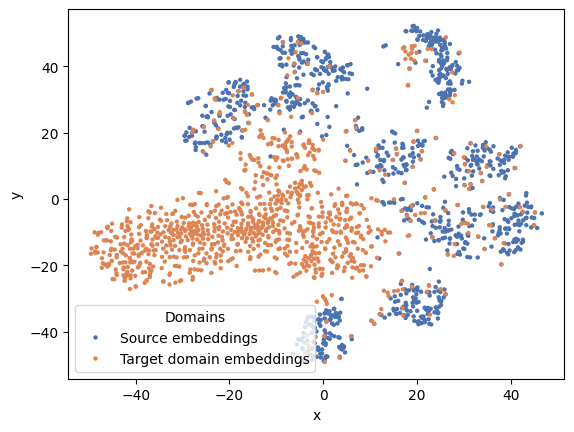

In [26]:
plot_model(naive_net, save_name="t-SNE_without_domain_adaptation.pdf")

Yellow dots are the source (MNIST) dataset, while purple dots are the target dataset (MNIST-M). We can clearly see that they belong to different space if we use the naive model.

Original embeddings of source / target (60000, 2352) (60000, 2352)
Samples embeddings (2000, 2352) (2000,)


Dimension reduced embeddings (2000, 2)


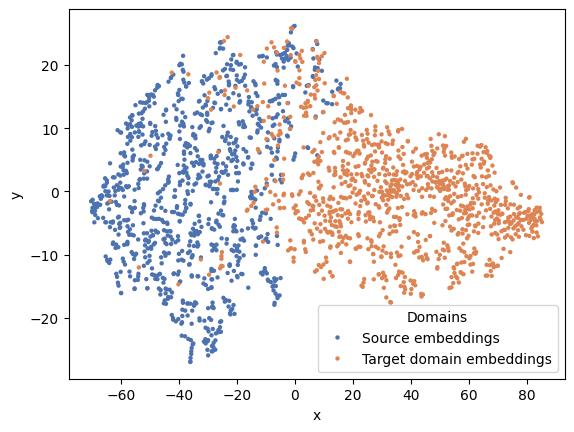

In [27]:
plot_model(dann, save_name="t-SNE_with_domain_adaptation.pdf")

But with our DANN, while still imperfect, the two domains are much more merged. This confirm our intuition that the GRL forces the network to produce domain-agnostic features.

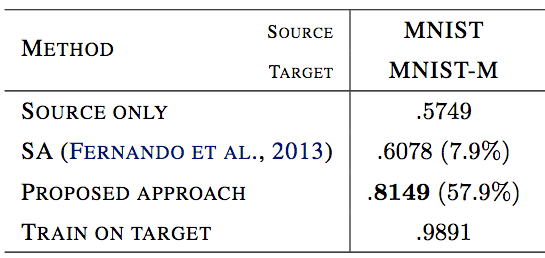

Our model is still lower than the performance reported in the original paper. You can try to further improve it by:

- use much more epochs
- modify the learning rate scheduler to be updated per step
- test different standardization
- different GRL factor scheduling

In [28]:
import wandb

wandb: Currently logged in as: charlesattend_ (iksrawowip). Use `wandb login --relogin` to force relogin


wandb: wandb version 0.16.1 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


wandb: Tracking run with wandb version 0.16.0


wandb: Run data is saved locally in /tempory/M2-DAC/RDFIA/TME/Section2/2c/wandb/run-20231228_120318-kwb7mgn1
wandb: Run `wandb offline` to turn off syncing.


wandb: Syncing run gallant-energy-1


wandb: ⭐️ View project at https://wandb.ai/iksrawowip/M2-DAC-RDFIA_TME_Section2_2c


wandb: 🚀 View run at https://wandb.ai/iksrawowip/M2-DAC-RDFIA_TME_Section2_2c/runs/kwb7mgn1


GRL factor 0.0


[SOURCE] Class loss/acc: 0.06716 / 97.88%, Domain loss/acc: 0.00317 / 100.0%


[TARGET] Class loss/acc: 1.42611 / 53.09%, Domain loss/acc: 0.24946 / 92.42%
Epoch 0, class loss: 0.24157, domain loss: 0.04381
GRL factor 0.00999966667999952


[SOURCE] Class loss/acc: 0.03487 / 98.91%, Domain loss/acc: 0.00145 / 99.97%


[TARGET] Class loss/acc: 1.41022 / 55.56%, Domain loss/acc: 0.27826 / 92.6%
Epoch 1, class loss: 0.05281, domain loss: 0.02342
GRL factor 0.01999733375993107


[SOURCE] Class loss/acc: 0.03049 / 99.04%, Domain loss/acc: 0.01707 / 99.63%


[TARGET] Class loss/acc: 1.39204 / 56.41%, Domain loss/acc: 0.18752 / 93.34%
Epoch 2, class loss: 0.03168, domain loss: 0.02683
GRL factor 0.02999100323881998


[SOURCE] Class loss/acc: 0.02864 / 99.11%, Domain loss/acc: 0.04177 / 98.84%


[TARGET] Class loss/acc: 1.34932 / 57.23%, Domain loss/acc: 0.16518 / 94.04%
Epoch 3, class loss: 0.02193, domain loss: 0.03119
GRL factor 0.039978680311163695


[SOURCE] Class loss/acc: 0.03142 / 99.01%, Domain loss/acc: 0.02915 / 99.1%


[TARGET] Class loss/acc: 1.26263 / 60.24%, Domain loss/acc: 0.35944 / 88.82%
Epoch 4, class loss: 0.01672, domain loss: 0.04315
GRL factor 0.049958374957880025


[SOURCE] Class loss/acc: 0.04083 / 98.85%, Domain loss/acc: 0.01308 / 99.68%


[TARGET] Class loss/acc: 1.27651 / 61.07%, Domain loss/acc: 0.38822 / 87.49%
Epoch 5, class loss: 0.01286, domain loss: 0.04724
GRL factor 0.05992810352914346


[SOURCE] Class loss/acc: 0.03542 / 99.01%, Domain loss/acc: 0.04097 / 98.89%


[TARGET] Class loss/acc: 1.45548 / 59.01%, Domain loss/acc: 0.24703 / 90.88%
Epoch 6, class loss: 0.01024, domain loss: 0.05177
GRL factor 0.069885890316429


[SOURCE] Class loss/acc: 0.03971 / 98.87%, Domain loss/acc: 0.04942 / 98.88%


[TARGET] Class loss/acc: 1.51267 / 60.11%, Domain loss/acc: 0.25402 / 90.02%
Epoch 7, class loss: 0.00769, domain loss: 0.05531
GRL factor 0.07982976911113138


[SOURCE] Class loss/acc: 0.03354 / 99.07%, Domain loss/acc: 0.06735 / 97.97%


[TARGET] Class loss/acc: 1.36419 / 63.33%, Domain loss/acc: 0.21456 / 91.7%
Epoch 8, class loss: 0.00733, domain loss: 0.05544
GRL factor 0.08975778474716023


[SOURCE] Class loss/acc: 0.03932 / 98.8%, Domain loss/acc: 0.07675 / 97.39%


[TARGET] Class loss/acc: 1.42619 / 62.94%, Domain loss/acc: 0.26023 / 90.28%
Epoch 9, class loss: 0.00526, domain loss: 0.05974
GRL factor 0.0996679946249559


[SOURCE] Class loss/acc: 0.03857 / 99.04%, Domain loss/acc: 0.13413 / 94.82%


[TARGET] Class loss/acc: 1.54751 / 61.85%, Domain loss/acc: 0.29701 / 89.21%
Epoch 10, class loss: 0.00473, domain loss: 0.06849
GRL factor 0.10955847021442966


[SOURCE] Class loss/acc: 0.0357 / 98.99%, Domain loss/acc: 0.11714 / 96.08%


[TARGET] Class loss/acc: 1.48182 / 62.65%, Domain loss/acc: 0.29766 / 88.99%
Epoch 11, class loss: 0.00545, domain loss: 0.07512
GRL factor 0.11942729853438583


[SOURCE] Class loss/acc: 0.03837 / 98.96%, Domain loss/acc: 0.08154 / 97.26%


[TARGET] Class loss/acc: 1.40432 / 63.77%, Domain loss/acc: 0.4717 / 84.49%
Epoch 12, class loss: 0.00635, domain loss: 0.09128
GRL factor 0.12927258360605842


[SOURCE] Class loss/acc: 0.03431 / 99.01%, Domain loss/acc: 0.06713 / 98.09%


[TARGET] Class loss/acc: 1.23233 / 64.72%, Domain loss/acc: 0.32943 / 87.88%
Epoch 13, class loss: 0.00912, domain loss: 0.1122
GRL factor 0.1390924478784581


[SOURCE] Class loss/acc: 0.03591 / 98.92%, Domain loss/acc: 0.2489 / 90.14%


[TARGET] Class loss/acc: 1.28319 / 65.2%, Domain loss/acc: 0.41508 / 82.7%
Epoch 14, class loss: 0.01112, domain loss: 0.12502
GRL factor 0.14888503362331806


[SOURCE] Class loss/acc: 0.0383 / 98.76%, Domain loss/acc: 0.24428 / 90.68%


[TARGET] Class loss/acc: 1.12265 / 67.48%, Domain loss/acc: 0.39452 / 83.27%
Epoch 15, class loss: 0.01213, domain loss: 0.1568
GRL factor 0.158648504297499


[SOURCE] Class loss/acc: 0.05224 / 98.56%, Domain loss/acc: 0.24817 / 89.8%


[TARGET] Class loss/acc: 1.23635 / 67.45%, Domain loss/acc: 0.63346 / 77.28%
Epoch 16, class loss: 0.01843, domain loss: 0.20923
GRL factor 0.16838104587081482


[SOURCE] Class loss/acc: 0.05912 / 98.7%, Domain loss/acc: 0.31126 / 86.12%


[TARGET] Class loss/acc: 1.58688 / 70.71%, Domain loss/acc: 1.02132 / 62.76%
Epoch 17, class loss: 0.018, domain loss: 0.21763
GRL factor 0.17808086811733026


[SOURCE] Class loss/acc: 0.0334 / 99.01%, Domain loss/acc: 0.24507 / 92.04%


[TARGET] Class loss/acc: 1.04857 / 74.1%, Domain loss/acc: 0.64126 / 70.4%
Epoch 18, class loss: 0.0144, domain loss: 0.21252
GRL factor 0.1877462058682855


[SOURCE] Class loss/acc: 0.03542 / 98.98%, Domain loss/acc: 0.44507 / 84.83%


[TARGET] Class loss/acc: 1.26301 / 73.54%, Domain loss/acc: 0.47435 / 71.55%
Epoch 19, class loss: 0.01271, domain loss: 0.2321
GRL factor 0.197375320224904


[SOURCE] Class loss/acc: 0.04815 / 98.73%, Domain loss/acc: 0.40353 / 87.52%


[TARGET] Class loss/acc: 1.44551 / 73.24%, Domain loss/acc: 0.52887 / 65.76%
Epoch 20, class loss: 0.01102, domain loss: 0.23503
GRL factor 0.2069664997294527


[SOURCE] Class loss/acc: 0.03733 / 99.0%, Domain loss/acc: 0.45019 / 83.36%


[TARGET] Class loss/acc: 1.27627 / 74.94%, Domain loss/acc: 0.49284 / 67.65%
Epoch 21, class loss: 0.0095, domain loss: 0.23305
GRL factor 0.21651806149302866


[SOURCE] Class loss/acc: 0.04251 / 98.91%, Domain loss/acc: 0.44549 / 84.47%


[TARGET] Class loss/acc: 1.30325 / 75.87%, Domain loss/acc: 0.50201 / 67.37%
Epoch 22, class loss: 0.00807, domain loss: 0.23728
GRL factor 0.22602835227867102


[SOURCE] Class loss/acc: 0.04245 / 98.79%, Domain loss/acc: 0.45507 / 83.41%


[TARGET] Class loss/acc: 1.16615 / 76.73%, Domain loss/acc: 0.51521 / 66.96%
Epoch 23, class loss: 0.00919, domain loss: 0.24227
GRL factor 0.23549574953849794


[SOURCE] Class loss/acc: 0.04317 / 98.7%, Domain loss/acc: 0.5376 / 76.11%


[TARGET] Class loss/acc: 0.83158 / 77.92%, Domain loss/acc: 0.49469 / 69.69%
Epoch 24, class loss: 0.00849, domain loss: 0.24677
GRL factor 0.2449186624037092


[SOURCE] Class loss/acc: 0.03488 / 98.95%, Domain loss/acc: 0.45855 / 84.25%


[TARGET] Class loss/acc: 1.12652 / 77.17%, Domain loss/acc: 0.60586 / 60.73%
Epoch 25, class loss: 0.01197, domain loss: 0.24862
GRL factor 0.25429553262639115


[SOURCE] Class loss/acc: 0.04205 / 98.96%, Domain loss/acc: 0.44974 / 86.57%


[TARGET] Class loss/acc: 1.25249 / 76.86%, Domain loss/acc: 0.57321 / 60.02%
Epoch 26, class loss: 0.00792, domain loss: 0.25154
GRL factor 0.2636248354722033


[SOURCE] Class loss/acc: 0.0388 / 99.0%, Domain loss/acc: 0.45373 / 86.92%


[TARGET] Class loss/acc: 1.10366 / 78.21%, Domain loss/acc: 0.57692 / 59.26%
Epoch 27, class loss: 0.00779, domain loss: 0.25447
GRL factor 0.2729050805631328


[SOURCE] Class loss/acc: 0.04264 / 98.77%, Domain loss/acc: 0.42589 / 88.51%


[TARGET] Class loss/acc: 1.16209 / 77.84%, Domain loss/acc: 0.58742 / 60.23%
Epoch 28, class loss: 0.00779, domain loss: 0.25477
GRL factor 0.28213481266963414


[SOURCE] Class loss/acc: 0.04152 / 98.79%, Domain loss/acc: 0.54171 / 76.19%


[TARGET] Class loss/acc: 1.14463 / 77.64%, Domain loss/acc: 0.50718 / 68.35%
Epoch 29, class loss: 0.00659, domain loss: 0.25388
GRL factor 0.2913126124515908


[SOURCE] Class loss/acc: 0.04323 / 98.88%, Domain loss/acc: 0.4927 / 80.97%


[TARGET] Class loss/acc: 1.12895 / 78.76%, Domain loss/acc: 0.55046 / 64.63%
Epoch 30, class loss: 0.00695, domain loss: 0.2542
GRL factor 0.3004370971476542


[SOURCE] Class loss/acc: 0.04988 / 98.79%, Domain loss/acc: 0.50501 / 79.45%


[TARGET] Class loss/acc: 1.32143 / 77.49%, Domain loss/acc: 0.54947 / 64.84%
Epoch 31, class loss: 0.00823, domain loss: 0.25338
GRL factor 0.30950692121263845


[SOURCE] Class loss/acc: 0.05162 / 98.72%, Domain loss/acc: 0.46133 / 83.73%


[TARGET] Class loss/acc: 1.26008 / 77.88%, Domain loss/acc: 0.59882 / 59.8%
Epoch 32, class loss: 0.00764, domain loss: 0.25867
GRL factor 0.3185207769027709


[SOURCE] Class loss/acc: 0.04254 / 98.95%, Domain loss/acc: 0.3803 / 88.29%


[TARGET] Class loss/acc: 1.22217 / 77.95%, Domain loss/acc: 0.68319 / 55.66%
Epoch 33, class loss: 0.00744, domain loss: 0.25717
GRL factor 0.3274773948087055


[SOURCE] Class loss/acc: 0.05107 / 98.8%, Domain loss/acc: 0.42907 / 84.48%


[TARGET] Class loss/acc: 1.25103 / 78.55%, Domain loss/acc: 0.62794 / 60.36%
Epoch 34, class loss: 0.00784, domain loss: 0.25753
GRL factor 0.3363755443363323


[SOURCE] Class loss/acc: 0.05486 / 98.79%, Domain loss/acc: 0.41621 / 87.07%


[TARGET] Class loss/acc: 1.10199 / 78.94%, Domain loss/acc: 0.67193 / 54.1%
Epoch 35, class loss: 0.00886, domain loss: 0.25993
GRL factor 0.34521403413552076


[SOURCE] Class loss/acc: 0.04167 / 98.99%, Domain loss/acc: 0.45364 / 84.65%


[TARGET] Class loss/acc: 1.15967 / 78.1%, Domain loss/acc: 0.64594 / 55.96%
Epoch 36, class loss: 0.00745, domain loss: 0.25778
GRL factor 0.35399171247704597


[SOURCE] Class loss/acc: 0.05691 / 98.42%, Domain loss/acc: 0.38495 / 90.92%


[TARGET] Class loss/acc: 1.04561 / 77.48%, Domain loss/acc: 0.6973 / 52.43%
Epoch 37, class loss: 0.00826, domain loss: 0.25993
GRL factor 0.3627074675780513


[SOURCE] Class loss/acc: 0.04378 / 98.91%, Domain loss/acc: 0.46601 / 82.52%


[TARGET] Class loss/acc: 1.03278 / 78.76%, Domain loss/acc: 0.59972 / 60.69%
Epoch 38, class loss: 0.00772, domain loss: 0.25764
GRL factor 0.3713602278765078


[SOURCE] Class loss/acc: 0.0468 / 98.73%, Domain loss/acc: 0.47232 / 82.87%


[TARGET] Class loss/acc: 1.08252 / 78.36%, Domain loss/acc: 0.57703 / 61.24%
Epoch 39, class loss: 0.00653, domain loss: 0.256
GRL factor 0.379948962255225


[SOURCE] Class loss/acc: 0.05164 / 98.57%, Domain loss/acc: 0.4964 / 80.44%


[TARGET] Class loss/acc: 1.28157 / 77.13%, Domain loss/acc: 0.55194 / 63.57%
Epoch 40, class loss: 0.00833, domain loss: 0.25731
GRL factor 0.38847268021606096


[SOURCE] Class loss/acc: 0.04683 / 98.81%, Domain loss/acc: 0.46535 / 83.06%


[TARGET] Class loss/acc: 1.35588 / 77.7%, Domain loss/acc: 0.56972 / 62.71%
Epoch 41, class loss: 0.00822, domain loss: 0.25741
GRL factor 0.3969304320050775


[SOURCE] Class loss/acc: 0.04788 / 98.81%, Domain loss/acc: 0.45957 / 83.45%


[TARGET] Class loss/acc: 1.25498 / 78.55%, Domain loss/acc: 0.58767 / 62.42%
Epoch 42, class loss: 0.00791, domain loss: 0.25608
GRL factor 0.4053213086894629


[SOURCE] Class loss/acc: 0.04902 / 98.89%, Domain loss/acc: 0.43368 / 86.91%


[TARGET] Class loss/acc: 1.32716 / 77.41%, Domain loss/acc: 0.62607 / 56.51%
Epoch 43, class loss: 0.00822, domain loss: 0.25799
GRL factor 0.41364444218713525


[SOURCE] Class loss/acc: 0.05366 / 98.51%, Domain loss/acc: 0.46193 / 82.17%


[TARGET] Class loss/acc: 1.06088 / 77.01%, Domain loss/acc: 0.64575 / 56.61%
Epoch 44, class loss: 0.00794, domain loss: 0.25698
GRL factor 0.4218990052500078


[SOURCE] Class loss/acc: 0.04549 / 98.96%, Domain loss/acc: 0.38672 / 88.5%


[TARGET] Class loss/acc: 1.16714 / 78.69%, Domain loss/acc: 0.68137 / 55.53%
Epoch 45, class loss: 0.01045, domain loss: 0.25792
GRL factor 0.4300842114019796


[SOURCE] Class loss/acc: 0.04503 / 98.73%, Domain loss/acc: 0.4604 / 83.2%


[TARGET] Class loss/acc: 1.11023 / 78.22%, Domain loss/acc: 0.60452 / 60.39%
Epoch 46, class loss: 0.0075, domain loss: 0.25691
GRL factor 0.43819931483276786


[SOURCE] Class loss/acc: 0.04465 / 98.74%, Domain loss/acc: 0.45535 / 84.18%


[TARGET] Class loss/acc: 1.07176 / 78.86%, Domain loss/acc: 0.63062 / 56.96%
Epoch 47, class loss: 0.00812, domain loss: 0.25893
GRL factor 0.4462436102487797


[SOURCE] Class loss/acc: 0.07325 / 98.61%, Domain loss/acc: 0.54975 / 78.31%


[TARGET] Class loss/acc: 1.61974 / 76.99%, Domain loss/acc: 0.58088 / 58.08%
Epoch 48, class loss: 0.01285, domain loss: 0.26529
GRL factor 0.4542164326822591


[SOURCE] Class loss/acc: 0.05718 / 98.63%, Domain loss/acc: 0.56777 / 74.19%


[TARGET] Class loss/acc: 1.14601 / 78.06%, Domain loss/acc: 0.52374 / 65.94%
Epoch 49, class loss: 0.01271, domain loss: 0.25963
GRL factor 0.4621171572600098


[SOURCE] Class loss/acc: 0.05389 / 98.78%, Domain loss/acc: 0.67509 / 62.17%


[TARGET] Class loss/acc: 1.27485 / 78.04%, Domain loss/acc: 0.38872 / 80.15%
Epoch 50, class loss: 0.00869, domain loss: 0.25762
GRL factor 0.46994519893303766


[SOURCE] Class loss/acc: 0.04852 / 98.65%, Domain loss/acc: 0.66814 / 62.35%


[TARGET] Class loss/acc: 1.24376 / 77.38%, Domain loss/acc: 0.41777 / 77.25%
Epoch 51, class loss: 0.00938, domain loss: 0.26012
GRL factor 0.4777000121684978


[SOURCE] Class loss/acc: 0.05762 / 98.54%, Domain loss/acc: 0.56416 / 74.16%


[TARGET] Class loss/acc: 1.10629 / 78.19%, Domain loss/acc: 0.53686 / 65.57%
Epoch 52, class loss: 0.00966, domain loss: 0.26149
GRL factor 0.4853810906053715


[SOURCE] Class loss/acc: 0.06441 / 98.81%, Domain loss/acc: 0.32839 / 91.4%


[TARGET] Class loss/acc: 1.96429 / 76.76%, Domain loss/acc: 0.76467 / 53.73%
Epoch 53, class loss: 0.01257, domain loss: 0.2614
GRL factor 0.4929879666753243


[SOURCE] Class loss/acc: 0.07864 / 98.53%, Domain loss/acc: 0.50181 / 79.84%


[TARGET] Class loss/acc: 1.42056 / 78.87%, Domain loss/acc: 0.60082 / 62.43%
Epoch 54, class loss: 0.01412, domain loss: 0.26845
GRL factor 0.5005202111902354


[SOURCE] Class loss/acc: 0.04652 / 98.8%, Domain loss/acc: 0.52947 / 78.17%


[TARGET] Class loss/acc: 1.15256 / 78.94%, Domain loss/acc: 0.62861 / 57.71%
Epoch 55, class loss: 0.01174, domain loss: 0.26955
GRL factor 0.5079774328978963


[SOURCE] Class loss/acc: 0.06781 / 98.66%, Domain loss/acc: 0.50152 / 82.73%


[TARGET] Class loss/acc: 1.37462 / 77.86%, Domain loss/acc: 0.59 / 59.02%
Epoch 56, class loss: 0.01253, domain loss: 0.26584
GRL factor 0.5153592780074097


[SOURCE] Class loss/acc: 0.13672 / 97.74%, Domain loss/acc: 0.42659 / 83.55%


[TARGET] Class loss/acc: 4.09532 / 68.52%, Domain loss/acc: 0.36465 / 82.85%
Epoch 57, class loss: 0.01396, domain loss: 0.26969
GRL factor 0.5226654296858209


[SOURCE] Class loss/acc: 0.06324 / 98.45%, Domain loss/acc: 0.53926 / 78.45%


[TARGET] Class loss/acc: 1.11711 / 78.68%, Domain loss/acc: 0.604 / 56.84%
Epoch 58, class loss: 0.01097, domain loss: 0.2694
GRL factor 0.5298956075275294


[SOURCE] Class loss/acc: 0.04809 / 98.79%, Domain loss/acc: 0.52561 / 78.58%


[TARGET] Class loss/acc: 1.2108 / 79.99%, Domain loss/acc: 0.50715 / 70.68%
Epoch 59, class loss: 0.01028, domain loss: 0.27226
GRL factor 0.5370495669980351


[SOURCE] Class loss/acc: 0.0706 / 98.47%, Domain loss/acc: 0.50891 / 80.2%


[TARGET] Class loss/acc: 1.24021 / 79.83%, Domain loss/acc: 0.57992 / 61.24%
Epoch 60, class loss: 0.0106, domain loss: 0.27137
GRL factor 0.5441270988535674


[SOURCE] Class loss/acc: 0.05398 / 98.8%, Domain loss/acc: 0.457 / 84.81%


[TARGET] Class loss/acc: 1.38877 / 78.37%, Domain loss/acc: 0.6522 / 56.99%
Epoch 61, class loss: 0.01043, domain loss: 0.27139
GRL factor 0.5511280285381468


[SOURCE] Class loss/acc: 0.05582 / 98.84%, Domain loss/acc: 0.46657 / 84.94%


[TARGET] Class loss/acc: 1.34056 / 80.18%, Domain loss/acc: 0.69532 / 51.33%
Epoch 62, class loss: 0.0104, domain loss: 0.27053
GRL factor 0.5580522155596244


[SOURCE] Class loss/acc: 0.07005 / 98.5%, Domain loss/acc: 0.44072 / 86.54%


[TARGET] Class loss/acc: 1.1399 / 78.09%, Domain loss/acc: 0.70341 / 51.59%
Epoch 63, class loss: 0.01294, domain loss: 0.26978
GRL factor 0.5648995528462248


[SOURCE] Class loss/acc: 0.06257 / 98.89%, Domain loss/acc: 0.50112 / 81.64%


[TARGET] Class loss/acc: 2.15316 / 75.55%, Domain loss/acc: 0.55918 / 67.1%
Epoch 64, class loss: 0.01827, domain loss: 0.28346
GRL factor 0.5716699660851172


[SOURCE] Class loss/acc: 0.07363 / 98.06%, Domain loss/acc: 0.50567 / 78.98%


[TARGET] Class loss/acc: 1.2334 / 76.63%, Domain loss/acc: 0.66651 / 57.66%
Epoch 65, class loss: 0.01438, domain loss: 0.27911
GRL factor 0.5783634130445059


[SOURCE] Class loss/acc: 0.07509 / 98.01%, Domain loss/acc: 0.58846 / 73.11%


[TARGET] Class loss/acc: 1.15157 / 77.04%, Domain loss/acc: 0.49309 / 71.89%
Epoch 66, class loss: 0.01295, domain loss: 0.28032
GRL factor 0.5849798828807289


[SOURCE] Class loss/acc: 0.05967 / 98.4%, Domain loss/acc: 0.50673 / 82.18%


[TARGET] Class loss/acc: 1.08767 / 78.37%, Domain loss/acc: 0.59835 / 60.54%
Epoch 67, class loss: 0.01277, domain loss: 0.2751
GRL factor 0.5915193954318165


[SOURCE] Class loss/acc: 0.05111 / 98.81%, Domain loss/acc: 0.51796 / 81.48%


[TARGET] Class loss/acc: 0.96591 / 80.15%, Domain loss/acc: 0.63734 / 53.48%
Epoch 68, class loss: 0.00864, domain loss: 0.27286
GRL factor 0.5979820004989413


[SOURCE] Class loss/acc: 0.05544 / 98.68%, Domain loss/acc: 0.49131 / 81.18%


[TARGET] Class loss/acc: 1.35829 / 77.5%, Domain loss/acc: 0.68086 / 52.76%
Epoch 69, class loss: 0.01153, domain loss: 0.28005
GRL factor 0.6043677771171634


[SOURCE] Class loss/acc: 0.05517 / 98.46%, Domain loss/acc: 0.45305 / 85.41%


[TARGET] Class loss/acc: 1.20444 / 77.15%, Domain loss/acc: 0.65573 / 56.0%
Epoch 70, class loss: 0.01345, domain loss: 0.27846
GRL factor 0.6106768328168442


[SOURCE] Class loss/acc: 0.06093 / 98.52%, Domain loss/acc: 0.59444 / 71.29%


[TARGET] Class loss/acc: 1.13576 / 78.84%, Domain loss/acc: 0.635 / 59.11%
Epoch 71, class loss: 0.01375, domain loss: 0.27165
GRL factor 0.6169093028770651


[SOURCE] Class loss/acc: 0.05762 / 98.71%, Domain loss/acc: 0.46408 / 84.49%


[TARGET] Class loss/acc: 1.07354 / 79.29%, Domain loss/acc: 0.64113 / 57.61%
Epoch 72, class loss: 0.01487, domain loss: 0.28062
GRL factor 0.623065349572361


[SOURCE] Class loss/acc: 0.05763 / 98.71%, Domain loss/acc: 0.5487 / 79.44%


[TARGET] Class loss/acc: 1.2132 / 79.1%, Domain loss/acc: 0.56932 / 63.0%
Epoch 73, class loss: 0.01103, domain loss: 0.28054
GRL factor 0.6291451614140355


[SOURCE] Class loss/acc: 0.07992 / 98.54%, Domain loss/acc: 0.55746 / 76.05%


[TARGET] Class loss/acc: 1.29628 / 79.16%, Domain loss/acc: 0.59679 / 60.61%
Epoch 74, class loss: 0.02113, domain loss: 0.28143
GRL factor 0.6351489523872873


[SOURCE] Class loss/acc: 0.07562 / 98.61%, Domain loss/acc: 0.46423 / 84.35%


[TARGET] Class loss/acc: 1.00788 / 79.26%, Domain loss/acc: 0.80624 / 43.82%
Epoch 75, class loss: 0.0131, domain loss: 0.28715
GRL factor 0.6410769611853466


[SOURCE] Class loss/acc: 0.07111 / 98.62%, Domain loss/acc: 0.44719 / 88.13%


[TARGET] Class loss/acc: 1.26293 / 77.89%, Domain loss/acc: 0.57772 / 62.71%
Epoch 76, class loss: 0.01623, domain loss: 0.28566
GRL factor 0.6469294504417666


[SOURCE] Class loss/acc: 0.06869 / 98.65%, Domain loss/acc: 0.51065 / 81.98%


[TARGET] Class loss/acc: 1.23185 / 78.7%, Domain loss/acc: 0.53523 / 66.98%
Epoch 77, class loss: 0.01279, domain loss: 0.2877
GRL factor 0.65270670596199


[SOURCE] Class loss/acc: 0.06609 / 98.75%, Domain loss/acc: 0.51452 / 82.95%


[TARGET] Class loss/acc: 1.21234 / 80.85%, Domain loss/acc: 0.60009 / 58.83%
Epoch 78, class loss: 0.01372, domain loss: 0.28495
GRL factor 0.6584090359552512


[SOURCE] Class loss/acc: 0.05795 / 98.9%, Domain loss/acc: 0.51678 / 79.85%


[TARGET] Class loss/acc: 1.41953 / 78.8%, Domain loss/acc: 0.66991 / 54.76%
Epoch 79, class loss: 0.00978, domain loss: 0.28052
GRL factor 0.6640367702678489


[SOURCE] Class loss/acc: 0.06935 / 98.49%, Domain loss/acc: 0.58366 / 73.51%


[TARGET] Class loss/acc: 0.94859 / 79.24%, Domain loss/acc: 0.54681 / 65.09%
Epoch 80, class loss: 0.00811, domain loss: 0.27917
GRL factor 0.6695902596187708


[SOURCE] Class loss/acc: 0.0714 / 98.39%, Domain loss/acc: 0.62235 / 68.63%


[TARGET] Class loss/acc: 1.13613 / 79.81%, Domain loss/acc: 0.56427 / 66.57%
Epoch 81, class loss: 0.01215, domain loss: 0.27982
GRL factor 0.6750698748386077


[SOURCE] Class loss/acc: 0.08084 / 98.33%, Domain loss/acc: 0.44888 / 83.94%


[TARGET] Class loss/acc: 1.25527 / 78.65%, Domain loss/acc: 0.71173 / 56.85%
Epoch 82, class loss: 0.0165, domain loss: 0.28932
GRL factor 0.6804760061126618


[SOURCE] Class loss/acc: 0.06425 / 98.55%, Domain loss/acc: 0.59429 / 74.09%


[TARGET] Class loss/acc: 1.34438 / 78.69%, Domain loss/acc: 0.53229 / 65.73%
Epoch 83, class loss: 0.01111, domain loss: 0.28485
GRL factor 0.6858090622290947


[SOURCE] Class loss/acc: 0.07294 / 98.27%, Domain loss/acc: 0.62226 / 69.61%


[TARGET] Class loss/acc: 1.13361 / 79.21%, Domain loss/acc: 0.41732 / 76.39%
Epoch 84, class loss: 0.00904, domain loss: 0.2797
GRL factor 0.6910694698329305


[SOURCE] Class loss/acc: 0.05426 / 98.71%, Domain loss/acc: 0.50012 / 78.57%


[TARGET] Class loss/acc: 1.00082 / 78.94%, Domain loss/acc: 0.62265 / 61.52%
Epoch 85, class loss: 0.00886, domain loss: 0.27884
GRL factor 0.6962576726866814


[SOURCE] Class loss/acc: 0.05708 / 98.88%, Domain loss/acc: 0.45339 / 83.6%


[TARGET] Class loss/acc: 1.15247 / 80.17%, Domain loss/acc: 0.63171 / 58.84%
Epoch 86, class loss: 0.01188, domain loss: 0.27661
GRL factor 0.7013741309383126


[SOURCE] Class loss/acc: 0.06274 / 98.65%, Domain loss/acc: 0.54696 / 76.45%


[TARGET] Class loss/acc: 1.12607 / 78.9%, Domain loss/acc: 0.54587 / 66.85%
Epoch 87, class loss: 0.00858, domain loss: 0.27774
GRL factor 0.7064193203972353


[SOURCE] Class loss/acc: 0.0696 / 98.61%, Domain loss/acc: 0.43139 / 85.87%


[TARGET] Class loss/acc: 1.39641 / 79.27%, Domain loss/acc: 0.70546 / 54.67%
Epoch 88, class loss: 0.00837, domain loss: 0.26823
GRL factor 0.7113937318189625


[SOURCE] Class loss/acc: 0.05885 / 98.45%, Domain loss/acc: 0.47882 / 83.14%


[TARGET] Class loss/acc: 0.99573 / 79.52%, Domain loss/acc: 0.59585 / 61.14%
Epoch 89, class loss: 0.00851, domain loss: 0.273
GRL factor 0.7162978701990246


[SOURCE] Class loss/acc: 0.07296 / 98.74%, Domain loss/acc: 0.42387 / 87.19%


[TARGET] Class loss/acc: 1.08973 / 80.53%, Domain loss/acc: 0.76801 / 46.76%
Epoch 90, class loss: 0.00927, domain loss: 0.27615
GRL factor 0.7211322540767


[SOURCE] Class loss/acc: 0.06294 / 98.38%, Domain loss/acc: 0.50718 / 79.64%


[TARGET] Class loss/acc: 1.04691 / 79.51%, Domain loss/acc: 0.65022 / 56.28%
Epoch 91, class loss: 0.01318, domain loss: 0.28797
GRL factor 0.7258974148490809


[SOURCE] Class loss/acc: 0.10632 / 97.16%, Domain loss/acc: 0.72169 / 68.69%


[TARGET] Class loss/acc: 1.22531 / 74.5%, Domain loss/acc: 0.69413 / 54.73%
Epoch 92, class loss: 0.01294, domain loss: 0.28256
GRL factor 0.7305938960959437


[SOURCE] Class loss/acc: 0.06204 / 98.61%, Domain loss/acc: 0.51232 / 79.11%


[TARGET] Class loss/acc: 0.92633 / 80.85%, Domain loss/acc: 0.57912 / 63.52%
Epoch 93, class loss: 0.01904, domain loss: 0.28669
GRL factor 0.7352222529158692


[SOURCE] Class loss/acc: 0.07343 / 98.33%, Domain loss/acc: 0.38181 / 87.02%


[TARGET] Class loss/acc: 0.97267 / 81.03%, Domain loss/acc: 0.73668 / 53.5%
Epoch 94, class loss: 0.01436, domain loss: 0.28381
GRL factor 0.7397830512740042


[SOURCE] Class loss/acc: 0.21811 / 95.64%, Domain loss/acc: 0.47081 / 82.71%


[TARGET] Class loss/acc: 2.46185 / 67.64%, Domain loss/acc: 0.33799 / 83.74%
Epoch 95, class loss: 0.02061, domain loss: 0.29452
GRL factor 0.7442768673618374


[SOURCE] Class loss/acc: 0.06816 / 98.58%, Domain loss/acc: 0.53461 / 79.31%


[TARGET] Class loss/acc: 1.15821 / 79.5%, Domain loss/acc: 0.61926 / 57.36%
Epoch 96, class loss: 0.0216, domain loss: 0.28847
GRL factor 0.7487042869693088


[SOURCE] Class loss/acc: 0.06568 / 98.39%, Domain loss/acc: 0.57116 / 74.82%


[TARGET] Class loss/acc: 0.98354 / 80.9%, Domain loss/acc: 0.56394 / 64.93%
Epoch 97, class loss: 0.01269, domain loss: 0.29217
GRL factor 0.7530659048695518


[SOURCE] Class loss/acc: 0.06627 / 98.56%, Domain loss/acc: 0.47829 / 83.18%


[TARGET] Class loss/acc: 1.02461 / 80.76%, Domain loss/acc: 0.63656 / 58.5%
Epoch 98, class loss: 0.01047, domain loss: 0.28664
GRL factor 0.7573623242165262


[SOURCE] Class loss/acc: 0.06802 / 98.36%, Domain loss/acc: 0.60782 / 69.95%


[TARGET] Class loss/acc: 0.92365 / 81.08%, Domain loss/acc: 0.56893 / 65.86%
Epoch 99, class loss: 0.01346, domain loss: 0.28851


Original embeddings of source / target (60000, 2352) (60000, 2352)
Samples embeddings (2000, 2352) (2000,)


Dimension reduced embeddings (2000, 2)


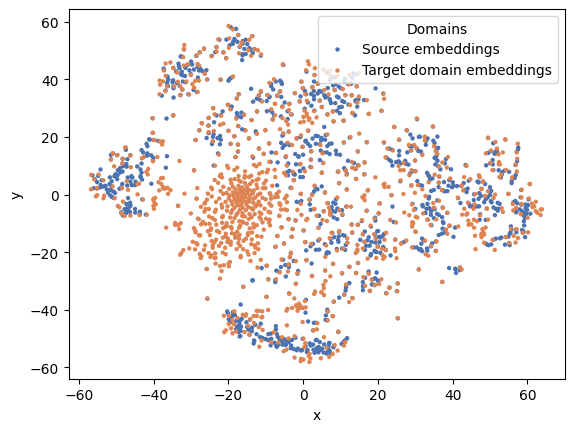

In [29]:
epochs = 100

dann_100 = DANN().cuda()

optimizer = torch.optim.SGD(dann_100.parameters(), lr=1.0, momentum=0.9)

mu0, alpha, beta = 0.01, 10, 0.75
scheduler = torch.optim.lr_scheduler.LambdaLR(
    optimizer, lambda e: 0.01 / (1 + alpha * e / epochs) ** beta
)
lmbd = lambda e: -1 + 2 / (1 + math.exp(-2 * e / (len(source_train_loader) * epochs)))

wandb.init(
    entity="iksrawowip",
    config={
        "epochs": epochs,
        "GRL_Factor": lmbd,
        "scheduler": scheduler,
        "mu0": mu0,
        "alpha": alpha,
        "beta": beta,
    }
)
b = 0
for epoch in range(epochs):
    cls_loss, domain_loss = 0.0, 0.0
    grl_factor = lmbd(b)
    print(f"GRL factor {grl_factor}")

    for (xs, ys), (xt, _) in zip(source_train_loader, target_train_loader):
        grl_factor = lmbd(b)
        b += 1

        xs, ys = xs.cuda(), ys.cuda()
        xt = xt.cuda()
        x = torch.cat((xs, xt))

        optimizer.zero_grad()
        cls_logits, domain_logits = dann_100(x, factor=grl_factor)

        ce = F.cross_entropy(cls_logits[: len(ys)], ys)

        preds = torch.cat((torch.ones(len(xs)), torch.zeros(len(xt)))).cuda()
        bce = F.binary_cross_entropy_with_logits(domain_logits[:, 0], preds)

        loss = ce + bce
        loss.backward()
        optimizer.step()

        cls_loss += ce.item()
        domain_loss += bce.item()

    c_acc_source, d_acc_source, c_loss_source, d_loss_source = eval_dann(dann_100, source_test_loader)
    print(
        f"[SOURCE] Class loss/acc: {c_loss_source} / {c_acc_source}%, Domain loss/acc: {d_loss_source} / {d_acc_source}%"
    )

    c_acc_target, d_acc_target, c_loss_target, d_loss_target = eval_dann(dann_100, target_test_loader, source=False)
    print(
        f"[TARGET] Class loss/acc: {c_loss_target} / {c_acc_target}%, Domain loss/acc: {d_loss_target} / {d_acc_target}%"
    )
    wandb.log({
        "GRL Factor": grl_factor,
        "Class Accuracy on Source domain": c_acc_source,
        "Discriminator Accuracy on Source domain": d_acc_source,
        "Class loss on Source domain": c_loss_source,
        "Discriminator loss on Source domain": d_loss_source,
        "Class Accuracy on Target domain": c_acc_target,
        "Discriminator Accuracy on Target domain": d_acc_target,
        "Class Loss on Target domain": c_loss_target,
        "Discriminator Loss on Target domain": d_loss_target,
    })

    cls_loss = round(cls_loss / len(source_train_loader), 5)
    domain_loss = round(domain_loss / (2 * len(source_train_loader)), 5)
    print(f"Epoch {epoch}, class loss: {cls_loss}, domain loss: {domain_loss}")
    scheduler.step()
plot_model(dann_100, save_name="t-SNE_100epochs_with_domain_adaptation.pdf")
torch.save(dann_100, "dann_100.pt")

In [30]:
import time  # Used here just for simulating training time

from tqdm import tqdm


def train_model(total_epochs, batches_per_epoch):
    total_batches = total_epochs * batches_per_epoch
    with tqdm(total=total_batches, desc="Epoch 1", unit="batch") as pbar:
        for epoch in range(total_epochs):
            for batch in range(batches_per_epoch):
                # Simulating training process
                time.sleep(0.1)  # Replace this with actual training code
                # Your training logic here

                # Update the progress bar description and progress
                pbar.set_description(f"Epoch {epoch + 1}/{total_epochs}")
                pbar.update(1)


# Example usage
total_epochs = 5
batches_per_epoch = 10
train_model(total_epochs, batches_per_epoch)

Epoch 1:   0%|                                                                                                                                             | 0/50 [00:00<?, ?batch/s]

Epoch 1/5:   0%|                                                                                                                                           | 0/50 [00:00<?, ?batch/s]

Epoch 1/5:   2%|██▌                                                                                                                                | 1/50 [00:00<00:04,  9.91batch/s]

Epoch 1/5:   2%|██▌                                                                                                                                | 1/50 [00:00<00:04,  9.91batch/s]

Epoch 1/5:   4%|█████▏                                                                                                                             | 2/50 [00:00<00:04,  9.87batch/s]

Epoch 1/5:   4%|█████▏                                                                                                                             | 2/50 [00:00<00:04,  9.87batch/s]

Epoch 1/5:   6%|███████▊                                                                                                                           | 3/50 [00:00<00:04,  9.86batch/s]

Epoch 1/5:   6%|███████▊                                                                                                                           | 3/50 [00:00<00:04,  9.86batch/s]

Epoch 1/5:   8%|██████████▍                                                                                                                        | 4/50 [00:00<00:04,  9.86batch/s]

Epoch 1/5:   8%|██████████▍                                                                                                                        | 4/50 [00:00<00:04,  9.86batch/s]

Epoch 1/5:  10%|█████████████                                                                                                                      | 5/50 [00:00<00:04,  9.86batch/s]

Epoch 1/5:  10%|█████████████                                                                                                                      | 5/50 [00:00<00:04,  9.86batch/s]

Epoch 1/5:  12%|███████████████▋                                                                                                                   | 6/50 [00:00<00:04,  9.85batch/s]

Epoch 1/5:  12%|███████████████▋                                                                                                                   | 6/50 [00:00<00:04,  9.85batch/s]

Epoch 1/5:  14%|██████████████████▎                                                                                                                | 7/50 [00:00<00:04,  9.85batch/s]

Epoch 1/5:  14%|██████████████████▎                                                                                                                | 7/50 [00:00<00:04,  9.85batch/s]

Epoch 1/5:  16%|████████████████████▉                                                                                                              | 8/50 [00:00<00:04,  9.85batch/s]

Epoch 1/5:  16%|████████████████████▉                                                                                                              | 8/50 [00:00<00:04,  9.85batch/s]

Epoch 1/5:  18%|███████████████████████▌                                                                                                           | 9/50 [00:00<00:04,  9.85batch/s]

Epoch 1/5:  18%|███████████████████████▌                                                                                                           | 9/50 [00:01<00:04,  9.85batch/s]

Epoch 1/5:  20%|██████████████████████████                                                                                                        | 10/50 [00:01<00:04,  9.85batch/s]

Epoch 2/5:  20%|██████████████████████████                                                                                                        | 10/50 [00:01<00:04,  9.85batch/s]

Epoch 2/5:  22%|████████████████████████████▌                                                                                                     | 11/50 [00:01<00:03,  9.84batch/s]

Epoch 2/5:  22%|████████████████████████████▌                                                                                                     | 11/50 [00:01<00:03,  9.84batch/s]

Epoch 2/5:  24%|███████████████████████████████▏                                                                                                  | 12/50 [00:01<00:03,  9.85batch/s]

Epoch 2/5:  24%|███████████████████████████████▏                                                                                                  | 12/50 [00:01<00:03,  9.85batch/s]

Epoch 2/5:  26%|█████████████████████████████████▊                                                                                                | 13/50 [00:01<00:03,  9.86batch/s]

Epoch 2/5:  26%|█████████████████████████████████▊                                                                                                | 13/50 [00:01<00:03,  9.86batch/s]

Epoch 2/5:  28%|████████████████████████████████████▍                                                                                             | 14/50 [00:01<00:03,  9.86batch/s]

Epoch 2/5:  28%|████████████████████████████████████▍                                                                                             | 14/50 [00:01<00:03,  9.86batch/s]

Epoch 2/5:  30%|███████████████████████████████████████                                                                                           | 15/50 [00:01<00:03,  9.86batch/s]

Epoch 2/5:  30%|███████████████████████████████████████                                                                                           | 15/50 [00:01<00:03,  9.86batch/s]

Epoch 2/5:  32%|█████████████████████████████████████████▌                                                                                        | 16/50 [00:01<00:03,  9.85batch/s]

Epoch 2/5:  32%|█████████████████████████████████████████▌                                                                                        | 16/50 [00:01<00:03,  9.85batch/s]

Epoch 2/5:  34%|████████████████████████████████████████████▏                                                                                     | 17/50 [00:01<00:03,  9.85batch/s]

Epoch 2/5:  34%|████████████████████████████████████████████▏                                                                                     | 17/50 [00:01<00:03,  9.85batch/s]

Epoch 2/5:  36%|██████████████████████████████████████████████▊                                                                                   | 18/50 [00:01<00:03,  9.85batch/s]

Epoch 2/5:  36%|██████████████████████████████████████████████▊                                                                                   | 18/50 [00:01<00:03,  9.85batch/s]

Epoch 2/5:  38%|█████████████████████████████████████████████████▍                                                                                | 19/50 [00:01<00:03,  9.85batch/s]

Epoch 2/5:  38%|█████████████████████████████████████████████████▍                                                                                | 19/50 [00:02<00:03,  9.85batch/s]

Epoch 2/5:  40%|████████████████████████████████████████████████████                                                                              | 20/50 [00:02<00:03,  9.86batch/s]

Epoch 3/5:  40%|████████████████████████████████████████████████████                                                                              | 20/50 [00:02<00:03,  9.86batch/s]

Epoch 3/5:  42%|██████████████████████████████████████████████████████▌                                                                           | 21/50 [00:02<00:02,  9.86batch/s]

Epoch 3/5:  42%|██████████████████████████████████████████████████████▌                                                                           | 21/50 [00:02<00:02,  9.86batch/s]

Epoch 3/5:  44%|█████████████████████████████████████████████████████████▏                                                                        | 22/50 [00:02<00:02,  9.85batch/s]

Epoch 3/5:  44%|█████████████████████████████████████████████████████████▏                                                                        | 22/50 [00:02<00:02,  9.85batch/s]

Epoch 3/5:  46%|███████████████████████████████████████████████████████████▊                                                                      | 23/50 [00:02<00:02,  9.85batch/s]

Epoch 3/5:  46%|███████████████████████████████████████████████████████████▊                                                                      | 23/50 [00:02<00:02,  9.85batch/s]

Epoch 3/5:  48%|██████████████████████████████████████████████████████████████▍                                                                   | 24/50 [00:02<00:02,  9.86batch/s]

Epoch 3/5:  48%|██████████████████████████████████████████████████████████████▍                                                                   | 24/50 [00:02<00:02,  9.86batch/s]

Epoch 3/5:  50%|█████████████████████████████████████████████████████████████████                                                                 | 25/50 [00:02<00:02,  9.86batch/s]

Epoch 3/5:  50%|█████████████████████████████████████████████████████████████████                                                                 | 25/50 [00:02<00:02,  9.86batch/s]

Epoch 3/5:  52%|███████████████████████████████████████████████████████████████████▌                                                              | 26/50 [00:02<00:02,  9.86batch/s]

Epoch 3/5:  52%|███████████████████████████████████████████████████████████████████▌                                                              | 26/50 [00:02<00:02,  9.86batch/s]

Epoch 3/5:  54%|██████████████████████████████████████████████████████████████████████▏                                                           | 27/50 [00:02<00:02,  9.86batch/s]

Epoch 3/5:  54%|██████████████████████████████████████████████████████████████████████▏                                                           | 27/50 [00:02<00:02,  9.86batch/s]

Epoch 3/5:  56%|████████████████████████████████████████████████████████████████████████▊                                                         | 28/50 [00:02<00:02,  9.86batch/s]

Epoch 3/5:  56%|████████████████████████████████████████████████████████████████████████▊                                                         | 28/50 [00:02<00:02,  9.86batch/s]

Epoch 3/5:  58%|███████████████████████████████████████████████████████████████████████████▍                                                      | 29/50 [00:02<00:02,  9.85batch/s]

Epoch 3/5:  58%|███████████████████████████████████████████████████████████████████████████▍                                                      | 29/50 [00:03<00:02,  9.85batch/s]

Epoch 3/5:  60%|██████████████████████████████████████████████████████████████████████████████                                                    | 30/50 [00:03<00:02,  9.86batch/s]

Epoch 4/5:  60%|██████████████████████████████████████████████████████████████████████████████                                                    | 30/50 [00:03<00:02,  9.86batch/s]

Epoch 4/5:  62%|████████████████████████████████████████████████████████████████████████████████▌                                                 | 31/50 [00:03<00:01,  9.85batch/s]

Epoch 4/5:  62%|████████████████████████████████████████████████████████████████████████████████▌                                                 | 31/50 [00:03<00:01,  9.85batch/s]

Epoch 4/5:  64%|███████████████████████████████████████████████████████████████████████████████████▏                                              | 32/50 [00:03<00:01,  9.84batch/s]

Epoch 4/5:  64%|███████████████████████████████████████████████████████████████████████████████████▏                                              | 32/50 [00:03<00:01,  9.84batch/s]

Epoch 4/5:  66%|█████████████████████████████████████████████████████████████████████████████████████▊                                            | 33/50 [00:03<00:01,  9.84batch/s]

Epoch 4/5:  66%|█████████████████████████████████████████████████████████████████████████████████████▊                                            | 33/50 [00:03<00:01,  9.84batch/s]

Epoch 4/5:  68%|████████████████████████████████████████████████████████████████████████████████████████▍                                         | 34/50 [00:03<00:01,  9.85batch/s]

Epoch 4/5:  68%|████████████████████████████████████████████████████████████████████████████████████████▍                                         | 34/50 [00:03<00:01,  9.85batch/s]

Epoch 4/5:  70%|███████████████████████████████████████████████████████████████████████████████████████████                                       | 35/50 [00:03<00:01,  9.85batch/s]

Epoch 4/5:  70%|███████████████████████████████████████████████████████████████████████████████████████████                                       | 35/50 [00:03<00:01,  9.85batch/s]

Epoch 4/5:  72%|█████████████████████████████████████████████████████████████████████████████████████████████▌                                    | 36/50 [00:03<00:01,  9.85batch/s]

Epoch 4/5:  72%|█████████████████████████████████████████████████████████████████████████████████████████████▌                                    | 36/50 [00:03<00:01,  9.85batch/s]

Epoch 4/5:  74%|████████████████████████████████████████████████████████████████████████████████████████████████▏                                 | 37/50 [00:03<00:01,  9.86batch/s]

Epoch 4/5:  74%|████████████████████████████████████████████████████████████████████████████████████████████████▏                                 | 37/50 [00:03<00:01,  9.86batch/s]

Epoch 4/5:  76%|██████████████████████████████████████████████████████████████████████████████████████████████████▊                               | 38/50 [00:03<00:01,  9.86batch/s]

Epoch 4/5:  76%|██████████████████████████████████████████████████████████████████████████████████████████████████▊                               | 38/50 [00:03<00:01,  9.86batch/s]

Epoch 4/5:  78%|█████████████████████████████████████████████████████████████████████████████████████████████████████▍                            | 39/50 [00:03<00:01,  9.86batch/s]

Epoch 4/5:  78%|█████████████████████████████████████████████████████████████████████████████████████████████████████▍                            | 39/50 [00:04<00:01,  9.86batch/s]

Epoch 4/5:  80%|████████████████████████████████████████████████████████████████████████████████████████████████████████                          | 40/50 [00:04<00:01,  9.86batch/s]

Epoch 5/5:  80%|████████████████████████████████████████████████████████████████████████████████████████████████████████                          | 40/50 [00:04<00:01,  9.86batch/s]

Epoch 5/5:  82%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▌                       | 41/50 [00:04<00:00,  9.86batch/s]

Epoch 5/5:  82%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▌                       | 41/50 [00:04<00:00,  9.86batch/s]

Epoch 5/5:  84%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                    | 42/50 [00:04<00:00,  9.86batch/s]

Epoch 5/5:  84%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                    | 42/50 [00:04<00:00,  9.86batch/s]

Epoch 5/5:  86%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                  | 43/50 [00:04<00:00,  9.87batch/s]

Epoch 5/5:  86%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                  | 43/50 [00:04<00:00,  9.87batch/s]

Epoch 5/5:  88%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍               | 44/50 [00:04<00:00,  9.86batch/s]

Epoch 5/5:  88%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍               | 44/50 [00:04<00:00,  9.86batch/s]

Epoch 5/5:  90%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████             | 45/50 [00:04<00:00,  9.86batch/s]

Epoch 5/5:  90%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████             | 45/50 [00:04<00:00,  9.86batch/s]

Epoch 5/5:  92%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌          | 46/50 [00:04<00:00,  9.85batch/s]

Epoch 5/5:  92%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌          | 46/50 [00:04<00:00,  9.85batch/s]

Epoch 5/5:  94%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏       | 47/50 [00:04<00:00,  9.85batch/s]

Epoch 5/5:  94%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏       | 47/50 [00:04<00:00,  9.85batch/s]

Epoch 5/5:  96%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊     | 48/50 [00:04<00:00,  9.85batch/s]

Epoch 5/5:  96%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊     | 48/50 [00:04<00:00,  9.85batch/s]

Epoch 5/5:  98%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍  | 49/50 [00:04<00:00,  9.85batch/s]

Epoch 5/5:  98%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍  | 49/50 [00:05<00:00,  9.85batch/s]

Epoch 5/5: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:05<00:00,  9.85batch/s]

Epoch 5/5: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:05<00:00,  9.85batch/s]